In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures):
    ratings = {}
    league_ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int_results['HomeDiv'])).union(set(df_int_fixtures['HomeDiv'])).union(set(df_int_results['AwayDiv'])).union(set(df_int_fixtures['AwayDiv']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam'])).union(set(df_int_results['HomeTeam'])).union(set(df_int_fixtures['HomeTeam'])).union(set(df_int_results['AwayTeam'])).union(set(df_int_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
            
    """
    # Initialize ratings for each competition
    league_ratings['REST'] = {
        'brH': 0.0,
        'brA': 0.0,
        'continuous_overunderperformances': 0
    }
    """
    
    for competition in competitions:
        league_ratings[competition] = {
            'INT1': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0,
            },
            'DCUP': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0,
            }
        }

    #print('Teams:', teams, end='\n\n')
    return ratings, league_ratings


In [3]:
def initialize_rest_ratings(rest_teams):
    rest_ratings = {}
    for team in rest_teams:
        rest_ratings[team] = {
            'REST': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
        }
    return rest_ratings

In [4]:
def create_team_to_league_mapping(df_results, df_fixtures, df_int):
    team_to_league = {}
    rest_teams = set() # To store teams that are assigned to the 'REST' league

    def get_league_level(division):
        # Extracting the integer part from the division
        integer_part = ''.join(filter(str.isdigit, division))
        return int(integer_part)


    # Iterate through the results and fixtures dataframes and map teams to their leagues
    for df in [df_results, df_fixtures]:
        for index, row in df.iterrows():
            for team in [row['HomeTeam'], row['AwayTeam']]:
                current_div = row['Div']
                current_level = get_league_level(current_div)

                # If the team is not yet in the dictionary, or if the current league is higher, update the entry
                if team not in team_to_league or current_level < get_league_level(team_to_league[team]):
                    team_to_league[team] = current_div

    # Now process df_int
    for index, row in df_int.iterrows():
        for team in [row['HomeTeam'], row['AwayTeam']]:
            if team not in team_to_league:
                # If the team is not found in the other dataframes, assign it to 'REST'
                team_to_league[team] = 'REST'
                rest_teams.add(team)

    return team_to_league, rest_teams

In [5]:
def get_league_from_team(team, team_to_league):
    return team_to_league.get(team, 'REST')

In [6]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, league_ratings, rates):
    ind_threshold = rates['ind_threshold']
    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > ind_threshold:
            #add current game to training data
            training_games.append({
                #"brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                #"brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                #"prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0],
                #"prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[1],
                #"brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                #"brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                #"prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[0],
                #"prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1],
                #"rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1]),
                "rating_difference": ratings[row["HomeTeam"]][competition]["brH"] - ratings[row["AwayTeam"]][competition]["brA"],
                #"FTHG": row["FTHG"],
                #"FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })

        """
        if np.isnan(ratings[row["HomeTeam"]][competition]["brH"]):
            print("error")
            break
        """
        
        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        
        """
        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })
        """

    return ratings, games_with_rating, training_games

In [7]:
def update_league_ratings_multiple_games(df_int_results, league_ratings, rates):
    # Iterate over each match in the international results data
    for index, row in df_int_results.iterrows():
        # Extract relevant information from the row
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']
        Div = row['Div']
        FTHG = row['FTHG']
        FTAG = row['FTAG']

        # Update the league ratings based on the match result
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates)

    return league_ratings


In [8]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, league_ratings, rates, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma']
    
    tau = rates['tau']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)

    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)
    
    competitions = set(ratings[HomeTeam].keys()).union(set(ratings[AwayTeam].keys()))
    """
    if ratings[HomeTeam][competition]['brH'] == 0 and ratings[HomeTeam][competition]['brA'] == 0:
        for otherCompetition in competitions:
            if ratings[HomeTeam][otherCompetition]['brH'] != 0 or ratings[HomeTeam][otherCompetition]['brA'] != 0:
                ratings[HomeTeam][competition]['brH'] = ratings[HomeTeam][otherCompetition]['brH'] + tau * (league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                ratings[HomeTeam][competition]['brA'] = ratings[HomeTeam][otherCompetition]['brA'] + tau * (league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA'])
                print ("Team", HomeTeam, "new Competition", competition, "old Competition", otherCompetition, "new brH", ratings[HomeTeam][competition]['brH'], "new brA", ratings[HomeTeam][competition]['brA'])

    if ratings[AwayTeam][competition]['brA'] == 0 and ratings[AwayTeam][competition]['brH'] == 0:
        for otherCompetition in competitions:
            if ratings[AwayTeam][otherCompetition]['brA'] != 0 or ratings[AwayTeam][otherCompetition]['brH'] != 0:
                ratings[AwayTeam][competition]['brA'] = ratings[AwayTeam][otherCompetition]['brA'] + tau * (league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA']) 
                ratings[AwayTeam][competition]['brH'] = ratings[AwayTeam][otherCompetition]['brH'] + tau * (league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH']) 
                print ("Team", AwayTeam, "new Competition", competition, "old Competition", otherCompetition, "new brA", ratings[AwayTeam][competition]['brA'], "new brH", ratings[AwayTeam][competition]['brH'])
    """         
    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)
    
        

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])
    """
    if HomeTeam == 'Liverpool' and AwayTeam == 'Man United' and FTHG == 7:
        print('Observed Goal Difference:', observed_goal_difference)
        print('Expected Goals x:', expected_goal_x)
        print('Expected Goals y:', expected_goal_y)
        print('Expected Goal Difference:', expected_goal_difference)
        print('Error:', error)
        print('Psi:', psi_temp)
        print('Diminishing Function psi x:', diminishing_function_psi_x)
        print('Diminishing Function psi y:', diminishing_function_psi_y)
        print('Old brH x:', previous_home_rating_x)
        print('Old brA x:', previous_away_rating_x)
        print('Old brH y:', previous_home_rating_y)
        print('Old brA y:', previous_away_rating_y)
        print('New brH x:', ratings[HomeTeam][competition]['brH'])
        print('New brA x:', ratings[HomeTeam][competition]['brA'])
        print('New brH y:', ratings[AwayTeam][competition]['brH'])
        print('New brA y:', ratings[AwayTeam][competition]['brA'])
    """
    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [9]:
# Function to update ratings based on results data
def update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda2']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma2']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(league_ratings[HomeLeague][Div]['brH']) / 3
    expected_goal_x = np.sign(league_ratings[HomeLeague][Div]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(league_ratings[AwayLeague][Div]['brA']) / 3
    expected_goal_y = np.sign(league_ratings[AwayLeague][Div]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = league_ratings[HomeLeague][Div]['brH']
    previous_away_rating_x = league_ratings[HomeLeague][Div]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    league_ratings[HomeLeague][Div]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    league_ratings[HomeLeague][Div]['brA'] = previous_away_rating_x + (league_ratings[HomeLeague][Div]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = league_ratings[AwayLeague][Div]['brH']
    previous_away_rating_y = league_ratings[AwayLeague][Div]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    league_ratings[AwayLeague][Div]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    league_ratings[AwayLeague][Div]['brH'] = previous_home_rating_y + (league_ratings[AwayLeague][Div]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] + 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] - 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] + 1)
    else:
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = 0
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return league_ratings


In [10]:
def calculate_provisional_ratings(ratings, team, competition, rates):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    #form_threshold_phi = 1
    form_threshold_phi = rates['phi']

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    #rating_impact_mu = 0.01
    rating_impact_mu = rates['mu']

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    #diminishing_factor_delta = 2.5
    diminishing_factor_delta = rates['delta']

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away

    return brH, brA
    
    
    phi_current = abs(ratings[team][competition]['continuous_overunderperformances'])
    
    if abs(phi_current) < (form_threshold_phi + 1):
        return brH, brA
    
    """
    prH = brH
    prA = brA
    
    phi_diff = int(abs(phi_current) - form_threshold_phi)
    #print("phi_diff:", phi_diff)
    for i in range(phi_diff):
        # Calculate performance factor for home team x
        a = phi_diff - i
        b = a ** diminishing_factor_delta
        form_factor_home = a / b
        
        prH += np.sign(phi_current) * rating_impact_mu * form_factor_home
        prA += np.sign(phi_current) * rating_impact_mu * form_factor_home
    """
    
    # Calculate performance factor for home team x
    a = abs(phi_current) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (phi_current > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    elif (phi_current < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home
    else:
        prH = brH
        prA = brA
    
        
    return prH, prA

In [11]:
def calculate_probabilities(features, model):

    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [12]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, Awayleague, rates):
    rho = rates['rho']
    sigma = rates['sigma']
    
    competition1 = competition
    competition2 = competition
    if competition == 'INT1':
        competition1 = HomeLeague
        competition2 = Awayleague
        
    # Calculate provisional ratings if necessary
    home_rating_x = ratings[HomeTeam][competition1]['brH']
    away_rating_y = ratings[AwayTeam][competition2]['brA']
    if (abs(ratings[HomeTeam][competition1]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition1, rates)
        home_rating_x = provisional_ratings_x[0]
    if (abs(ratings[AwayTeam][competition2]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition2, rates)
        away_rating_y = provisional_ratings_y[1]
    
    if competition == 'INT1':
        """
        if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Prior home rating x:', home_rating_x)
            print('Prior away rating y:', away_rating_y)
            print('Home league rating x:', league_ratings[competition1]['INT1']['brH'])
            print('Away league rating y:', league_ratings[competition2]['INT1']['brA'])
        """
        home_rating_x = rho * home_rating_x + sigma * league_ratings[competition1]['INT1']['brH']
        away_rating_y = rho * away_rating_y + sigma * league_ratings[competition2]['INT1']['brA']

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y
    """
    if HomeTeam == 'Man City' and AwayTeam == 'Inter':
            print('Int home rating x:', home_rating_x)
            print('Int away rating y:', away_rating_y)
            print('Rating difference:', rating_difference, end='\n\n')
    """
    return rating_difference

In [47]:
def predict_outcomes(df_fixtures, ratings, league_ratings, rates, model):
    
    all_rps = []
    league_ratings_fake = {}
    HomeLeague = 'fake'
    Awayleague = 'fake'

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']
        
        """
        if index == 4039:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Prior home rating x: ', ratings[HomeTeam][competition]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][competition]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][competition]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][competition]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
        """
        """
        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings_fake, HomeLeague, Awayleague, rates)
        

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)
        


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)
        

        # Update league table
       #league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)
        
        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)
        """
        if index == 4039:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        """
    #print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')
    
    """
    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table
    """
    
    return all_rps, league_tables


In [48]:
def predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model):

    int_rps = []
    
    for index, row in df_int_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']

        competition = row['Div']
        """
        if index == 124:
            print('Home Team: ', HomeTeam)
            print('Away Team: ', AwayTeam)
            print('Home League: ', HomeLeague)
            print('Away League: ', AwayLeague)
            print('Prior home rating x: ', ratings[HomeTeam][HomeLeague]['brH'])
            print('Prior away rating x: ', ratings[HomeTeam][HomeLeague]['brA'])
            #print('Prior continous over- / underperformance x: ', ratings[HomeTeam][HomeLeague]['continuous_overunderperformances'])
            print('Prior home rating y: ', ratings[AwayTeam][AwayLeague]['brH'])
            print('Prior away rating y: ', ratings[AwayTeam][AwayLeague]['brA'])
            #print('Prior continous over- / underperformance y: ', ratings[AwayTeam][AwayLeague]['continuous_overunderperformances'])
            print('Prior home league rating x: ', league_ratings[HomeLeague]['INT1']['brH'])
            print('Prior away league rating x: ', league_ratings[HomeLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of x: ', league_ratings[HomeLeague]['INT1']['continuous_overunderperformances'])
            print('Prior home league rating y: ', league_ratings[AwayLeague]['INT1']['brH'])
            print('Prior away league rating y: ', league_ratings[AwayLeague]['INT1']['brA'])
            #print('Prior continous over- / underperformance league of y: ', league_ratings[AwayLeague]['INT1']['continuous_overunderperformances'])
        """
        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, AwayLeague, rates)
        
            
            

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n')
        """
        

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        int_rps.append(rps_score)
        
        """
        if index == 124:
            
            print('Rating Difference: ', rating_difference)
            print('Home Win Prob: ', home_win_prob)
            print('Draw Prob: ', draw_prob)
            print('Away Win Prob: ', away_win_prob)
            print('RPS Score: ', rps_score)
        
        """

        # Update league_ratings
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, competition, row['FTHG'], row['FTAG'], league_ratings, rates)

    #print(f"RPS for {competition}:", np.mean(int_rps), '\n')


    return int_rps

In [49]:
def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [50]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [51]:

from sklearn.ensemble import GradientBoostingClassifier


def train_model(df_train):

    # Create Logistic Regression model
    #model = GradientBoostingClassifier(n_estimators=100)
    model = LogisticRegression(solver="saga", penalty="l2")  
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000, random_state=23)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    #score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model

;

''

In [42]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('../data/new_season_2016-2022_sorted_compressed_top2.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('../data/new_season_2022-2023_sorted_top2.csv')

# Load the international results data file
df_int_results = pd.read_csv('../data/new_season_2016-2022_INT.csv')

# Load the international fixtures data file
df_int_fixtures = pd.read_csv('../data/new_season_2022-2023_INT.csv')

# Load the domestic cup results data file
df_dcup_results = pd.read_csv('../data/cleaned_new_season_2016-2022_DCUP.csv')

# Define the learning rates
rates = {
    'lambda': 0.045,
    'gamma': 0.97,
    'delta': 13,
    'phi': 2,
    'mu': 0.0,
    'rho': 0.93,
    'sigma': 0.6,
    'tau': 0.001,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}

# Map teams to leagues
df_int = pd.concat([df_int_results, df_int_fixtures], ignore_index=True)
#team_to_league, rest_teams = create_team_to_league_mapping(df_results, df_fixtures, df_int)

# Initialize ratings based on the results data
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
#model.C_

# Train the model for predicting match outcomes
df_train = pd.DataFrame(training_games)
df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)



"""
# Create a reverse mapping of leagues to teams
league_to_teams = {}
for team, league in team_to_league.items():
    if league not in league_to_teams:
        league_to_teams[league] = []
    league_to_teams[league].append(team)

# Print the teams sorted by league
for league, teams in sorted(league_to_teams.items()):
    print(f"{league}:")
    print(", ".join(teams))
    print()
"""

# Update league ratings based on the results data here
league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
league_ratings = update_league_ratings_multiple_games(df_dcup_results, league_ratings, rates)

for league, values in league_ratings.items():
    if values['INT1']['brH'] == 0:
        continue
    # International rating
    #print(f"League: {league} (International), Rating: {(values['INT1']['brH'] + values['INT1']['brA']) / 2}")
    
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    # National rating
    #print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")


# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
    all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)


int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)


#combine int_rps and all_rps to one list
combine_rps = all_rps + int_rps

mean_combine_rps = np.mean(combine_rps)
print('Final average RPS Score:', mean_combine_rps)
;

Average RPS Score for DEU2: 0.22049679545207493 

Average RPS Score for BEL1: 0.2049471101807396 

Average RPS Score for ENG2: 0.22596315914682255 

Average RPS Score for SCO1: 0.18779972128010383 
Average RPS Score for FRA2: 0.21931802369675382 

Average RPS Score for SCO2: 0.22419731287671937 

Average RPS Score for NLD1: 0.18286283986607646 

Average RPS Score for TUR1: 0.20230071531738797 
Average RPS Score for DEU1: 0.20734485773992203 

Average RPS Score for ENG1: 0.20346986375458656 

Average RPS Score for FRA1: 0.2041182031816928 

Average RPS Score for PRT1: 0.18711661856752743 

Average RPS Score for ITA2: 0.2190357705316524 
Average RPS Score for ESP1: 0.20771531923223335 

Average RPS Score for ESP2: 0.20572182530568123 

Average RPS Score for ITA1: 0.19862275333222273 

Average RPS Score for GRC1: 0.17881670414232825 

Average RPS Score across all competitions: 0.2060116955459774
RPS for INT1: 0.18978723325931723 

Final average RPS Score: 0.20567015668005748


''

In [ ]:
competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int['HomeDiv'])).union(set(df_int['AwayDiv']))
for competition in competitions:
    print(competition,':', ratings['Basel'][competition])

In [ ]:
                 
plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool", "Everton", "Leicester", "West Ham", "Southampton"]
#teams = ['Arsenal', 'Man City', 'Barcelona', 'Real Madrid', 'Bayern Munich', 'Dortmund', 'Paris SG', 'Napoli', 'Juventus']
#teams = league_to_teams['E0']
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time232.png", dpi=300)

;

In [ ]:
# Print league tables
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

In [ ]:
# Plot RPS distribution
plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=25)
plt.savefig("../images/rps_distribution232.png", dpi=300)



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

In [56]:
# Gridsearch on lambda and gamma

# Define the learning rates
rates = {
    'lambda': 0.04,
    'gamma': 0.96,
    'delta': 13,
    'phi': 2,
    'mu': 0.0,
    'rho': 0.93,
    'sigma': 0.6,
    'tau': 0.001,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda': np.linspace(0.0, 0.1, 51),
    'gamma': np.linspace(0.0, 1.0, 51)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures,df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)
    
    all_rps = []
    
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

    # Now you can calculate the mean RPS across all competitions
    mean_rps = np.mean(all_rps)

    score = mean_rps
    

    # Store the current results
    gs_results.append({
        'lambda': rates['lambda'],
        'gamma': rates['gamma'],
        'score': score,
    })
    
    print(f"Lambda: {rates['lambda']}, Gamma: {rates['gamma']}, Score: {score}")



  0%|          | 1/2601 [00:04<3:21:07,  4.64s/it]

Lambda: 0.0, Gamma: 0.0, Score: 0.22997708478286105


  0%|          | 2/2601 [00:08<3:09:54,  4.38s/it]

Lambda: 0.002, Gamma: 0.0, Score: 0.2128453420526771


  0%|          | 3/2601 [00:13<3:05:38,  4.29s/it]

Lambda: 0.004, Gamma: 0.0, Score: 0.21246991483864625


  0%|          | 4/2601 [00:17<3:04:32,  4.26s/it]

Lambda: 0.006, Gamma: 0.0, Score: 0.21196505672714985


  0%|          | 5/2601 [00:21<3:05:07,  4.28s/it]

Lambda: 0.008, Gamma: 0.0, Score: 0.21148211873395195


  0%|          | 6/2601 [00:25<3:03:50,  4.25s/it]

Lambda: 0.01, Gamma: 0.0, Score: 0.2110521163184933


  0%|          | 7/2601 [00:29<3:02:30,  4.22s/it]

Lambda: 0.012, Gamma: 0.0, Score: 0.2106718096800969


  0%|          | 8/2601 [00:34<3:02:12,  4.22s/it]

Lambda: 0.014, Gamma: 0.0, Score: 0.2103366287838571


  0%|          | 9/2601 [00:38<2:59:26,  4.15s/it]

Lambda: 0.016, Gamma: 0.0, Score: 0.2100443530800749


  0%|          | 10/2601 [00:42<3:02:57,  4.24s/it]

Lambda: 0.018000000000000002, Gamma: 0.0, Score: 0.20978670142493736


  0%|          | 11/2601 [00:47<3:08:22,  4.36s/it]

Lambda: 0.02, Gamma: 0.0, Score: 0.2095669141165156


  0%|          | 12/2601 [00:51<3:11:44,  4.44s/it]

Lambda: 0.022, Gamma: 0.0, Score: 0.20937387450654774


  0%|          | 13/2601 [00:56<3:10:12,  4.41s/it]

Lambda: 0.024, Gamma: 0.0, Score: 0.20920334223666154


  1%|          | 14/2601 [01:00<3:07:27,  4.35s/it]

Lambda: 0.026000000000000002, Gamma: 0.0, Score: 0.2090596300868308


  1%|          | 15/2601 [01:04<3:05:09,  4.30s/it]

Lambda: 0.028, Gamma: 0.0, Score: 0.2089381709380858


  1%|          | 16/2601 [01:08<3:04:01,  4.27s/it]

Lambda: 0.03, Gamma: 0.0, Score: 0.20883317396366038


  1%|          | 17/2601 [01:13<3:03:59,  4.27s/it]

Lambda: 0.032, Gamma: 0.0, Score: 0.20874436713306802


  1%|          | 18/2601 [01:17<3:02:37,  4.24s/it]

Lambda: 0.034, Gamma: 0.0, Score: 0.20866973944923983


  1%|          | 19/2601 [01:21<2:59:52,  4.18s/it]

Lambda: 0.036000000000000004, Gamma: 0.0, Score: 0.2086086025931104


  1%|          | 20/2601 [01:25<2:58:13,  4.14s/it]

Lambda: 0.038, Gamma: 0.0, Score: 0.20855728684928396


  1%|          | 21/2601 [01:29<2:55:31,  4.08s/it]

Lambda: 0.04, Gamma: 0.0, Score: 0.20851576871334018


  1%|          | 22/2601 [01:33<2:54:39,  4.06s/it]

Lambda: 0.042, Gamma: 0.0, Score: 0.20848577750330946


  1%|          | 23/2601 [01:37<2:56:38,  4.11s/it]

Lambda: 0.044, Gamma: 0.0, Score: 0.20846199162231133


  1%|          | 24/2601 [01:41<2:58:36,  4.16s/it]

Lambda: 0.046, Gamma: 0.0, Score: 0.20844529327349096


  1%|          | 25/2601 [01:45<2:59:38,  4.18s/it]

Lambda: 0.048, Gamma: 0.0, Score: 0.20843492856880422


  1%|          | 26/2601 [01:50<2:59:10,  4.17s/it]

Lambda: 0.05, Gamma: 0.0, Score: 0.20843318283302573


  1%|          | 27/2601 [01:54<2:59:02,  4.17s/it]

Lambda: 0.052000000000000005, Gamma: 0.0, Score: 0.20843546220404094


  1%|          | 28/2601 [01:58<2:58:51,  4.17s/it]

Lambda: 0.054, Gamma: 0.0, Score: 0.20844169340208676


  1%|          | 29/2601 [02:02<2:56:45,  4.12s/it]

Lambda: 0.056, Gamma: 0.0, Score: 0.2084522151351189


  1%|          | 30/2601 [02:06<2:54:21,  4.07s/it]

Lambda: 0.058, Gamma: 0.0, Score: 0.20846759754058883


  1%|          | 31/2601 [02:10<2:55:01,  4.09s/it]

Lambda: 0.06, Gamma: 0.0, Score: 0.20848648586810514


  1%|          | 32/2601 [02:14<2:56:46,  4.13s/it]

Lambda: 0.062, Gamma: 0.0, Score: 0.2085086528637474


  1%|▏         | 33/2601 [02:19<2:58:56,  4.18s/it]

Lambda: 0.064, Gamma: 0.0, Score: 0.20853480834642604


  1%|▏         | 34/2601 [02:23<2:58:20,  4.17s/it]

Lambda: 0.066, Gamma: 0.0, Score: 0.20856327811381162


  1%|▏         | 35/2601 [02:27<2:55:50,  4.11s/it]

Lambda: 0.068, Gamma: 0.0, Score: 0.2085945698158959


  1%|▏         | 36/2601 [02:31<2:55:24,  4.10s/it]

Lambda: 0.07, Gamma: 0.0, Score: 0.20862790918547947


  1%|▏         | 37/2601 [02:35<2:53:59,  4.07s/it]

Lambda: 0.07200000000000001, Gamma: 0.0, Score: 0.20866441175584735


  1%|▏         | 38/2601 [02:39<2:54:16,  4.08s/it]

Lambda: 0.074, Gamma: 0.0, Score: 0.20870298622349945


  1%|▏         | 39/2601 [02:43<2:55:10,  4.10s/it]

Lambda: 0.076, Gamma: 0.0, Score: 0.20874440738439168


  2%|▏         | 40/2601 [02:47<2:58:29,  4.18s/it]

Lambda: 0.078, Gamma: 0.0, Score: 0.20878626274692824


  2%|▏         | 41/2601 [02:52<2:59:27,  4.21s/it]

Lambda: 0.08, Gamma: 0.0, Score: 0.20883149789961633


  2%|▏         | 42/2601 [02:56<2:58:25,  4.18s/it]

Lambda: 0.082, Gamma: 0.0, Score: 0.20887783443551702


  2%|▏         | 43/2601 [03:00<2:55:32,  4.12s/it]

Lambda: 0.084, Gamma: 0.0, Score: 0.20892616363727562


  2%|▏         | 44/2601 [03:04<2:53:42,  4.08s/it]

Lambda: 0.08600000000000001, Gamma: 0.0, Score: 0.20897588148481522


  2%|▏         | 45/2601 [03:08<2:53:35,  4.07s/it]

Lambda: 0.088, Gamma: 0.0, Score: 0.2090271013353839


  2%|▏         | 46/2601 [03:12<2:54:53,  4.11s/it]

Lambda: 0.09, Gamma: 0.0, Score: 0.20907928801990114


  2%|▏         | 47/2601 [03:16<2:56:12,  4.14s/it]

Lambda: 0.092, Gamma: 0.0, Score: 0.20913324756637328


  2%|▏         | 48/2601 [03:20<2:56:18,  4.14s/it]

Lambda: 0.094, Gamma: 0.0, Score: 0.20918840442579414


  2%|▏         | 49/2601 [03:25<2:56:55,  4.16s/it]

Lambda: 0.096, Gamma: 0.0, Score: 0.20924492573657683


  2%|▏         | 50/2601 [03:29<2:58:10,  4.19s/it]

Lambda: 0.098, Gamma: 0.0, Score: 0.20930293605933925


  2%|▏         | 51/2601 [03:33<2:57:04,  4.17s/it]

Lambda: 0.1, Gamma: 0.0, Score: 0.20936079146263709


  2%|▏         | 52/2601 [03:37<2:53:59,  4.10s/it]

Lambda: 0.0, Gamma: 0.02, Score: 0.27967565741854816


  2%|▏         | 53/2601 [03:41<2:52:54,  4.07s/it]

Lambda: 0.002, Gamma: 0.02, Score: 0.21272449757359393


  2%|▏         | 54/2601 [03:45<2:52:23,  4.06s/it]

Lambda: 0.004, Gamma: 0.02, Score: 0.212369625469424


  2%|▏         | 55/2601 [03:49<2:54:34,  4.11s/it]

Lambda: 0.006, Gamma: 0.02, Score: 0.21188558845283076


  2%|▏         | 56/2601 [03:53<2:55:14,  4.13s/it]

Lambda: 0.008, Gamma: 0.02, Score: 0.2114127479486067


  2%|▏         | 57/2601 [03:57<2:55:10,  4.13s/it]

Lambda: 0.01, Gamma: 0.02, Score: 0.21097968347567048


  2%|▏         | 58/2601 [04:02<2:54:43,  4.12s/it]

Lambda: 0.012, Gamma: 0.02, Score: 0.21060299818888642


  2%|▏         | 59/2601 [04:06<2:53:06,  4.09s/it]

Lambda: 0.014, Gamma: 0.02, Score: 0.21026832400949622


  2%|▏         | 60/2601 [04:10<2:53:12,  4.09s/it]

Lambda: 0.016, Gamma: 0.02, Score: 0.20997471398790318


  2%|▏         | 61/2601 [04:14<2:54:10,  4.11s/it]

Lambda: 0.018000000000000002, Gamma: 0.02, Score: 0.20971797359485977


  2%|▏         | 62/2601 [04:18<2:55:14,  4.14s/it]

Lambda: 0.02, Gamma: 0.02, Score: 0.20948976223806348


  2%|▏         | 63/2601 [04:22<2:55:07,  4.14s/it]

Lambda: 0.022, Gamma: 0.02, Score: 0.20929639825507373


  2%|▏         | 64/2601 [04:26<2:53:54,  4.11s/it]

Lambda: 0.024, Gamma: 0.02, Score: 0.2091262857467968


  2%|▏         | 65/2601 [04:30<2:52:49,  4.09s/it]

Lambda: 0.026000000000000002, Gamma: 0.02, Score: 0.20898321220766336


  3%|▎         | 66/2601 [04:34<2:51:29,  4.06s/it]

Lambda: 0.028, Gamma: 0.02, Score: 0.2088581207912934


  3%|▎         | 67/2601 [04:38<2:51:45,  4.07s/it]

Lambda: 0.03, Gamma: 0.02, Score: 0.2087550321518376


  3%|▎         | 68/2601 [04:43<2:53:50,  4.12s/it]

Lambda: 0.032, Gamma: 0.02, Score: 0.20866539031204476


  3%|▎         | 69/2601 [04:47<2:56:42,  4.19s/it]

Lambda: 0.034, Gamma: 0.02, Score: 0.2085902526697054


  3%|▎         | 70/2601 [04:51<2:57:39,  4.21s/it]

Lambda: 0.036000000000000004, Gamma: 0.02, Score: 0.20852942484157394


  3%|▎         | 71/2601 [04:55<2:56:11,  4.18s/it]

Lambda: 0.038, Gamma: 0.02, Score: 0.20847833430470644


  3%|▎         | 72/2601 [04:59<2:54:28,  4.14s/it]

Lambda: 0.04, Gamma: 0.02, Score: 0.20843778634598817


  3%|▎         | 73/2601 [05:03<2:53:20,  4.11s/it]

Lambda: 0.042, Gamma: 0.02, Score: 0.20840615763451187


  3%|▎         | 74/2601 [05:08<2:53:43,  4.12s/it]

Lambda: 0.044, Gamma: 0.02, Score: 0.20838271548495294


  3%|▎         | 75/2601 [05:12<2:54:02,  4.13s/it]

Lambda: 0.046, Gamma: 0.02, Score: 0.208366564267476


  3%|▎         | 76/2601 [05:16<2:54:24,  4.14s/it]

Lambda: 0.048, Gamma: 0.02, Score: 0.20835811435486173


  3%|▎         | 77/2601 [05:20<2:53:35,  4.13s/it]

Lambda: 0.05, Gamma: 0.02, Score: 0.2083530990894483


  3%|▎         | 78/2601 [05:24<2:52:36,  4.10s/it]

Lambda: 0.052000000000000005, Gamma: 0.02, Score: 0.20835313686083334


  3%|▎         | 79/2601 [05:28<2:53:28,  4.13s/it]

Lambda: 0.054, Gamma: 0.02, Score: 0.20836031249222015


  3%|▎         | 80/2601 [05:32<2:54:42,  4.16s/it]

Lambda: 0.056, Gamma: 0.02, Score: 0.2083723039275672


  3%|▎         | 81/2601 [05:37<2:55:09,  4.17s/it]

Lambda: 0.058, Gamma: 0.02, Score: 0.20838667525508076


  3%|▎         | 82/2601 [05:41<2:54:05,  4.15s/it]

Lambda: 0.06, Gamma: 0.02, Score: 0.2084055866675787


  3%|▎         | 83/2601 [05:45<2:53:15,  4.13s/it]

Lambda: 0.062, Gamma: 0.02, Score: 0.20842794244448157


  3%|▎         | 84/2601 [05:49<2:53:06,  4.13s/it]

Lambda: 0.064, Gamma: 0.02, Score: 0.20845444459303059


  3%|▎         | 85/2601 [05:53<2:52:17,  4.11s/it]

Lambda: 0.066, Gamma: 0.02, Score: 0.20848289177415785


  3%|▎         | 86/2601 [05:57<2:53:36,  4.14s/it]

Lambda: 0.068, Gamma: 0.02, Score: 0.20851483933163126


  3%|▎         | 87/2601 [06:02<2:56:08,  4.20s/it]

Lambda: 0.07, Gamma: 0.02, Score: 0.20854860822149024


  3%|▎         | 88/2601 [06:06<2:57:56,  4.25s/it]

Lambda: 0.07200000000000001, Gamma: 0.02, Score: 0.20858546604354866


  3%|▎         | 89/2601 [06:10<2:58:37,  4.27s/it]

Lambda: 0.074, Gamma: 0.02, Score: 0.20862514214235892


  3%|▎         | 90/2601 [06:14<2:57:36,  4.24s/it]

Lambda: 0.076, Gamma: 0.02, Score: 0.20866610303434638


  3%|▎         | 91/2601 [06:19<2:59:05,  4.28s/it]

Lambda: 0.078, Gamma: 0.02, Score: 0.20870842098102002


  4%|▎         | 92/2601 [06:23<3:00:22,  4.31s/it]

Lambda: 0.08, Gamma: 0.02, Score: 0.20875320957264182


  4%|▎         | 93/2601 [06:28<3:01:08,  4.33s/it]

Lambda: 0.082, Gamma: 0.02, Score: 0.20879979081991817


  4%|▎         | 94/2601 [06:32<3:01:23,  4.34s/it]

Lambda: 0.084, Gamma: 0.02, Score: 0.20884931847547558


  4%|▎         | 95/2601 [06:36<3:01:46,  4.35s/it]

Lambda: 0.08600000000000001, Gamma: 0.02, Score: 0.2088992665483822


  4%|▎         | 96/2601 [06:41<3:01:28,  4.35s/it]

Lambda: 0.088, Gamma: 0.02, Score: 0.20895077298145404


  4%|▎         | 97/2601 [06:45<3:02:21,  4.37s/it]

Lambda: 0.09, Gamma: 0.02, Score: 0.20900414262623376


  4%|▍         | 98/2601 [06:49<3:03:01,  4.39s/it]

Lambda: 0.092, Gamma: 0.02, Score: 0.20905802468032356


  4%|▍         | 99/2601 [06:54<3:01:55,  4.36s/it]

Lambda: 0.094, Gamma: 0.02, Score: 0.20911397154450878


  4%|▍         | 100/2601 [06:58<2:59:23,  4.30s/it]

Lambda: 0.096, Gamma: 0.02, Score: 0.20917117879582886


  4%|▍         | 101/2601 [07:02<2:56:34,  4.24s/it]

Lambda: 0.098, Gamma: 0.02, Score: 0.2092288226206209


  4%|▍         | 102/2601 [07:06<2:55:15,  4.21s/it]

Lambda: 0.1, Gamma: 0.02, Score: 0.20928810262484454


  4%|▍         | 103/2601 [07:10<2:53:40,  4.17s/it]

Lambda: 0.0, Gamma: 0.04, Score: 0.2553960054449174


  4%|▍         | 104/2601 [07:14<2:54:04,  4.18s/it]

Lambda: 0.002, Gamma: 0.04, Score: 0.21260781293607256


  4%|▍         | 105/2601 [07:19<2:54:36,  4.20s/it]

Lambda: 0.004, Gamma: 0.04, Score: 0.21227987549630686


  4%|▍         | 106/2601 [07:23<2:54:01,  4.18s/it]

Lambda: 0.006, Gamma: 0.04, Score: 0.21180022725385983


  4%|▍         | 107/2601 [07:27<2:52:56,  4.16s/it]

Lambda: 0.008, Gamma: 0.04, Score: 0.21134268681809332


  4%|▍         | 108/2601 [07:31<2:51:46,  4.13s/it]

Lambda: 0.01, Gamma: 0.04, Score: 0.21091417231077672


  4%|▍         | 109/2601 [07:35<2:52:10,  4.15s/it]

Lambda: 0.012, Gamma: 0.04, Score: 0.21054330822335102


  4%|▍         | 110/2601 [07:39<2:54:07,  4.19s/it]

Lambda: 0.014, Gamma: 0.04, Score: 0.21020155643629349


  4%|▍         | 111/2601 [07:44<2:55:54,  4.24s/it]

Lambda: 0.016, Gamma: 0.04, Score: 0.20990061039360094


  4%|▍         | 112/2601 [07:48<2:55:37,  4.23s/it]

Lambda: 0.018000000000000002, Gamma: 0.04, Score: 0.20964664241192976


  4%|▍         | 113/2601 [07:52<2:54:37,  4.21s/it]

Lambda: 0.02, Gamma: 0.04, Score: 0.20941676656434766


  4%|▍         | 114/2601 [07:56<2:53:22,  4.18s/it]

Lambda: 0.022, Gamma: 0.04, Score: 0.20922318827603348


  4%|▍         | 115/2601 [08:01<2:53:56,  4.20s/it]

Lambda: 0.024, Gamma: 0.04, Score: 0.2090524895221518


  4%|▍         | 116/2601 [08:05<2:54:40,  4.22s/it]

Lambda: 0.026000000000000002, Gamma: 0.04, Score: 0.20890784010522445


  4%|▍         | 117/2601 [08:09<2:55:17,  4.23s/it]

Lambda: 0.028, Gamma: 0.04, Score: 0.20878420047290147


  5%|▍         | 118/2601 [08:13<2:53:53,  4.20s/it]

Lambda: 0.03, Gamma: 0.04, Score: 0.20867961695107523


  5%|▍         | 119/2601 [08:17<2:54:32,  4.22s/it]

Lambda: 0.032, Gamma: 0.04, Score: 0.20858858919739093


  5%|▍         | 120/2601 [08:22<2:53:08,  4.19s/it]

Lambda: 0.034, Gamma: 0.04, Score: 0.20851564247590434


  5%|▍         | 121/2601 [08:26<2:53:10,  4.19s/it]

Lambda: 0.036000000000000004, Gamma: 0.04, Score: 0.2084529716590358


  5%|▍         | 122/2601 [08:30<2:53:00,  4.19s/it]

Lambda: 0.038, Gamma: 0.04, Score: 0.20840134490523285


  5%|▍         | 123/2601 [08:34<2:52:09,  4.17s/it]

Lambda: 0.04, Gamma: 0.04, Score: 0.20836070392137707


  5%|▍         | 124/2601 [08:38<2:51:05,  4.14s/it]

Lambda: 0.042, Gamma: 0.04, Score: 0.20832722303003542


  5%|▍         | 125/2601 [08:42<2:50:36,  4.13s/it]

Lambda: 0.044, Gamma: 0.04, Score: 0.20830428089654404


  5%|▍         | 126/2601 [08:46<2:50:45,  4.14s/it]

Lambda: 0.046, Gamma: 0.04, Score: 0.20828808599673046


  5%|▍         | 127/2601 [08:51<2:50:33,  4.14s/it]

Lambda: 0.048, Gamma: 0.04, Score: 0.2082781647366429


  5%|▍         | 128/2601 [08:55<2:52:16,  4.18s/it]

Lambda: 0.05, Gamma: 0.04, Score: 0.2082746760061864


  5%|▍         | 129/2601 [08:59<2:54:09,  4.23s/it]

Lambda: 0.052000000000000005, Gamma: 0.04, Score: 0.20827606901215706


  5%|▍         | 130/2601 [09:03<2:53:23,  4.21s/it]

Lambda: 0.054, Gamma: 0.04, Score: 0.20828221084313955


  5%|▌         | 131/2601 [09:07<2:52:18,  4.19s/it]

Lambda: 0.056, Gamma: 0.04, Score: 0.20829300752835297


  5%|▌         | 132/2601 [09:12<2:51:01,  4.16s/it]

Lambda: 0.058, Gamma: 0.04, Score: 0.208308367954365


  5%|▌         | 133/2601 [09:16<2:49:31,  4.12s/it]

Lambda: 0.06, Gamma: 0.04, Score: 0.20832749458560634


  5%|▌         | 134/2601 [09:20<2:50:25,  4.14s/it]

Lambda: 0.062, Gamma: 0.04, Score: 0.20834980936373873


  5%|▌         | 135/2601 [09:24<2:52:13,  4.19s/it]

Lambda: 0.064, Gamma: 0.04, Score: 0.20837552833507353


  5%|▌         | 136/2601 [09:28<2:52:45,  4.20s/it]

Lambda: 0.066, Gamma: 0.04, Score: 0.2084043254919453


  5%|▌         | 137/2601 [09:32<2:51:45,  4.18s/it]

Lambda: 0.068, Gamma: 0.04, Score: 0.20843622669351322


  5%|▌         | 138/2601 [09:37<2:51:02,  4.17s/it]

Lambda: 0.07, Gamma: 0.04, Score: 0.2084716607545723


  5%|▌         | 139/2601 [09:41<2:50:32,  4.16s/it]

Lambda: 0.07200000000000001, Gamma: 0.04, Score: 0.20850750562119433


  5%|▌         | 140/2601 [09:45<2:50:57,  4.17s/it]

Lambda: 0.074, Gamma: 0.04, Score: 0.20854731886544275


  5%|▌         | 141/2601 [09:49<2:52:39,  4.21s/it]

Lambda: 0.076, Gamma: 0.04, Score: 0.20858885518451473


  5%|▌         | 142/2601 [09:54<2:53:55,  4.24s/it]

Lambda: 0.078, Gamma: 0.04, Score: 0.20863263403918253


  5%|▌         | 143/2601 [09:58<2:54:00,  4.25s/it]

Lambda: 0.08, Gamma: 0.04, Score: 0.20867769443663028


  6%|▌         | 144/2601 [10:02<2:53:03,  4.23s/it]

Lambda: 0.082, Gamma: 0.04, Score: 0.20872505838634764


  6%|▌         | 145/2601 [10:06<2:50:55,  4.18s/it]

Lambda: 0.084, Gamma: 0.04, Score: 0.20877426974008192


  6%|▌         | 146/2601 [10:10<2:50:01,  4.16s/it]

Lambda: 0.08600000000000001, Gamma: 0.04, Score: 0.20882466301645747


  6%|▌         | 147/2601 [10:14<2:49:21,  4.14s/it]

Lambda: 0.088, Gamma: 0.04, Score: 0.2088765082655777


  6%|▌         | 148/2601 [10:18<2:49:34,  4.15s/it]

Lambda: 0.09, Gamma: 0.04, Score: 0.2089309261403538


  6%|▌         | 149/2601 [10:23<2:51:37,  4.20s/it]

Lambda: 0.092, Gamma: 0.04, Score: 0.20898529289132017


  6%|▌         | 150/2601 [10:27<2:52:53,  4.23s/it]

Lambda: 0.094, Gamma: 0.04, Score: 0.20904099627198586


  6%|▌         | 151/2601 [10:31<2:52:23,  4.22s/it]

Lambda: 0.096, Gamma: 0.04, Score: 0.20909946564326967


  6%|▌         | 152/2601 [10:35<2:50:35,  4.18s/it]

Lambda: 0.098, Gamma: 0.04, Score: 0.20915813999226102


  6%|▌         | 153/2601 [10:39<2:49:41,  4.16s/it]

Lambda: 0.1, Gamma: 0.04, Score: 0.20921742675348293


  6%|▌         | 154/2601 [10:44<2:49:05,  4.15s/it]

Lambda: 0.0, Gamma: 0.06, Score: 0.22907907710873399


  6%|▌         | 155/2601 [10:48<2:50:00,  4.17s/it]

Lambda: 0.002, Gamma: 0.06, Score: 0.21249921151021184


  6%|▌         | 156/2601 [10:52<2:50:35,  4.19s/it]

Lambda: 0.004, Gamma: 0.06, Score: 0.21218678113781336


  6%|▌         | 157/2601 [10:56<2:51:15,  4.20s/it]

Lambda: 0.006, Gamma: 0.06, Score: 0.21172456644344873


  6%|▌         | 158/2601 [11:00<2:50:27,  4.19s/it]

Lambda: 0.008, Gamma: 0.06, Score: 0.21126834998816196


  6%|▌         | 159/2601 [11:05<2:49:10,  4.16s/it]

Lambda: 0.01, Gamma: 0.06, Score: 0.2108501716698108


  6%|▌         | 160/2601 [11:09<2:47:30,  4.12s/it]

Lambda: 0.012, Gamma: 0.06, Score: 0.21046773548089176


  6%|▌         | 161/2601 [11:13<2:49:19,  4.16s/it]

Lambda: 0.014, Gamma: 0.06, Score: 0.21013582682774334


  6%|▌         | 162/2601 [11:17<2:51:25,  4.22s/it]

Lambda: 0.016, Gamma: 0.06, Score: 0.2098355526342666


  6%|▋         | 163/2601 [11:21<2:52:32,  4.25s/it]

Lambda: 0.018000000000000002, Gamma: 0.06, Score: 0.20957956709102557


  6%|▋         | 164/2601 [11:26<2:51:24,  4.22s/it]

Lambda: 0.02, Gamma: 0.06, Score: 0.20934697449606046


  6%|▋         | 165/2601 [11:30<2:49:06,  4.17s/it]

Lambda: 0.022, Gamma: 0.06, Score: 0.2091488267194984


  6%|▋         | 166/2601 [11:34<2:47:07,  4.12s/it]

Lambda: 0.024, Gamma: 0.06, Score: 0.20897915551413684


  6%|▋         | 167/2601 [11:38<2:47:16,  4.12s/it]

Lambda: 0.026000000000000002, Gamma: 0.06, Score: 0.20883346094642355


  6%|▋         | 168/2601 [11:42<2:49:08,  4.17s/it]

Lambda: 0.028, Gamma: 0.06, Score: 0.2087101649837901


  6%|▋         | 169/2601 [11:46<2:51:45,  4.24s/it]

Lambda: 0.03, Gamma: 0.06, Score: 0.20860672072780087


  7%|▋         | 170/2601 [11:51<2:52:37,  4.26s/it]

Lambda: 0.032, Gamma: 0.06, Score: 0.2085139129917229


  7%|▋         | 171/2601 [11:55<2:52:03,  4.25s/it]

Lambda: 0.034, Gamma: 0.06, Score: 0.20843988183089238


  7%|▋         | 172/2601 [11:59<2:50:25,  4.21s/it]

Lambda: 0.036000000000000004, Gamma: 0.06, Score: 0.20837688081752184


  7%|▋         | 173/2601 [12:03<2:47:50,  4.15s/it]

Lambda: 0.038, Gamma: 0.06, Score: 0.20832703591795215


  7%|▋         | 174/2601 [12:07<2:47:54,  4.15s/it]

Lambda: 0.04, Gamma: 0.06, Score: 0.20828445702218581


  7%|▋         | 175/2601 [12:12<2:49:44,  4.20s/it]

Lambda: 0.042, Gamma: 0.06, Score: 0.20825184088721052


  7%|▋         | 176/2601 [12:16<2:51:26,  4.24s/it]

Lambda: 0.044, Gamma: 0.06, Score: 0.20823063290852228


  7%|▋         | 177/2601 [12:20<2:50:46,  4.23s/it]

Lambda: 0.046, Gamma: 0.06, Score: 0.20821119159885823


  7%|▋         | 178/2601 [12:24<2:48:56,  4.18s/it]

Lambda: 0.048, Gamma: 0.06, Score: 0.20820186449230269


  7%|▋         | 179/2601 [12:28<2:47:01,  4.14s/it]

Lambda: 0.05, Gamma: 0.06, Score: 0.2081984428535686


  7%|▋         | 180/2601 [12:32<2:47:04,  4.14s/it]

Lambda: 0.052000000000000005, Gamma: 0.06, Score: 0.20819947984811538


  7%|▋         | 181/2601 [12:37<2:47:45,  4.16s/it]

Lambda: 0.054, Gamma: 0.06, Score: 0.20820647756104158


  7%|▋         | 182/2601 [12:41<2:50:17,  4.22s/it]

Lambda: 0.056, Gamma: 0.06, Score: 0.2082161154756465


  7%|▋         | 183/2601 [12:45<2:50:21,  4.23s/it]

Lambda: 0.058, Gamma: 0.06, Score: 0.2082317496670378


  7%|▋         | 184/2601 [12:49<2:49:54,  4.22s/it]

Lambda: 0.06, Gamma: 0.06, Score: 0.20825116389269538


  7%|▋         | 185/2601 [12:54<2:50:09,  4.23s/it]

Lambda: 0.062, Gamma: 0.06, Score: 0.2082730980048416


  7%|▋         | 186/2601 [12:58<2:51:00,  4.25s/it]

Lambda: 0.064, Gamma: 0.06, Score: 0.20829900351736882


  7%|▋         | 187/2601 [13:02<2:50:19,  4.23s/it]

Lambda: 0.066, Gamma: 0.06, Score: 0.20832791283339427


  7%|▋         | 188/2601 [13:06<2:48:47,  4.20s/it]

Lambda: 0.068, Gamma: 0.06, Score: 0.20836094911574685


  7%|▋         | 189/2601 [13:10<2:48:02,  4.18s/it]

Lambda: 0.07, Gamma: 0.06, Score: 0.20839482807409218


  7%|▋         | 190/2601 [13:15<2:47:13,  4.16s/it]

Lambda: 0.07200000000000001, Gamma: 0.06, Score: 0.20843231990100572


  7%|▋         | 191/2601 [13:19<2:46:52,  4.15s/it]

Lambda: 0.074, Gamma: 0.06, Score: 0.20847169373832164


  7%|▋         | 192/2601 [13:23<2:47:57,  4.18s/it]

Lambda: 0.076, Gamma: 0.06, Score: 0.2085138752318701


  7%|▋         | 193/2601 [13:27<2:48:06,  4.19s/it]

Lambda: 0.078, Gamma: 0.06, Score: 0.20855783188200627


  7%|▋         | 194/2601 [13:31<2:48:29,  4.20s/it]

Lambda: 0.08, Gamma: 0.06, Score: 0.20860360970470157


  7%|▋         | 195/2601 [13:36<2:48:10,  4.19s/it]

Lambda: 0.082, Gamma: 0.06, Score: 0.20865182402133436


  8%|▊         | 196/2601 [13:40<2:46:56,  4.16s/it]

Lambda: 0.084, Gamma: 0.06, Score: 0.20870139202624693


  8%|▊         | 197/2601 [13:44<2:46:53,  4.17s/it]

Lambda: 0.08600000000000001, Gamma: 0.06, Score: 0.2087528217849499


  8%|▊         | 198/2601 [13:48<2:47:19,  4.18s/it]

Lambda: 0.088, Gamma: 0.06, Score: 0.2088045762540024


  8%|▊         | 199/2601 [13:52<2:48:59,  4.22s/it]

Lambda: 0.09, Gamma: 0.06, Score: 0.20885938786496203


  8%|▊         | 200/2601 [13:57<2:50:34,  4.26s/it]

Lambda: 0.092, Gamma: 0.06, Score: 0.2089148496494726


  8%|▊         | 201/2601 [14:01<2:50:30,  4.26s/it]

Lambda: 0.094, Gamma: 0.06, Score: 0.20897108914051862


  8%|▊         | 202/2601 [14:05<2:48:24,  4.21s/it]

Lambda: 0.096, Gamma: 0.06, Score: 0.2090297181622557


  8%|▊         | 203/2601 [14:09<2:45:56,  4.15s/it]

Lambda: 0.098, Gamma: 0.06, Score: 0.20908837154226467


  8%|▊         | 204/2601 [14:13<2:45:52,  4.15s/it]

Lambda: 0.1, Gamma: 0.06, Score: 0.2091484998057948


  8%|▊         | 205/2601 [14:17<2:46:52,  4.18s/it]

Lambda: 0.0, Gamma: 0.08, Score: 0.2596258511819341


  8%|▊         | 206/2601 [14:22<2:49:02,  4.23s/it]

Lambda: 0.002, Gamma: 0.08, Score: 0.21235437834413473


  8%|▊         | 207/2601 [14:26<2:50:28,  4.27s/it]

Lambda: 0.004, Gamma: 0.08, Score: 0.21211114398674424


  8%|▊         | 208/2601 [14:30<2:48:59,  4.24s/it]

Lambda: 0.006, Gamma: 0.08, Score: 0.21165154724867774


  8%|▊         | 209/2601 [14:34<2:47:33,  4.20s/it]

Lambda: 0.008, Gamma: 0.08, Score: 0.2112034700453989


  8%|▊         | 210/2601 [14:39<2:46:42,  4.18s/it]

Lambda: 0.01, Gamma: 0.08, Score: 0.210785586295394


  8%|▊         | 211/2601 [14:43<2:47:06,  4.20s/it]

Lambda: 0.012, Gamma: 0.08, Score: 0.21040496688135826


  8%|▊         | 212/2601 [14:47<2:48:32,  4.23s/it]

Lambda: 0.014, Gamma: 0.08, Score: 0.21006637443069154


  8%|▊         | 213/2601 [14:51<2:49:54,  4.27s/it]

Lambda: 0.016, Gamma: 0.08, Score: 0.2097664389025027


  8%|▊         | 214/2601 [14:56<2:49:32,  4.26s/it]

Lambda: 0.018000000000000002, Gamma: 0.08, Score: 0.20950615894219646


  8%|▊         | 215/2601 [15:00<2:48:44,  4.24s/it]

Lambda: 0.02, Gamma: 0.08, Score: 0.20927631343451747


  8%|▊         | 216/2601 [15:04<2:47:59,  4.23s/it]

Lambda: 0.022, Gamma: 0.08, Score: 0.2090779877133758


  8%|▊         | 217/2601 [15:08<2:48:13,  4.23s/it]

Lambda: 0.024, Gamma: 0.08, Score: 0.20890766152423806


  8%|▊         | 218/2601 [15:13<2:48:38,  4.25s/it]

Lambda: 0.026000000000000002, Gamma: 0.08, Score: 0.20876169648249396


  8%|▊         | 219/2601 [15:17<2:50:25,  4.29s/it]

Lambda: 0.028, Gamma: 0.08, Score: 0.20863688334039804


  8%|▊         | 220/2601 [15:21<2:50:50,  4.31s/it]

Lambda: 0.03, Gamma: 0.08, Score: 0.2085318593426666


  8%|▊         | 221/2601 [15:26<2:50:18,  4.29s/it]

Lambda: 0.032, Gamma: 0.08, Score: 0.20844200679740518


  9%|▊         | 222/2601 [15:30<2:48:13,  4.24s/it]

Lambda: 0.034, Gamma: 0.08, Score: 0.20836676190157175


  9%|▊         | 223/2601 [15:34<2:46:02,  4.19s/it]

Lambda: 0.036000000000000004, Gamma: 0.08, Score: 0.20830449460460523


  9%|▊         | 224/2601 [15:38<2:46:14,  4.20s/it]

Lambda: 0.038, Gamma: 0.08, Score: 0.20825273197784225


  9%|▊         | 225/2601 [15:42<2:46:48,  4.21s/it]

Lambda: 0.04, Gamma: 0.08, Score: 0.20820987676378444


  9%|▊         | 226/2601 [15:47<2:47:29,  4.23s/it]

Lambda: 0.042, Gamma: 0.08, Score: 0.20817820124439387


  9%|▊         | 227/2601 [15:51<2:51:14,  4.33s/it]

Lambda: 0.044, Gamma: 0.08, Score: 0.20815546001274282


  9%|▉         | 228/2601 [15:55<2:51:10,  4.33s/it]

Lambda: 0.046, Gamma: 0.08, Score: 0.20813731964855273


  9%|▉         | 229/2601 [16:00<2:49:18,  4.28s/it]

Lambda: 0.048, Gamma: 0.08, Score: 0.2081282543496931


  9%|▉         | 230/2601 [16:04<2:47:56,  4.25s/it]

Lambda: 0.05, Gamma: 0.08, Score: 0.20812289902818049


  9%|▉         | 231/2601 [16:08<2:47:39,  4.24s/it]

Lambda: 0.052000000000000005, Gamma: 0.08, Score: 0.20812462128604556


  9%|▉         | 232/2601 [16:12<2:47:31,  4.24s/it]

Lambda: 0.054, Gamma: 0.08, Score: 0.20813261940044414


  9%|▉         | 233/2601 [16:17<2:47:44,  4.25s/it]

Lambda: 0.056, Gamma: 0.08, Score: 0.2081415974976667


  9%|▉         | 234/2601 [16:21<2:47:23,  4.24s/it]

Lambda: 0.058, Gamma: 0.08, Score: 0.208157011641296


  9%|▉         | 235/2601 [16:25<2:47:28,  4.25s/it]

Lambda: 0.06, Gamma: 0.08, Score: 0.2081759273494273


  9%|▉         | 236/2601 [16:29<2:46:08,  4.22s/it]

Lambda: 0.062, Gamma: 0.08, Score: 0.20819844579608485


  9%|▉         | 237/2601 [16:33<2:45:42,  4.21s/it]

Lambda: 0.064, Gamma: 0.08, Score: 0.2082245481461185


  9%|▉         | 238/2601 [16:38<2:47:00,  4.24s/it]

Lambda: 0.066, Gamma: 0.08, Score: 0.20825337063185018


  9%|▉         | 239/2601 [16:42<2:48:47,  4.29s/it]

Lambda: 0.068, Gamma: 0.08, Score: 0.2082857128180786


  9%|▉         | 240/2601 [16:46<2:50:03,  4.32s/it]

Lambda: 0.07, Gamma: 0.08, Score: 0.20832083585261052


  9%|▉         | 241/2601 [16:51<2:50:36,  4.34s/it]

Lambda: 0.07200000000000001, Gamma: 0.08, Score: 0.20835812296116596


  9%|▉         | 242/2601 [16:55<2:50:26,  4.34s/it]

Lambda: 0.074, Gamma: 0.08, Score: 0.2083985989684755


  9%|▉         | 243/2601 [16:59<2:48:48,  4.30s/it]

Lambda: 0.076, Gamma: 0.08, Score: 0.2084405513671973


  9%|▉         | 244/2601 [17:04<2:47:30,  4.26s/it]

Lambda: 0.078, Gamma: 0.08, Score: 0.2084852797101132


  9%|▉         | 245/2601 [17:08<2:47:12,  4.26s/it]

Lambda: 0.08, Gamma: 0.08, Score: 0.20853221247331202


  9%|▉         | 246/2601 [17:12<2:48:43,  4.30s/it]

Lambda: 0.082, Gamma: 0.08, Score: 0.20858041963979898


  9%|▉         | 247/2601 [17:17<2:49:35,  4.32s/it]

Lambda: 0.084, Gamma: 0.08, Score: 0.2086304435291067


 10%|▉         | 248/2601 [17:21<2:49:34,  4.32s/it]

Lambda: 0.08600000000000001, Gamma: 0.08, Score: 0.20868183628354492


 10%|▉         | 249/2601 [17:25<2:48:40,  4.30s/it]

Lambda: 0.088, Gamma: 0.08, Score: 0.20873523741947314


 10%|▉         | 250/2601 [17:29<2:46:35,  4.25s/it]

Lambda: 0.09, Gamma: 0.08, Score: 0.20878940126396622


 10%|▉         | 251/2601 [17:33<2:45:36,  4.23s/it]

Lambda: 0.092, Gamma: 0.08, Score: 0.2088456586032384


 10%|▉         | 252/2601 [17:38<2:45:41,  4.23s/it]

Lambda: 0.094, Gamma: 0.08, Score: 0.20890287834786858


 10%|▉         | 253/2601 [17:42<2:47:30,  4.28s/it]

Lambda: 0.096, Gamma: 0.08, Score: 0.20896124744426786


 10%|▉         | 254/2601 [17:47<2:48:54,  4.32s/it]

Lambda: 0.098, Gamma: 0.08, Score: 0.209021248659021


 10%|▉         | 255/2601 [17:51<2:47:55,  4.29s/it]

Lambda: 0.1, Gamma: 0.08, Score: 0.20908180210541533


 10%|▉         | 256/2601 [17:55<2:45:25,  4.23s/it]

Lambda: 0.0, Gamma: 0.1, Score: 0.2588378818092205


 10%|▉         | 257/2601 [17:59<2:45:50,  4.25s/it]

Lambda: 0.002, Gamma: 0.1, Score: 0.2123148527237851


 10%|▉         | 258/2601 [18:03<2:45:42,  4.24s/it]

Lambda: 0.004, Gamma: 0.1, Score: 0.21202809345365242


 10%|▉         | 259/2601 [18:08<2:46:43,  4.27s/it]

Lambda: 0.006, Gamma: 0.1, Score: 0.21159147559821878


 10%|▉         | 260/2601 [18:12<2:47:53,  4.30s/it]

Lambda: 0.008, Gamma: 0.1, Score: 0.2111394330028221


 10%|█         | 261/2601 [18:16<2:47:11,  4.29s/it]

Lambda: 0.01, Gamma: 0.1, Score: 0.21072183636452033


 10%|█         | 262/2601 [18:20<2:45:06,  4.24s/it]

Lambda: 0.012, Gamma: 0.1, Score: 0.2103448756704761


 10%|█         | 263/2601 [18:25<2:44:07,  4.21s/it]

Lambda: 0.014, Gamma: 0.1, Score: 0.21000166020832872


 10%|█         | 264/2601 [18:29<2:43:26,  4.20s/it]

Lambda: 0.016, Gamma: 0.1, Score: 0.20970262312265495


 10%|█         | 265/2601 [18:33<2:43:29,  4.20s/it]

Lambda: 0.018000000000000002, Gamma: 0.1, Score: 0.20943377559102655


 10%|█         | 266/2601 [18:37<2:43:52,  4.21s/it]

Lambda: 0.02, Gamma: 0.1, Score: 0.20920791212412015


 10%|█         | 267/2601 [18:41<2:44:20,  4.22s/it]

Lambda: 0.022, Gamma: 0.1, Score: 0.20901034607038088


 10%|█         | 268/2601 [18:46<2:43:47,  4.21s/it]

Lambda: 0.024, Gamma: 0.1, Score: 0.20883866677725732


 10%|█         | 269/2601 [18:50<2:44:21,  4.23s/it]

Lambda: 0.026000000000000002, Gamma: 0.1, Score: 0.20869534504732284


 10%|█         | 270/2601 [18:54<2:45:54,  4.27s/it]

Lambda: 0.028, Gamma: 0.1, Score: 0.20856542262083116


 10%|█         | 271/2601 [18:59<2:47:33,  4.31s/it]

Lambda: 0.03, Gamma: 0.1, Score: 0.2084629253050638


 10%|█         | 272/2601 [19:03<2:47:26,  4.31s/it]

Lambda: 0.032, Gamma: 0.1, Score: 0.20836964404508398


 10%|█         | 273/2601 [19:07<2:47:16,  4.31s/it]

Lambda: 0.034, Gamma: 0.1, Score: 0.20829457943349342


 11%|█         | 274/2601 [19:11<2:45:13,  4.26s/it]

Lambda: 0.036000000000000004, Gamma: 0.1, Score: 0.20823073517122231


 11%|█         | 275/2601 [19:16<2:45:34,  4.27s/it]

Lambda: 0.038, Gamma: 0.1, Score: 0.20817944503817967


 11%|█         | 276/2601 [19:20<2:46:51,  4.31s/it]

Lambda: 0.04, Gamma: 0.1, Score: 0.20813915809505046


 11%|█         | 277/2601 [19:24<2:47:24,  4.32s/it]

Lambda: 0.042, Gamma: 0.1, Score: 0.20810623561955166


 11%|█         | 278/2601 [19:29<2:47:20,  4.32s/it]

Lambda: 0.044, Gamma: 0.1, Score: 0.20808203823250349


 11%|█         | 279/2601 [19:33<2:46:39,  4.31s/it]

Lambda: 0.046, Gamma: 0.1, Score: 0.20806519273755433


 11%|█         | 280/2601 [19:37<2:46:09,  4.30s/it]

Lambda: 0.048, Gamma: 0.1, Score: 0.208054719722428


 11%|█         | 281/2601 [19:42<2:46:08,  4.30s/it]

Lambda: 0.05, Gamma: 0.1, Score: 0.20805009953426032


 11%|█         | 282/2601 [19:46<2:45:56,  4.29s/it]

Lambda: 0.052000000000000005, Gamma: 0.1, Score: 0.2080519115573691


 11%|█         | 283/2601 [19:50<2:45:37,  4.29s/it]

Lambda: 0.054, Gamma: 0.1, Score: 0.20805737323742654


 11%|█         | 284/2601 [19:55<2:46:46,  4.32s/it]

Lambda: 0.056, Gamma: 0.1, Score: 0.20806855351929604


 11%|█         | 285/2601 [19:59<2:52:44,  4.48s/it]

Lambda: 0.058, Gamma: 0.1, Score: 0.20808267981366585


 11%|█         | 286/2601 [20:09<3:51:58,  6.01s/it]

Lambda: 0.06, Gamma: 0.1, Score: 0.20810260005175787


 11%|█         | 287/2601 [20:16<4:01:09,  6.25s/it]

Lambda: 0.062, Gamma: 0.1, Score: 0.20812555991140932


 11%|█         | 288/2601 [20:22<4:00:31,  6.24s/it]

Lambda: 0.064, Gamma: 0.1, Score: 0.2081514173110063


 11%|█         | 289/2601 [20:27<3:51:03,  6.00s/it]

Lambda: 0.066, Gamma: 0.1, Score: 0.20818085234965988


 11%|█         | 290/2601 [20:33<3:49:43,  5.96s/it]

Lambda: 0.068, Gamma: 0.1, Score: 0.20821347152364544


 11%|█         | 291/2601 [20:40<3:56:43,  6.15s/it]

Lambda: 0.07, Gamma: 0.1, Score: 0.20824927842178032


 11%|█         | 292/2601 [20:47<4:01:43,  6.28s/it]

Lambda: 0.07200000000000001, Gamma: 0.1, Score: 0.20828738287886783


 11%|█▏        | 293/2601 [20:53<4:00:32,  6.25s/it]

Lambda: 0.074, Gamma: 0.1, Score: 0.20832774549465036


 11%|█▏        | 294/2601 [20:59<3:59:57,  6.24s/it]

Lambda: 0.076, Gamma: 0.1, Score: 0.20837003659303133


 11%|█▏        | 295/2601 [21:05<4:00:14,  6.25s/it]

Lambda: 0.078, Gamma: 0.1, Score: 0.20841454625642955


 11%|█▏        | 296/2601 [21:12<4:01:40,  6.29s/it]

Lambda: 0.08, Gamma: 0.1, Score: 0.20846233294164443


 11%|█▏        | 297/2601 [21:18<4:02:45,  6.32s/it]

Lambda: 0.082, Gamma: 0.1, Score: 0.2085107992496335


 11%|█▏        | 298/2601 [21:24<3:57:32,  6.19s/it]

Lambda: 0.084, Gamma: 0.1, Score: 0.20856148503033722


 11%|█▏        | 299/2601 [21:30<3:51:03,  6.02s/it]

Lambda: 0.08600000000000001, Gamma: 0.1, Score: 0.2086132929910272


 12%|█▏        | 300/2601 [21:36<3:53:51,  6.10s/it]

Lambda: 0.088, Gamma: 0.1, Score: 0.20866721193728086


 12%|█▏        | 301/2601 [21:42<4:00:52,  6.28s/it]

Lambda: 0.09, Gamma: 0.1, Score: 0.2087218135143584


 12%|█▏        | 302/2601 [21:49<4:08:31,  6.49s/it]

Lambda: 0.092, Gamma: 0.1, Score: 0.2087786008448366


 12%|█▏        | 303/2601 [21:56<4:07:10,  6.45s/it]

Lambda: 0.094, Gamma: 0.1, Score: 0.20883629412854493


 12%|█▏        | 304/2601 [22:02<4:02:03,  6.32s/it]

Lambda: 0.096, Gamma: 0.1, Score: 0.2088951091366906


 12%|█▏        | 305/2601 [22:08<3:58:11,  6.22s/it]

Lambda: 0.098, Gamma: 0.1, Score: 0.20895537923837107


 12%|█▏        | 306/2601 [22:14<3:59:36,  6.26s/it]

Lambda: 0.1, Gamma: 0.1, Score: 0.20901653614524546


 12%|█▏        | 307/2601 [22:21<4:03:05,  6.36s/it]

Lambda: 0.0, Gamma: 0.12, Score: 0.23559653549000703


 12%|█▏        | 308/2601 [22:27<4:06:59,  6.46s/it]

Lambda: 0.002, Gamma: 0.12, Score: 0.212225865850136


 12%|█▏        | 309/2601 [22:34<4:08:41,  6.51s/it]

Lambda: 0.004, Gamma: 0.12, Score: 0.21195600687089255


 12%|█▏        | 310/2601 [22:40<4:03:38,  6.38s/it]

Lambda: 0.006, Gamma: 0.12, Score: 0.2115173130795505


 12%|█▏        | 311/2601 [22:46<3:57:45,  6.23s/it]

Lambda: 0.008, Gamma: 0.12, Score: 0.2110757662473113


 12%|█▏        | 312/2601 [22:52<3:58:43,  6.26s/it]

Lambda: 0.01, Gamma: 0.12, Score: 0.21066094002013455


 12%|█▏        | 313/2601 [22:59<4:01:39,  6.34s/it]

Lambda: 0.012, Gamma: 0.12, Score: 0.21027760844911236


 12%|█▏        | 314/2601 [23:06<4:06:10,  6.46s/it]

Lambda: 0.014, Gamma: 0.12, Score: 0.20993823327355685


 12%|█▏        | 315/2601 [23:12<4:04:33,  6.42s/it]

Lambda: 0.016, Gamma: 0.12, Score: 0.20963654709127882


 12%|█▏        | 316/2601 [23:18<3:58:59,  6.28s/it]

Lambda: 0.018000000000000002, Gamma: 0.12, Score: 0.20937011878939343


 12%|█▏        | 317/2601 [23:24<3:54:38,  6.16s/it]

Lambda: 0.02, Gamma: 0.12, Score: 0.2091409507556944


 12%|█▏        | 318/2601 [23:30<3:56:38,  6.22s/it]

Lambda: 0.022, Gamma: 0.12, Score: 0.20894052910304917


 12%|█▏        | 319/2601 [23:37<3:59:13,  6.29s/it]

Lambda: 0.024, Gamma: 0.12, Score: 0.20876991634683045


 12%|█▏        | 320/2601 [23:43<3:58:29,  6.27s/it]

Lambda: 0.026000000000000002, Gamma: 0.12, Score: 0.2086220392744752


 12%|█▏        | 321/2601 [23:49<3:53:28,  6.14s/it]

Lambda: 0.028, Gamma: 0.12, Score: 0.20849771255493751


 12%|█▏        | 322/2601 [23:54<3:49:01,  6.03s/it]

Lambda: 0.03, Gamma: 0.12, Score: 0.20838947713317063


 12%|█▏        | 323/2601 [24:00<3:46:19,  5.96s/it]

Lambda: 0.032, Gamma: 0.12, Score: 0.2082998613216541


 12%|█▏        | 324/2601 [24:07<3:49:41,  6.05s/it]

Lambda: 0.034, Gamma: 0.12, Score: 0.20822590524324197


 12%|█▏        | 325/2601 [24:13<3:56:37,  6.24s/it]

Lambda: 0.036000000000000004, Gamma: 0.12, Score: 0.20816106341416615


 13%|█▎        | 326/2601 [24:20<4:01:44,  6.38s/it]

Lambda: 0.038, Gamma: 0.12, Score: 0.20811287437408157


 13%|█▎        | 327/2601 [24:26<4:03:04,  6.41s/it]

Lambda: 0.04, Gamma: 0.12, Score: 0.20806842732033545


 13%|█▎        | 328/2601 [24:32<3:56:54,  6.25s/it]

Lambda: 0.042, Gamma: 0.12, Score: 0.2080360632739845


 13%|█▎        | 329/2601 [24:38<3:52:28,  6.14s/it]

Lambda: 0.044, Gamma: 0.12, Score: 0.2080110644910049


 13%|█▎        | 330/2601 [24:44<3:50:18,  6.08s/it]

Lambda: 0.046, Gamma: 0.12, Score: 0.20799319278906644


 13%|█▎        | 331/2601 [24:50<3:52:05,  6.13s/it]

Lambda: 0.048, Gamma: 0.12, Score: 0.20798251217798125


 13%|█▎        | 332/2601 [24:57<3:55:41,  6.23s/it]

Lambda: 0.05, Gamma: 0.12, Score: 0.20797918455729672


 13%|█▎        | 333/2601 [25:03<3:55:06,  6.22s/it]

Lambda: 0.052000000000000005, Gamma: 0.12, Score: 0.20797987020210848


 13%|█▎        | 334/2601 [25:09<3:50:52,  6.11s/it]

Lambda: 0.054, Gamma: 0.12, Score: 0.2079870201241972


 13%|█▎        | 335/2601 [25:14<3:45:05,  5.96s/it]

Lambda: 0.056, Gamma: 0.12, Score: 0.20799671204387013


 13%|█▎        | 336/2601 [25:20<3:40:35,  5.84s/it]

Lambda: 0.058, Gamma: 0.12, Score: 0.208012052518344


 13%|█▎        | 337/2601 [25:26<3:36:45,  5.74s/it]

Lambda: 0.06, Gamma: 0.12, Score: 0.20803142094721166


 13%|█▎        | 338/2601 [25:31<3:36:18,  5.74s/it]

Lambda: 0.062, Gamma: 0.12, Score: 0.20805450335649547


 13%|█▎        | 339/2601 [25:37<3:32:20,  5.63s/it]

Lambda: 0.064, Gamma: 0.12, Score: 0.20808045008625176


 13%|█▎        | 340/2601 [25:42<3:28:19,  5.53s/it]

Lambda: 0.066, Gamma: 0.12, Score: 0.20811059813355143


 13%|█▎        | 341/2601 [25:48<3:30:03,  5.58s/it]

Lambda: 0.068, Gamma: 0.12, Score: 0.2081436610089488


 13%|█▎        | 342/2601 [25:53<3:31:33,  5.62s/it]

Lambda: 0.07, Gamma: 0.12, Score: 0.2081789427033364


 13%|█▎        | 343/2601 [25:59<3:28:04,  5.53s/it]

Lambda: 0.07200000000000001, Gamma: 0.12, Score: 0.2082171442594196


 13%|█▎        | 344/2601 [26:04<3:23:09,  5.40s/it]

Lambda: 0.074, Gamma: 0.12, Score: 0.20825794302711836


 13%|█▎        | 345/2601 [26:09<3:19:16,  5.30s/it]

Lambda: 0.076, Gamma: 0.12, Score: 0.20830034728307134


 13%|█▎        | 346/2601 [26:14<3:16:18,  5.22s/it]

Lambda: 0.078, Gamma: 0.12, Score: 0.20834640033123267


 13%|█▎        | 347/2601 [26:19<3:15:32,  5.21s/it]

Lambda: 0.08, Gamma: 0.12, Score: 0.2083942643063196


 13%|█▎        | 348/2601 [26:24<3:16:23,  5.23s/it]

Lambda: 0.082, Gamma: 0.12, Score: 0.20844261977386797


 13%|█▎        | 349/2601 [26:30<3:18:19,  5.28s/it]

Lambda: 0.084, Gamma: 0.12, Score: 0.2084941342152725


 13%|█▎        | 350/2601 [26:35<3:18:30,  5.29s/it]

Lambda: 0.08600000000000001, Gamma: 0.12, Score: 0.2085462144437605


 13%|█▎        | 351/2601 [26:40<3:16:55,  5.25s/it]

Lambda: 0.088, Gamma: 0.12, Score: 0.20860128075974338


 14%|█▎        | 352/2601 [26:45<3:15:00,  5.20s/it]

Lambda: 0.09, Gamma: 0.12, Score: 0.208656607218525


 14%|█▎        | 353/2601 [26:51<3:17:13,  5.26s/it]

Lambda: 0.092, Gamma: 0.12, Score: 0.20871367886658299


 14%|█▎        | 354/2601 [26:56<3:20:50,  5.36s/it]

Lambda: 0.094, Gamma: 0.12, Score: 0.208771887406753


 14%|█▎        | 355/2601 [27:02<3:21:07,  5.37s/it]

Lambda: 0.096, Gamma: 0.12, Score: 0.20883100310343924


 14%|█▎        | 356/2601 [27:07<3:18:37,  5.31s/it]

Lambda: 0.098, Gamma: 0.12, Score: 0.20889186707678245


 14%|█▎        | 357/2601 [27:12<3:16:06,  5.24s/it]

Lambda: 0.1, Gamma: 0.12, Score: 0.20895401372723799


 14%|█▍        | 358/2601 [27:17<3:13:10,  5.17s/it]

Lambda: 0.0, Gamma: 0.14, Score: 0.25980638354528807


 14%|█▍        | 359/2601 [27:22<3:14:04,  5.19s/it]

Lambda: 0.002, Gamma: 0.14, Score: 0.21214724209034255


 14%|█▍        | 360/2601 [27:27<3:14:59,  5.22s/it]

Lambda: 0.004, Gamma: 0.14, Score: 0.21188451117143628


 14%|█▍        | 361/2601 [27:33<3:17:03,  5.28s/it]

Lambda: 0.006, Gamma: 0.14, Score: 0.21145586404694558


 14%|█▍        | 362/2601 [27:38<3:17:58,  5.31s/it]

Lambda: 0.008, Gamma: 0.14, Score: 0.21101418002408054


 14%|█▍        | 363/2601 [27:44<3:19:13,  5.34s/it]

Lambda: 0.01, Gamma: 0.14, Score: 0.21059534341621064


 14%|█▍        | 364/2601 [27:49<3:17:35,  5.30s/it]

Lambda: 0.012, Gamma: 0.14, Score: 0.21021739454504085


 14%|█▍        | 365/2601 [27:54<3:14:58,  5.23s/it]

Lambda: 0.014, Gamma: 0.14, Score: 0.20987502761979002


 14%|█▍        | 366/2601 [27:59<3:16:07,  5.27s/it]

Lambda: 0.016, Gamma: 0.14, Score: 0.20957241273636468


 14%|█▍        | 367/2601 [28:05<3:19:58,  5.37s/it]

Lambda: 0.018000000000000002, Gamma: 0.14, Score: 0.20930446054998467


 14%|█▍        | 368/2601 [28:11<3:23:22,  5.46s/it]

Lambda: 0.02, Gamma: 0.14, Score: 0.2090741561252271


 14%|█▍        | 369/2601 [28:16<3:25:21,  5.52s/it]

Lambda: 0.022, Gamma: 0.14, Score: 0.2088736764882148


 14%|█▍        | 370/2601 [28:21<3:21:50,  5.43s/it]

Lambda: 0.024, Gamma: 0.14, Score: 0.208700636642247


 14%|█▍        | 371/2601 [28:27<3:19:02,  5.36s/it]

Lambda: 0.026000000000000002, Gamma: 0.14, Score: 0.20855455711641005


 14%|█▍        | 372/2601 [28:32<3:17:18,  5.31s/it]

Lambda: 0.028, Gamma: 0.14, Score: 0.20842849001577002


 14%|█▍        | 373/2601 [28:37<3:16:49,  5.30s/it]

Lambda: 0.03, Gamma: 0.14, Score: 0.20832070862278587


 14%|█▍        | 374/2601 [28:43<3:20:44,  5.41s/it]

Lambda: 0.032, Gamma: 0.14, Score: 0.20823268828237732


 14%|█▍        | 375/2601 [28:49<3:24:03,  5.50s/it]

Lambda: 0.034, Gamma: 0.14, Score: 0.20815578192783418


 14%|█▍        | 376/2601 [28:54<3:21:10,  5.43s/it]

Lambda: 0.036000000000000004, Gamma: 0.14, Score: 0.20809318136294624


 14%|█▍        | 377/2601 [28:59<3:17:08,  5.32s/it]

Lambda: 0.038, Gamma: 0.14, Score: 0.2080408825904098


 15%|█▍        | 378/2601 [29:04<3:15:02,  5.26s/it]

Lambda: 0.04, Gamma: 0.14, Score: 0.2079993180793879


 15%|█▍        | 379/2601 [29:09<3:17:07,  5.32s/it]

Lambda: 0.042, Gamma: 0.14, Score: 0.2079655411974421


 15%|█▍        | 380/2601 [29:15<3:19:46,  5.40s/it]

Lambda: 0.044, Gamma: 0.14, Score: 0.20794214666265842


 15%|█▍        | 381/2601 [29:21<3:21:43,  5.45s/it]

Lambda: 0.046, Gamma: 0.14, Score: 0.20792568280071347


 15%|█▍        | 382/2601 [29:26<3:21:14,  5.44s/it]

Lambda: 0.048, Gamma: 0.14, Score: 0.2079146967130814


 15%|█▍        | 383/2601 [29:31<3:19:45,  5.40s/it]

Lambda: 0.05, Gamma: 0.14, Score: 0.20790996314939303


 15%|█▍        | 384/2601 [29:37<3:17:25,  5.34s/it]

Lambda: 0.052000000000000005, Gamma: 0.14, Score: 0.20791016224175515


 15%|█▍        | 385/2601 [29:42<3:16:00,  5.31s/it]

Lambda: 0.054, Gamma: 0.14, Score: 0.2079170328608915


 15%|█▍        | 386/2601 [29:47<3:18:20,  5.37s/it]

Lambda: 0.056, Gamma: 0.14, Score: 0.20792711544766745


 15%|█▍        | 387/2601 [29:53<3:22:08,  5.48s/it]

Lambda: 0.058, Gamma: 0.14, Score: 0.20794368212517605


 15%|█▍        | 388/2601 [29:58<3:21:30,  5.46s/it]

Lambda: 0.06, Gamma: 0.14, Score: 0.2079617757684376


 15%|█▍        | 389/2601 [30:04<3:18:55,  5.40s/it]

Lambda: 0.062, Gamma: 0.14, Score: 0.2079851461731681


 15%|█▍        | 390/2601 [30:09<3:16:40,  5.34s/it]

Lambda: 0.064, Gamma: 0.14, Score: 0.2080115147345598


 15%|█▌        | 391/2601 [30:14<3:15:17,  5.30s/it]

Lambda: 0.066, Gamma: 0.14, Score: 0.20804132398670658


 15%|█▌        | 392/2601 [30:20<3:17:03,  5.35s/it]

Lambda: 0.068, Gamma: 0.14, Score: 0.20807438838747716


 15%|█▌        | 393/2601 [30:25<3:17:33,  5.37s/it]

Lambda: 0.07, Gamma: 0.14, Score: 0.20811071060397923


 15%|█▌        | 394/2601 [30:30<3:17:34,  5.37s/it]

Lambda: 0.07200000000000001, Gamma: 0.14, Score: 0.2081491877874491


 15%|█▌        | 395/2601 [30:36<3:18:22,  5.40s/it]

Lambda: 0.074, Gamma: 0.14, Score: 0.20819075482156332


 15%|█▌        | 396/2601 [30:41<3:17:05,  5.36s/it]

Lambda: 0.076, Gamma: 0.14, Score: 0.20823401176527095


 15%|█▌        | 397/2601 [30:46<3:15:34,  5.32s/it]

Lambda: 0.078, Gamma: 0.14, Score: 0.20828037265809668


 15%|█▌        | 398/2601 [30:52<3:14:12,  5.29s/it]

Lambda: 0.08, Gamma: 0.14, Score: 0.2083277255097385


 15%|█▌        | 399/2601 [30:57<3:15:47,  5.33s/it]

Lambda: 0.082, Gamma: 0.14, Score: 0.20837709369904853


 15%|█▌        | 400/2601 [31:02<3:16:24,  5.35s/it]

Lambda: 0.084, Gamma: 0.14, Score: 0.20842875865645177


 15%|█▌        | 401/2601 [31:08<3:18:55,  5.43s/it]

Lambda: 0.08600000000000001, Gamma: 0.14, Score: 0.20848203418125527


 15%|█▌        | 402/2601 [31:14<3:22:49,  5.53s/it]

Lambda: 0.088, Gamma: 0.14, Score: 0.20853591537064667


 15%|█▌        | 403/2601 [31:19<3:23:57,  5.57s/it]

Lambda: 0.09, Gamma: 0.14, Score: 0.20859279383054727


 16%|█▌        | 404/2601 [31:25<3:21:47,  5.51s/it]

Lambda: 0.092, Gamma: 0.14, Score: 0.20864975238682387


 16%|█▌        | 405/2601 [31:30<3:19:11,  5.44s/it]

Lambda: 0.094, Gamma: 0.14, Score: 0.20870830917775982


 16%|█▌        | 406/2601 [31:35<3:16:33,  5.37s/it]

Lambda: 0.096, Gamma: 0.14, Score: 0.20876887422937862


 16%|█▌        | 407/2601 [31:40<3:14:42,  5.32s/it]

Lambda: 0.098, Gamma: 0.14, Score: 0.20883024735011976


 16%|█▌        | 408/2601 [31:46<3:15:55,  5.36s/it]

Lambda: 0.1, Gamma: 0.14, Score: 0.20889233354792366


 16%|█▌        | 409/2601 [31:52<3:19:15,  5.45s/it]

Lambda: 0.0, Gamma: 0.16, Score: 0.267758820802153


 16%|█▌        | 410/2601 [31:57<3:21:39,  5.52s/it]

Lambda: 0.002, Gamma: 0.16, Score: 0.21206932936983566


 16%|█▌        | 411/2601 [32:03<3:19:41,  5.47s/it]

Lambda: 0.004, Gamma: 0.16, Score: 0.21182093579699854


 16%|█▌        | 412/2601 [32:08<3:16:12,  5.38s/it]

Lambda: 0.006, Gamma: 0.16, Score: 0.21137586402278202


 16%|█▌        | 413/2601 [32:13<3:13:54,  5.32s/it]

Lambda: 0.008, Gamma: 0.16, Score: 0.21095127094325533


 16%|█▌        | 414/2601 [32:18<3:12:53,  5.29s/it]

Lambda: 0.01, Gamma: 0.16, Score: 0.2105353907163944


 16%|█▌        | 415/2601 [32:24<3:13:26,  5.31s/it]

Lambda: 0.012, Gamma: 0.16, Score: 0.21015422343209947


 16%|█▌        | 416/2601 [32:29<3:17:57,  5.44s/it]

Lambda: 0.014, Gamma: 0.16, Score: 0.20981130220828464


 16%|█▌        | 417/2601 [32:35<3:20:26,  5.51s/it]

Lambda: 0.016, Gamma: 0.16, Score: 0.2095099047566671


 16%|█▌        | 418/2601 [32:40<3:16:38,  5.40s/it]

Lambda: 0.018000000000000002, Gamma: 0.16, Score: 0.20924059060600034


 16%|█▌        | 419/2601 [32:45<3:13:04,  5.31s/it]

Lambda: 0.02, Gamma: 0.16, Score: 0.20900620958577187


 16%|█▌        | 420/2601 [32:50<3:12:22,  5.29s/it]

Lambda: 0.022, Gamma: 0.16, Score: 0.20880799159980237


 16%|█▌        | 421/2601 [32:56<3:15:00,  5.37s/it]

Lambda: 0.024, Gamma: 0.16, Score: 0.20863505589459


 16%|█▌        | 422/2601 [33:02<3:16:35,  5.41s/it]

Lambda: 0.026000000000000002, Gamma: 0.16, Score: 0.20848755007939784


 16%|█▋        | 423/2601 [33:07<3:14:25,  5.36s/it]

Lambda: 0.028, Gamma: 0.16, Score: 0.20836109130427163


 16%|█▋        | 424/2601 [33:12<3:13:09,  5.32s/it]

Lambda: 0.03, Gamma: 0.16, Score: 0.20825529044360847


 16%|█▋        | 425/2601 [33:17<3:12:01,  5.29s/it]

Lambda: 0.032, Gamma: 0.16, Score: 0.2081660082418561


 16%|█▋        | 426/2601 [33:23<3:12:33,  5.31s/it]

Lambda: 0.034, Gamma: 0.16, Score: 0.20808979411263273


 16%|█▋        | 427/2601 [33:28<3:13:08,  5.33s/it]

Lambda: 0.036000000000000004, Gamma: 0.16, Score: 0.20802687480854706


 16%|█▋        | 428/2601 [33:33<3:13:16,  5.34s/it]

Lambda: 0.038, Gamma: 0.16, Score: 0.20797339037157786


 16%|█▋        | 429/2601 [33:39<3:11:55,  5.30s/it]

Lambda: 0.04, Gamma: 0.16, Score: 0.20793205081466584


 17%|█▋        | 430/2601 [33:44<3:09:14,  5.23s/it]

Lambda: 0.042, Gamma: 0.16, Score: 0.20789907275582398


 17%|█▋        | 431/2601 [33:49<3:07:24,  5.18s/it]

Lambda: 0.044, Gamma: 0.16, Score: 0.20787412053297086


 17%|█▋        | 432/2601 [33:54<3:08:42,  5.22s/it]

Lambda: 0.046, Gamma: 0.16, Score: 0.20785799133235577


 17%|█▋        | 433/2601 [33:59<3:11:14,  5.29s/it]

Lambda: 0.048, Gamma: 0.16, Score: 0.20784674554232763


 17%|█▋        | 434/2601 [34:05<3:12:18,  5.32s/it]

Lambda: 0.05, Gamma: 0.16, Score: 0.20784194043597992


 17%|█▋        | 435/2601 [34:10<3:12:52,  5.34s/it]

Lambda: 0.052000000000000005, Gamma: 0.16, Score: 0.20784199954902444


 17%|█▋        | 436/2601 [34:15<3:10:43,  5.29s/it]

Lambda: 0.054, Gamma: 0.16, Score: 0.2078484762004209


 17%|█▋        | 437/2601 [34:20<3:08:53,  5.24s/it]

Lambda: 0.056, Gamma: 0.16, Score: 0.20785910073791444


 17%|█▋        | 438/2601 [34:26<3:07:44,  5.21s/it]

Lambda: 0.058, Gamma: 0.16, Score: 0.20787466434096985


 17%|█▋        | 439/2601 [34:31<3:09:33,  5.26s/it]

Lambda: 0.06, Gamma: 0.16, Score: 0.20789365490937367


 17%|█▋        | 440/2601 [34:37<3:13:28,  5.37s/it]

Lambda: 0.062, Gamma: 0.16, Score: 0.20791772968178163


 17%|█▋        | 441/2601 [34:42<3:14:17,  5.40s/it]

Lambda: 0.064, Gamma: 0.16, Score: 0.20794376388808886


 17%|█▋        | 442/2601 [34:47<3:11:34,  5.32s/it]

Lambda: 0.066, Gamma: 0.16, Score: 0.20797457587862836


 17%|█▋        | 443/2601 [34:52<3:10:26,  5.30s/it]

Lambda: 0.068, Gamma: 0.16, Score: 0.20800724381655314


 17%|█▋        | 444/2601 [34:58<3:14:57,  5.42s/it]

Lambda: 0.07, Gamma: 0.16, Score: 0.20804441706894056


 17%|█▋        | 445/2601 [35:04<3:16:45,  5.48s/it]

Lambda: 0.07200000000000001, Gamma: 0.16, Score: 0.20808282918011725


 17%|█▋        | 446/2601 [35:09<3:12:26,  5.36s/it]

Lambda: 0.074, Gamma: 0.16, Score: 0.20812424683143263


 17%|█▋        | 447/2601 [35:14<3:08:37,  5.25s/it]

Lambda: 0.076, Gamma: 0.16, Score: 0.20816895485741815


 17%|█▋        | 448/2601 [35:19<3:09:01,  5.27s/it]

Lambda: 0.078, Gamma: 0.16, Score: 0.20821448816410884


 17%|█▋        | 449/2601 [35:25<3:13:05,  5.38s/it]

Lambda: 0.08, Gamma: 0.16, Score: 0.20826248425429703


 17%|█▋        | 450/2601 [35:31<3:16:17,  5.48s/it]

Lambda: 0.082, Gamma: 0.16, Score: 0.20831298120761654


 17%|█▋        | 451/2601 [35:36<3:14:47,  5.44s/it]

Lambda: 0.084, Gamma: 0.16, Score: 0.20836513534777498


 17%|█▋        | 452/2601 [35:41<3:13:18,  5.40s/it]

Lambda: 0.08600000000000001, Gamma: 0.16, Score: 0.20841827363363025


 17%|█▋        | 453/2601 [35:46<3:11:50,  5.36s/it]

Lambda: 0.088, Gamma: 0.16, Score: 0.20847400636162974


 17%|█▋        | 454/2601 [35:52<3:10:25,  5.32s/it]

Lambda: 0.09, Gamma: 0.16, Score: 0.20853049053264405


 17%|█▋        | 455/2601 [35:57<3:14:41,  5.44s/it]

Lambda: 0.092, Gamma: 0.16, Score: 0.20858865756156178


 18%|█▊        | 456/2601 [36:03<3:18:12,  5.54s/it]

Lambda: 0.094, Gamma: 0.16, Score: 0.20864704930024455


 18%|█▊        | 457/2601 [36:09<3:15:55,  5.48s/it]

Lambda: 0.096, Gamma: 0.16, Score: 0.20870812733231567


 18%|█▊        | 458/2601 [36:14<3:12:53,  5.40s/it]

Lambda: 0.098, Gamma: 0.16, Score: 0.20876933078100343


 18%|█▊        | 459/2601 [36:19<3:11:33,  5.37s/it]

Lambda: 0.1, Gamma: 0.16, Score: 0.20883218838292544


 18%|█▊        | 460/2601 [36:24<3:10:14,  5.33s/it]

Lambda: 0.0, Gamma: 0.18, Score: 0.2528343118455513


 18%|█▊        | 461/2601 [36:30<3:12:51,  5.41s/it]

Lambda: 0.002, Gamma: 0.18, Score: 0.21189342656258553


 18%|█▊        | 462/2601 [36:35<3:14:04,  5.44s/it]

Lambda: 0.004, Gamma: 0.18, Score: 0.21176247927020822


 18%|█▊        | 463/2601 [36:41<3:12:45,  5.41s/it]

Lambda: 0.006, Gamma: 0.18, Score: 0.21133027830126552


 18%|█▊        | 464/2601 [36:46<3:10:48,  5.36s/it]

Lambda: 0.008, Gamma: 0.18, Score: 0.21089247082969084


 18%|█▊        | 465/2601 [36:51<3:11:36,  5.38s/it]

Lambda: 0.01, Gamma: 0.18, Score: 0.21047616903250044


 18%|█▊        | 466/2601 [36:57<3:13:26,  5.44s/it]

Lambda: 0.012, Gamma: 0.18, Score: 0.21009264364388625


 18%|█▊        | 467/2601 [37:02<3:11:16,  5.38s/it]

Lambda: 0.014, Gamma: 0.18, Score: 0.2097489208817477


 18%|█▊        | 468/2601 [37:07<3:08:02,  5.29s/it]

Lambda: 0.016, Gamma: 0.18, Score: 0.20944384055181786


 18%|█▊        | 469/2601 [37:12<3:06:38,  5.25s/it]

Lambda: 0.018000000000000002, Gamma: 0.18, Score: 0.20917409106342116


 18%|█▊        | 470/2601 [37:18<3:07:59,  5.29s/it]

Lambda: 0.02, Gamma: 0.18, Score: 0.2089419658312861


 18%|█▊        | 471/2601 [37:23<3:08:24,  5.31s/it]

Lambda: 0.022, Gamma: 0.18, Score: 0.20874127264053868


 18%|█▊        | 472/2601 [37:29<3:09:24,  5.34s/it]

Lambda: 0.024, Gamma: 0.18, Score: 0.20856789220176666


 18%|█▊        | 473/2601 [37:34<3:12:38,  5.43s/it]

Lambda: 0.026000000000000002, Gamma: 0.18, Score: 0.20842153096446392


 18%|█▊        | 474/2601 [37:40<3:12:32,  5.43s/it]

Lambda: 0.028, Gamma: 0.18, Score: 0.20829607256742527


 18%|█▊        | 475/2601 [37:45<3:08:32,  5.32s/it]

Lambda: 0.03, Gamma: 0.18, Score: 0.2081896308110931


 18%|█▊        | 476/2601 [37:50<3:06:09,  5.26s/it]

Lambda: 0.032, Gamma: 0.18, Score: 0.2081010277083844


 18%|█▊        | 477/2601 [37:55<3:03:28,  5.18s/it]

Lambda: 0.034, Gamma: 0.18, Score: 0.20802429316246263


 18%|█▊        | 478/2601 [38:00<3:01:30,  5.13s/it]

Lambda: 0.036000000000000004, Gamma: 0.18, Score: 0.20795991940824124


 18%|█▊        | 479/2601 [38:05<3:01:51,  5.14s/it]

Lambda: 0.038, Gamma: 0.18, Score: 0.20790817248011323


 18%|█▊        | 480/2601 [38:10<3:02:53,  5.17s/it]

Lambda: 0.04, Gamma: 0.18, Score: 0.20786641720808613


 18%|█▊        | 481/2601 [38:15<3:01:35,  5.14s/it]

Lambda: 0.042, Gamma: 0.18, Score: 0.2078331675207687


 19%|█▊        | 482/2601 [38:20<2:58:54,  5.07s/it]

Lambda: 0.044, Gamma: 0.18, Score: 0.20780885789952472


 19%|█▊        | 483/2601 [38:25<2:56:58,  5.01s/it]

Lambda: 0.046, Gamma: 0.18, Score: 0.2077909353286093


 19%|█▊        | 484/2601 [38:30<2:55:22,  4.97s/it]

Lambda: 0.048, Gamma: 0.18, Score: 0.207781047281494


 19%|█▊        | 485/2601 [38:35<2:55:40,  4.98s/it]

Lambda: 0.05, Gamma: 0.18, Score: 0.20777528329327483


 19%|█▊        | 486/2601 [38:40<2:57:16,  5.03s/it]

Lambda: 0.052000000000000005, Gamma: 0.18, Score: 0.2077781126461628


 19%|█▊        | 487/2601 [38:45<2:58:40,  5.07s/it]

Lambda: 0.054, Gamma: 0.18, Score: 0.20778210816776366


 19%|█▉        | 488/2601 [38:50<2:58:02,  5.06s/it]

Lambda: 0.056, Gamma: 0.18, Score: 0.20779299712728197


 19%|█▉        | 489/2601 [38:55<2:57:36,  5.05s/it]

Lambda: 0.058, Gamma: 0.18, Score: 0.20780846588261123


 19%|█▉        | 490/2601 [39:01<3:00:07,  5.12s/it]

Lambda: 0.06, Gamma: 0.18, Score: 0.20782796532366624


 19%|█▉        | 491/2601 [39:06<3:03:09,  5.21s/it]

Lambda: 0.062, Gamma: 0.18, Score: 0.20785121089829642


 19%|█▉        | 492/2601 [39:11<3:04:21,  5.24s/it]

Lambda: 0.064, Gamma: 0.18, Score: 0.20787805436429926


 19%|█▉        | 493/2601 [39:16<3:01:43,  5.17s/it]

Lambda: 0.066, Gamma: 0.18, Score: 0.20790930996214255


 19%|█▉        | 494/2601 [39:21<3:00:31,  5.14s/it]

Lambda: 0.068, Gamma: 0.18, Score: 0.20794283859759868


 19%|█▉        | 495/2601 [39:27<3:03:56,  5.24s/it]

Lambda: 0.07, Gamma: 0.18, Score: 0.20797963487233612


 19%|█▉        | 496/2601 [39:32<3:06:45,  5.32s/it]

Lambda: 0.07200000000000001, Gamma: 0.18, Score: 0.2080190348654082


 19%|█▉        | 497/2601 [39:38<3:05:35,  5.29s/it]

Lambda: 0.074, Gamma: 0.18, Score: 0.20806067006893647


 19%|█▉        | 498/2601 [39:43<3:04:07,  5.25s/it]

Lambda: 0.076, Gamma: 0.18, Score: 0.2081047911841899


 19%|█▉        | 499/2601 [39:48<3:07:05,  5.34s/it]

Lambda: 0.078, Gamma: 0.18, Score: 0.2081510464262989


 19%|█▉        | 500/2601 [39:54<3:13:14,  5.52s/it]

Lambda: 0.08, Gamma: 0.18, Score: 0.2082002213614282


 19%|█▉        | 501/2601 [40:00<3:11:41,  5.48s/it]

Lambda: 0.082, Gamma: 0.18, Score: 0.20825041610067274


 19%|█▉        | 502/2601 [40:05<3:07:30,  5.36s/it]

Lambda: 0.084, Gamma: 0.18, Score: 0.20830233427413222


 19%|█▉        | 503/2601 [40:10<3:04:33,  5.28s/it]

Lambda: 0.08600000000000001, Gamma: 0.18, Score: 0.20835718205165624


 19%|█▉        | 504/2601 [40:15<3:03:48,  5.26s/it]

Lambda: 0.088, Gamma: 0.18, Score: 0.20841285541245147


 19%|█▉        | 505/2601 [40:21<3:09:08,  5.41s/it]

Lambda: 0.09, Gamma: 0.18, Score: 0.20846956860764676


 19%|█▉        | 506/2601 [40:27<3:13:22,  5.54s/it]

Lambda: 0.092, Gamma: 0.18, Score: 0.20852843346589633


 19%|█▉        | 507/2601 [40:32<3:14:39,  5.58s/it]

Lambda: 0.094, Gamma: 0.18, Score: 0.2085878969487156


 20%|█▉        | 508/2601 [40:38<3:13:20,  5.54s/it]

Lambda: 0.096, Gamma: 0.18, Score: 0.20864880287950024


 20%|█▉        | 509/2601 [40:43<3:13:39,  5.55s/it]

Lambda: 0.098, Gamma: 0.18, Score: 0.20871119612136332


 20%|█▉        | 510/2601 [40:49<3:13:58,  5.57s/it]

Lambda: 0.1, Gamma: 0.18, Score: 0.20877436022239287


 20%|█▉        | 511/2601 [40:54<3:09:16,  5.43s/it]

Lambda: 0.0, Gamma: 0.2, Score: 0.24344149829904396


 20%|█▉        | 512/2601 [40:59<3:05:34,  5.33s/it]

Lambda: 0.002, Gamma: 0.2, Score: 0.2119382185605135


 20%|█▉        | 513/2601 [41:04<3:01:20,  5.21s/it]

Lambda: 0.004, Gamma: 0.2, Score: 0.21169687000562176


 20%|█▉        | 514/2601 [41:09<2:57:41,  5.11s/it]

Lambda: 0.006, Gamma: 0.2, Score: 0.2112702790921385


 20%|█▉        | 515/2601 [41:14<2:56:24,  5.07s/it]

Lambda: 0.008, Gamma: 0.2, Score: 0.21083196396355391


 20%|█▉        | 516/2601 [41:19<2:58:24,  5.13s/it]

Lambda: 0.01, Gamma: 0.2, Score: 0.21041681308795346


 20%|█▉        | 517/2601 [41:25<3:00:21,  5.19s/it]

Lambda: 0.012, Gamma: 0.2, Score: 0.21003142845216463


 20%|█▉        | 518/2601 [41:30<2:58:32,  5.14s/it]

Lambda: 0.014, Gamma: 0.2, Score: 0.20968345644328157


 20%|█▉        | 519/2601 [41:34<2:55:21,  5.05s/it]

Lambda: 0.016, Gamma: 0.2, Score: 0.20937636299971876


 20%|█▉        | 520/2601 [41:39<2:52:43,  4.98s/it]

Lambda: 0.018000000000000002, Gamma: 0.2, Score: 0.2091111963949078


 20%|██        | 521/2601 [41:45<2:55:37,  5.07s/it]

Lambda: 0.02, Gamma: 0.2, Score: 0.2088768540790499


 20%|██        | 522/2601 [41:50<3:02:38,  5.27s/it]

Lambda: 0.022, Gamma: 0.2, Score: 0.20867651480064986


 20%|██        | 523/2601 [41:56<3:05:50,  5.37s/it]

Lambda: 0.024, Gamma: 0.2, Score: 0.2085057662910773


 20%|██        | 524/2601 [42:01<3:02:34,  5.27s/it]

Lambda: 0.026000000000000002, Gamma: 0.2, Score: 0.20835694975860608


 20%|██        | 525/2601 [42:06<2:59:06,  5.18s/it]

Lambda: 0.028, Gamma: 0.2, Score: 0.2082324537843412


 20%|██        | 526/2601 [42:11<2:58:04,  5.15s/it]

Lambda: 0.03, Gamma: 0.2, Score: 0.20812631336011667


 20%|██        | 527/2601 [42:16<2:56:40,  5.11s/it]

Lambda: 0.032, Gamma: 0.2, Score: 0.20803621608978798


 20%|██        | 528/2601 [42:21<2:57:05,  5.13s/it]

Lambda: 0.034, Gamma: 0.2, Score: 0.2079612150866228


 20%|██        | 529/2601 [42:26<2:55:57,  5.10s/it]

Lambda: 0.036000000000000004, Gamma: 0.2, Score: 0.20789663460730026


 20%|██        | 530/2601 [42:31<2:53:22,  5.02s/it]

Lambda: 0.038, Gamma: 0.2, Score: 0.20784364442475123


 20%|██        | 531/2601 [42:36<2:51:59,  4.99s/it]

Lambda: 0.04, Gamma: 0.2, Score: 0.20780390152654968


 20%|██        | 532/2601 [42:41<2:52:18,  5.00s/it]

Lambda: 0.042, Gamma: 0.2, Score: 0.20776999199416596


 20%|██        | 533/2601 [42:46<2:54:06,  5.05s/it]

Lambda: 0.044, Gamma: 0.2, Score: 0.20774420451977677


 21%|██        | 534/2601 [42:51<2:55:48,  5.10s/it]

Lambda: 0.046, Gamma: 0.2, Score: 0.20772752669740285


 21%|██        | 535/2601 [42:57<2:57:48,  5.16s/it]

Lambda: 0.048, Gamma: 0.2, Score: 0.20771593473951122


 21%|██        | 536/2601 [43:02<2:59:38,  5.22s/it]

Lambda: 0.05, Gamma: 0.2, Score: 0.20771068376808577


 21%|██        | 537/2601 [43:07<3:00:46,  5.25s/it]

Lambda: 0.052000000000000005, Gamma: 0.2, Score: 0.2077121828622828


 21%|██        | 538/2601 [43:13<3:00:17,  5.24s/it]

Lambda: 0.054, Gamma: 0.2, Score: 0.20771805818867056


 21%|██        | 539/2601 [43:18<2:59:07,  5.21s/it]

Lambda: 0.056, Gamma: 0.2, Score: 0.2077284260263696


 21%|██        | 540/2601 [43:23<3:00:29,  5.25s/it]

Lambda: 0.058, Gamma: 0.2, Score: 0.20774388325514337


 21%|██        | 541/2601 [43:28<3:01:38,  5.29s/it]

Lambda: 0.06, Gamma: 0.2, Score: 0.20776355336147756


 21%|██        | 542/2601 [43:34<3:02:49,  5.33s/it]

Lambda: 0.062, Gamma: 0.2, Score: 0.20778717786273113


 21%|██        | 543/2601 [43:39<3:01:30,  5.29s/it]

Lambda: 0.064, Gamma: 0.2, Score: 0.20781382654753197


 21%|██        | 544/2601 [43:44<2:59:24,  5.23s/it]

Lambda: 0.066, Gamma: 0.2, Score: 0.20784505521334543


 21%|██        | 545/2601 [43:49<2:58:42,  5.22s/it]

Lambda: 0.068, Gamma: 0.2, Score: 0.20787883316126957


 21%|██        | 546/2601 [43:55<3:00:13,  5.26s/it]

Lambda: 0.07, Gamma: 0.2, Score: 0.20791583992117987


 21%|██        | 547/2601 [44:00<3:01:39,  5.31s/it]

Lambda: 0.07200000000000001, Gamma: 0.2, Score: 0.2079553324491966


 21%|██        | 548/2601 [44:05<3:01:17,  5.30s/it]

Lambda: 0.074, Gamma: 0.2, Score: 0.2079981192195428


 21%|██        | 549/2601 [44:11<2:59:46,  5.26s/it]

Lambda: 0.076, Gamma: 0.2, Score: 0.20804268575828716


 21%|██        | 550/2601 [44:16<2:59:50,  5.26s/it]

Lambda: 0.078, Gamma: 0.2, Score: 0.20809015387211088


 21%|██        | 551/2601 [44:22<3:06:40,  5.46s/it]

Lambda: 0.08, Gamma: 0.2, Score: 0.20813840737950143


 21%|██        | 552/2601 [44:28<3:09:39,  5.55s/it]

Lambda: 0.082, Gamma: 0.2, Score: 0.2081899717737946


 21%|██▏       | 553/2601 [44:33<3:05:52,  5.45s/it]

Lambda: 0.084, Gamma: 0.2, Score: 0.20824266269325906


 21%|██▏       | 554/2601 [44:38<3:00:37,  5.29s/it]

Lambda: 0.08600000000000001, Gamma: 0.2, Score: 0.20829716951426785


 21%|██▏       | 555/2601 [44:43<2:57:40,  5.21s/it]

Lambda: 0.088, Gamma: 0.2, Score: 0.20835387761835333


 21%|██▏       | 556/2601 [44:48<3:02:08,  5.34s/it]

Lambda: 0.09, Gamma: 0.2, Score: 0.2084114429105977


 21%|██▏       | 557/2601 [44:54<3:05:53,  5.46s/it]

Lambda: 0.092, Gamma: 0.2, Score: 0.20847063976536528


 21%|██▏       | 558/2601 [45:00<3:07:26,  5.50s/it]

Lambda: 0.094, Gamma: 0.2, Score: 0.20853052626992305


 21%|██▏       | 559/2601 [45:05<3:04:34,  5.42s/it]

Lambda: 0.096, Gamma: 0.2, Score: 0.20859209577073765


 22%|██▏       | 560/2601 [45:10<3:02:31,  5.37s/it]

Lambda: 0.098, Gamma: 0.2, Score: 0.20865440135186517


 22%|██▏       | 561/2601 [45:15<3:01:07,  5.33s/it]

Lambda: 0.1, Gamma: 0.2, Score: 0.2087177831727415


 22%|██▏       | 562/2601 [45:21<3:02:22,  5.37s/it]

Lambda: 0.0, Gamma: 0.22, Score: 0.23076780248875986


 22%|██▏       | 563/2601 [45:26<3:05:29,  5.46s/it]

Lambda: 0.002, Gamma: 0.22, Score: 0.21187218878308747


 22%|██▏       | 564/2601 [45:32<3:03:28,  5.40s/it]

Lambda: 0.004, Gamma: 0.22, Score: 0.21163675287105257


 22%|██▏       | 565/2601 [45:37<2:59:55,  5.30s/it]

Lambda: 0.006, Gamma: 0.22, Score: 0.21121861823927549


 22%|██▏       | 566/2601 [45:42<2:57:42,  5.24s/it]

Lambda: 0.008, Gamma: 0.22, Score: 0.21077593888487486


 22%|██▏       | 567/2601 [45:47<2:58:31,  5.27s/it]

Lambda: 0.01, Gamma: 0.22, Score: 0.21035552886327058


 22%|██▏       | 568/2601 [45:53<3:01:50,  5.37s/it]

Lambda: 0.012, Gamma: 0.22, Score: 0.2099721984489747


 22%|██▏       | 569/2601 [45:58<3:04:26,  5.45s/it]

Lambda: 0.014, Gamma: 0.22, Score: 0.2096223310755146


 22%|██▏       | 570/2601 [46:04<3:04:10,  5.44s/it]

Lambda: 0.016, Gamma: 0.22, Score: 0.20931562528005315


 22%|██▏       | 571/2601 [46:09<3:01:26,  5.36s/it]

Lambda: 0.018000000000000002, Gamma: 0.22, Score: 0.2090473117078496


 22%|██▏       | 572/2601 [46:14<3:00:17,  5.33s/it]

Lambda: 0.02, Gamma: 0.22, Score: 0.20881747604106338


 22%|██▏       | 573/2601 [46:20<2:59:38,  5.31s/it]

Lambda: 0.022, Gamma: 0.22, Score: 0.20861841354215965


 22%|██▏       | 574/2601 [46:25<3:00:01,  5.33s/it]

Lambda: 0.024, Gamma: 0.22, Score: 0.20844435376473985


 22%|██▏       | 575/2601 [46:31<3:03:30,  5.43s/it]

Lambda: 0.026000000000000002, Gamma: 0.22, Score: 0.20830047240627803


 22%|██▏       | 576/2601 [46:36<3:06:35,  5.53s/it]

Lambda: 0.028, Gamma: 0.22, Score: 0.20817377140448692


 22%|██▏       | 577/2601 [46:42<3:06:38,  5.53s/it]

Lambda: 0.03, Gamma: 0.22, Score: 0.20806293693011269


 22%|██▏       | 578/2601 [46:47<3:05:33,  5.50s/it]

Lambda: 0.032, Gamma: 0.22, Score: 0.20797359048439587


 22%|██▏       | 579/2601 [46:53<3:07:06,  5.55s/it]

Lambda: 0.034, Gamma: 0.22, Score: 0.20789742623805535


 22%|██▏       | 580/2601 [46:59<3:10:22,  5.65s/it]

Lambda: 0.036000000000000004, Gamma: 0.22, Score: 0.20783366580242046


 22%|██▏       | 581/2601 [47:04<3:07:37,  5.57s/it]

Lambda: 0.038, Gamma: 0.22, Score: 0.20778247614264633


 22%|██▏       | 582/2601 [47:09<3:02:13,  5.42s/it]

Lambda: 0.04, Gamma: 0.22, Score: 0.20774037585238686


 22%|██▏       | 583/2601 [47:14<2:58:45,  5.31s/it]

Lambda: 0.042, Gamma: 0.22, Score: 0.20770758481661902


 22%|██▏       | 584/2601 [47:20<2:57:15,  5.27s/it]

Lambda: 0.044, Gamma: 0.22, Score: 0.20768129387366635


 22%|██▏       | 585/2601 [47:25<2:57:50,  5.29s/it]

Lambda: 0.046, Gamma: 0.22, Score: 0.20766246575471697


 23%|██▎       | 586/2601 [47:30<3:00:01,  5.36s/it]

Lambda: 0.048, Gamma: 0.22, Score: 0.20765221302303366


 23%|██▎       | 587/2601 [47:36<3:00:54,  5.39s/it]

Lambda: 0.05, Gamma: 0.22, Score: 0.20764751052942002


 23%|██▎       | 588/2601 [47:41<2:58:25,  5.32s/it]

Lambda: 0.052000000000000005, Gamma: 0.22, Score: 0.20764788756017344


 23%|██▎       | 589/2601 [47:46<2:56:14,  5.26s/it]

Lambda: 0.054, Gamma: 0.22, Score: 0.20765438973720757


 23%|██▎       | 590/2601 [47:51<2:54:30,  5.21s/it]

Lambda: 0.056, Gamma: 0.22, Score: 0.2076653451623287


 23%|██▎       | 591/2601 [47:57<2:56:49,  5.28s/it]

Lambda: 0.058, Gamma: 0.22, Score: 0.20768027490883512


 23%|██▎       | 592/2601 [48:02<2:57:26,  5.30s/it]

Lambda: 0.06, Gamma: 0.22, Score: 0.20770071485403713


 23%|██▎       | 593/2601 [48:07<2:57:12,  5.29s/it]

Lambda: 0.062, Gamma: 0.22, Score: 0.20772423947458532


 23%|██▎       | 594/2601 [48:13<2:55:33,  5.25s/it]

Lambda: 0.064, Gamma: 0.22, Score: 0.20775186878541038


 23%|██▎       | 595/2601 [48:18<2:53:51,  5.20s/it]

Lambda: 0.066, Gamma: 0.22, Score: 0.2077835675640204


 23%|██▎       | 596/2601 [48:23<2:53:56,  5.21s/it]

Lambda: 0.068, Gamma: 0.22, Score: 0.20781709044367216


 23%|██▎       | 597/2601 [48:28<2:53:56,  5.21s/it]

Lambda: 0.07, Gamma: 0.22, Score: 0.20785549631031142


 23%|██▎       | 598/2601 [48:33<2:53:33,  5.20s/it]

Lambda: 0.07200000000000001, Gamma: 0.22, Score: 0.20789475192814083


 23%|██▎       | 599/2601 [48:38<2:53:49,  5.21s/it]

Lambda: 0.074, Gamma: 0.22, Score: 0.2079371649172869


 23%|██▎       | 600/2601 [48:44<2:56:21,  5.29s/it]

Lambda: 0.076, Gamma: 0.22, Score: 0.20798244862620668


 23%|██▎       | 601/2601 [48:50<2:59:38,  5.39s/it]

Lambda: 0.078, Gamma: 0.22, Score: 0.20802982656930583


 23%|██▎       | 602/2601 [48:55<3:01:38,  5.45s/it]

Lambda: 0.08, Gamma: 0.22, Score: 0.20807960825993152


 23%|██▎       | 603/2601 [49:01<3:02:47,  5.49s/it]

Lambda: 0.082, Gamma: 0.22, Score: 0.20813120546398195


 23%|██▎       | 604/2601 [49:06<3:01:32,  5.45s/it]

Lambda: 0.084, Gamma: 0.22, Score: 0.20818388071928173


 23%|██▎       | 605/2601 [49:11<3:00:31,  5.43s/it]

Lambda: 0.08600000000000001, Gamma: 0.22, Score: 0.20823935713275546


 23%|██▎       | 606/2601 [49:17<3:01:51,  5.47s/it]

Lambda: 0.088, Gamma: 0.22, Score: 0.20829620235732005


 23%|██▎       | 607/2601 [49:23<3:01:55,  5.47s/it]

Lambda: 0.09, Gamma: 0.22, Score: 0.20835388287819567


 23%|██▎       | 608/2601 [49:28<2:58:55,  5.39s/it]

Lambda: 0.092, Gamma: 0.22, Score: 0.208414000607861


 23%|██▎       | 609/2601 [49:33<2:57:24,  5.34s/it]

Lambda: 0.094, Gamma: 0.22, Score: 0.20847401104941624


 23%|██▎       | 610/2601 [49:38<2:58:00,  5.36s/it]

Lambda: 0.096, Gamma: 0.22, Score: 0.20853628150684014


 23%|██▎       | 611/2601 [49:44<2:58:32,  5.38s/it]

Lambda: 0.098, Gamma: 0.22, Score: 0.2085994367689731


 24%|██▎       | 612/2601 [49:49<2:58:16,  5.38s/it]

Lambda: 0.1, Gamma: 0.22, Score: 0.20866294916669895


 24%|██▎       | 613/2601 [49:54<2:55:05,  5.28s/it]

Lambda: 0.0, Gamma: 0.24, Score: 0.2569464137932583


 24%|██▎       | 614/2601 [49:59<2:53:31,  5.24s/it]

Lambda: 0.002, Gamma: 0.24, Score: 0.21181642965775432


 24%|██▎       | 615/2601 [50:05<2:54:33,  5.27s/it]

Lambda: 0.004, Gamma: 0.24, Score: 0.21158081662278247


 24%|██▎       | 616/2601 [50:10<2:55:45,  5.31s/it]

Lambda: 0.006, Gamma: 0.24, Score: 0.21116290981425995


 24%|██▎       | 617/2601 [50:16<2:56:36,  5.34s/it]

Lambda: 0.008, Gamma: 0.24, Score: 0.21072168405398362


 24%|██▍       | 618/2601 [50:21<2:54:36,  5.28s/it]

Lambda: 0.01, Gamma: 0.24, Score: 0.2102950264038287


 24%|██▍       | 619/2601 [50:26<2:53:39,  5.26s/it]

Lambda: 0.012, Gamma: 0.24, Score: 0.20991050509406184


 24%|██▍       | 620/2601 [50:31<2:54:31,  5.29s/it]

Lambda: 0.014, Gamma: 0.24, Score: 0.20956211358159343


 24%|██▍       | 621/2601 [50:37<2:55:13,  5.31s/it]

Lambda: 0.016, Gamma: 0.24, Score: 0.20925295699667543


 24%|██▍       | 622/2601 [50:42<2:53:48,  5.27s/it]

Lambda: 0.018000000000000002, Gamma: 0.24, Score: 0.2089842267275663


 24%|██▍       | 623/2601 [50:47<2:52:05,  5.22s/it]

Lambda: 0.02, Gamma: 0.24, Score: 0.20875408103320306


 24%|██▍       | 624/2601 [50:52<2:51:11,  5.20s/it]

Lambda: 0.022, Gamma: 0.24, Score: 0.20854972603629565


 24%|██▍       | 625/2601 [50:57<2:51:50,  5.22s/it]

Lambda: 0.024, Gamma: 0.24, Score: 0.2083808446239481


 24%|██▍       | 626/2601 [51:02<2:51:23,  5.21s/it]

Lambda: 0.026000000000000002, Gamma: 0.24, Score: 0.20823523041282443


 24%|██▍       | 627/2601 [51:08<2:52:57,  5.26s/it]

Lambda: 0.028, Gamma: 0.24, Score: 0.20810784482726385


 24%|██▍       | 628/2601 [51:13<2:54:01,  5.29s/it]

Lambda: 0.03, Gamma: 0.24, Score: 0.20800201369281449


 24%|██▍       | 629/2601 [51:19<2:54:53,  5.32s/it]

Lambda: 0.032, Gamma: 0.24, Score: 0.2079132009244476


 24%|██▍       | 630/2601 [51:24<2:52:52,  5.26s/it]

Lambda: 0.034, Gamma: 0.24, Score: 0.20783740942556408


 24%|██▍       | 631/2601 [51:29<2:50:01,  5.18s/it]

Lambda: 0.036000000000000004, Gamma: 0.24, Score: 0.20777291778782614


 24%|██▍       | 632/2601 [51:34<2:46:54,  5.09s/it]

Lambda: 0.038, Gamma: 0.24, Score: 0.2077227140846181


 24%|██▍       | 633/2601 [51:39<2:46:07,  5.06s/it]

Lambda: 0.04, Gamma: 0.24, Score: 0.20767916410016982


 24%|██▍       | 634/2601 [51:44<2:48:57,  5.15s/it]

Lambda: 0.042, Gamma: 0.24, Score: 0.2076448960232201


 24%|██▍       | 635/2601 [51:50<2:55:11,  5.35s/it]

Lambda: 0.044, Gamma: 0.24, Score: 0.20762018376925384


 24%|██▍       | 636/2601 [51:55<2:58:58,  5.46s/it]

Lambda: 0.046, Gamma: 0.24, Score: 0.20760175027914862


 24%|██▍       | 637/2601 [52:01<2:59:03,  5.47s/it]

Lambda: 0.048, Gamma: 0.24, Score: 0.20759076397209664


 25%|██▍       | 638/2601 [52:06<2:53:51,  5.31s/it]

Lambda: 0.05, Gamma: 0.24, Score: 0.20758644721734568


 25%|██▍       | 639/2601 [52:11<2:48:16,  5.15s/it]

Lambda: 0.052000000000000005, Gamma: 0.24, Score: 0.20758717160011883


 25%|██▍       | 640/2601 [52:16<2:46:21,  5.09s/it]

Lambda: 0.054, Gamma: 0.24, Score: 0.20759362961594197


 25%|██▍       | 641/2601 [52:21<2:48:36,  5.16s/it]

Lambda: 0.056, Gamma: 0.24, Score: 0.20760447837588844


 25%|██▍       | 642/2601 [52:26<2:50:33,  5.22s/it]

Lambda: 0.058, Gamma: 0.24, Score: 0.2076195735553258


 25%|██▍       | 643/2601 [52:32<2:50:25,  5.22s/it]

Lambda: 0.06, Gamma: 0.24, Score: 0.2076398294241832


 25%|██▍       | 644/2601 [52:36<2:46:40,  5.11s/it]

Lambda: 0.062, Gamma: 0.24, Score: 0.20766402787357338


 25%|██▍       | 645/2601 [52:41<2:44:10,  5.04s/it]

Lambda: 0.064, Gamma: 0.24, Score: 0.20769099893439863


 25%|██▍       | 646/2601 [52:46<2:45:33,  5.08s/it]

Lambda: 0.066, Gamma: 0.24, Score: 0.2077224426794847


 25%|██▍       | 647/2601 [52:52<2:49:30,  5.21s/it]

Lambda: 0.068, Gamma: 0.24, Score: 0.20775751327278233


 25%|██▍       | 648/2601 [52:58<2:53:21,  5.33s/it]

Lambda: 0.07, Gamma: 0.24, Score: 0.20779443667428582


 25%|██▍       | 649/2601 [53:03<2:54:25,  5.36s/it]

Lambda: 0.07200000000000001, Gamma: 0.24, Score: 0.20783470625163772


 25%|██▍       | 650/2601 [53:08<2:53:43,  5.34s/it]

Lambda: 0.074, Gamma: 0.24, Score: 0.20787807801526037


 25%|██▌       | 651/2601 [53:14<2:52:51,  5.32s/it]

Lambda: 0.076, Gamma: 0.24, Score: 0.20792377991244665


 25%|██▌       | 652/2601 [53:19<2:51:51,  5.29s/it]

Lambda: 0.078, Gamma: 0.24, Score: 0.20797139149335286


 25%|██▌       | 653/2601 [53:24<2:50:48,  5.26s/it]

Lambda: 0.08, Gamma: 0.24, Score: 0.20802141515151099


 25%|██▌       | 654/2601 [53:29<2:50:10,  5.24s/it]

Lambda: 0.082, Gamma: 0.24, Score: 0.2080733524836057


 25%|██▌       | 655/2601 [53:34<2:49:35,  5.23s/it]

Lambda: 0.084, Gamma: 0.24, Score: 0.20812702108822523


 25%|██▌       | 656/2601 [53:39<2:48:17,  5.19s/it]

Lambda: 0.08600000000000001, Gamma: 0.24, Score: 0.2081827965155706


 25%|██▌       | 657/2601 [53:45<2:47:02,  5.16s/it]

Lambda: 0.088, Gamma: 0.24, Score: 0.20823960124343413


 25%|██▌       | 658/2601 [53:50<2:46:18,  5.14s/it]

Lambda: 0.09, Gamma: 0.24, Score: 0.2082984608935373


 25%|██▌       | 659/2601 [53:55<2:47:50,  5.19s/it]

Lambda: 0.092, Gamma: 0.24, Score: 0.20835809023006996


 25%|██▌       | 660/2601 [54:00<2:49:32,  5.24s/it]

Lambda: 0.094, Gamma: 0.24, Score: 0.20841965924864217


 25%|██▌       | 661/2601 [54:05<2:49:03,  5.23s/it]

Lambda: 0.096, Gamma: 0.24, Score: 0.2084821746017513


 25%|██▌       | 662/2601 [54:11<2:46:51,  5.16s/it]

Lambda: 0.098, Gamma: 0.24, Score: 0.20854547460578338


 25%|██▌       | 663/2601 [54:15<2:44:53,  5.11s/it]

Lambda: 0.1, Gamma: 0.24, Score: 0.2086104205287272


 26%|██▌       | 664/2601 [54:21<2:45:34,  5.13s/it]

Lambda: 0.0, Gamma: 0.26, Score: 0.27178940900391885


 26%|██▌       | 665/2601 [54:26<2:48:20,  5.22s/it]

Lambda: 0.002, Gamma: 0.26, Score: 0.21177333749941274


 26%|██▌       | 666/2601 [54:31<2:46:45,  5.17s/it]

Lambda: 0.004, Gamma: 0.26, Score: 0.21153369371865394


 26%|██▌       | 667/2601 [54:36<2:42:34,  5.04s/it]

Lambda: 0.006, Gamma: 0.26, Score: 0.21110255126166647


 26%|██▌       | 668/2601 [54:41<2:39:38,  4.96s/it]

Lambda: 0.008, Gamma: 0.26, Score: 0.2106605390671352


 26%|██▌       | 669/2601 [54:46<2:41:30,  5.02s/it]

Lambda: 0.01, Gamma: 0.26, Score: 0.21023904985301692


 26%|██▌       | 670/2601 [54:51<2:47:55,  5.22s/it]

Lambda: 0.012, Gamma: 0.26, Score: 0.20985530127683458


 26%|██▌       | 671/2601 [54:57<2:51:33,  5.33s/it]

Lambda: 0.014, Gamma: 0.26, Score: 0.20950017526518516


 26%|██▌       | 672/2601 [55:02<2:49:20,  5.27s/it]

Lambda: 0.016, Gamma: 0.26, Score: 0.20919045373508519


 26%|██▌       | 673/2601 [55:07<2:45:52,  5.16s/it]

Lambda: 0.018000000000000002, Gamma: 0.26, Score: 0.20892206625314974


 26%|██▌       | 674/2601 [55:12<2:45:44,  5.16s/it]

Lambda: 0.02, Gamma: 0.26, Score: 0.20869037499257234


 26%|██▌       | 675/2601 [55:18<2:48:23,  5.25s/it]

Lambda: 0.022, Gamma: 0.26, Score: 0.20848958402158682


 26%|██▌       | 676/2601 [55:24<2:58:33,  5.57s/it]

Lambda: 0.024, Gamma: 0.26, Score: 0.20832125863907358


 26%|██▌       | 677/2601 [55:30<3:06:01,  5.80s/it]

Lambda: 0.026000000000000002, Gamma: 0.26, Score: 0.20817351188709543


 26%|██▌       | 678/2601 [55:36<3:04:53,  5.77s/it]

Lambda: 0.028, Gamma: 0.26, Score: 0.20805024386666177


 26%|██▌       | 679/2601 [55:41<2:59:20,  5.60s/it]

Lambda: 0.03, Gamma: 0.26, Score: 0.207942906419105


 26%|██▌       | 680/2601 [55:46<2:54:31,  5.45s/it]

Lambda: 0.032, Gamma: 0.26, Score: 0.2078511268159042


 26%|██▌       | 681/2601 [55:51<2:50:58,  5.34s/it]

Lambda: 0.034, Gamma: 0.26, Score: 0.20777641416373463


 26%|██▌       | 682/2601 [55:57<2:50:49,  5.34s/it]

Lambda: 0.036000000000000004, Gamma: 0.26, Score: 0.20771273290769507


 26%|██▋       | 683/2601 [56:02<2:51:23,  5.36s/it]

Lambda: 0.038, Gamma: 0.26, Score: 0.20766175262138617


 26%|██▋       | 684/2601 [56:08<2:51:48,  5.38s/it]

Lambda: 0.04, Gamma: 0.26, Score: 0.20762037439408626


 26%|██▋       | 685/2601 [56:13<2:51:56,  5.38s/it]

Lambda: 0.042, Gamma: 0.26, Score: 0.2075852242390188


 26%|██▋       | 686/2601 [56:18<2:52:26,  5.40s/it]

Lambda: 0.044, Gamma: 0.26, Score: 0.20755951231627842


 26%|██▋       | 687/2601 [56:24<2:52:17,  5.40s/it]

Lambda: 0.046, Gamma: 0.26, Score: 0.20754181069921357


 26%|██▋       | 688/2601 [56:29<2:50:42,  5.35s/it]

Lambda: 0.048, Gamma: 0.26, Score: 0.2075311566937902


 26%|██▋       | 689/2601 [56:34<2:49:21,  5.31s/it]

Lambda: 0.05, Gamma: 0.26, Score: 0.20752622806891552


 27%|██▋       | 690/2601 [56:40<2:48:46,  5.30s/it]

Lambda: 0.052000000000000005, Gamma: 0.26, Score: 0.20752668148068362


 27%|██▋       | 691/2601 [56:45<2:50:29,  5.36s/it]

Lambda: 0.054, Gamma: 0.26, Score: 0.20753272944877063


 27%|██▋       | 692/2601 [56:51<2:56:04,  5.53s/it]

Lambda: 0.056, Gamma: 0.26, Score: 0.20754341160893058


 27%|██▋       | 693/2601 [56:57<2:58:27,  5.61s/it]

Lambda: 0.058, Gamma: 0.26, Score: 0.20755967805921482


 27%|██▋       | 694/2601 [57:02<2:54:05,  5.48s/it]

Lambda: 0.06, Gamma: 0.26, Score: 0.20758012494288408


 27%|██▋       | 695/2601 [57:07<2:49:56,  5.35s/it]

Lambda: 0.062, Gamma: 0.26, Score: 0.2076038963840069


 27%|██▋       | 696/2601 [57:12<2:46:13,  5.24s/it]

Lambda: 0.064, Gamma: 0.26, Score: 0.2076320451088226


 27%|██▋       | 697/2601 [57:17<2:47:47,  5.29s/it]

Lambda: 0.066, Gamma: 0.26, Score: 0.20766364057605166


 27%|██▋       | 698/2601 [57:23<2:50:28,  5.38s/it]

Lambda: 0.068, Gamma: 0.26, Score: 0.20769796928275885


 27%|██▋       | 699/2601 [57:29<2:53:23,  5.47s/it]

Lambda: 0.07, Gamma: 0.26, Score: 0.2077362390495621


 27%|██▋       | 700/2601 [57:34<2:51:18,  5.41s/it]

Lambda: 0.07200000000000001, Gamma: 0.26, Score: 0.2077769525075428


 27%|██▋       | 701/2601 [57:39<2:48:07,  5.31s/it]

Lambda: 0.074, Gamma: 0.26, Score: 0.20782053428724037


 27%|██▋       | 702/2601 [57:44<2:45:36,  5.23s/it]

Lambda: 0.076, Gamma: 0.26, Score: 0.2078666267707508


 27%|██▋       | 703/2601 [57:49<2:45:37,  5.24s/it]

Lambda: 0.078, Gamma: 0.26, Score: 0.2079148660702997


 27%|██▋       | 704/2601 [57:55<2:47:16,  5.29s/it]

Lambda: 0.08, Gamma: 0.26, Score: 0.20796486514261658


 27%|██▋       | 705/2601 [58:00<2:48:06,  5.32s/it]

Lambda: 0.082, Gamma: 0.26, Score: 0.20801779244352178


 27%|██▋       | 706/2601 [58:05<2:47:51,  5.31s/it]

Lambda: 0.084, Gamma: 0.26, Score: 0.2080718535942177


 27%|██▋       | 707/2601 [58:11<2:45:43,  5.25s/it]

Lambda: 0.08600000000000001, Gamma: 0.26, Score: 0.20812778481707403


 27%|██▋       | 708/2601 [58:16<2:44:25,  5.21s/it]

Lambda: 0.088, Gamma: 0.26, Score: 0.20818510518809322


 27%|██▋       | 709/2601 [58:21<2:45:23,  5.24s/it]

Lambda: 0.09, Gamma: 0.26, Score: 0.20824421903814572


 27%|██▋       | 710/2601 [58:26<2:46:45,  5.29s/it]

Lambda: 0.092, Gamma: 0.26, Score: 0.20830448307784677


 27%|██▋       | 711/2601 [58:32<2:46:45,  5.29s/it]

Lambda: 0.094, Gamma: 0.26, Score: 0.20836646922970634


 27%|██▋       | 712/2601 [58:37<2:46:11,  5.28s/it]

Lambda: 0.096, Gamma: 0.26, Score: 0.20842965811990133


 27%|██▋       | 713/2601 [58:42<2:44:11,  5.22s/it]

Lambda: 0.098, Gamma: 0.26, Score: 0.2084932331222653


 27%|██▋       | 714/2601 [58:47<2:42:36,  5.17s/it]

Lambda: 0.1, Gamma: 0.26, Score: 0.20855903942825318


 27%|██▋       | 715/2601 [58:52<2:41:11,  5.13s/it]

Lambda: 0.0, Gamma: 0.28, Score: 0.247020285883691


 28%|██▊       | 716/2601 [58:58<2:44:13,  5.23s/it]

Lambda: 0.002, Gamma: 0.28, Score: 0.21171970187044786


 28%|██▊       | 717/2601 [59:03<2:46:13,  5.29s/it]

Lambda: 0.004, Gamma: 0.28, Score: 0.21147846445581966


 28%|██▊       | 718/2601 [59:08<2:44:15,  5.23s/it]

Lambda: 0.006, Gamma: 0.28, Score: 0.21104876613492454


 28%|██▊       | 719/2601 [59:13<2:41:38,  5.15s/it]

Lambda: 0.008, Gamma: 0.28, Score: 0.21061150400747258


 28%|██▊       | 720/2601 [59:18<2:39:24,  5.08s/it]

Lambda: 0.01, Gamma: 0.28, Score: 0.21018128401953712


 28%|██▊       | 721/2601 [59:23<2:38:53,  5.07s/it]

Lambda: 0.012, Gamma: 0.28, Score: 0.20979276575344136


 28%|██▊       | 722/2601 [59:28<2:40:11,  5.12s/it]

Lambda: 0.014, Gamma: 0.28, Score: 0.20944189535316438


 28%|██▊       | 723/2601 [59:33<2:40:37,  5.13s/it]

Lambda: 0.016, Gamma: 0.28, Score: 0.2091320611304177


 28%|██▊       | 724/2601 [59:39<2:41:04,  5.15s/it]

Lambda: 0.018000000000000002, Gamma: 0.28, Score: 0.20886358760618073


 28%|██▊       | 725/2601 [59:44<2:42:39,  5.20s/it]

Lambda: 0.02, Gamma: 0.28, Score: 0.20863110137617655


 28%|██▊       | 726/2601 [59:49<2:43:27,  5.23s/it]

Lambda: 0.022, Gamma: 0.28, Score: 0.20842956343166577


 28%|██▊       | 727/2601 [59:55<2:43:46,  5.24s/it]

Lambda: 0.024, Gamma: 0.28, Score: 0.208259454550065


 28%|██▊       | 728/2601 [1:00:00<2:44:09,  5.26s/it]

Lambda: 0.026000000000000002, Gamma: 0.28, Score: 0.20811536313873058


 28%|██▊       | 729/2601 [1:00:05<2:41:17,  5.17s/it]

Lambda: 0.028, Gamma: 0.28, Score: 0.2079899793171252


 28%|██▊       | 730/2601 [1:00:10<2:38:31,  5.08s/it]

Lambda: 0.03, Gamma: 0.28, Score: 0.2078846923035002


 28%|██▊       | 731/2601 [1:00:15<2:37:13,  5.04s/it]

Lambda: 0.032, Gamma: 0.28, Score: 0.20779463249350535


 28%|██▊       | 732/2601 [1:00:20<2:40:44,  5.16s/it]

Lambda: 0.034, Gamma: 0.28, Score: 0.20771817842685963


 28%|██▊       | 733/2601 [1:00:26<2:46:11,  5.34s/it]

Lambda: 0.036000000000000004, Gamma: 0.28, Score: 0.2076544707495906


 28%|██▊       | 734/2601 [1:00:31<2:48:39,  5.42s/it]

Lambda: 0.038, Gamma: 0.28, Score: 0.20760255599644162


 28%|██▊       | 735/2601 [1:00:37<2:46:17,  5.35s/it]

Lambda: 0.04, Gamma: 0.28, Score: 0.20755930328886643


 28%|██▊       | 736/2601 [1:00:42<2:43:08,  5.25s/it]

Lambda: 0.042, Gamma: 0.28, Score: 0.20752733067352494


 28%|██▊       | 737/2601 [1:00:47<2:40:16,  5.16s/it]

Lambda: 0.044, Gamma: 0.28, Score: 0.20750177163621752


 28%|██▊       | 738/2601 [1:00:52<2:38:33,  5.11s/it]

Lambda: 0.046, Gamma: 0.28, Score: 0.20748311412740283


 28%|██▊       | 739/2601 [1:00:57<2:39:55,  5.15s/it]

Lambda: 0.048, Gamma: 0.28, Score: 0.20747235163681824


 28%|██▊       | 740/2601 [1:01:02<2:41:07,  5.19s/it]

Lambda: 0.05, Gamma: 0.28, Score: 0.207467385586703


 28%|██▊       | 741/2601 [1:01:07<2:39:13,  5.14s/it]

Lambda: 0.052000000000000005, Gamma: 0.28, Score: 0.2074680727900596


 29%|██▊       | 742/2601 [1:01:12<2:37:06,  5.07s/it]

Lambda: 0.054, Gamma: 0.28, Score: 0.20747480106365657


 29%|██▊       | 743/2601 [1:01:17<2:37:46,  5.10s/it]

Lambda: 0.056, Gamma: 0.28, Score: 0.20748570118670473


 29%|██▊       | 744/2601 [1:01:23<2:40:27,  5.18s/it]

Lambda: 0.058, Gamma: 0.28, Score: 0.2075015915480188


 29%|██▊       | 745/2601 [1:01:28<2:42:10,  5.24s/it]

Lambda: 0.06, Gamma: 0.28, Score: 0.20752204018054096


 29%|██▊       | 746/2601 [1:01:33<2:41:50,  5.24s/it]

Lambda: 0.062, Gamma: 0.28, Score: 0.20754656284184975


 29%|██▊       | 747/2601 [1:01:38<2:37:47,  5.11s/it]

Lambda: 0.064, Gamma: 0.28, Score: 0.20757452999912773


 29%|██▉       | 748/2601 [1:01:43<2:35:12,  5.03s/it]

Lambda: 0.066, Gamma: 0.28, Score: 0.20760669930640227


 29%|██▉       | 749/2601 [1:01:48<2:35:37,  5.04s/it]

Lambda: 0.068, Gamma: 0.28, Score: 0.20764145669966486


 29%|██▉       | 750/2601 [1:01:53<2:38:31,  5.14s/it]

Lambda: 0.07, Gamma: 0.28, Score: 0.20767975640223812


 29%|██▉       | 751/2601 [1:01:59<2:40:47,  5.21s/it]

Lambda: 0.07200000000000001, Gamma: 0.28, Score: 0.20772099089751203


 29%|██▉       | 752/2601 [1:02:04<2:42:39,  5.28s/it]

Lambda: 0.074, Gamma: 0.28, Score: 0.20776461132490845


 29%|██▉       | 753/2601 [1:02:09<2:44:05,  5.33s/it]

Lambda: 0.076, Gamma: 0.28, Score: 0.2078114501234061


 29%|██▉       | 754/2601 [1:02:15<2:41:21,  5.24s/it]

Lambda: 0.078, Gamma: 0.28, Score: 0.20786031890265325


 29%|██▉       | 755/2601 [1:02:19<2:38:22,  5.15s/it]

Lambda: 0.08, Gamma: 0.28, Score: 0.20791066993908267


 29%|██▉       | 756/2601 [1:02:25<2:37:37,  5.13s/it]

Lambda: 0.082, Gamma: 0.28, Score: 0.20796354508686107


 29%|██▉       | 757/2601 [1:02:30<2:38:09,  5.15s/it]

Lambda: 0.084, Gamma: 0.28, Score: 0.20801780095177175


 29%|██▉       | 758/2601 [1:02:35<2:38:20,  5.15s/it]

Lambda: 0.08600000000000001, Gamma: 0.28, Score: 0.20807483688672593


 29%|██▉       | 759/2601 [1:02:40<2:37:01,  5.11s/it]

Lambda: 0.088, Gamma: 0.28, Score: 0.2081323403470836


 29%|██▉       | 760/2601 [1:02:45<2:35:01,  5.05s/it]

Lambda: 0.09, Gamma: 0.28, Score: 0.20819195255074183


 29%|██▉       | 761/2601 [1:02:50<2:34:33,  5.04s/it]

Lambda: 0.092, Gamma: 0.28, Score: 0.20825292957442282


 29%|██▉       | 762/2601 [1:02:55<2:37:03,  5.12s/it]

Lambda: 0.094, Gamma: 0.28, Score: 0.2083148922891855


 29%|██▉       | 763/2601 [1:03:01<2:39:23,  5.20s/it]

Lambda: 0.096, Gamma: 0.28, Score: 0.2083783114128492


 29%|██▉       | 764/2601 [1:03:06<2:40:06,  5.23s/it]

Lambda: 0.098, Gamma: 0.28, Score: 0.20844315082718187


 29%|██▉       | 765/2601 [1:03:11<2:37:55,  5.16s/it]

Lambda: 0.1, Gamma: 0.28, Score: 0.2085073463518951


 29%|██▉       | 766/2601 [1:03:16<2:35:09,  5.07s/it]

Lambda: 0.0, Gamma: 0.3, Score: 0.317871477915831


 29%|██▉       | 767/2601 [1:03:21<2:33:41,  5.03s/it]

Lambda: 0.002, Gamma: 0.3, Score: 0.21167563717230006


 30%|██▉       | 768/2601 [1:03:26<2:34:50,  5.07s/it]

Lambda: 0.004, Gamma: 0.3, Score: 0.21143019971639335


 30%|██▉       | 769/2601 [1:03:31<2:35:52,  5.11s/it]

Lambda: 0.006, Gamma: 0.3, Score: 0.21100299822965904


 30%|██▉       | 770/2601 [1:03:36<2:37:59,  5.18s/it]

Lambda: 0.008, Gamma: 0.3, Score: 0.21055671413452473


 30%|██▉       | 771/2601 [1:03:42<2:40:09,  5.25s/it]

Lambda: 0.01, Gamma: 0.3, Score: 0.21012368186749664


 30%|██▉       | 772/2601 [1:03:48<2:45:14,  5.42s/it]

Lambda: 0.012, Gamma: 0.3, Score: 0.2097312227377125


 30%|██▉       | 773/2601 [1:03:53<2:44:14,  5.39s/it]

Lambda: 0.014, Gamma: 0.3, Score: 0.209379211488773


 30%|██▉       | 774/2601 [1:03:58<2:41:06,  5.29s/it]

Lambda: 0.016, Gamma: 0.3, Score: 0.20907078912073832


 30%|██▉       | 775/2601 [1:04:03<2:37:40,  5.18s/it]

Lambda: 0.018000000000000002, Gamma: 0.3, Score: 0.2088041514175331


 30%|██▉       | 776/2601 [1:04:08<2:38:17,  5.20s/it]

Lambda: 0.02, Gamma: 0.3, Score: 0.20856995396357922


 30%|██▉       | 777/2601 [1:04:14<2:40:43,  5.29s/it]

Lambda: 0.022, Gamma: 0.3, Score: 0.20836885349404763


 30%|██▉       | 778/2601 [1:04:19<2:43:46,  5.39s/it]

Lambda: 0.024, Gamma: 0.3, Score: 0.2082028326367829


 30%|██▉       | 779/2601 [1:04:25<2:44:27,  5.42s/it]

Lambda: 0.026000000000000002, Gamma: 0.3, Score: 0.20805477025019126


 30%|██▉       | 780/2601 [1:04:30<2:42:35,  5.36s/it]

Lambda: 0.028, Gamma: 0.3, Score: 0.20793043755836244


 30%|███       | 781/2601 [1:04:35<2:41:10,  5.31s/it]

Lambda: 0.03, Gamma: 0.3, Score: 0.2078253944660161


 30%|███       | 782/2601 [1:04:40<2:40:20,  5.29s/it]

Lambda: 0.032, Gamma: 0.3, Score: 0.20773677814467836


 30%|███       | 783/2601 [1:04:45<2:38:41,  5.24s/it]

Lambda: 0.034, Gamma: 0.3, Score: 0.20766077436180302


 30%|███       | 784/2601 [1:04:51<2:37:19,  5.20s/it]

Lambda: 0.036000000000000004, Gamma: 0.3, Score: 0.20759801778931677


 30%|███       | 785/2601 [1:04:56<2:36:47,  5.18s/it]

Lambda: 0.038, Gamma: 0.3, Score: 0.207544693500881


 30%|███       | 786/2601 [1:05:01<2:36:59,  5.19s/it]

Lambda: 0.04, Gamma: 0.3, Score: 0.20750385743670136


 30%|███       | 787/2601 [1:05:06<2:38:23,  5.24s/it]

Lambda: 0.042, Gamma: 0.3, Score: 0.20746903955593393


 30%|███       | 788/2601 [1:05:12<2:38:45,  5.25s/it]

Lambda: 0.044, Gamma: 0.3, Score: 0.2074450039889626


 30%|███       | 789/2601 [1:05:17<2:37:15,  5.21s/it]

Lambda: 0.046, Gamma: 0.3, Score: 0.20742620522650437


 30%|███       | 790/2601 [1:05:22<2:35:18,  5.15s/it]

Lambda: 0.048, Gamma: 0.3, Score: 0.20741460580471302


 30%|███       | 791/2601 [1:05:27<2:35:14,  5.15s/it]

Lambda: 0.05, Gamma: 0.3, Score: 0.2074101249789932


 30%|███       | 792/2601 [1:05:32<2:36:14,  5.18s/it]

Lambda: 0.052000000000000005, Gamma: 0.3, Score: 0.20741152459340997


 30%|███       | 793/2601 [1:05:37<2:35:29,  5.16s/it]

Lambda: 0.054, Gamma: 0.3, Score: 0.20741758366394478


 31%|███       | 794/2601 [1:05:42<2:33:53,  5.11s/it]

Lambda: 0.056, Gamma: 0.3, Score: 0.20742912920450496


 31%|███       | 795/2601 [1:05:47<2:33:33,  5.10s/it]

Lambda: 0.058, Gamma: 0.3, Score: 0.20744557034755087


 31%|███       | 796/2601 [1:05:53<2:36:56,  5.22s/it]

Lambda: 0.06, Gamma: 0.3, Score: 0.20746528486523905


 31%|███       | 797/2601 [1:05:58<2:40:08,  5.33s/it]

Lambda: 0.062, Gamma: 0.3, Score: 0.20749024745265288


 31%|███       | 798/2601 [1:06:04<2:39:39,  5.31s/it]

Lambda: 0.064, Gamma: 0.3, Score: 0.20751868039278104


 31%|███       | 799/2601 [1:06:09<2:36:55,  5.23s/it]

Lambda: 0.066, Gamma: 0.3, Score: 0.20755063561802783


 31%|███       | 800/2601 [1:06:14<2:34:03,  5.13s/it]

Lambda: 0.068, Gamma: 0.3, Score: 0.20758600490627813


 31%|███       | 801/2601 [1:06:19<2:34:23,  5.15s/it]

Lambda: 0.07, Gamma: 0.3, Score: 0.2076247585941822


 31%|███       | 802/2601 [1:06:24<2:36:46,  5.23s/it]

Lambda: 0.07200000000000001, Gamma: 0.3, Score: 0.20766626579729497


 31%|███       | 803/2601 [1:06:30<2:38:50,  5.30s/it]

Lambda: 0.074, Gamma: 0.3, Score: 0.20771029842951488


 31%|███       | 804/2601 [1:06:35<2:38:24,  5.29s/it]

Lambda: 0.076, Gamma: 0.3, Score: 0.20775751096245684


 31%|███       | 805/2601 [1:06:40<2:37:53,  5.27s/it]

Lambda: 0.078, Gamma: 0.3, Score: 0.20780624624448304


 31%|███       | 806/2601 [1:06:46<2:39:15,  5.32s/it]

Lambda: 0.08, Gamma: 0.3, Score: 0.20785700944974264


 31%|███       | 807/2601 [1:06:51<2:43:57,  5.48s/it]

Lambda: 0.082, Gamma: 0.3, Score: 0.20791116704984586


 31%|███       | 808/2601 [1:06:57<2:47:43,  5.61s/it]

Lambda: 0.084, Gamma: 0.3, Score: 0.20796632251975974


 31%|███       | 809/2601 [1:07:03<2:46:25,  5.57s/it]

Lambda: 0.08600000000000001, Gamma: 0.3, Score: 0.20802264031730203


 31%|███       | 810/2601 [1:07:08<2:43:29,  5.48s/it]

Lambda: 0.088, Gamma: 0.3, Score: 0.2080813748549427


 31%|███       | 811/2601 [1:07:13<2:41:14,  5.40s/it]

Lambda: 0.09, Gamma: 0.3, Score: 0.20814159244501756


 31%|███       | 812/2601 [1:07:19<2:40:48,  5.39s/it]

Lambda: 0.092, Gamma: 0.3, Score: 0.20820237961869859


 31%|███▏      | 813/2601 [1:07:24<2:41:23,  5.42s/it]

Lambda: 0.094, Gamma: 0.3, Score: 0.20826548497927616


 31%|███▏      | 814/2601 [1:07:30<2:42:56,  5.47s/it]

Lambda: 0.096, Gamma: 0.3, Score: 0.20832847534902493


 31%|███▏      | 815/2601 [1:07:35<2:43:25,  5.49s/it]

Lambda: 0.098, Gamma: 0.3, Score: 0.2083940938026623


 31%|███▏      | 816/2601 [1:07:41<2:41:21,  5.42s/it]

Lambda: 0.1, Gamma: 0.3, Score: 0.20845973969306247


 31%|███▏      | 817/2601 [1:07:46<2:39:13,  5.36s/it]

Lambda: 0.0, Gamma: 0.32, Score: 0.25975284186986347


 31%|███▏      | 818/2601 [1:07:51<2:41:12,  5.42s/it]

Lambda: 0.002, Gamma: 0.32, Score: 0.21162697111927795


 31%|███▏      | 819/2601 [1:07:57<2:43:42,  5.51s/it]

Lambda: 0.004, Gamma: 0.32, Score: 0.21139030708763895


 32%|███▏      | 820/2601 [1:08:02<2:41:50,  5.45s/it]

Lambda: 0.006, Gamma: 0.32, Score: 0.2109496615810435


 32%|███▏      | 821/2601 [1:08:07<2:37:47,  5.32s/it]

Lambda: 0.008, Gamma: 0.32, Score: 0.21049739651407803


 32%|███▏      | 822/2601 [1:08:12<2:34:23,  5.21s/it]

Lambda: 0.01, Gamma: 0.32, Score: 0.21006934970774893


 32%|███▏      | 823/2601 [1:08:18<2:35:36,  5.25s/it]

Lambda: 0.012, Gamma: 0.32, Score: 0.20967672886943184


 32%|███▏      | 824/2601 [1:08:23<2:37:11,  5.31s/it]

Lambda: 0.014, Gamma: 0.32, Score: 0.2093194056987138


 32%|███▏      | 825/2601 [1:08:28<2:37:00,  5.30s/it]

Lambda: 0.016, Gamma: 0.32, Score: 0.2090086937844175


 32%|███▏      | 826/2601 [1:08:34<2:35:25,  5.25s/it]

Lambda: 0.018000000000000002, Gamma: 0.32, Score: 0.20874098881969314


 32%|███▏      | 827/2601 [1:08:39<2:34:36,  5.23s/it]

Lambda: 0.02, Gamma: 0.32, Score: 0.20850883499174416


 32%|███▏      | 828/2601 [1:08:44<2:36:11,  5.29s/it]

Lambda: 0.022, Gamma: 0.32, Score: 0.20831242678264356


 32%|███▏      | 829/2601 [1:08:50<2:37:29,  5.33s/it]

Lambda: 0.024, Gamma: 0.32, Score: 0.20814129651358032


 32%|███▏      | 830/2601 [1:08:55<2:38:00,  5.35s/it]

Lambda: 0.026000000000000002, Gamma: 0.32, Score: 0.20799815568391655


 32%|███▏      | 831/2601 [1:09:00<2:35:59,  5.29s/it]

Lambda: 0.028, Gamma: 0.32, Score: 0.20787679774376502


 32%|███▏      | 832/2601 [1:09:05<2:34:27,  5.24s/it]

Lambda: 0.03, Gamma: 0.32, Score: 0.20776790037143894


 32%|███▏      | 833/2601 [1:09:11<2:34:59,  5.26s/it]

Lambda: 0.032, Gamma: 0.32, Score: 0.20768041110475866


 32%|███▏      | 834/2601 [1:09:16<2:38:25,  5.38s/it]

Lambda: 0.034, Gamma: 0.32, Score: 0.20760494747789646


 32%|███▏      | 835/2601 [1:09:22<2:42:05,  5.51s/it]

Lambda: 0.036000000000000004, Gamma: 0.32, Score: 0.20754137454961907


 32%|███▏      | 836/2601 [1:09:27<2:41:09,  5.48s/it]

Lambda: 0.038, Gamma: 0.32, Score: 0.2074896865647894


 32%|███▏      | 837/2601 [1:09:33<2:38:11,  5.38s/it]

Lambda: 0.04, Gamma: 0.32, Score: 0.2074466943620153


 32%|███▏      | 838/2601 [1:09:38<2:35:58,  5.31s/it]

Lambda: 0.042, Gamma: 0.32, Score: 0.20741334068791487


 32%|███▏      | 839/2601 [1:09:43<2:38:10,  5.39s/it]

Lambda: 0.044, Gamma: 0.32, Score: 0.20738884492398219


 32%|███▏      | 840/2601 [1:09:49<2:42:25,  5.53s/it]

Lambda: 0.046, Gamma: 0.32, Score: 0.20737036151304689


 32%|███▏      | 841/2601 [1:09:55<2:41:23,  5.50s/it]

Lambda: 0.048, Gamma: 0.32, Score: 0.20735974930321088


 32%|███▏      | 842/2601 [1:10:00<2:38:18,  5.40s/it]

Lambda: 0.05, Gamma: 0.32, Score: 0.20735413527118415


 32%|███▏      | 843/2601 [1:10:05<2:35:59,  5.32s/it]

Lambda: 0.052000000000000005, Gamma: 0.32, Score: 0.20735555726830937


 32%|███▏      | 844/2601 [1:10:10<2:35:46,  5.32s/it]

Lambda: 0.054, Gamma: 0.32, Score: 0.20736274018304213


 32%|███▏      | 845/2601 [1:10:16<2:42:13,  5.54s/it]

Lambda: 0.056, Gamma: 0.32, Score: 0.2073740023675087


 33%|███▎      | 846/2601 [1:10:22<2:45:47,  5.67s/it]

Lambda: 0.058, Gamma: 0.32, Score: 0.20738993160212024


 33%|███▎      | 847/2601 [1:10:28<2:47:15,  5.72s/it]

Lambda: 0.06, Gamma: 0.32, Score: 0.20741086292542216


 33%|███▎      | 848/2601 [1:10:33<2:42:29,  5.56s/it]

Lambda: 0.062, Gamma: 0.32, Score: 0.2074352822187271


 33%|███▎      | 849/2601 [1:10:38<2:37:20,  5.39s/it]

Lambda: 0.064, Gamma: 0.32, Score: 0.2074642147408984


 33%|███▎      | 850/2601 [1:10:44<2:36:06,  5.35s/it]

Lambda: 0.066, Gamma: 0.32, Score: 0.20749641314150108


 33%|███▎      | 851/2601 [1:10:50<2:41:56,  5.55s/it]

Lambda: 0.068, Gamma: 0.32, Score: 0.20753188585633345


 33%|███▎      | 852/2601 [1:10:55<2:44:27,  5.64s/it]

Lambda: 0.07, Gamma: 0.32, Score: 0.20757088062419152


 33%|███▎      | 853/2601 [1:11:01<2:41:25,  5.54s/it]

Lambda: 0.07200000000000001, Gamma: 0.32, Score: 0.2076132181684931


 33%|███▎      | 854/2601 [1:11:06<2:37:23,  5.41s/it]

Lambda: 0.074, Gamma: 0.32, Score: 0.20765764888490007


 33%|███▎      | 855/2601 [1:11:11<2:36:39,  5.38s/it]

Lambda: 0.076, Gamma: 0.32, Score: 0.2077049891132018


 33%|███▎      | 856/2601 [1:11:17<2:38:34,  5.45s/it]

Lambda: 0.078, Gamma: 0.32, Score: 0.20775397533054665


 33%|███▎      | 857/2601 [1:11:22<2:40:26,  5.52s/it]

Lambda: 0.08, Gamma: 0.32, Score: 0.20780617330669868


 33%|███▎      | 858/2601 [1:11:28<2:40:09,  5.51s/it]

Lambda: 0.082, Gamma: 0.32, Score: 0.2078595246901716


 33%|███▎      | 859/2601 [1:11:33<2:36:45,  5.40s/it]

Lambda: 0.084, Gamma: 0.32, Score: 0.20791502548853522


 33%|███▎      | 860/2601 [1:11:38<2:33:00,  5.27s/it]

Lambda: 0.08600000000000001, Gamma: 0.32, Score: 0.20797238053961356


 33%|███▎      | 861/2601 [1:11:43<2:32:01,  5.24s/it]

Lambda: 0.088, Gamma: 0.32, Score: 0.20803107940591734


 33%|███▎      | 862/2601 [1:11:49<2:36:14,  5.39s/it]

Lambda: 0.09, Gamma: 0.32, Score: 0.20809192924093353


 33%|███▎      | 863/2601 [1:11:55<2:39:47,  5.52s/it]

Lambda: 0.092, Gamma: 0.32, Score: 0.20815375948702483


 33%|███▎      | 864/2601 [1:12:00<2:39:37,  5.51s/it]

Lambda: 0.094, Gamma: 0.32, Score: 0.208216881681491


 33%|███▎      | 865/2601 [1:12:06<2:37:50,  5.46s/it]

Lambda: 0.096, Gamma: 0.32, Score: 0.20828078270047923


 33%|███▎      | 866/2601 [1:12:11<2:36:16,  5.40s/it]

Lambda: 0.098, Gamma: 0.32, Score: 0.20834628006736747


 33%|███▎      | 867/2601 [1:12:16<2:35:10,  5.37s/it]

Lambda: 0.1, Gamma: 0.32, Score: 0.20841220362979468


 33%|███▎      | 868/2601 [1:12:21<2:32:52,  5.29s/it]

Lambda: 0.0, Gamma: 0.34, Score: 0.29532401346673653


 33%|███▎      | 869/2601 [1:12:27<2:32:53,  5.30s/it]

Lambda: 0.002, Gamma: 0.34, Score: 0.211593092536327


 33%|███▎      | 870/2601 [1:12:32<2:33:54,  5.33s/it]

Lambda: 0.004, Gamma: 0.34, Score: 0.21134387312107372


 33%|███▎      | 871/2601 [1:12:37<2:34:54,  5.37s/it]

Lambda: 0.006, Gamma: 0.34, Score: 0.21089943599361483


 34%|███▎      | 872/2601 [1:12:43<2:35:40,  5.40s/it]

Lambda: 0.008, Gamma: 0.34, Score: 0.21044682686799543


 34%|███▎      | 873/2601 [1:12:48<2:36:17,  5.43s/it]

Lambda: 0.01, Gamma: 0.34, Score: 0.21000680175323427


 34%|███▎      | 874/2601 [1:12:54<2:36:02,  5.42s/it]

Lambda: 0.012, Gamma: 0.34, Score: 0.20961558524315269


 34%|███▎      | 875/2601 [1:12:59<2:36:13,  5.43s/it]

Lambda: 0.014, Gamma: 0.34, Score: 0.20925766418360667


 34%|███▎      | 876/2601 [1:13:05<2:36:02,  5.43s/it]

Lambda: 0.016, Gamma: 0.34, Score: 0.20894967024287872


 34%|███▎      | 877/2601 [1:13:10<2:34:17,  5.37s/it]

Lambda: 0.018000000000000002, Gamma: 0.34, Score: 0.20867951390959677


 34%|███▍      | 878/2601 [1:13:15<2:31:50,  5.29s/it]

Lambda: 0.02, Gamma: 0.34, Score: 0.20845144078612676


 34%|███▍      | 879/2601 [1:13:20<2:31:02,  5.26s/it]

Lambda: 0.022, Gamma: 0.34, Score: 0.20825387022948466


 34%|███▍      | 880/2601 [1:13:25<2:30:29,  5.25s/it]

Lambda: 0.024, Gamma: 0.34, Score: 0.20808542417462975


 34%|███▍      | 881/2601 [1:13:31<2:30:09,  5.24s/it]

Lambda: 0.026000000000000002, Gamma: 0.34, Score: 0.20794086961738706


 34%|███▍      | 882/2601 [1:13:36<2:29:09,  5.21s/it]

Lambda: 0.028, Gamma: 0.34, Score: 0.20781700743051543


 34%|███▍      | 883/2601 [1:13:41<2:28:33,  5.19s/it]

Lambda: 0.03, Gamma: 0.34, Score: 0.2077141881079123


 34%|███▍      | 884/2601 [1:13:46<2:27:48,  5.17s/it]

Lambda: 0.032, Gamma: 0.34, Score: 0.2076242597818748


 34%|███▍      | 885/2601 [1:13:51<2:26:59,  5.14s/it]

Lambda: 0.034, Gamma: 0.34, Score: 0.20755251221029603


 34%|███▍      | 886/2601 [1:13:56<2:26:23,  5.12s/it]

Lambda: 0.036000000000000004, Gamma: 0.34, Score: 0.20748680222904214


 34%|███▍      | 887/2601 [1:14:01<2:25:55,  5.11s/it]

Lambda: 0.038, Gamma: 0.34, Score: 0.20743489878907642


 34%|███▍      | 888/2601 [1:14:06<2:24:17,  5.05s/it]

Lambda: 0.04, Gamma: 0.34, Score: 0.2073933212580821


 34%|███▍      | 889/2601 [1:14:11<2:23:20,  5.02s/it]

Lambda: 0.042, Gamma: 0.34, Score: 0.20735860133943387


 34%|███▍      | 890/2601 [1:14:16<2:23:40,  5.04s/it]

Lambda: 0.044, Gamma: 0.34, Score: 0.2073331472519995


 34%|███▍      | 891/2601 [1:14:22<2:28:42,  5.22s/it]

Lambda: 0.046, Gamma: 0.34, Score: 0.20731624834186824


 34%|███▍      | 892/2601 [1:14:28<2:34:00,  5.41s/it]

Lambda: 0.048, Gamma: 0.34, Score: 0.20730505088760756


 34%|███▍      | 893/2601 [1:14:33<2:32:00,  5.34s/it]

Lambda: 0.05, Gamma: 0.34, Score: 0.2073002565868108


 34%|███▍      | 894/2601 [1:14:38<2:27:02,  5.17s/it]

Lambda: 0.052000000000000005, Gamma: 0.34, Score: 0.2073015222497898


 34%|███▍      | 895/2601 [1:14:42<2:23:56,  5.06s/it]

Lambda: 0.054, Gamma: 0.34, Score: 0.207308811839737


 34%|███▍      | 896/2601 [1:14:47<2:23:30,  5.05s/it]

Lambda: 0.056, Gamma: 0.34, Score: 0.2073204462658069


 34%|███▍      | 897/2601 [1:14:53<2:24:26,  5.09s/it]

Lambda: 0.058, Gamma: 0.34, Score: 0.20733658914370828


 35%|███▍      | 898/2601 [1:14:58<2:24:29,  5.09s/it]

Lambda: 0.06, Gamma: 0.34, Score: 0.20735743025640557


 35%|███▍      | 899/2601 [1:15:03<2:22:57,  5.04s/it]

Lambda: 0.062, Gamma: 0.34, Score: 0.20738293335592184


 35%|███▍      | 900/2601 [1:15:08<2:22:15,  5.02s/it]

Lambda: 0.064, Gamma: 0.34, Score: 0.20741166159468657


 35%|███▍      | 901/2601 [1:15:13<2:24:01,  5.08s/it]

Lambda: 0.066, Gamma: 0.34, Score: 0.20744429105531867


 35%|███▍      | 902/2601 [1:15:18<2:27:43,  5.22s/it]

Lambda: 0.068, Gamma: 0.34, Score: 0.20747977746432555


 35%|███▍      | 903/2601 [1:15:24<2:30:33,  5.32s/it]

Lambda: 0.07, Gamma: 0.34, Score: 0.20751899844867447


 35%|███▍      | 904/2601 [1:15:29<2:31:48,  5.37s/it]

Lambda: 0.07200000000000001, Gamma: 0.34, Score: 0.2075612875468489


 35%|███▍      | 905/2601 [1:15:34<2:28:27,  5.25s/it]

Lambda: 0.074, Gamma: 0.34, Score: 0.207606352696606


 35%|███▍      | 906/2601 [1:15:39<2:25:43,  5.16s/it]

Lambda: 0.076, Gamma: 0.34, Score: 0.20765361480552694


 35%|███▍      | 907/2601 [1:15:45<2:26:22,  5.18s/it]

Lambda: 0.078, Gamma: 0.34, Score: 0.20770320127783556


 35%|███▍      | 908/2601 [1:15:50<2:29:40,  5.30s/it]

Lambda: 0.08, Gamma: 0.34, Score: 0.2077557189219699


 35%|███▍      | 909/2601 [1:15:56<2:32:39,  5.41s/it]

Lambda: 0.082, Gamma: 0.34, Score: 0.20780993988027371


 35%|███▍      | 910/2601 [1:16:01<2:32:54,  5.43s/it]

Lambda: 0.084, Gamma: 0.34, Score: 0.20786586233180382


 35%|███▌      | 911/2601 [1:16:06<2:30:10,  5.33s/it]

Lambda: 0.08600000000000001, Gamma: 0.34, Score: 0.20792364524186413


 35%|███▌      | 912/2601 [1:16:12<2:28:09,  5.26s/it]

Lambda: 0.088, Gamma: 0.34, Score: 0.20798337242213108


 35%|███▌      | 913/2601 [1:16:17<2:27:06,  5.23s/it]

Lambda: 0.09, Gamma: 0.34, Score: 0.20804393654688616


 35%|███▌      | 914/2601 [1:16:22<2:28:37,  5.29s/it]

Lambda: 0.092, Gamma: 0.34, Score: 0.20810615629691934


 35%|███▌      | 915/2601 [1:16:28<2:29:34,  5.32s/it]

Lambda: 0.094, Gamma: 0.34, Score: 0.2081696324593598


 35%|███▌      | 916/2601 [1:16:33<2:30:00,  5.34s/it]

Lambda: 0.096, Gamma: 0.34, Score: 0.20823451806234355


 35%|███▌      | 917/2601 [1:16:38<2:28:44,  5.30s/it]

Lambda: 0.098, Gamma: 0.34, Score: 0.20830005776894003


 35%|███▌      | 918/2601 [1:16:43<2:27:11,  5.25s/it]

Lambda: 0.1, Gamma: 0.34, Score: 0.20836666330712442


 35%|███▌      | 919/2601 [1:16:48<2:25:52,  5.20s/it]

Lambda: 0.0, Gamma: 0.36, Score: 0.2863053255182702


 35%|███▌      | 920/2601 [1:16:54<2:29:00,  5.32s/it]

Lambda: 0.002, Gamma: 0.36, Score: 0.21156048227075297


 35%|███▌      | 921/2601 [1:17:00<2:31:05,  5.40s/it]

Lambda: 0.004, Gamma: 0.36, Score: 0.2113057848952687


 35%|███▌      | 922/2601 [1:17:05<2:28:16,  5.30s/it]

Lambda: 0.006, Gamma: 0.36, Score: 0.21085335721543774


 35%|███▌      | 923/2601 [1:17:09<2:24:22,  5.16s/it]

Lambda: 0.008, Gamma: 0.36, Score: 0.21040012520680193


 36%|███▌      | 924/2601 [1:17:14<2:23:25,  5.13s/it]

Lambda: 0.01, Gamma: 0.36, Score: 0.2099532618044798


 36%|███▌      | 925/2601 [1:17:20<2:25:37,  5.21s/it]

Lambda: 0.012, Gamma: 0.36, Score: 0.2095542166084425


 36%|███▌      | 926/2601 [1:17:25<2:27:23,  5.28s/it]

Lambda: 0.014, Gamma: 0.36, Score: 0.20920131185347676


 36%|███▌      | 927/2601 [1:17:30<2:26:21,  5.25s/it]

Lambda: 0.016, Gamma: 0.36, Score: 0.20888827471170243


 36%|███▌      | 928/2601 [1:17:35<2:23:47,  5.16s/it]

Lambda: 0.018000000000000002, Gamma: 0.36, Score: 0.20861983547405502


 36%|███▌      | 929/2601 [1:17:40<2:21:47,  5.09s/it]

Lambda: 0.02, Gamma: 0.36, Score: 0.20839314769849424


 36%|███▌      | 930/2601 [1:17:45<2:21:41,  5.09s/it]

Lambda: 0.022, Gamma: 0.36, Score: 0.2081968887711892


 36%|███▌      | 931/2601 [1:17:51<2:22:38,  5.12s/it]

Lambda: 0.024, Gamma: 0.36, Score: 0.20802964556270526


 36%|███▌      | 932/2601 [1:17:56<2:24:26,  5.19s/it]

Lambda: 0.026000000000000002, Gamma: 0.36, Score: 0.2078858492147093


 36%|███▌      | 933/2601 [1:18:01<2:26:03,  5.25s/it]

Lambda: 0.028, Gamma: 0.36, Score: 0.20776462114468308


 36%|███▌      | 934/2601 [1:18:06<2:24:31,  5.20s/it]

Lambda: 0.03, Gamma: 0.36, Score: 0.20765924619345144


 36%|███▌      | 935/2601 [1:18:12<2:24:21,  5.20s/it]

Lambda: 0.032, Gamma: 0.36, Score: 0.20757071767597043


 36%|███▌      | 936/2601 [1:18:18<2:35:57,  5.62s/it]

Lambda: 0.034, Gamma: 0.36, Score: 0.20749638934886735


 36%|███▌      | 937/2601 [1:18:25<2:42:00,  5.84s/it]

Lambda: 0.036000000000000004, Gamma: 0.36, Score: 0.20743341055181544


 36%|███▌      | 938/2601 [1:18:30<2:36:59,  5.66s/it]

Lambda: 0.038, Gamma: 0.36, Score: 0.2073809967525982


 36%|███▌      | 939/2601 [1:18:35<2:30:03,  5.42s/it]

Lambda: 0.04, Gamma: 0.36, Score: 0.20733982351147687


 36%|███▌      | 940/2601 [1:18:39<2:24:32,  5.22s/it]

Lambda: 0.042, Gamma: 0.36, Score: 0.2073073426130914


 36%|███▌      | 941/2601 [1:18:44<2:21:19,  5.11s/it]

Lambda: 0.044, Gamma: 0.36, Score: 0.20728150835859277


 36%|███▌      | 942/2601 [1:18:50<2:22:32,  5.16s/it]

Lambda: 0.046, Gamma: 0.36, Score: 0.20726272129673107


 36%|███▋      | 943/2601 [1:18:55<2:25:14,  5.26s/it]

Lambda: 0.048, Gamma: 0.36, Score: 0.20725265179385866


 36%|███▋      | 944/2601 [1:19:01<2:29:33,  5.42s/it]

Lambda: 0.05, Gamma: 0.36, Score: 0.20724766669204153


 36%|███▋      | 945/2601 [1:19:07<2:33:07,  5.55s/it]

Lambda: 0.052000000000000005, Gamma: 0.36, Score: 0.20724926356487838


 36%|███▋      | 946/2601 [1:19:12<2:32:08,  5.52s/it]

Lambda: 0.054, Gamma: 0.36, Score: 0.2072556477823652


 36%|███▋      | 947/2601 [1:19:18<2:30:50,  5.47s/it]

Lambda: 0.056, Gamma: 0.36, Score: 0.20726786880763054


 36%|███▋      | 948/2601 [1:19:23<2:32:15,  5.53s/it]

Lambda: 0.058, Gamma: 0.36, Score: 0.20728423691659414


 36%|███▋      | 949/2601 [1:19:29<2:32:53,  5.55s/it]

Lambda: 0.06, Gamma: 0.36, Score: 0.20730566216358803


 37%|███▋      | 950/2601 [1:19:34<2:33:03,  5.56s/it]

Lambda: 0.062, Gamma: 0.36, Score: 0.2073308080326651


 37%|███▋      | 951/2601 [1:19:40<2:32:31,  5.55s/it]

Lambda: 0.064, Gamma: 0.36, Score: 0.20736031006097874


 37%|███▋      | 952/2601 [1:19:45<2:30:59,  5.49s/it]

Lambda: 0.066, Gamma: 0.36, Score: 0.20739332029366267


 37%|███▋      | 953/2601 [1:19:51<2:29:14,  5.43s/it]

Lambda: 0.068, Gamma: 0.36, Score: 0.2074294847832834


 37%|███▋      | 954/2601 [1:19:56<2:28:03,  5.39s/it]

Lambda: 0.07, Gamma: 0.36, Score: 0.2074692119119794


 37%|███▋      | 955/2601 [1:20:01<2:27:28,  5.38s/it]

Lambda: 0.07200000000000001, Gamma: 0.36, Score: 0.2075116149699126


 37%|███▋      | 956/2601 [1:20:07<2:26:46,  5.35s/it]

Lambda: 0.074, Gamma: 0.36, Score: 0.20755709061414937


 37%|███▋      | 957/2601 [1:20:12<2:24:43,  5.28s/it]

Lambda: 0.076, Gamma: 0.36, Score: 0.2076043492325998


 37%|███▋      | 958/2601 [1:20:17<2:23:17,  5.23s/it]

Lambda: 0.078, Gamma: 0.36, Score: 0.20765509235442864


 37%|███▋      | 959/2601 [1:20:22<2:22:33,  5.21s/it]

Lambda: 0.08, Gamma: 0.36, Score: 0.20770707256842205


 37%|███▋      | 960/2601 [1:20:27<2:24:37,  5.29s/it]

Lambda: 0.082, Gamma: 0.36, Score: 0.20776159759833115


 37%|███▋      | 961/2601 [1:20:33<2:28:10,  5.42s/it]

Lambda: 0.084, Gamma: 0.36, Score: 0.2078181218259212


 37%|███▋      | 962/2601 [1:20:38<2:27:10,  5.39s/it]

Lambda: 0.08600000000000001, Gamma: 0.36, Score: 0.20787623145177994


 37%|███▋      | 963/2601 [1:20:43<2:23:33,  5.26s/it]

Lambda: 0.088, Gamma: 0.36, Score: 0.2079362588977348


 37%|███▋      | 964/2601 [1:20:49<2:23:14,  5.25s/it]

Lambda: 0.09, Gamma: 0.36, Score: 0.20799710491614257


 37%|███▋      | 965/2601 [1:20:54<2:24:48,  5.31s/it]

Lambda: 0.092, Gamma: 0.36, Score: 0.20806051525511082


 37%|███▋      | 966/2601 [1:21:00<2:26:49,  5.39s/it]

Lambda: 0.094, Gamma: 0.36, Score: 0.20812397576883013


 37%|███▋      | 967/2601 [1:21:05<2:25:56,  5.36s/it]

Lambda: 0.096, Gamma: 0.36, Score: 0.2081887188675638


 37%|███▋      | 968/2601 [1:21:10<2:23:27,  5.27s/it]

Lambda: 0.098, Gamma: 0.36, Score: 0.20825516677863443


 37%|███▋      | 969/2601 [1:21:15<2:22:47,  5.25s/it]

Lambda: 0.1, Gamma: 0.36, Score: 0.20832238746177353


 37%|███▋      | 970/2601 [1:21:21<2:24:51,  5.33s/it]

Lambda: 0.0, Gamma: 0.38, Score: 0.23035183747831764


 37%|███▋      | 971/2601 [1:21:26<2:28:11,  5.45s/it]

Lambda: 0.002, Gamma: 0.38, Score: 0.21152995601661762


 37%|███▋      | 972/2601 [1:21:32<2:26:40,  5.40s/it]

Lambda: 0.004, Gamma: 0.38, Score: 0.21126207724031618


 37%|███▋      | 973/2601 [1:21:37<2:24:10,  5.31s/it]

Lambda: 0.006, Gamma: 0.38, Score: 0.21081274593467597


 37%|███▋      | 974/2601 [1:21:42<2:22:36,  5.26s/it]

Lambda: 0.008, Gamma: 0.38, Score: 0.21034623171118536


 37%|███▋      | 975/2601 [1:21:47<2:23:23,  5.29s/it]

Lambda: 0.01, Gamma: 0.38, Score: 0.20990144369689676


 38%|███▊      | 976/2601 [1:21:53<2:27:05,  5.43s/it]

Lambda: 0.012, Gamma: 0.38, Score: 0.20949609568604596


 38%|███▊      | 977/2601 [1:21:59<2:28:01,  5.47s/it]

Lambda: 0.014, Gamma: 0.38, Score: 0.20915043434892353


 38%|███▊      | 978/2601 [1:22:04<2:27:18,  5.45s/it]

Lambda: 0.016, Gamma: 0.38, Score: 0.20882975888757785


 38%|███▊      | 979/2601 [1:22:09<2:25:37,  5.39s/it]

Lambda: 0.018000000000000002, Gamma: 0.38, Score: 0.20856335663469971


 38%|███▊      | 980/2601 [1:22:15<2:25:14,  5.38s/it]

Lambda: 0.02, Gamma: 0.38, Score: 0.20833268481594078


 38%|███▊      | 981/2601 [1:22:20<2:25:41,  5.40s/it]

Lambda: 0.022, Gamma: 0.38, Score: 0.2081373775506033


 38%|███▊      | 982/2601 [1:22:26<2:25:52,  5.41s/it]

Lambda: 0.024, Gamma: 0.38, Score: 0.20797247538015584


 38%|███▊      | 983/2601 [1:22:31<2:25:41,  5.40s/it]

Lambda: 0.026000000000000002, Gamma: 0.38, Score: 0.20782991766723968


 38%|███▊      | 984/2601 [1:22:36<2:25:43,  5.41s/it]

Lambda: 0.028, Gamma: 0.38, Score: 0.20770892019777595


 38%|███▊      | 985/2601 [1:22:42<2:24:55,  5.38s/it]

Lambda: 0.03, Gamma: 0.38, Score: 0.20760696121378996


 38%|███▊      | 986/2601 [1:22:47<2:26:05,  5.43s/it]

Lambda: 0.032, Gamma: 0.38, Score: 0.20751765457609705


 38%|███▊      | 987/2601 [1:22:53<2:29:16,  5.55s/it]

Lambda: 0.034, Gamma: 0.38, Score: 0.20744328946847113


 38%|███▊      | 988/2601 [1:22:59<2:30:28,  5.60s/it]

Lambda: 0.036000000000000004, Gamma: 0.38, Score: 0.20738032737438583


 38%|███▊      | 989/2601 [1:23:04<2:27:26,  5.49s/it]

Lambda: 0.038, Gamma: 0.38, Score: 0.20732957464605417


 38%|███▊      | 990/2601 [1:23:09<2:24:23,  5.38s/it]

Lambda: 0.04, Gamma: 0.38, Score: 0.20728707858393788


 38%|███▊      | 991/2601 [1:23:14<2:23:42,  5.36s/it]

Lambda: 0.042, Gamma: 0.38, Score: 0.20725352946987535


 38%|███▊      | 992/2601 [1:23:20<2:25:38,  5.43s/it]

Lambda: 0.044, Gamma: 0.38, Score: 0.20723024876626


 38%|███▊      | 993/2601 [1:23:26<2:26:33,  5.47s/it]

Lambda: 0.046, Gamma: 0.38, Score: 0.20721194155741293


 38%|███▊      | 994/2601 [1:23:31<2:24:00,  5.38s/it]

Lambda: 0.048, Gamma: 0.38, Score: 0.2072007931416261


 38%|███▊      | 995/2601 [1:23:36<2:22:04,  5.31s/it]

Lambda: 0.05, Gamma: 0.38, Score: 0.2071964680523027


 38%|███▊      | 996/2601 [1:23:41<2:21:58,  5.31s/it]

Lambda: 0.052000000000000005, Gamma: 0.38, Score: 0.2071969206115495


 38%|███▊      | 997/2601 [1:23:47<2:23:06,  5.35s/it]

Lambda: 0.054, Gamma: 0.38, Score: 0.20720442316116883


 38%|███▊      | 998/2601 [1:23:52<2:23:26,  5.37s/it]

Lambda: 0.056, Gamma: 0.38, Score: 0.20721719952354872


 38%|███▊      | 999/2601 [1:23:57<2:22:57,  5.35s/it]

Lambda: 0.058, Gamma: 0.38, Score: 0.207233624443609


 38%|███▊      | 1000/2601 [1:24:02<2:21:18,  5.30s/it]

Lambda: 0.06, Gamma: 0.38, Score: 0.20725519322408673


 38%|███▊      | 1001/2601 [1:24:08<2:19:36,  5.24s/it]

Lambda: 0.062, Gamma: 0.38, Score: 0.20728216839895922


 39%|███▊      | 1002/2601 [1:24:13<2:18:06,  5.18s/it]

Lambda: 0.064, Gamma: 0.38, Score: 0.20731033906220303


 39%|███▊      | 1003/2601 [1:24:18<2:16:32,  5.13s/it]

Lambda: 0.066, Gamma: 0.38, Score: 0.20734350561102258


 39%|███▊      | 1004/2601 [1:24:23<2:17:16,  5.16s/it]

Lambda: 0.068, Gamma: 0.38, Score: 0.207380298923308


 39%|███▊      | 1005/2601 [1:24:28<2:17:41,  5.18s/it]

Lambda: 0.07, Gamma: 0.38, Score: 0.20742019633890552


 39%|███▊      | 1006/2601 [1:24:33<2:18:18,  5.20s/it]

Lambda: 0.07200000000000001, Gamma: 0.38, Score: 0.2074629149114811


 39%|███▊      | 1007/2601 [1:24:38<2:17:25,  5.17s/it]

Lambda: 0.074, Gamma: 0.38, Score: 0.20750909918843208


 39%|███▉      | 1008/2601 [1:24:44<2:16:42,  5.15s/it]

Lambda: 0.076, Gamma: 0.38, Score: 0.2075566550933002


 39%|███▉      | 1009/2601 [1:24:49<2:15:17,  5.10s/it]

Lambda: 0.078, Gamma: 0.38, Score: 0.20760746490705942


 39%|███▉      | 1010/2601 [1:24:54<2:15:06,  5.10s/it]

Lambda: 0.08, Gamma: 0.38, Score: 0.20766053148160307


 39%|███▉      | 1011/2601 [1:24:59<2:16:12,  5.14s/it]

Lambda: 0.082, Gamma: 0.38, Score: 0.20771530875922273


 39%|███▉      | 1012/2601 [1:25:04<2:17:20,  5.19s/it]

Lambda: 0.084, Gamma: 0.38, Score: 0.20777207697564665


 39%|███▉      | 1013/2601 [1:25:10<2:18:45,  5.24s/it]

Lambda: 0.08600000000000001, Gamma: 0.38, Score: 0.20783065320643215


 39%|███▉      | 1014/2601 [1:25:15<2:20:21,  5.31s/it]

Lambda: 0.088, Gamma: 0.38, Score: 0.20789061152589733


 39%|███▉      | 1015/2601 [1:25:21<2:22:12,  5.38s/it]

Lambda: 0.09, Gamma: 0.38, Score: 0.20795228064588683


 39%|███▉      | 1016/2601 [1:25:26<2:20:16,  5.31s/it]

Lambda: 0.092, Gamma: 0.38, Score: 0.20801563385906766


 39%|███▉      | 1017/2601 [1:25:31<2:17:49,  5.22s/it]

Lambda: 0.094, Gamma: 0.38, Score: 0.2080799195431872


 39%|███▉      | 1018/2601 [1:25:36<2:15:29,  5.14s/it]

Lambda: 0.096, Gamma: 0.38, Score: 0.2081452565097737


 39%|███▉      | 1019/2601 [1:25:41<2:14:34,  5.10s/it]

Lambda: 0.098, Gamma: 0.38, Score: 0.2082117287189071


 39%|███▉      | 1020/2601 [1:25:46<2:14:58,  5.12s/it]

Lambda: 0.1, Gamma: 0.38, Score: 0.20827916090594759


 39%|███▉      | 1021/2601 [1:25:51<2:15:24,  5.14s/it]

Lambda: 0.0, Gamma: 0.4, Score: 0.22882351048769214


 39%|███▉      | 1022/2601 [1:25:56<2:17:03,  5.21s/it]

Lambda: 0.002, Gamma: 0.4, Score: 0.21150495188169205


 39%|███▉      | 1023/2601 [1:26:02<2:17:39,  5.23s/it]

Lambda: 0.004, Gamma: 0.4, Score: 0.21122073273067862


 39%|███▉      | 1024/2601 [1:26:07<2:17:56,  5.25s/it]

Lambda: 0.006, Gamma: 0.4, Score: 0.21075603636236112


 39%|███▉      | 1025/2601 [1:26:12<2:20:03,  5.33s/it]

Lambda: 0.008, Gamma: 0.4, Score: 0.21028727155264193


 39%|███▉      | 1026/2601 [1:26:18<2:22:48,  5.44s/it]

Lambda: 0.01, Gamma: 0.4, Score: 0.20984045358804118


 39%|███▉      | 1027/2601 [1:26:24<2:21:46,  5.40s/it]

Lambda: 0.012, Gamma: 0.4, Score: 0.2094399934479553


 40%|███▉      | 1028/2601 [1:26:29<2:19:42,  5.33s/it]

Lambda: 0.014, Gamma: 0.4, Score: 0.20908016437499935


 40%|███▉      | 1029/2601 [1:26:34<2:19:32,  5.33s/it]

Lambda: 0.016, Gamma: 0.4, Score: 0.2087706088814437


 40%|███▉      | 1030/2601 [1:26:39<2:20:36,  5.37s/it]

Lambda: 0.018000000000000002, Gamma: 0.4, Score: 0.2085036860968911


 40%|███▉      | 1031/2601 [1:26:45<2:21:51,  5.42s/it]

Lambda: 0.02, Gamma: 0.4, Score: 0.20827585717186034


 40%|███▉      | 1032/2601 [1:26:50<2:20:37,  5.38s/it]

Lambda: 0.022, Gamma: 0.4, Score: 0.20808241125598484


 40%|███▉      | 1033/2601 [1:26:55<2:18:57,  5.32s/it]

Lambda: 0.024, Gamma: 0.4, Score: 0.20791682168906647


 40%|███▉      | 1034/2601 [1:27:01<2:17:22,  5.26s/it]

Lambda: 0.026000000000000002, Gamma: 0.4, Score: 0.20777501650452665


 40%|███▉      | 1035/2601 [1:27:06<2:16:06,  5.21s/it]

Lambda: 0.028, Gamma: 0.4, Score: 0.20765570559148325


 40%|███▉      | 1036/2601 [1:27:11<2:16:07,  5.22s/it]

Lambda: 0.03, Gamma: 0.4, Score: 0.20755325750833928


 40%|███▉      | 1037/2601 [1:27:16<2:16:22,  5.23s/it]

Lambda: 0.032, Gamma: 0.4, Score: 0.20746490693308853


 40%|███▉      | 1038/2601 [1:27:21<2:16:34,  5.24s/it]

Lambda: 0.034, Gamma: 0.4, Score: 0.20739209348050938


 40%|███▉      | 1039/2601 [1:27:27<2:15:35,  5.21s/it]

Lambda: 0.036000000000000004, Gamma: 0.4, Score: 0.2073301890273122


 40%|███▉      | 1040/2601 [1:27:31<2:12:58,  5.11s/it]

Lambda: 0.038, Gamma: 0.4, Score: 0.20727770691592945


 40%|████      | 1041/2601 [1:27:36<2:10:44,  5.03s/it]

Lambda: 0.04, Gamma: 0.4, Score: 0.2072377418893439


 40%|████      | 1042/2601 [1:27:41<2:11:52,  5.08s/it]

Lambda: 0.042, Gamma: 0.4, Score: 0.20720323892910503


 40%|████      | 1043/2601 [1:27:47<2:16:10,  5.24s/it]

Lambda: 0.044, Gamma: 0.4, Score: 0.2071786171073535


 40%|████      | 1044/2601 [1:27:53<2:20:35,  5.42s/it]

Lambda: 0.046, Gamma: 0.4, Score: 0.20716110413117703


 40%|████      | 1045/2601 [1:27:58<2:19:58,  5.40s/it]

Lambda: 0.048, Gamma: 0.4, Score: 0.20715077155649267


 40%|████      | 1046/2601 [1:28:03<2:17:22,  5.30s/it]

Lambda: 0.05, Gamma: 0.4, Score: 0.20714680408258382


 40%|████      | 1047/2601 [1:28:08<2:14:26,  5.19s/it]

Lambda: 0.052000000000000005, Gamma: 0.4, Score: 0.20714794579973428


 40%|████      | 1048/2601 [1:28:14<2:16:40,  5.28s/it]

Lambda: 0.054, Gamma: 0.4, Score: 0.20715568511370752


 40%|████      | 1049/2601 [1:28:20<2:20:21,  5.43s/it]

Lambda: 0.056, Gamma: 0.4, Score: 0.20716770939329848


 40%|████      | 1050/2601 [1:28:25<2:19:34,  5.40s/it]

Lambda: 0.058, Gamma: 0.4, Score: 0.20718460697382515


 40%|████      | 1051/2601 [1:28:30<2:17:01,  5.30s/it]

Lambda: 0.06, Gamma: 0.4, Score: 0.20720633275407016


 40%|████      | 1052/2601 [1:28:35<2:15:43,  5.26s/it]

Lambda: 0.062, Gamma: 0.4, Score: 0.20723228305549848


 40%|████      | 1053/2601 [1:28:41<2:16:51,  5.30s/it]

Lambda: 0.064, Gamma: 0.4, Score: 0.20726205820732332


 41%|████      | 1054/2601 [1:28:46<2:19:57,  5.43s/it]

Lambda: 0.066, Gamma: 0.4, Score: 0.207295540158744


 41%|████      | 1055/2601 [1:28:52<2:21:56,  5.51s/it]

Lambda: 0.068, Gamma: 0.4, Score: 0.20733249294868275


 41%|████      | 1056/2601 [1:28:57<2:20:08,  5.44s/it]

Lambda: 0.07, Gamma: 0.4, Score: 0.20737265783877606


 41%|████      | 1057/2601 [1:29:03<2:19:11,  5.41s/it]

Lambda: 0.07200000000000001, Gamma: 0.4, Score: 0.2074161594794687


 41%|████      | 1058/2601 [1:29:08<2:22:21,  5.54s/it]

Lambda: 0.074, Gamma: 0.4, Score: 0.20746195073133894


 41%|████      | 1059/2601 [1:29:14<2:23:35,  5.59s/it]

Lambda: 0.076, Gamma: 0.4, Score: 0.20751052963491504


 41%|████      | 1060/2601 [1:29:19<2:21:09,  5.50s/it]

Lambda: 0.078, Gamma: 0.4, Score: 0.2075616206701609


 41%|████      | 1061/2601 [1:29:24<2:17:48,  5.37s/it]

Lambda: 0.08, Gamma: 0.4, Score: 0.2076153256054051


 41%|████      | 1062/2601 [1:29:30<2:16:11,  5.31s/it]

Lambda: 0.082, Gamma: 0.4, Score: 0.20767041124549734


 41%|████      | 1063/2601 [1:29:35<2:18:31,  5.40s/it]

Lambda: 0.084, Gamma: 0.4, Score: 0.2077272885658345


 41%|████      | 1064/2601 [1:29:41<2:20:24,  5.48s/it]

Lambda: 0.08600000000000001, Gamma: 0.4, Score: 0.20778676383701408


 41%|████      | 1065/2601 [1:29:46<2:20:12,  5.48s/it]

Lambda: 0.088, Gamma: 0.4, Score: 0.20784708816341518


 41%|████      | 1066/2601 [1:29:52<2:18:13,  5.40s/it]

Lambda: 0.09, Gamma: 0.4, Score: 0.20790943207358026


 41%|████      | 1067/2601 [1:29:57<2:16:14,  5.33s/it]

Lambda: 0.092, Gamma: 0.4, Score: 0.20797269401570836


 41%|████      | 1068/2601 [1:30:02<2:15:13,  5.29s/it]

Lambda: 0.094, Gamma: 0.4, Score: 0.2080364755569017


 41%|████      | 1069/2601 [1:30:07<2:15:45,  5.32s/it]

Lambda: 0.096, Gamma: 0.4, Score: 0.20810238490955513


 41%|████      | 1070/2601 [1:30:13<2:16:36,  5.35s/it]

Lambda: 0.098, Gamma: 0.4, Score: 0.20816962671360167


 41%|████      | 1071/2601 [1:30:18<2:16:44,  5.36s/it]

Lambda: 0.1, Gamma: 0.4, Score: 0.20823731809811408


 41%|████      | 1072/2601 [1:30:23<2:13:37,  5.24s/it]

Lambda: 0.0, Gamma: 0.42, Score: 0.2547354430498564


 41%|████▏     | 1073/2601 [1:30:28<2:13:57,  5.26s/it]

Lambda: 0.002, Gamma: 0.42, Score: 0.21147208894831737


 41%|████▏     | 1074/2601 [1:30:34<2:15:14,  5.31s/it]

Lambda: 0.004, Gamma: 0.42, Score: 0.2111854167928396


 41%|████▏     | 1075/2601 [1:30:39<2:16:34,  5.37s/it]

Lambda: 0.006, Gamma: 0.42, Score: 0.2107181473664094


 41%|████▏     | 1076/2601 [1:30:45<2:17:25,  5.41s/it]

Lambda: 0.008, Gamma: 0.42, Score: 0.21023779434023226


 41%|████▏     | 1077/2601 [1:30:50<2:18:15,  5.44s/it]

Lambda: 0.01, Gamma: 0.42, Score: 0.2097878194543592


 41%|████▏     | 1078/2601 [1:30:56<2:18:02,  5.44s/it]

Lambda: 0.012, Gamma: 0.42, Score: 0.20938133827575317


 41%|████▏     | 1079/2601 [1:31:01<2:16:46,  5.39s/it]

Lambda: 0.014, Gamma: 0.42, Score: 0.20902045623725626


 42%|████▏     | 1080/2601 [1:31:06<2:14:38,  5.31s/it]

Lambda: 0.016, Gamma: 0.42, Score: 0.20871094144608918


 42%|████▏     | 1081/2601 [1:31:11<2:11:58,  5.21s/it]

Lambda: 0.018000000000000002, Gamma: 0.42, Score: 0.2084452517263063


 42%|████▏     | 1082/2601 [1:31:16<2:11:31,  5.20s/it]

Lambda: 0.02, Gamma: 0.42, Score: 0.20822001969697024


 42%|████▏     | 1083/2601 [1:31:22<2:13:18,  5.27s/it]

Lambda: 0.022, Gamma: 0.42, Score: 0.2080242459083913


 42%|████▏     | 1084/2601 [1:31:27<2:14:36,  5.32s/it]

Lambda: 0.024, Gamma: 0.42, Score: 0.20786074731436005


 42%|████▏     | 1085/2601 [1:31:32<2:12:51,  5.26s/it]

Lambda: 0.026000000000000002, Gamma: 0.42, Score: 0.2077228220512197


 42%|████▏     | 1086/2601 [1:31:37<2:09:45,  5.14s/it]

Lambda: 0.028, Gamma: 0.42, Score: 0.20760305572554114


 42%|████▏     | 1087/2601 [1:31:42<2:08:32,  5.09s/it]

Lambda: 0.03, Gamma: 0.42, Score: 0.20750018325451494


 42%|████▏     | 1088/2601 [1:31:48<2:10:28,  5.17s/it]

Lambda: 0.032, Gamma: 0.42, Score: 0.2074145432447433


 42%|████▏     | 1089/2601 [1:31:53<2:13:46,  5.31s/it]

Lambda: 0.034, Gamma: 0.42, Score: 0.20734073039338036


 42%|████▏     | 1090/2601 [1:31:59<2:16:31,  5.42s/it]

Lambda: 0.036000000000000004, Gamma: 0.42, Score: 0.20727965496587863


 42%|████▏     | 1091/2601 [1:32:04<2:14:46,  5.36s/it]

Lambda: 0.038, Gamma: 0.42, Score: 0.2072281575012361


 42%|████▏     | 1092/2601 [1:32:09<2:11:30,  5.23s/it]

Lambda: 0.04, Gamma: 0.42, Score: 0.20718696666287345


 42%|████▏     | 1093/2601 [1:32:14<2:09:06,  5.14s/it]

Lambda: 0.042, Gamma: 0.42, Score: 0.20715534320455517


 42%|████▏     | 1094/2601 [1:32:19<2:07:23,  5.07s/it]

Lambda: 0.044, Gamma: 0.42, Score: 0.20713026468638215


 42%|████▏     | 1095/2601 [1:32:24<2:08:53,  5.14s/it]

Lambda: 0.046, Gamma: 0.42, Score: 0.2071121136160563


 42%|████▏     | 1096/2601 [1:32:30<2:11:02,  5.22s/it]

Lambda: 0.048, Gamma: 0.42, Score: 0.20710195785712607


 42%|████▏     | 1097/2601 [1:32:35<2:10:54,  5.22s/it]

Lambda: 0.05, Gamma: 0.42, Score: 0.20709798910502247


 42%|████▏     | 1098/2601 [1:32:40<2:08:17,  5.12s/it]

Lambda: 0.052000000000000005, Gamma: 0.42, Score: 0.20709978464265555


 42%|████▏     | 1099/2601 [1:32:45<2:06:17,  5.05s/it]

Lambda: 0.054, Gamma: 0.42, Score: 0.207107171358087


 42%|████▏     | 1100/2601 [1:32:50<2:11:20,  5.25s/it]

Lambda: 0.056, Gamma: 0.42, Score: 0.2071195981657757


 42%|████▏     | 1101/2601 [1:32:57<2:18:37,  5.54s/it]

Lambda: 0.058, Gamma: 0.42, Score: 0.20713736110484066


 42%|████▏     | 1102/2601 [1:33:02<2:20:05,  5.61s/it]

Lambda: 0.06, Gamma: 0.42, Score: 0.20715923704288713


 42%|████▏     | 1103/2601 [1:33:08<2:17:18,  5.50s/it]

Lambda: 0.062, Gamma: 0.42, Score: 0.2071858469080902


 42%|████▏     | 1104/2601 [1:33:13<2:15:27,  5.43s/it]

Lambda: 0.064, Gamma: 0.42, Score: 0.20721522078997023


 42%|████▏     | 1105/2601 [1:33:18<2:16:49,  5.49s/it]

Lambda: 0.066, Gamma: 0.42, Score: 0.20724973345746184


 43%|████▎     | 1106/2601 [1:33:24<2:19:21,  5.59s/it]

Lambda: 0.068, Gamma: 0.42, Score: 0.2072862951783336


 43%|████▎     | 1107/2601 [1:33:30<2:17:46,  5.53s/it]

Lambda: 0.07, Gamma: 0.42, Score: 0.20732732967170756


 43%|████▎     | 1108/2601 [1:33:35<2:15:07,  5.43s/it]

Lambda: 0.07200000000000001, Gamma: 0.42, Score: 0.2073705400399106


 43%|████▎     | 1109/2601 [1:33:40<2:13:04,  5.35s/it]

Lambda: 0.074, Gamma: 0.42, Score: 0.207417115221046


 43%|████▎     | 1110/2601 [1:33:46<2:15:35,  5.46s/it]

Lambda: 0.076, Gamma: 0.42, Score: 0.20746587835772062


 43%|████▎     | 1111/2601 [1:33:51<2:16:29,  5.50s/it]

Lambda: 0.078, Gamma: 0.42, Score: 0.20751726183310798


 43%|████▎     | 1112/2601 [1:33:57<2:15:41,  5.47s/it]

Lambda: 0.08, Gamma: 0.42, Score: 0.20757082513839728


 43%|████▎     | 1113/2601 [1:34:02<2:13:49,  5.40s/it]

Lambda: 0.082, Gamma: 0.42, Score: 0.207626700093728


 43%|████▎     | 1114/2601 [1:34:07<2:13:25,  5.38s/it]

Lambda: 0.084, Gamma: 0.42, Score: 0.20768409769870763


 43%|████▎     | 1115/2601 [1:34:13<2:16:10,  5.50s/it]

Lambda: 0.08600000000000001, Gamma: 0.42, Score: 0.20774326434197127


 43%|████▎     | 1116/2601 [1:34:19<2:17:53,  5.57s/it]

Lambda: 0.088, Gamma: 0.42, Score: 0.20780421222174525


 43%|████▎     | 1117/2601 [1:34:24<2:16:52,  5.53s/it]

Lambda: 0.09, Gamma: 0.42, Score: 0.20786680347015898


 43%|████▎     | 1118/2601 [1:34:30<2:16:34,  5.53s/it]

Lambda: 0.092, Gamma: 0.42, Score: 0.20793099008967242


 43%|████▎     | 1119/2601 [1:34:36<2:19:29,  5.65s/it]

Lambda: 0.094, Gamma: 0.42, Score: 0.20799566712840947


 43%|████▎     | 1120/2601 [1:34:41<2:19:56,  5.67s/it]

Lambda: 0.096, Gamma: 0.42, Score: 0.20806155863608342


 43%|████▎     | 1121/2601 [1:34:47<2:16:14,  5.52s/it]

Lambda: 0.098, Gamma: 0.42, Score: 0.2081286918734953


 43%|████▎     | 1122/2601 [1:34:52<2:12:30,  5.38s/it]

Lambda: 0.1, Gamma: 0.42, Score: 0.20819686848473656


 43%|████▎     | 1123/2601 [1:34:57<2:10:37,  5.30s/it]

Lambda: 0.0, Gamma: 0.44, Score: 0.2285312835483711


 43%|████▎     | 1124/2601 [1:35:02<2:12:56,  5.40s/it]

Lambda: 0.002, Gamma: 0.44, Score: 0.21145064139879108


 43%|████▎     | 1125/2601 [1:35:08<2:14:49,  5.48s/it]

Lambda: 0.004, Gamma: 0.44, Score: 0.2111478021864945


 43%|████▎     | 1126/2601 [1:35:13<2:14:14,  5.46s/it]

Lambda: 0.006, Gamma: 0.44, Score: 0.21067377530046388


 43%|████▎     | 1127/2601 [1:35:19<2:12:51,  5.41s/it]

Lambda: 0.008, Gamma: 0.44, Score: 0.21018681000054926


 43%|████▎     | 1128/2601 [1:35:24<2:12:41,  5.41s/it]

Lambda: 0.01, Gamma: 0.44, Score: 0.2097418911987171


 43%|████▎     | 1129/2601 [1:35:30<2:14:31,  5.48s/it]

Lambda: 0.012, Gamma: 0.44, Score: 0.20932260860215077


 43%|████▎     | 1130/2601 [1:35:35<2:15:39,  5.53s/it]

Lambda: 0.014, Gamma: 0.44, Score: 0.20896021931350198


 43%|████▎     | 1131/2601 [1:35:41<2:16:34,  5.57s/it]

Lambda: 0.016, Gamma: 0.44, Score: 0.20865092871903626


 44%|████▎     | 1132/2601 [1:35:47<2:15:28,  5.53s/it]

Lambda: 0.018000000000000002, Gamma: 0.44, Score: 0.20838785996632728


 44%|████▎     | 1133/2601 [1:35:52<2:14:03,  5.48s/it]

Lambda: 0.02, Gamma: 0.44, Score: 0.20816258638722224


 44%|████▎     | 1134/2601 [1:35:57<2:12:50,  5.43s/it]

Lambda: 0.022, Gamma: 0.44, Score: 0.20797329246069865


 44%|████▎     | 1135/2601 [1:36:03<2:12:59,  5.44s/it]

Lambda: 0.024, Gamma: 0.44, Score: 0.20780757165560537


 44%|████▎     | 1136/2601 [1:36:09<2:15:46,  5.56s/it]

Lambda: 0.026000000000000002, Gamma: 0.44, Score: 0.2076690775032676


 44%|████▎     | 1137/2601 [1:36:14<2:16:24,  5.59s/it]

Lambda: 0.028, Gamma: 0.44, Score: 0.20754982583014286


 44%|████▍     | 1138/2601 [1:36:20<2:14:36,  5.52s/it]

Lambda: 0.03, Gamma: 0.44, Score: 0.2074499930895087


 44%|████▍     | 1139/2601 [1:36:25<2:12:47,  5.45s/it]

Lambda: 0.032, Gamma: 0.44, Score: 0.20736422155036563


 44%|████▍     | 1140/2601 [1:36:30<2:12:35,  5.45s/it]

Lambda: 0.034, Gamma: 0.44, Score: 0.2072930504770567


 44%|████▍     | 1141/2601 [1:36:36<2:13:09,  5.47s/it]

Lambda: 0.036000000000000004, Gamma: 0.44, Score: 0.2072294227765609


 44%|████▍     | 1142/2601 [1:36:41<2:14:32,  5.53s/it]

Lambda: 0.038, Gamma: 0.44, Score: 0.20717898241057087


 44%|████▍     | 1143/2601 [1:36:47<2:14:10,  5.52s/it]

Lambda: 0.04, Gamma: 0.44, Score: 0.20713901221537778


 44%|████▍     | 1144/2601 [1:36:52<2:14:06,  5.52s/it]

Lambda: 0.042, Gamma: 0.44, Score: 0.20710664402914497


 44%|████▍     | 1145/2601 [1:36:58<2:15:58,  5.60s/it]

Lambda: 0.044, Gamma: 0.44, Score: 0.20708149500421996


 44%|████▍     | 1146/2601 [1:37:04<2:18:13,  5.70s/it]

Lambda: 0.046, Gamma: 0.44, Score: 0.20706455368767024


 44%|████▍     | 1147/2601 [1:37:10<2:15:32,  5.59s/it]

Lambda: 0.048, Gamma: 0.44, Score: 0.20705443626559303


 44%|████▍     | 1148/2601 [1:37:15<2:12:03,  5.45s/it]

Lambda: 0.05, Gamma: 0.44, Score: 0.20705082661084506


 44%|████▍     | 1149/2601 [1:37:20<2:10:08,  5.38s/it]

Lambda: 0.052000000000000005, Gamma: 0.44, Score: 0.2070525570647806


 44%|████▍     | 1150/2601 [1:37:25<2:10:30,  5.40s/it]

Lambda: 0.054, Gamma: 0.44, Score: 0.20706082783467086


 44%|████▍     | 1151/2601 [1:37:31<2:11:49,  5.45s/it]

Lambda: 0.056, Gamma: 0.44, Score: 0.20707358134077614


 44%|████▍     | 1152/2601 [1:37:37<2:12:45,  5.50s/it]

Lambda: 0.058, Gamma: 0.44, Score: 0.20709127783156672


 44%|████▍     | 1153/2601 [1:37:42<2:11:20,  5.44s/it]

Lambda: 0.06, Gamma: 0.44, Score: 0.20711353616595166


 44%|████▍     | 1154/2601 [1:37:47<2:09:19,  5.36s/it]

Lambda: 0.062, Gamma: 0.44, Score: 0.2071399306303283


 44%|████▍     | 1155/2601 [1:37:52<2:08:44,  5.34s/it]

Lambda: 0.064, Gamma: 0.44, Score: 0.20717042881610234


 44%|████▍     | 1156/2601 [1:37:58<2:09:38,  5.38s/it]

Lambda: 0.066, Gamma: 0.44, Score: 0.20720471751999767


 44%|████▍     | 1157/2601 [1:38:03<2:10:01,  5.40s/it]

Lambda: 0.068, Gamma: 0.44, Score: 0.2072418366800039


 45%|████▍     | 1158/2601 [1:38:09<2:10:35,  5.43s/it]

Lambda: 0.07, Gamma: 0.44, Score: 0.207282791610834


 45%|████▍     | 1159/2601 [1:38:14<2:12:14,  5.50s/it]

Lambda: 0.07200000000000001, Gamma: 0.44, Score: 0.2073268827430621


 45%|████▍     | 1160/2601 [1:38:20<2:13:19,  5.55s/it]

Lambda: 0.074, Gamma: 0.44, Score: 0.20737370841114539


 45%|████▍     | 1161/2601 [1:38:25<2:10:53,  5.45s/it]

Lambda: 0.076, Gamma: 0.44, Score: 0.20742312195227808


 45%|████▍     | 1162/2601 [1:38:30<2:08:14,  5.35s/it]

Lambda: 0.078, Gamma: 0.44, Score: 0.20747450955905936


 45%|████▍     | 1163/2601 [1:38:36<2:06:43,  5.29s/it]

Lambda: 0.08, Gamma: 0.44, Score: 0.20752872169252443


 45%|████▍     | 1164/2601 [1:38:41<2:05:51,  5.26s/it]

Lambda: 0.082, Gamma: 0.44, Score: 0.20758464115529088


 45%|████▍     | 1165/2601 [1:38:46<2:07:08,  5.31s/it]

Lambda: 0.084, Gamma: 0.44, Score: 0.20764238573043411


 45%|████▍     | 1166/2601 [1:38:52<2:09:13,  5.40s/it]

Lambda: 0.08600000000000001, Gamma: 0.44, Score: 0.20770252375131876


 45%|████▍     | 1167/2601 [1:38:57<2:10:54,  5.48s/it]

Lambda: 0.088, Gamma: 0.44, Score: 0.2077634590622642


 45%|████▍     | 1168/2601 [1:39:03<2:12:13,  5.54s/it]

Lambda: 0.09, Gamma: 0.44, Score: 0.20782604709394675


 45%|████▍     | 1169/2601 [1:39:09<2:12:26,  5.55s/it]

Lambda: 0.092, Gamma: 0.44, Score: 0.207890410395589


 45%|████▍     | 1170/2601 [1:39:14<2:09:53,  5.45s/it]

Lambda: 0.094, Gamma: 0.44, Score: 0.20795530067569812


 45%|████▌     | 1171/2601 [1:39:19<2:07:48,  5.36s/it]

Lambda: 0.096, Gamma: 0.44, Score: 0.2080220508534407


 45%|████▌     | 1172/2601 [1:39:24<2:06:23,  5.31s/it]

Lambda: 0.098, Gamma: 0.44, Score: 0.20808903431392436


 45%|████▌     | 1173/2601 [1:39:29<2:05:32,  5.27s/it]

Lambda: 0.1, Gamma: 0.44, Score: 0.20815781244509995


 45%|████▌     | 1174/2601 [1:39:35<2:04:36,  5.24s/it]

Lambda: 0.0, Gamma: 0.46, Score: 0.2425949620331093


 45%|████▌     | 1175/2601 [1:39:40<2:04:55,  5.26s/it]

Lambda: 0.002, Gamma: 0.46, Score: 0.21142935035447177


 45%|████▌     | 1176/2601 [1:39:45<2:04:10,  5.23s/it]

Lambda: 0.004, Gamma: 0.46, Score: 0.21112443460310829


 45%|████▌     | 1177/2601 [1:39:50<2:03:35,  5.21s/it]

Lambda: 0.006, Gamma: 0.46, Score: 0.21063202943832202


 45%|████▌     | 1178/2601 [1:39:55<2:02:44,  5.18s/it]

Lambda: 0.008, Gamma: 0.46, Score: 0.21013905299591173


 45%|████▌     | 1179/2601 [1:40:00<2:02:15,  5.16s/it]

Lambda: 0.01, Gamma: 0.46, Score: 0.20967915162935472


 45%|████▌     | 1180/2601 [1:40:06<2:02:11,  5.16s/it]

Lambda: 0.012, Gamma: 0.46, Score: 0.2092667016096627


 45%|████▌     | 1181/2601 [1:40:11<2:02:59,  5.20s/it]

Lambda: 0.014, Gamma: 0.46, Score: 0.20890280724269555


 45%|████▌     | 1182/2601 [1:40:16<2:03:28,  5.22s/it]

Lambda: 0.016, Gamma: 0.46, Score: 0.2085921484018827


 45%|████▌     | 1183/2601 [1:40:21<2:03:28,  5.22s/it]

Lambda: 0.018000000000000002, Gamma: 0.46, Score: 0.20833092016064125


 46%|████▌     | 1184/2601 [1:40:26<2:02:35,  5.19s/it]

Lambda: 0.02, Gamma: 0.46, Score: 0.20810672738982902


 46%|████▌     | 1185/2601 [1:40:32<2:02:31,  5.19s/it]

Lambda: 0.022, Gamma: 0.46, Score: 0.20791501080282043


 46%|████▌     | 1186/2601 [1:40:37<2:04:39,  5.29s/it]

Lambda: 0.024, Gamma: 0.46, Score: 0.20775848857265586


 46%|████▌     | 1187/2601 [1:40:43<2:05:33,  5.33s/it]

Lambda: 0.026000000000000002, Gamma: 0.46, Score: 0.2076173979788034


 46%|████▌     | 1188/2601 [1:40:48<2:04:09,  5.27s/it]

Lambda: 0.028, Gamma: 0.46, Score: 0.20749980034123455


 46%|████▌     | 1189/2601 [1:40:53<2:03:40,  5.26s/it]

Lambda: 0.03, Gamma: 0.46, Score: 0.20739953879970613


 46%|████▌     | 1190/2601 [1:40:58<2:03:38,  5.26s/it]

Lambda: 0.032, Gamma: 0.46, Score: 0.20731439971934854


 46%|████▌     | 1191/2601 [1:41:03<2:02:25,  5.21s/it]

Lambda: 0.034, Gamma: 0.46, Score: 0.20724219671356683


 46%|████▌     | 1192/2601 [1:41:08<2:00:33,  5.13s/it]

Lambda: 0.036000000000000004, Gamma: 0.46, Score: 0.2071820522695467


 46%|████▌     | 1193/2601 [1:41:13<1:59:30,  5.09s/it]

Lambda: 0.038, Gamma: 0.46, Score: 0.20713161440365246


 46%|████▌     | 1194/2601 [1:41:19<2:00:22,  5.13s/it]

Lambda: 0.04, Gamma: 0.46, Score: 0.20709077030330977


 46%|████▌     | 1195/2601 [1:41:24<2:02:00,  5.21s/it]

Lambda: 0.042, Gamma: 0.46, Score: 0.2070591196755391


 46%|████▌     | 1196/2601 [1:41:29<2:02:47,  5.24s/it]

Lambda: 0.044, Gamma: 0.46, Score: 0.2070343937735318


 46%|████▌     | 1197/2601 [1:41:34<2:02:38,  5.24s/it]

Lambda: 0.046, Gamma: 0.46, Score: 0.20701768480655455


 46%|████▌     | 1198/2601 [1:41:40<2:02:36,  5.24s/it]

Lambda: 0.048, Gamma: 0.46, Score: 0.20700868667396355


 46%|████▌     | 1199/2601 [1:41:45<2:05:03,  5.35s/it]

Lambda: 0.05, Gamma: 0.46, Score: 0.207005032708223


 46%|████▌     | 1200/2601 [1:41:51<2:08:08,  5.49s/it]

Lambda: 0.052000000000000005, Gamma: 0.46, Score: 0.20700759494180265


 46%|████▌     | 1201/2601 [1:41:57<2:09:29,  5.55s/it]

Lambda: 0.054, Gamma: 0.46, Score: 0.2070155754018094


 46%|████▌     | 1202/2601 [1:42:02<2:08:03,  5.49s/it]

Lambda: 0.056, Gamma: 0.46, Score: 0.20702847580794742


 46%|████▋     | 1203/2601 [1:42:07<2:06:38,  5.44s/it]

Lambda: 0.058, Gamma: 0.46, Score: 0.2070466726897253


 46%|████▋     | 1204/2601 [1:42:13<2:05:21,  5.38s/it]

Lambda: 0.06, Gamma: 0.46, Score: 0.20706950328432927


 46%|████▋     | 1205/2601 [1:42:18<2:03:29,  5.31s/it]

Lambda: 0.062, Gamma: 0.46, Score: 0.2070959595023215


 46%|████▋     | 1206/2601 [1:42:23<2:01:33,  5.23s/it]

Lambda: 0.064, Gamma: 0.46, Score: 0.20712702879710632


 46%|████▋     | 1207/2601 [1:42:28<2:00:49,  5.20s/it]

Lambda: 0.066, Gamma: 0.46, Score: 0.2071615994535862


 46%|████▋     | 1208/2601 [1:42:33<2:01:17,  5.22s/it]

Lambda: 0.068, Gamma: 0.46, Score: 0.20719973597710678


 46%|████▋     | 1209/2601 [1:42:39<2:01:31,  5.24s/it]

Lambda: 0.07, Gamma: 0.46, Score: 0.2072407535575173


 47%|████▋     | 1210/2601 [1:42:44<2:01:01,  5.22s/it]

Lambda: 0.07200000000000001, Gamma: 0.46, Score: 0.20728500208742526


 47%|████▋     | 1211/2601 [1:42:49<1:58:49,  5.13s/it]

Lambda: 0.074, Gamma: 0.46, Score: 0.20733170025316652


 47%|████▋     | 1212/2601 [1:42:54<1:57:32,  5.08s/it]

Lambda: 0.076, Gamma: 0.46, Score: 0.20738137439433352


 47%|████▋     | 1213/2601 [1:42:59<1:58:25,  5.12s/it]

Lambda: 0.078, Gamma: 0.46, Score: 0.20743341862899753


 47%|████▋     | 1214/2601 [1:43:04<1:59:03,  5.15s/it]

Lambda: 0.08, Gamma: 0.46, Score: 0.20748760112077594


 47%|████▋     | 1215/2601 [1:43:09<2:00:18,  5.21s/it]

Lambda: 0.082, Gamma: 0.46, Score: 0.2075439045418132


 47%|████▋     | 1216/2601 [1:43:15<2:00:38,  5.23s/it]

Lambda: 0.084, Gamma: 0.46, Score: 0.20760266157750873


 47%|████▋     | 1217/2601 [1:43:20<2:01:04,  5.25s/it]

Lambda: 0.08600000000000001, Gamma: 0.46, Score: 0.20766208267678707


 47%|████▋     | 1218/2601 [1:43:25<2:00:24,  5.22s/it]

Lambda: 0.088, Gamma: 0.46, Score: 0.2077239277678951


 47%|████▋     | 1219/2601 [1:43:30<1:59:12,  5.18s/it]

Lambda: 0.09, Gamma: 0.46, Score: 0.20778662177007548


 47%|████▋     | 1220/2601 [1:43:35<1:58:58,  5.17s/it]

Lambda: 0.092, Gamma: 0.46, Score: 0.20785096099414319


 47%|████▋     | 1221/2601 [1:43:41<1:59:44,  5.21s/it]

Lambda: 0.094, Gamma: 0.46, Score: 0.20791671690869962


 47%|████▋     | 1222/2601 [1:43:46<2:01:07,  5.27s/it]

Lambda: 0.096, Gamma: 0.46, Score: 0.20798345429371706


 47%|████▋     | 1223/2601 [1:43:52<2:02:16,  5.32s/it]

Lambda: 0.098, Gamma: 0.46, Score: 0.20805112479790117


 47%|████▋     | 1224/2601 [1:43:57<2:02:06,  5.32s/it]

Lambda: 0.1, Gamma: 0.46, Score: 0.20811966248971214


 47%|████▋     | 1225/2601 [1:44:02<2:00:54,  5.27s/it]

Lambda: 0.0, Gamma: 0.48, Score: 0.23166934780522466


 47%|████▋     | 1226/2601 [1:44:07<2:00:56,  5.28s/it]

Lambda: 0.002, Gamma: 0.48, Score: 0.21140466182939194


 47%|████▋     | 1227/2601 [1:44:13<2:01:18,  5.30s/it]

Lambda: 0.004, Gamma: 0.48, Score: 0.21108384155152182


 47%|████▋     | 1228/2601 [1:44:18<2:02:32,  5.36s/it]

Lambda: 0.006, Gamma: 0.48, Score: 0.21059121728317248


 47%|████▋     | 1229/2601 [1:44:24<2:05:39,  5.50s/it]

Lambda: 0.008, Gamma: 0.48, Score: 0.21009197283725997


 47%|████▋     | 1230/2601 [1:44:30<2:06:40,  5.54s/it]

Lambda: 0.01, Gamma: 0.48, Score: 0.2096260872288417


 47%|████▋     | 1231/2601 [1:44:35<2:04:38,  5.46s/it]

Lambda: 0.012, Gamma: 0.48, Score: 0.20920549927568724


 47%|████▋     | 1232/2601 [1:44:40<2:02:24,  5.36s/it]

Lambda: 0.014, Gamma: 0.48, Score: 0.20884550060736307


 47%|████▋     | 1233/2601 [1:44:45<2:01:40,  5.34s/it]

Lambda: 0.016, Gamma: 0.48, Score: 0.20853566242382537


 47%|████▋     | 1234/2601 [1:44:51<2:02:59,  5.40s/it]

Lambda: 0.018000000000000002, Gamma: 0.48, Score: 0.2082714890879248


 47%|████▋     | 1235/2601 [1:44:56<2:04:10,  5.45s/it]

Lambda: 0.02, Gamma: 0.48, Score: 0.20804916406218169


 48%|████▊     | 1236/2601 [1:45:02<2:03:24,  5.42s/it]

Lambda: 0.022, Gamma: 0.48, Score: 0.20786009755899526


 48%|████▊     | 1237/2601 [1:45:07<2:02:51,  5.40s/it]

Lambda: 0.024, Gamma: 0.48, Score: 0.20770007870353321


 48%|████▊     | 1238/2601 [1:45:12<2:02:25,  5.39s/it]

Lambda: 0.026000000000000002, Gamma: 0.48, Score: 0.20756549537593816


 48%|████▊     | 1239/2601 [1:45:18<2:05:27,  5.53s/it]

Lambda: 0.028, Gamma: 0.48, Score: 0.20745019891302083


 48%|████▊     | 1240/2601 [1:45:24<2:06:50,  5.59s/it]

Lambda: 0.03, Gamma: 0.48, Score: 0.20734834102648714


 48%|████▊     | 1241/2601 [1:45:29<2:05:11,  5.52s/it]

Lambda: 0.032, Gamma: 0.48, Score: 0.20726864907897882


 48%|████▊     | 1242/2601 [1:45:35<2:02:36,  5.41s/it]

Lambda: 0.034, Gamma: 0.48, Score: 0.20719516411633404


 48%|████▊     | 1243/2601 [1:45:40<2:01:22,  5.36s/it]

Lambda: 0.036000000000000004, Gamma: 0.48, Score: 0.20713456775560518


 48%|████▊     | 1244/2601 [1:45:45<2:00:44,  5.34s/it]

Lambda: 0.038, Gamma: 0.48, Score: 0.2070843955363688


 48%|████▊     | 1245/2601 [1:45:51<2:01:10,  5.36s/it]

Lambda: 0.04, Gamma: 0.48, Score: 0.20704415298124107


 48%|████▊     | 1246/2601 [1:45:56<2:00:25,  5.33s/it]

Lambda: 0.042, Gamma: 0.48, Score: 0.2070134728523515


 48%|████▊     | 1247/2601 [1:46:01<1:59:07,  5.28s/it]

Lambda: 0.044, Gamma: 0.48, Score: 0.2069893273393643


 48%|████▊     | 1248/2601 [1:46:06<1:59:13,  5.29s/it]

Lambda: 0.046, Gamma: 0.48, Score: 0.20697389120548634


 48%|████▊     | 1249/2601 [1:46:12<2:02:05,  5.42s/it]

Lambda: 0.048, Gamma: 0.48, Score: 0.20696388279697


 48%|████▊     | 1250/2601 [1:46:18<2:04:15,  5.52s/it]

Lambda: 0.05, Gamma: 0.48, Score: 0.2069608677468627


 48%|████▊     | 1251/2601 [1:46:23<2:03:02,  5.47s/it]

Lambda: 0.052000000000000005, Gamma: 0.48, Score: 0.20696351312494687


 48%|████▊     | 1252/2601 [1:46:28<2:02:33,  5.45s/it]

Lambda: 0.054, Gamma: 0.48, Score: 0.20697164642839472


 48%|████▊     | 1253/2601 [1:46:34<2:03:47,  5.51s/it]

Lambda: 0.056, Gamma: 0.48, Score: 0.20698562672094742


 48%|████▊     | 1254/2601 [1:46:40<2:04:34,  5.55s/it]

Lambda: 0.058, Gamma: 0.48, Score: 0.2070037427138744


 48%|████▊     | 1255/2601 [1:46:45<2:02:35,  5.46s/it]

Lambda: 0.06, Gamma: 0.48, Score: 0.20702685788937963


 48%|████▊     | 1256/2601 [1:46:50<2:00:59,  5.40s/it]

Lambda: 0.062, Gamma: 0.48, Score: 0.20705417531875078


 48%|████▊     | 1257/2601 [1:46:56<2:03:19,  5.51s/it]

Lambda: 0.064, Gamma: 0.48, Score: 0.20708527785043337


 48%|████▊     | 1258/2601 [1:47:02<2:05:43,  5.62s/it]

Lambda: 0.066, Gamma: 0.48, Score: 0.2071197705078823


 48%|████▊     | 1259/2601 [1:47:07<2:04:57,  5.59s/it]

Lambda: 0.068, Gamma: 0.48, Score: 0.20715812159861424


 48%|████▊     | 1260/2601 [1:47:13<2:02:53,  5.50s/it]

Lambda: 0.07, Gamma: 0.48, Score: 0.20719995610572298


 48%|████▊     | 1261/2601 [1:47:18<2:00:39,  5.40s/it]

Lambda: 0.07200000000000001, Gamma: 0.48, Score: 0.20724416607537627


 49%|████▊     | 1262/2601 [1:47:23<2:01:18,  5.44s/it]

Lambda: 0.074, Gamma: 0.48, Score: 0.20729210494530953


 49%|████▊     | 1263/2601 [1:47:29<2:03:56,  5.56s/it]

Lambda: 0.076, Gamma: 0.48, Score: 0.2073416051453568


 49%|████▊     | 1264/2601 [1:47:35<2:04:25,  5.58s/it]

Lambda: 0.078, Gamma: 0.48, Score: 0.20739350888959282


 49%|████▊     | 1265/2601 [1:47:40<2:01:47,  5.47s/it]

Lambda: 0.08, Gamma: 0.48, Score: 0.2074482158974709


 49%|████▊     | 1266/2601 [1:47:45<1:59:41,  5.38s/it]

Lambda: 0.082, Gamma: 0.48, Score: 0.20750486917351182


 49%|████▊     | 1267/2601 [1:47:50<1:58:23,  5.32s/it]

Lambda: 0.084, Gamma: 0.48, Score: 0.20756358495489197


 49%|████▉     | 1268/2601 [1:47:56<1:58:46,  5.35s/it]

Lambda: 0.08600000000000001, Gamma: 0.48, Score: 0.20762387585792877


 49%|████▉     | 1269/2601 [1:48:01<1:58:36,  5.34s/it]

Lambda: 0.088, Gamma: 0.48, Score: 0.20768556792624385


 49%|████▉     | 1270/2601 [1:48:06<1:57:15,  5.29s/it]

Lambda: 0.09, Gamma: 0.48, Score: 0.20774882547209364


 49%|████▉     | 1271/2601 [1:48:11<1:55:54,  5.23s/it]

Lambda: 0.092, Gamma: 0.48, Score: 0.2078135762905017


 49%|████▉     | 1272/2601 [1:48:17<1:55:05,  5.20s/it]

Lambda: 0.094, Gamma: 0.48, Score: 0.20787946056046888


 49%|████▉     | 1273/2601 [1:48:22<1:54:30,  5.17s/it]

Lambda: 0.096, Gamma: 0.48, Score: 0.20794639922848443


 49%|████▉     | 1274/2601 [1:48:27<1:54:05,  5.16s/it]

Lambda: 0.098, Gamma: 0.48, Score: 0.20801481167256708


 49%|████▉     | 1275/2601 [1:48:32<1:53:30,  5.14s/it]

Lambda: 0.1, Gamma: 0.48, Score: 0.2080837033245155


 49%|████▉     | 1276/2601 [1:48:37<1:51:40,  5.06s/it]

Lambda: 0.0, Gamma: 0.5, Score: 0.23755252102181393


 49%|████▉     | 1277/2601 [1:48:42<1:51:28,  5.05s/it]

Lambda: 0.002, Gamma: 0.5, Score: 0.21138838981092567


 49%|████▉     | 1278/2601 [1:48:47<1:52:29,  5.10s/it]

Lambda: 0.004, Gamma: 0.5, Score: 0.21105482597619202


 49%|████▉     | 1279/2601 [1:48:53<1:54:46,  5.21s/it]

Lambda: 0.006, Gamma: 0.5, Score: 0.21055542095295857


 49%|████▉     | 1280/2601 [1:48:58<1:56:28,  5.29s/it]

Lambda: 0.008, Gamma: 0.5, Score: 0.21004134416511816


 49%|████▉     | 1281/2601 [1:49:03<1:57:11,  5.33s/it]

Lambda: 0.01, Gamma: 0.5, Score: 0.20957318932700142


 49%|████▉     | 1282/2601 [1:49:09<1:56:45,  5.31s/it]

Lambda: 0.012, Gamma: 0.5, Score: 0.20914988822262984


 49%|████▉     | 1283/2601 [1:49:14<1:55:05,  5.24s/it]

Lambda: 0.014, Gamma: 0.5, Score: 0.20878783364885045


 49%|████▉     | 1284/2601 [1:49:19<1:53:31,  5.17s/it]

Lambda: 0.016, Gamma: 0.5, Score: 0.20847624991693864


 49%|████▉     | 1285/2601 [1:49:24<1:53:30,  5.18s/it]

Lambda: 0.018000000000000002, Gamma: 0.5, Score: 0.20821399952547365


 49%|████▉     | 1286/2601 [1:49:29<1:54:58,  5.25s/it]

Lambda: 0.02, Gamma: 0.5, Score: 0.20799333123004377


 49%|████▉     | 1287/2601 [1:49:35<1:55:11,  5.26s/it]

Lambda: 0.022, Gamma: 0.5, Score: 0.20780879474148375


 50%|████▉     | 1288/2601 [1:49:40<1:54:15,  5.22s/it]

Lambda: 0.024, Gamma: 0.5, Score: 0.20765033263105023


 50%|████▉     | 1289/2601 [1:49:45<1:52:59,  5.17s/it]

Lambda: 0.026000000000000002, Gamma: 0.5, Score: 0.20751285299772407


 50%|████▉     | 1290/2601 [1:49:50<1:54:55,  5.26s/it]

Lambda: 0.028, Gamma: 0.5, Score: 0.20740003831729395


 50%|████▉     | 1291/2601 [1:49:56<1:57:19,  5.37s/it]

Lambda: 0.03, Gamma: 0.5, Score: 0.20730110328648454


 50%|████▉     | 1292/2601 [1:50:02<1:59:01,  5.46s/it]

Lambda: 0.032, Gamma: 0.5, Score: 0.2072170828863218


 50%|████▉     | 1293/2601 [1:50:07<1:59:35,  5.49s/it]

Lambda: 0.034, Gamma: 0.5, Score: 0.20714800275993828


 50%|████▉     | 1294/2601 [1:50:13<1:59:32,  5.49s/it]

Lambda: 0.036000000000000004, Gamma: 0.5, Score: 0.20708791273574817


 50%|████▉     | 1295/2601 [1:50:18<2:00:00,  5.51s/it]

Lambda: 0.038, Gamma: 0.5, Score: 0.20703870654164863


 50%|████▉     | 1296/2601 [1:50:24<1:59:24,  5.49s/it]

Lambda: 0.04, Gamma: 0.5, Score: 0.20699922894641487


 50%|████▉     | 1297/2601 [1:50:30<2:02:22,  5.63s/it]

Lambda: 0.042, Gamma: 0.5, Score: 0.20696856604764644


 50%|████▉     | 1298/2601 [1:50:35<2:00:58,  5.57s/it]

Lambda: 0.044, Gamma: 0.5, Score: 0.20694448527043677


 50%|████▉     | 1299/2601 [1:50:40<1:57:03,  5.39s/it]

Lambda: 0.046, Gamma: 0.5, Score: 0.20692912779267397


 50%|████▉     | 1300/2601 [1:50:45<1:53:26,  5.23s/it]

Lambda: 0.048, Gamma: 0.5, Score: 0.20692014070638148


 50%|█████     | 1301/2601 [1:50:50<1:52:30,  5.19s/it]

Lambda: 0.05, Gamma: 0.5, Score: 0.20691758720291115


 50%|█████     | 1302/2601 [1:50:56<1:55:25,  5.33s/it]

Lambda: 0.052000000000000005, Gamma: 0.5, Score: 0.206921751446139


 50%|█████     | 1303/2601 [1:51:01<1:58:46,  5.49s/it]

Lambda: 0.054, Gamma: 0.5, Score: 0.20693013327506898


 50%|█████     | 1304/2601 [1:51:07<1:58:33,  5.48s/it]

Lambda: 0.056, Gamma: 0.5, Score: 0.20694351351975257


 50%|█████     | 1305/2601 [1:51:12<1:56:34,  5.40s/it]

Lambda: 0.058, Gamma: 0.5, Score: 0.2069631908081347


 50%|█████     | 1306/2601 [1:51:17<1:55:53,  5.37s/it]

Lambda: 0.06, Gamma: 0.5, Score: 0.20698599538719775


 50%|█████     | 1307/2601 [1:51:23<1:58:24,  5.49s/it]

Lambda: 0.062, Gamma: 0.5, Score: 0.20701310467135223


 50%|█████     | 1308/2601 [1:51:29<1:59:15,  5.53s/it]

Lambda: 0.064, Gamma: 0.5, Score: 0.2070444742995455


 50%|█████     | 1309/2601 [1:51:34<1:56:08,  5.39s/it]

Lambda: 0.066, Gamma: 0.5, Score: 0.20707993502044897


 50%|█████     | 1310/2601 [1:51:39<1:53:15,  5.26s/it]

Lambda: 0.068, Gamma: 0.5, Score: 0.2071184080589101


 50%|█████     | 1311/2601 [1:51:44<1:52:52,  5.25s/it]

Lambda: 0.07, Gamma: 0.5, Score: 0.2071601170157253


 50%|█████     | 1312/2601 [1:51:50<1:54:27,  5.33s/it]

Lambda: 0.07200000000000001, Gamma: 0.5, Score: 0.20720500670691994


 50%|█████     | 1313/2601 [1:51:55<1:56:09,  5.41s/it]

Lambda: 0.074, Gamma: 0.5, Score: 0.2072528341779829


 51%|█████     | 1314/2601 [1:52:01<1:57:22,  5.47s/it]

Lambda: 0.076, Gamma: 0.5, Score: 0.20730323372646842


 51%|█████     | 1315/2601 [1:52:06<1:56:40,  5.44s/it]

Lambda: 0.078, Gamma: 0.5, Score: 0.20735583137511068


 51%|█████     | 1316/2601 [1:52:11<1:55:27,  5.39s/it]

Lambda: 0.08, Gamma: 0.5, Score: 0.20741054097867126


 51%|█████     | 1317/2601 [1:52:17<1:54:43,  5.36s/it]

Lambda: 0.082, Gamma: 0.5, Score: 0.20746733746414586


 51%|█████     | 1318/2601 [1:52:22<1:54:24,  5.35s/it]

Lambda: 0.084, Gamma: 0.5, Score: 0.207526424630218


 51%|█████     | 1319/2601 [1:52:28<1:55:17,  5.40s/it]

Lambda: 0.08600000000000001, Gamma: 0.5, Score: 0.20758682795563993


 51%|█████     | 1320/2601 [1:52:33<1:56:58,  5.48s/it]

Lambda: 0.088, Gamma: 0.5, Score: 0.20764884111893983


 51%|█████     | 1321/2601 [1:52:39<1:56:25,  5.46s/it]

Lambda: 0.09, Gamma: 0.5, Score: 0.20771240888424547


 51%|█████     | 1322/2601 [1:52:44<1:55:29,  5.42s/it]

Lambda: 0.092, Gamma: 0.5, Score: 0.20777747670103616


 51%|█████     | 1323/2601 [1:52:49<1:53:52,  5.35s/it]

Lambda: 0.094, Gamma: 0.5, Score: 0.20784350603151458


 51%|█████     | 1324/2601 [1:52:55<1:54:19,  5.37s/it]

Lambda: 0.096, Gamma: 0.5, Score: 0.2079106335683795


 51%|█████     | 1325/2601 [1:53:00<1:56:12,  5.46s/it]

Lambda: 0.098, Gamma: 0.5, Score: 0.2079796257616736


 51%|█████     | 1326/2601 [1:53:06<1:56:14,  5.47s/it]

Lambda: 0.1, Gamma: 0.5, Score: 0.20804864098955114


 51%|█████     | 1327/2601 [1:53:11<1:53:59,  5.37s/it]

Lambda: 0.0, Gamma: 0.52, Score: 0.2920310692944942


 51%|█████     | 1328/2601 [1:53:16<1:53:04,  5.33s/it]

Lambda: 0.002, Gamma: 0.52, Score: 0.21137403903278046


 51%|█████     | 1329/2601 [1:53:22<1:53:55,  5.37s/it]

Lambda: 0.004, Gamma: 0.52, Score: 0.21103406781116996


 51%|█████     | 1330/2601 [1:53:27<1:55:24,  5.45s/it]

Lambda: 0.006, Gamma: 0.52, Score: 0.21051433982985812


 51%|█████     | 1331/2601 [1:53:33<1:55:23,  5.45s/it]

Lambda: 0.008, Gamma: 0.52, Score: 0.2100071850383299


 51%|█████     | 1332/2601 [1:53:38<1:53:26,  5.36s/it]

Lambda: 0.01, Gamma: 0.52, Score: 0.20951846807158384


 51%|█████     | 1333/2601 [1:53:43<1:51:58,  5.30s/it]

Lambda: 0.012, Gamma: 0.52, Score: 0.20909925972660703


 51%|█████▏    | 1334/2601 [1:53:48<1:52:13,  5.31s/it]

Lambda: 0.014, Gamma: 0.52, Score: 0.2087282529767883


 51%|█████▏    | 1335/2601 [1:53:54<1:53:14,  5.37s/it]

Lambda: 0.016, Gamma: 0.52, Score: 0.2084205629686016


 51%|█████▏    | 1336/2601 [1:53:59<1:53:47,  5.40s/it]

Lambda: 0.018000000000000002, Gamma: 0.52, Score: 0.20815628948445225


 51%|█████▏    | 1337/2601 [1:54:04<1:52:07,  5.32s/it]

Lambda: 0.02, Gamma: 0.52, Score: 0.2079389561732696


 51%|█████▏    | 1338/2601 [1:54:10<1:53:08,  5.37s/it]

Lambda: 0.022, Gamma: 0.52, Score: 0.20775373063316072


 51%|█████▏    | 1339/2601 [1:54:15<1:53:39,  5.40s/it]

Lambda: 0.024, Gamma: 0.52, Score: 0.20759753660192073


 52%|█████▏    | 1340/2601 [1:54:21<1:54:09,  5.43s/it]

Lambda: 0.026000000000000002, Gamma: 0.52, Score: 0.2074619286036734


 52%|█████▏    | 1341/2601 [1:54:27<1:55:34,  5.50s/it]

Lambda: 0.028, Gamma: 0.52, Score: 0.20734870063009544


 52%|█████▏    | 1342/2601 [1:54:32<1:55:35,  5.51s/it]

Lambda: 0.03, Gamma: 0.52, Score: 0.20725207305482854


 52%|█████▏    | 1343/2601 [1:54:37<1:54:06,  5.44s/it]

Lambda: 0.032, Gamma: 0.52, Score: 0.20717087619371813


 52%|█████▏    | 1344/2601 [1:54:43<1:52:14,  5.36s/it]

Lambda: 0.034, Gamma: 0.52, Score: 0.20710323902341016


 52%|█████▏    | 1345/2601 [1:54:48<1:51:48,  5.34s/it]

Lambda: 0.036000000000000004, Gamma: 0.52, Score: 0.20704412904865613


 52%|█████▏    | 1346/2601 [1:54:53<1:52:35,  5.38s/it]

Lambda: 0.038, Gamma: 0.52, Score: 0.20699384752342256


 52%|█████▏    | 1347/2601 [1:54:59<1:53:15,  5.42s/it]

Lambda: 0.04, Gamma: 0.52, Score: 0.20695480371657368


 52%|█████▏    | 1348/2601 [1:55:04<1:53:44,  5.45s/it]

Lambda: 0.042, Gamma: 0.52, Score: 0.2069242821690326


 52%|█████▏    | 1349/2601 [1:55:10<1:54:05,  5.47s/it]

Lambda: 0.044, Gamma: 0.52, Score: 0.2069020573893954


 52%|█████▏    | 1350/2601 [1:55:15<1:53:44,  5.46s/it]

Lambda: 0.046, Gamma: 0.52, Score: 0.20688658312680022


 52%|█████▏    | 1351/2601 [1:55:21<1:57:09,  5.62s/it]

Lambda: 0.048, Gamma: 0.52, Score: 0.2068777441893878


 52%|█████▏    | 1352/2601 [1:55:28<2:02:20,  5.88s/it]

Lambda: 0.05, Gamma: 0.52, Score: 0.20687613568172725


 52%|█████▏    | 1353/2601 [1:55:34<2:03:01,  5.91s/it]

Lambda: 0.052000000000000005, Gamma: 0.52, Score: 0.2068795572476093


 52%|█████▏    | 1354/2601 [1:55:39<1:58:41,  5.71s/it]

Lambda: 0.054, Gamma: 0.52, Score: 0.20688931385539985


 52%|█████▏    | 1355/2601 [1:55:44<1:53:50,  5.48s/it]

Lambda: 0.056, Gamma: 0.52, Score: 0.2069034332555839


 52%|█████▏    | 1356/2601 [1:55:49<1:51:36,  5.38s/it]

Lambda: 0.058, Gamma: 0.52, Score: 0.2069223313516156


 52%|█████▏    | 1357/2601 [1:55:55<1:51:54,  5.40s/it]

Lambda: 0.06, Gamma: 0.52, Score: 0.20694617767106097


 52%|█████▏    | 1358/2601 [1:56:00<1:52:02,  5.41s/it]

Lambda: 0.062, Gamma: 0.52, Score: 0.20697470096768408


 52%|█████▏    | 1359/2601 [1:56:05<1:50:50,  5.36s/it]

Lambda: 0.064, Gamma: 0.52, Score: 0.2070060567520058


 52%|█████▏    | 1360/2601 [1:56:10<1:48:00,  5.22s/it]

Lambda: 0.066, Gamma: 0.52, Score: 0.20704184283644972


 52%|█████▏    | 1361/2601 [1:56:15<1:46:46,  5.17s/it]

Lambda: 0.068, Gamma: 0.52, Score: 0.20708031654606965


 52%|█████▏    | 1362/2601 [1:56:20<1:47:10,  5.19s/it]

Lambda: 0.07, Gamma: 0.52, Score: 0.20712236019803376


 52%|█████▏    | 1363/2601 [1:56:26<1:48:50,  5.28s/it]

Lambda: 0.07200000000000001, Gamma: 0.52, Score: 0.2071683168813693


 52%|█████▏    | 1364/2601 [1:56:31<1:49:42,  5.32s/it]

Lambda: 0.074, Gamma: 0.52, Score: 0.2072160784098127


 52%|█████▏    | 1365/2601 [1:56:36<1:48:43,  5.28s/it]

Lambda: 0.076, Gamma: 0.52, Score: 0.20726630171784638


 53%|█████▎    | 1366/2601 [1:56:42<1:47:24,  5.22s/it]

Lambda: 0.078, Gamma: 0.52, Score: 0.20731908428960144


 53%|█████▎    | 1367/2601 [1:56:47<1:46:27,  5.18s/it]

Lambda: 0.08, Gamma: 0.52, Score: 0.20737430963228481


 53%|█████▎    | 1368/2601 [1:56:52<1:48:39,  5.29s/it]

Lambda: 0.082, Gamma: 0.52, Score: 0.20743143867527014


 53%|█████▎    | 1369/2601 [1:56:58<1:52:18,  5.47s/it]

Lambda: 0.084, Gamma: 0.52, Score: 0.2074905914062163


 53%|█████▎    | 1370/2601 [1:57:04<1:53:56,  5.55s/it]

Lambda: 0.08600000000000001, Gamma: 0.52, Score: 0.20755113378882864


 53%|█████▎    | 1371/2601 [1:57:09<1:51:43,  5.45s/it]

Lambda: 0.088, Gamma: 0.52, Score: 0.20761355388780794


 53%|█████▎    | 1372/2601 [1:57:14<1:48:54,  5.32s/it]

Lambda: 0.09, Gamma: 0.52, Score: 0.20767747018639232


 53%|█████▎    | 1373/2601 [1:57:19<1:48:18,  5.29s/it]

Lambda: 0.092, Gamma: 0.52, Score: 0.20774324572549172


 53%|█████▎    | 1374/2601 [1:57:25<1:50:17,  5.39s/it]

Lambda: 0.094, Gamma: 0.52, Score: 0.20780916000968372


 53%|█████▎    | 1375/2601 [1:57:31<1:53:11,  5.54s/it]

Lambda: 0.096, Gamma: 0.52, Score: 0.2078768268452881


 53%|█████▎    | 1376/2601 [1:57:36<1:50:42,  5.42s/it]

Lambda: 0.098, Gamma: 0.52, Score: 0.20794537372534586


 53%|█████▎    | 1377/2601 [1:57:41<1:48:08,  5.30s/it]

Lambda: 0.1, Gamma: 0.52, Score: 0.20801491777809383


 53%|█████▎    | 1378/2601 [1:57:46<1:46:39,  5.23s/it]

Lambda: 0.0, Gamma: 0.54, Score: 0.28479201497669926


 53%|█████▎    | 1379/2601 [1:57:52<1:49:08,  5.36s/it]

Lambda: 0.002, Gamma: 0.54, Score: 0.21136435627130956


 53%|█████▎    | 1380/2601 [1:57:57<1:51:42,  5.49s/it]

Lambda: 0.004, Gamma: 0.54, Score: 0.21100107861967204


 53%|█████▎    | 1381/2601 [1:58:03<1:50:34,  5.44s/it]

Lambda: 0.006, Gamma: 0.54, Score: 0.2104720276197189


 53%|█████▎    | 1382/2601 [1:58:08<1:49:04,  5.37s/it]

Lambda: 0.008, Gamma: 0.54, Score: 0.20995078861902733


 53%|█████▎    | 1383/2601 [1:58:13<1:48:08,  5.33s/it]

Lambda: 0.01, Gamma: 0.54, Score: 0.20946334201109737


 53%|█████▎    | 1384/2601 [1:58:19<1:50:38,  5.45s/it]

Lambda: 0.012, Gamma: 0.54, Score: 0.20903906242762335


 53%|█████▎    | 1385/2601 [1:58:25<1:53:20,  5.59s/it]

Lambda: 0.014, Gamma: 0.54, Score: 0.20867235290461364


 53%|█████▎    | 1386/2601 [1:58:31<1:53:59,  5.63s/it]

Lambda: 0.016, Gamma: 0.54, Score: 0.2083635096650741


 53%|█████▎    | 1387/2601 [1:58:36<1:52:47,  5.57s/it]

Lambda: 0.018000000000000002, Gamma: 0.54, Score: 0.20810117824645286


 53%|█████▎    | 1388/2601 [1:58:41<1:51:08,  5.50s/it]

Lambda: 0.02, Gamma: 0.54, Score: 0.20788367982145056


 53%|█████▎    | 1389/2601 [1:58:47<1:50:30,  5.47s/it]

Lambda: 0.022, Gamma: 0.54, Score: 0.20770199664308436


 53%|█████▎    | 1390/2601 [1:58:53<1:52:05,  5.55s/it]

Lambda: 0.024, Gamma: 0.54, Score: 0.20754383229990991


 53%|█████▎    | 1391/2601 [1:58:58<1:52:58,  5.60s/it]

Lambda: 0.026000000000000002, Gamma: 0.54, Score: 0.20741233209239598


 54%|█████▎    | 1392/2601 [1:59:04<1:51:57,  5.56s/it]

Lambda: 0.028, Gamma: 0.54, Score: 0.20730160475215081


 54%|█████▎    | 1393/2601 [1:59:09<1:51:20,  5.53s/it]

Lambda: 0.03, Gamma: 0.54, Score: 0.2072043716154898


 54%|█████▎    | 1394/2601 [1:59:15<1:50:21,  5.49s/it]

Lambda: 0.032, Gamma: 0.54, Score: 0.20712366039585903


 54%|█████▎    | 1395/2601 [1:59:20<1:50:21,  5.49s/it]

Lambda: 0.034, Gamma: 0.54, Score: 0.20705513149406524


 54%|█████▎    | 1396/2601 [1:59:26<1:50:41,  5.51s/it]

Lambda: 0.036000000000000004, Gamma: 0.54, Score: 0.2069994090034476


 54%|█████▎    | 1397/2601 [1:59:31<1:51:30,  5.56s/it]

Lambda: 0.038, Gamma: 0.54, Score: 0.20695008148106414


 54%|█████▎    | 1398/2601 [1:59:37<1:50:03,  5.49s/it]

Lambda: 0.04, Gamma: 0.54, Score: 0.20691160726302577


 54%|█████▍    | 1399/2601 [1:59:42<1:48:02,  5.39s/it]

Lambda: 0.042, Gamma: 0.54, Score: 0.20688194247717184


 54%|█████▍    | 1400/2601 [1:59:47<1:47:38,  5.38s/it]

Lambda: 0.044, Gamma: 0.54, Score: 0.20685966615104975


 54%|█████▍    | 1401/2601 [1:59:53<1:48:51,  5.44s/it]

Lambda: 0.046, Gamma: 0.54, Score: 0.2068447359304453


 54%|█████▍    | 1402/2601 [1:59:58<1:50:05,  5.51s/it]

Lambda: 0.048, Gamma: 0.54, Score: 0.20683753343162395


 54%|█████▍    | 1403/2601 [2:00:04<1:49:29,  5.48s/it]

Lambda: 0.05, Gamma: 0.54, Score: 0.2068362164337478


 54%|█████▍    | 1404/2601 [2:00:09<1:47:04,  5.37s/it]

Lambda: 0.052000000000000005, Gamma: 0.54, Score: 0.20683980956103248


 54%|█████▍    | 1405/2601 [2:00:14<1:44:43,  5.25s/it]

Lambda: 0.054, Gamma: 0.54, Score: 0.2068501732464829


 54%|█████▍    | 1406/2601 [2:00:19<1:45:23,  5.29s/it]

Lambda: 0.056, Gamma: 0.54, Score: 0.20686515622579127


 54%|█████▍    | 1407/2601 [2:00:25<1:45:48,  5.32s/it]

Lambda: 0.058, Gamma: 0.54, Score: 0.20688547467663881


 54%|█████▍    | 1408/2601 [2:00:30<1:46:11,  5.34s/it]

Lambda: 0.06, Gamma: 0.54, Score: 0.20690843729570566


 54%|█████▍    | 1409/2601 [2:00:35<1:44:14,  5.25s/it]

Lambda: 0.062, Gamma: 0.54, Score: 0.20693668130167725


 54%|█████▍    | 1410/2601 [2:00:40<1:42:17,  5.15s/it]

Lambda: 0.064, Gamma: 0.54, Score: 0.20696882095645136


 54%|█████▍    | 1411/2601 [2:00:45<1:41:19,  5.11s/it]

Lambda: 0.066, Gamma: 0.54, Score: 0.20700455651610725


 54%|█████▍    | 1412/2601 [2:00:50<1:42:15,  5.16s/it]

Lambda: 0.068, Gamma: 0.54, Score: 0.20704398608530272


 54%|█████▍    | 1413/2601 [2:00:56<1:43:14,  5.21s/it]

Lambda: 0.07, Gamma: 0.54, Score: 0.2070868652100578


 54%|█████▍    | 1414/2601 [2:01:01<1:44:12,  5.27s/it]

Lambda: 0.07200000000000001, Gamma: 0.54, Score: 0.2071321862486124


 54%|█████▍    | 1415/2601 [2:01:06<1:43:32,  5.24s/it]

Lambda: 0.074, Gamma: 0.54, Score: 0.20718035138366883


 54%|█████▍    | 1416/2601 [2:01:11<1:43:04,  5.22s/it]

Lambda: 0.076, Gamma: 0.54, Score: 0.20723093877225385


 54%|█████▍    | 1417/2601 [2:01:17<1:43:54,  5.27s/it]

Lambda: 0.078, Gamma: 0.54, Score: 0.20728441440593148


 55%|█████▍    | 1418/2601 [2:01:22<1:44:29,  5.30s/it]

Lambda: 0.08, Gamma: 0.54, Score: 0.20733978362288752


 55%|█████▍    | 1419/2601 [2:01:28<1:45:20,  5.35s/it]

Lambda: 0.082, Gamma: 0.54, Score: 0.20739723038972302


 55%|█████▍    | 1420/2601 [2:01:33<1:43:48,  5.27s/it]

Lambda: 0.084, Gamma: 0.54, Score: 0.20745646841250226


 55%|█████▍    | 1421/2601 [2:01:38<1:42:36,  5.22s/it]

Lambda: 0.08600000000000001, Gamma: 0.54, Score: 0.20751752829607056


 55%|█████▍    | 1422/2601 [2:01:43<1:42:41,  5.23s/it]

Lambda: 0.088, Gamma: 0.54, Score: 0.2075805037457784


 55%|█████▍    | 1423/2601 [2:01:48<1:43:15,  5.26s/it]

Lambda: 0.09, Gamma: 0.54, Score: 0.20764434563465112


 55%|█████▍    | 1424/2601 [2:01:54<1:43:50,  5.29s/it]

Lambda: 0.092, Gamma: 0.54, Score: 0.20770967519461458


 55%|█████▍    | 1425/2601 [2:01:59<1:45:03,  5.36s/it]

Lambda: 0.094, Gamma: 0.54, Score: 0.2077764589582087


 55%|█████▍    | 1426/2601 [2:02:05<1:45:59,  5.41s/it]

Lambda: 0.096, Gamma: 0.54, Score: 0.20784428593780213


 55%|█████▍    | 1427/2601 [2:02:10<1:47:27,  5.49s/it]

Lambda: 0.098, Gamma: 0.54, Score: 0.20791268935009558


 55%|█████▍    | 1428/2601 [2:02:16<1:48:28,  5.55s/it]

Lambda: 0.1, Gamma: 0.54, Score: 0.20798239557186815


 55%|█████▍    | 1429/2601 [2:02:22<1:48:21,  5.55s/it]

Lambda: 0.0, Gamma: 0.56, Score: 0.27232800182016265


 55%|█████▍    | 1430/2601 [2:02:27<1:48:52,  5.58s/it]

Lambda: 0.002, Gamma: 0.56, Score: 0.2113506880434047


 55%|█████▌    | 1431/2601 [2:02:33<1:49:23,  5.61s/it]

Lambda: 0.004, Gamma: 0.56, Score: 0.2109738517007127


 55%|█████▌    | 1432/2601 [2:02:38<1:48:25,  5.57s/it]

Lambda: 0.006, Gamma: 0.56, Score: 0.2104377881193579


 55%|█████▌    | 1433/2601 [2:02:44<1:46:26,  5.47s/it]

Lambda: 0.008, Gamma: 0.56, Score: 0.20990112818261747


 55%|█████▌    | 1434/2601 [2:02:49<1:46:36,  5.48s/it]

Lambda: 0.01, Gamma: 0.56, Score: 0.20941288322725854


 55%|█████▌    | 1435/2601 [2:02:55<1:46:32,  5.48s/it]

Lambda: 0.012, Gamma: 0.56, Score: 0.20898506371947373


 55%|█████▌    | 1436/2601 [2:03:00<1:46:25,  5.48s/it]

Lambda: 0.014, Gamma: 0.56, Score: 0.20861499664958333


 55%|█████▌    | 1437/2601 [2:03:05<1:44:40,  5.40s/it]

Lambda: 0.016, Gamma: 0.56, Score: 0.20830589406299865


 55%|█████▌    | 1438/2601 [2:03:11<1:43:25,  5.34s/it]

Lambda: 0.018000000000000002, Gamma: 0.56, Score: 0.20804529200698973


 55%|█████▌    | 1439/2601 [2:03:16<1:44:20,  5.39s/it]

Lambda: 0.02, Gamma: 0.56, Score: 0.20782797587832436


 55%|█████▌    | 1440/2601 [2:03:22<1:46:12,  5.49s/it]

Lambda: 0.022, Gamma: 0.56, Score: 0.2076466640477747


 55%|█████▌    | 1441/2601 [2:03:28<1:47:16,  5.55s/it]

Lambda: 0.024, Gamma: 0.56, Score: 0.2074926953700426


 55%|█████▌    | 1442/2601 [2:03:33<1:44:58,  5.43s/it]

Lambda: 0.026000000000000002, Gamma: 0.56, Score: 0.20736182010961063


 55%|█████▌    | 1443/2601 [2:03:38<1:43:23,  5.36s/it]

Lambda: 0.028, Gamma: 0.56, Score: 0.2072503206261711


 56%|█████▌    | 1444/2601 [2:03:43<1:42:24,  5.31s/it]

Lambda: 0.03, Gamma: 0.56, Score: 0.20715751595291954


 56%|█████▌    | 1445/2601 [2:03:48<1:42:12,  5.30s/it]

Lambda: 0.032, Gamma: 0.56, Score: 0.20707847292285067


 56%|█████▌    | 1446/2601 [2:03:54<1:41:57,  5.30s/it]

Lambda: 0.034, Gamma: 0.56, Score: 0.20701019988294364


 56%|█████▌    | 1447/2601 [2:03:59<1:42:20,  5.32s/it]

Lambda: 0.036000000000000004, Gamma: 0.56, Score: 0.20695397764383164


 56%|█████▌    | 1448/2601 [2:04:04<1:41:50,  5.30s/it]

Lambda: 0.038, Gamma: 0.56, Score: 0.20690628972198866


 56%|█████▌    | 1449/2601 [2:04:09<1:41:10,  5.27s/it]

Lambda: 0.04, Gamma: 0.56, Score: 0.20686882803166676


 56%|█████▌    | 1450/2601 [2:04:15<1:41:42,  5.30s/it]

Lambda: 0.042, Gamma: 0.56, Score: 0.2068405189984108


 56%|█████▌    | 1451/2601 [2:04:21<1:45:38,  5.51s/it]

Lambda: 0.044, Gamma: 0.56, Score: 0.20681884499273967


 56%|█████▌    | 1452/2601 [2:04:27<1:47:34,  5.62s/it]

Lambda: 0.046, Gamma: 0.56, Score: 0.2068047353671469


 56%|█████▌    | 1453/2601 [2:04:32<1:46:55,  5.59s/it]

Lambda: 0.048, Gamma: 0.56, Score: 0.20679754388787464


 56%|█████▌    | 1454/2601 [2:04:37<1:44:42,  5.48s/it]

Lambda: 0.05, Gamma: 0.56, Score: 0.20679641938840826


 56%|█████▌    | 1455/2601 [2:04:43<1:42:41,  5.38s/it]

Lambda: 0.052000000000000005, Gamma: 0.56, Score: 0.2068014853835797


 56%|█████▌    | 1456/2601 [2:04:48<1:41:37,  5.33s/it]

Lambda: 0.054, Gamma: 0.56, Score: 0.20681175045804479


 56%|█████▌    | 1457/2601 [2:04:53<1:42:28,  5.37s/it]

Lambda: 0.056, Gamma: 0.56, Score: 0.2068276591885235


 56%|█████▌    | 1458/2601 [2:04:59<1:45:33,  5.54s/it]

Lambda: 0.058, Gamma: 0.56, Score: 0.20684776896815193


 56%|█████▌    | 1459/2601 [2:05:05<1:46:06,  5.57s/it]

Lambda: 0.06, Gamma: 0.56, Score: 0.20687190619156104


 56%|█████▌    | 1460/2601 [2:05:10<1:44:54,  5.52s/it]

Lambda: 0.062, Gamma: 0.56, Score: 0.20690062089734443


 56%|█████▌    | 1461/2601 [2:05:16<1:44:26,  5.50s/it]

Lambda: 0.064, Gamma: 0.56, Score: 0.2069336222596439


 56%|█████▌    | 1462/2601 [2:05:21<1:46:00,  5.58s/it]

Lambda: 0.066, Gamma: 0.56, Score: 0.2069695635506412


 56%|█████▌    | 1463/2601 [2:05:27<1:46:12,  5.60s/it]

Lambda: 0.068, Gamma: 0.56, Score: 0.20700919111881982


 56%|█████▋    | 1464/2601 [2:05:32<1:44:12,  5.50s/it]

Lambda: 0.07, Gamma: 0.56, Score: 0.20705214947340772


 56%|█████▋    | 1465/2601 [2:05:38<1:42:17,  5.40s/it]

Lambda: 0.07200000000000001, Gamma: 0.56, Score: 0.2070977473891788


 56%|█████▋    | 1466/2601 [2:05:43<1:40:57,  5.34s/it]

Lambda: 0.074, Gamma: 0.56, Score: 0.2071464566384228


 56%|█████▋    | 1467/2601 [2:05:48<1:41:27,  5.37s/it]

Lambda: 0.076, Gamma: 0.56, Score: 0.20719754042679647


 56%|█████▋    | 1468/2601 [2:05:54<1:44:27,  5.53s/it]

Lambda: 0.078, Gamma: 0.56, Score: 0.20725083375712205


 56%|█████▋    | 1469/2601 [2:06:00<1:46:43,  5.66s/it]

Lambda: 0.08, Gamma: 0.56, Score: 0.20730659461585468


 57%|█████▋    | 1470/2601 [2:06:06<1:45:42,  5.61s/it]

Lambda: 0.082, Gamma: 0.56, Score: 0.20736422438343613


 57%|█████▋    | 1471/2601 [2:06:11<1:44:32,  5.55s/it]

Lambda: 0.084, Gamma: 0.56, Score: 0.20742391282802464


 57%|█████▋    | 1472/2601 [2:06:17<1:45:26,  5.60s/it]

Lambda: 0.08600000000000001, Gamma: 0.56, Score: 0.20748529623923603


 57%|█████▋    | 1473/2601 [2:06:23<1:46:54,  5.69s/it]

Lambda: 0.088, Gamma: 0.56, Score: 0.20754838613791285


 57%|█████▋    | 1474/2601 [2:06:28<1:47:05,  5.70s/it]

Lambda: 0.09, Gamma: 0.56, Score: 0.20761245533709816


 57%|█████▋    | 1475/2601 [2:06:34<1:44:48,  5.59s/it]

Lambda: 0.092, Gamma: 0.56, Score: 0.20767782629883663


 57%|█████▋    | 1476/2601 [2:06:39<1:42:29,  5.47s/it]

Lambda: 0.094, Gamma: 0.56, Score: 0.20774506104774823


 57%|█████▋    | 1477/2601 [2:06:44<1:43:04,  5.50s/it]

Lambda: 0.096, Gamma: 0.56, Score: 0.2078127503490736


 57%|█████▋    | 1478/2601 [2:06:50<1:45:31,  5.64s/it]

Lambda: 0.098, Gamma: 0.56, Score: 0.20788201842532716


 57%|█████▋    | 1479/2601 [2:06:56<1:46:18,  5.68s/it]

Lambda: 0.1, Gamma: 0.56, Score: 0.20795155441720617


 57%|█████▋    | 1480/2601 [2:07:01<1:44:00,  5.57s/it]

Lambda: 0.0, Gamma: 0.58, Score: 0.2703208797261003


 57%|█████▋    | 1481/2601 [2:07:07<1:42:05,  5.47s/it]

Lambda: 0.002, Gamma: 0.58, Score: 0.21133931489034471


 57%|█████▋    | 1482/2601 [2:07:12<1:40:13,  5.37s/it]

Lambda: 0.004, Gamma: 0.58, Score: 0.2109462354374984


 57%|█████▋    | 1483/2601 [2:07:17<1:39:14,  5.33s/it]

Lambda: 0.006, Gamma: 0.58, Score: 0.2104040555454465


 57%|█████▋    | 1484/2601 [2:07:22<1:39:28,  5.34s/it]

Lambda: 0.008, Gamma: 0.58, Score: 0.20985923719627048


 57%|█████▋    | 1485/2601 [2:07:28<1:40:12,  5.39s/it]

Lambda: 0.01, Gamma: 0.58, Score: 0.20936204217939255


 57%|█████▋    | 1486/2601 [2:07:33<1:40:15,  5.39s/it]

Lambda: 0.012, Gamma: 0.58, Score: 0.20893045991228834


 57%|█████▋    | 1487/2601 [2:07:38<1:38:28,  5.30s/it]

Lambda: 0.014, Gamma: 0.58, Score: 0.20855836976646663


 57%|█████▋    | 1488/2601 [2:07:44<1:37:35,  5.26s/it]

Lambda: 0.016, Gamma: 0.58, Score: 0.20824783752464276


 57%|█████▋    | 1489/2601 [2:07:49<1:37:19,  5.25s/it]

Lambda: 0.018000000000000002, Gamma: 0.58, Score: 0.20799214664031704


 57%|█████▋    | 1490/2601 [2:07:54<1:38:15,  5.31s/it]

Lambda: 0.02, Gamma: 0.58, Score: 0.20777274210483002


 57%|█████▋    | 1491/2601 [2:08:00<1:40:52,  5.45s/it]

Lambda: 0.022, Gamma: 0.58, Score: 0.2075944554885679


 57%|█████▋    | 1492/2601 [2:08:06<1:41:12,  5.48s/it]

Lambda: 0.024, Gamma: 0.58, Score: 0.20743935662708227


 57%|█████▋    | 1493/2601 [2:08:11<1:39:13,  5.37s/it]

Lambda: 0.026000000000000002, Gamma: 0.58, Score: 0.2073113928469119


 57%|█████▋    | 1494/2601 [2:08:16<1:38:15,  5.33s/it]

Lambda: 0.028, Gamma: 0.58, Score: 0.20720253196067656


 57%|█████▋    | 1495/2601 [2:08:22<1:40:13,  5.44s/it]

Lambda: 0.03, Gamma: 0.58, Score: 0.20710880155583092


 58%|█████▊    | 1496/2601 [2:08:27<1:40:44,  5.47s/it]

Lambda: 0.032, Gamma: 0.58, Score: 0.2070319319015709


 58%|█████▊    | 1497/2601 [2:08:32<1:38:56,  5.38s/it]

Lambda: 0.034, Gamma: 0.58, Score: 0.20696527299092252


 58%|█████▊    | 1498/2601 [2:08:37<1:36:38,  5.26s/it]

Lambda: 0.036000000000000004, Gamma: 0.58, Score: 0.20691051391537213


 58%|█████▊    | 1499/2601 [2:08:42<1:34:23,  5.14s/it]

Lambda: 0.038, Gamma: 0.58, Score: 0.20686303444770082


 58%|█████▊    | 1500/2601 [2:08:47<1:34:22,  5.14s/it]

Lambda: 0.04, Gamma: 0.58, Score: 0.20682665473211326


 58%|█████▊    | 1501/2601 [2:08:53<1:36:50,  5.28s/it]

Lambda: 0.042, Gamma: 0.58, Score: 0.20680004472809962


 58%|█████▊    | 1502/2601 [2:08:59<1:39:14,  5.42s/it]

Lambda: 0.044, Gamma: 0.58, Score: 0.2067789659267836


 58%|█████▊    | 1503/2601 [2:09:04<1:39:40,  5.45s/it]

Lambda: 0.046, Gamma: 0.58, Score: 0.20676595831809028


 58%|█████▊    | 1504/2601 [2:09:09<1:38:43,  5.40s/it]

Lambda: 0.048, Gamma: 0.58, Score: 0.20676027971705546


 58%|█████▊    | 1505/2601 [2:09:15<1:37:34,  5.34s/it]

Lambda: 0.05, Gamma: 0.58, Score: 0.2067587977572239


 58%|█████▊    | 1506/2601 [2:09:20<1:37:14,  5.33s/it]

Lambda: 0.052000000000000005, Gamma: 0.58, Score: 0.20676453242104437


 58%|█████▊    | 1507/2601 [2:09:25<1:38:01,  5.38s/it]

Lambda: 0.054, Gamma: 0.58, Score: 0.20677536497171928


 58%|█████▊    | 1508/2601 [2:09:31<1:40:02,  5.49s/it]

Lambda: 0.056, Gamma: 0.58, Score: 0.2067915050004892


 58%|█████▊    | 1509/2601 [2:09:37<1:39:48,  5.48s/it]

Lambda: 0.058, Gamma: 0.58, Score: 0.20681208230171924


 58%|█████▊    | 1510/2601 [2:09:42<1:39:03,  5.45s/it]

Lambda: 0.06, Gamma: 0.58, Score: 0.20683730858905422


 58%|█████▊    | 1511/2601 [2:09:47<1:38:17,  5.41s/it]

Lambda: 0.062, Gamma: 0.58, Score: 0.20686640961796682


 58%|█████▊    | 1512/2601 [2:09:53<1:38:11,  5.41s/it]

Lambda: 0.064, Gamma: 0.58, Score: 0.20689942807920084


 58%|█████▊    | 1513/2601 [2:09:58<1:38:46,  5.45s/it]

Lambda: 0.066, Gamma: 0.58, Score: 0.20693606784117585


 58%|█████▊    | 1514/2601 [2:10:04<1:38:34,  5.44s/it]

Lambda: 0.068, Gamma: 0.58, Score: 0.20697605637370994


 58%|█████▊    | 1515/2601 [2:10:09<1:36:38,  5.34s/it]

Lambda: 0.07, Gamma: 0.58, Score: 0.20701972329126314


 58%|█████▊    | 1516/2601 [2:10:14<1:34:08,  5.21s/it]

Lambda: 0.07200000000000001, Gamma: 0.58, Score: 0.20706568208470363


 58%|█████▊    | 1517/2601 [2:10:19<1:34:07,  5.21s/it]

Lambda: 0.074, Gamma: 0.58, Score: 0.20711414309652607


 58%|█████▊    | 1518/2601 [2:10:24<1:35:05,  5.27s/it]

Lambda: 0.076, Gamma: 0.58, Score: 0.20716595481699895


 58%|█████▊    | 1519/2601 [2:10:30<1:37:02,  5.38s/it]

Lambda: 0.078, Gamma: 0.58, Score: 0.2072193840290195


 58%|█████▊    | 1520/2601 [2:10:35<1:36:36,  5.36s/it]

Lambda: 0.08, Gamma: 0.58, Score: 0.20727523365937994


 58%|█████▊    | 1521/2601 [2:10:40<1:34:20,  5.24s/it]

Lambda: 0.082, Gamma: 0.58, Score: 0.20733350264894745


 59%|█████▊    | 1522/2601 [2:10:45<1:32:09,  5.12s/it]

Lambda: 0.084, Gamma: 0.58, Score: 0.2073932074624856


 59%|█████▊    | 1523/2601 [2:10:50<1:32:55,  5.17s/it]

Lambda: 0.08600000000000001, Gamma: 0.58, Score: 0.20745481974533297


 59%|█████▊    | 1524/2601 [2:10:56<1:34:29,  5.26s/it]

Lambda: 0.088, Gamma: 0.58, Score: 0.20751766204489705


 59%|█████▊    | 1525/2601 [2:11:01<1:35:13,  5.31s/it]

Lambda: 0.09, Gamma: 0.58, Score: 0.20758194318808001


 59%|█████▊    | 1526/2601 [2:11:06<1:34:35,  5.28s/it]

Lambda: 0.092, Gamma: 0.58, Score: 0.20764801459651022


 59%|█████▊    | 1527/2601 [2:11:12<1:33:57,  5.25s/it]

Lambda: 0.094, Gamma: 0.58, Score: 0.20771508684585643


 59%|█████▊    | 1528/2601 [2:11:17<1:34:06,  5.26s/it]

Lambda: 0.096, Gamma: 0.58, Score: 0.20778316050539886


 59%|█████▉    | 1529/2601 [2:11:23<1:35:57,  5.37s/it]

Lambda: 0.098, Gamma: 0.58, Score: 0.20785221714454857


 59%|█████▉    | 1530/2601 [2:11:28<1:37:20,  5.45s/it]

Lambda: 0.1, Gamma: 0.58, Score: 0.20792257842564052


 59%|█████▉    | 1531/2601 [2:11:33<1:35:07,  5.33s/it]

Lambda: 0.0, Gamma: 0.6, Score: 0.25304739839548734


 59%|█████▉    | 1532/2601 [2:11:38<1:34:20,  5.29s/it]

Lambda: 0.002, Gamma: 0.6, Score: 0.21132983539155029


 59%|█████▉    | 1533/2601 [2:11:44<1:34:17,  5.30s/it]

Lambda: 0.004, Gamma: 0.6, Score: 0.21093606400536255


 59%|█████▉    | 1534/2601 [2:11:50<1:37:00,  5.46s/it]

Lambda: 0.006, Gamma: 0.6, Score: 0.21036825199584655


 59%|█████▉    | 1535/2601 [2:11:56<1:41:21,  5.71s/it]

Lambda: 0.008, Gamma: 0.6, Score: 0.20981795078517393


 59%|█████▉    | 1536/2601 [2:12:02<1:42:15,  5.76s/it]

Lambda: 0.01, Gamma: 0.6, Score: 0.20931464154523965


 59%|█████▉    | 1537/2601 [2:12:07<1:40:14,  5.65s/it]

Lambda: 0.012, Gamma: 0.6, Score: 0.20887681676996708


 59%|█████▉    | 1538/2601 [2:12:13<1:39:34,  5.62s/it]

Lambda: 0.014, Gamma: 0.6, Score: 0.2085052177033125


 59%|█████▉    | 1539/2601 [2:12:19<1:41:41,  5.75s/it]

Lambda: 0.016, Gamma: 0.6, Score: 0.20819149135297332


 59%|█████▉    | 1540/2601 [2:12:25<1:42:27,  5.79s/it]

Lambda: 0.018000000000000002, Gamma: 0.6, Score: 0.20793189265879192


 59%|█████▉    | 1541/2601 [2:12:30<1:39:46,  5.65s/it]

Lambda: 0.02, Gamma: 0.6, Score: 0.20771713956824261


 59%|█████▉    | 1542/2601 [2:12:35<1:36:06,  5.45s/it]

Lambda: 0.022, Gamma: 0.6, Score: 0.20754003320985057


 59%|█████▉    | 1543/2601 [2:12:40<1:33:08,  5.28s/it]

Lambda: 0.024, Gamma: 0.6, Score: 0.2073882150589443


 59%|█████▉    | 1544/2601 [2:12:45<1:33:37,  5.31s/it]

Lambda: 0.026000000000000002, Gamma: 0.6, Score: 0.20726096143470327


 59%|█████▉    | 1545/2601 [2:12:51<1:36:56,  5.51s/it]

Lambda: 0.028, Gamma: 0.6, Score: 0.20715185107988526


 59%|█████▉    | 1546/2601 [2:12:57<1:39:05,  5.64s/it]

Lambda: 0.03, Gamma: 0.6, Score: 0.20706213384010896


 59%|█████▉    | 1547/2601 [2:13:03<1:38:42,  5.62s/it]

Lambda: 0.032, Gamma: 0.6, Score: 0.20698616615091628


 60%|█████▉    | 1548/2601 [2:13:08<1:36:39,  5.51s/it]

Lambda: 0.034, Gamma: 0.6, Score: 0.20692066986603294


 60%|█████▉    | 1549/2601 [2:13:13<1:35:43,  5.46s/it]

Lambda: 0.036000000000000004, Gamma: 0.6, Score: 0.2068664354708417


 60%|█████▉    | 1550/2601 [2:13:19<1:35:52,  5.47s/it]

Lambda: 0.038, Gamma: 0.6, Score: 0.20682257505779383


 60%|█████▉    | 1551/2601 [2:13:24<1:36:05,  5.49s/it]

Lambda: 0.04, Gamma: 0.6, Score: 0.20678635943720058


 60%|█████▉    | 1552/2601 [2:13:30<1:34:48,  5.42s/it]

Lambda: 0.042, Gamma: 0.6, Score: 0.20675976775088484


 60%|█████▉    | 1553/2601 [2:13:35<1:32:27,  5.29s/it]

Lambda: 0.044, Gamma: 0.6, Score: 0.20674004812257746


 60%|█████▉    | 1554/2601 [2:13:40<1:30:43,  5.20s/it]

Lambda: 0.046, Gamma: 0.6, Score: 0.20672783797168


 60%|█████▉    | 1555/2601 [2:13:45<1:31:15,  5.24s/it]

Lambda: 0.048, Gamma: 0.6, Score: 0.20672185658112155


 60%|█████▉    | 1556/2601 [2:13:50<1:31:20,  5.24s/it]

Lambda: 0.05, Gamma: 0.6, Score: 0.20672236008881303


 60%|█████▉    | 1557/2601 [2:13:55<1:31:03,  5.23s/it]

Lambda: 0.052000000000000005, Gamma: 0.6, Score: 0.20672894474146225


 60%|█████▉    | 1558/2601 [2:14:00<1:30:03,  5.18s/it]

Lambda: 0.054, Gamma: 0.6, Score: 0.20674120592741949


 60%|█████▉    | 1559/2601 [2:14:06<1:30:46,  5.23s/it]

Lambda: 0.056, Gamma: 0.6, Score: 0.20675676363998835


 60%|█████▉    | 1560/2601 [2:14:11<1:32:42,  5.34s/it]

Lambda: 0.058, Gamma: 0.6, Score: 0.20677776466959716


 60%|██████    | 1561/2601 [2:14:17<1:34:04,  5.43s/it]

Lambda: 0.06, Gamma: 0.6, Score: 0.2068038711865497


 60%|██████    | 1562/2601 [2:14:22<1:33:58,  5.43s/it]

Lambda: 0.062, Gamma: 0.6, Score: 0.20683376481482252


 60%|██████    | 1563/2601 [2:14:28<1:32:49,  5.37s/it]

Lambda: 0.064, Gamma: 0.6, Score: 0.2068674507599523


 60%|██████    | 1564/2601 [2:14:33<1:31:52,  5.32s/it]

Lambda: 0.066, Gamma: 0.6, Score: 0.20690431518226196


 60%|██████    | 1565/2601 [2:14:38<1:32:14,  5.34s/it]

Lambda: 0.068, Gamma: 0.6, Score: 0.20694488820734872


 60%|██████    | 1566/2601 [2:14:44<1:33:54,  5.44s/it]

Lambda: 0.07, Gamma: 0.6, Score: 0.20698844397518906


 60%|██████    | 1567/2601 [2:14:50<1:34:52,  5.51s/it]

Lambda: 0.07200000000000001, Gamma: 0.6, Score: 0.2070348893191392


 60%|██████    | 1568/2601 [2:14:55<1:35:15,  5.53s/it]

Lambda: 0.074, Gamma: 0.6, Score: 0.2070839872384098


 60%|██████    | 1569/2601 [2:15:00<1:33:07,  5.41s/it]

Lambda: 0.076, Gamma: 0.6, Score: 0.20713573439016644


 60%|██████    | 1570/2601 [2:15:05<1:31:02,  5.30s/it]

Lambda: 0.078, Gamma: 0.6, Score: 0.2071895916275857


 60%|██████    | 1571/2601 [2:15:11<1:31:15,  5.32s/it]

Lambda: 0.08, Gamma: 0.6, Score: 0.20724581257793834


 60%|██████    | 1572/2601 [2:15:16<1:31:23,  5.33s/it]

Lambda: 0.082, Gamma: 0.6, Score: 0.20730405572585411


 60%|██████    | 1573/2601 [2:15:22<1:32:42,  5.41s/it]

Lambda: 0.084, Gamma: 0.6, Score: 0.20736422953419512


 61%|██████    | 1574/2601 [2:15:27<1:33:53,  5.49s/it]

Lambda: 0.08600000000000001, Gamma: 0.6, Score: 0.20742571888318626


 61%|██████    | 1575/2601 [2:15:33<1:33:56,  5.49s/it]

Lambda: 0.088, Gamma: 0.6, Score: 0.207489116554207


 61%|██████    | 1576/2601 [2:15:38<1:33:22,  5.47s/it]

Lambda: 0.09, Gamma: 0.6, Score: 0.2075536906152632


 61%|██████    | 1577/2601 [2:15:44<1:32:37,  5.43s/it]

Lambda: 0.092, Gamma: 0.6, Score: 0.20761984372457157


 61%|██████    | 1578/2601 [2:15:49<1:33:27,  5.48s/it]

Lambda: 0.094, Gamma: 0.6, Score: 0.20768707909626954


 61%|██████    | 1579/2601 [2:15:55<1:34:29,  5.55s/it]

Lambda: 0.096, Gamma: 0.6, Score: 0.20775534709039795


 61%|██████    | 1580/2601 [2:16:01<1:35:45,  5.63s/it]

Lambda: 0.098, Gamma: 0.6, Score: 0.20782440225814572


 61%|██████    | 1581/2601 [2:16:06<1:35:25,  5.61s/it]

Lambda: 0.1, Gamma: 0.6, Score: 0.20789465785899564


 61%|██████    | 1582/2601 [2:16:12<1:34:22,  5.56s/it]

Lambda: 0.0, Gamma: 0.62, Score: 0.27499526206807967


 61%|██████    | 1583/2601 [2:16:17<1:34:18,  5.56s/it]

Lambda: 0.002, Gamma: 0.62, Score: 0.21132490185387817


 61%|██████    | 1584/2601 [2:16:23<1:33:58,  5.54s/it]

Lambda: 0.004, Gamma: 0.62, Score: 0.2109057719954603


 61%|██████    | 1585/2601 [2:16:28<1:33:27,  5.52s/it]

Lambda: 0.006, Gamma: 0.62, Score: 0.21033451408340367


 61%|██████    | 1586/2601 [2:16:34<1:32:59,  5.50s/it]

Lambda: 0.008, Gamma: 0.62, Score: 0.20976983432801072


 61%|██████    | 1587/2601 [2:16:39<1:31:32,  5.42s/it]

Lambda: 0.01, Gamma: 0.62, Score: 0.2092636082405237


 61%|██████    | 1588/2601 [2:16:44<1:30:22,  5.35s/it]

Lambda: 0.012, Gamma: 0.62, Score: 0.20882353719580582


 61%|██████    | 1589/2601 [2:16:50<1:30:24,  5.36s/it]

Lambda: 0.014, Gamma: 0.62, Score: 0.20844871196248452


 61%|██████    | 1590/2601 [2:16:55<1:32:54,  5.51s/it]

Lambda: 0.016, Gamma: 0.62, Score: 0.20813619434072025


 61%|██████    | 1591/2601 [2:17:01<1:34:28,  5.61s/it]

Lambda: 0.018000000000000002, Gamma: 0.62, Score: 0.20787649395912003


 61%|██████    | 1592/2601 [2:17:07<1:32:46,  5.52s/it]

Lambda: 0.02, Gamma: 0.62, Score: 0.20766416303459115


 61%|██████    | 1593/2601 [2:17:12<1:31:06,  5.42s/it]

Lambda: 0.022, Gamma: 0.62, Score: 0.20748624434656457


 61%|██████▏   | 1594/2601 [2:17:17<1:29:43,  5.35s/it]

Lambda: 0.024, Gamma: 0.62, Score: 0.2073355532253014


 61%|██████▏   | 1595/2601 [2:17:22<1:28:56,  5.31s/it]

Lambda: 0.026000000000000002, Gamma: 0.62, Score: 0.2072130817438013


 61%|██████▏   | 1596/2601 [2:17:28<1:29:58,  5.37s/it]

Lambda: 0.028, Gamma: 0.62, Score: 0.20710498250698936


 61%|██████▏   | 1597/2601 [2:17:33<1:31:29,  5.47s/it]

Lambda: 0.03, Gamma: 0.62, Score: 0.2070151165119759


 61%|██████▏   | 1598/2601 [2:17:39<1:31:43,  5.49s/it]

Lambda: 0.032, Gamma: 0.62, Score: 0.20693956700575736


 61%|██████▏   | 1599/2601 [2:17:44<1:30:11,  5.40s/it]

Lambda: 0.034, Gamma: 0.62, Score: 0.20687627216599067


 62%|██████▏   | 1600/2601 [2:17:49<1:29:10,  5.35s/it]

Lambda: 0.036000000000000004, Gamma: 0.62, Score: 0.20682250565541813


 62%|██████▏   | 1601/2601 [2:17:55<1:28:31,  5.31s/it]

Lambda: 0.038, Gamma: 0.62, Score: 0.20677961222659472


 62%|██████▏   | 1602/2601 [2:18:00<1:29:29,  5.37s/it]

Lambda: 0.04, Gamma: 0.62, Score: 0.20674596259932237


 62%|██████▏   | 1603/2601 [2:18:05<1:29:28,  5.38s/it]

Lambda: 0.042, Gamma: 0.62, Score: 0.2067201748497183


 62%|██████▏   | 1604/2601 [2:18:10<1:27:07,  5.24s/it]

Lambda: 0.044, Gamma: 0.62, Score: 0.20670203110572355


 62%|██████▏   | 1605/2601 [2:18:15<1:24:48,  5.11s/it]

Lambda: 0.046, Gamma: 0.62, Score: 0.206690080802123


 62%|██████▏   | 1606/2601 [2:18:20<1:23:51,  5.06s/it]

Lambda: 0.048, Gamma: 0.62, Score: 0.2066855335176063


 62%|██████▏   | 1607/2601 [2:18:25<1:24:55,  5.13s/it]

Lambda: 0.05, Gamma: 0.62, Score: 0.20668740060518218


 62%|██████▏   | 1608/2601 [2:18:31<1:25:42,  5.18s/it]

Lambda: 0.052000000000000005, Gamma: 0.62, Score: 0.20669460563753983


 62%|██████▏   | 1609/2601 [2:18:36<1:24:56,  5.14s/it]

Lambda: 0.054, Gamma: 0.62, Score: 0.20670662931849249


 62%|██████▏   | 1610/2601 [2:18:41<1:23:17,  5.04s/it]

Lambda: 0.056, Gamma: 0.62, Score: 0.20672401967029513


 62%|██████▏   | 1611/2601 [2:18:46<1:23:25,  5.06s/it]

Lambda: 0.058, Gamma: 0.62, Score: 0.2067462764903639


 62%|██████▏   | 1612/2601 [2:18:51<1:24:36,  5.13s/it]

Lambda: 0.06, Gamma: 0.62, Score: 0.20677250361697622


 62%|██████▏   | 1613/2601 [2:18:57<1:26:57,  5.28s/it]

Lambda: 0.062, Gamma: 0.62, Score: 0.20680258708099436


 62%|██████▏   | 1614/2601 [2:19:02<1:29:32,  5.44s/it]

Lambda: 0.064, Gamma: 0.62, Score: 0.20683661100873107


 62%|██████▏   | 1615/2601 [2:19:08<1:29:49,  5.47s/it]

Lambda: 0.066, Gamma: 0.62, Score: 0.20687408006298838


 62%|██████▏   | 1616/2601 [2:19:13<1:28:43,  5.40s/it]

Lambda: 0.068, Gamma: 0.62, Score: 0.20691503983963022


 62%|██████▏   | 1617/2601 [2:19:19<1:28:23,  5.39s/it]

Lambda: 0.07, Gamma: 0.62, Score: 0.20695895992665383


 62%|██████▏   | 1618/2601 [2:19:24<1:29:03,  5.44s/it]

Lambda: 0.07200000000000001, Gamma: 0.62, Score: 0.20700635358746608


 62%|██████▏   | 1619/2601 [2:19:30<1:29:24,  5.46s/it]

Lambda: 0.074, Gamma: 0.62, Score: 0.2070552297293759


 62%|██████▏   | 1620/2601 [2:19:35<1:29:52,  5.50s/it]

Lambda: 0.076, Gamma: 0.62, Score: 0.20710719159624322


 62%|██████▏   | 1621/2601 [2:19:41<1:30:01,  5.51s/it]

Lambda: 0.078, Gamma: 0.62, Score: 0.20716158467302578


 62%|██████▏   | 1622/2601 [2:19:46<1:29:45,  5.50s/it]

Lambda: 0.08, Gamma: 0.62, Score: 0.2072179697882182


 62%|██████▏   | 1623/2601 [2:19:52<1:29:01,  5.46s/it]

Lambda: 0.082, Gamma: 0.62, Score: 0.20727643191629044


 62%|██████▏   | 1624/2601 [2:19:57<1:28:30,  5.44s/it]

Lambda: 0.084, Gamma: 0.62, Score: 0.20733661627311678


 62%|██████▏   | 1625/2601 [2:20:02<1:28:02,  5.41s/it]

Lambda: 0.08600000000000001, Gamma: 0.62, Score: 0.20739858514338133


 63%|██████▎   | 1626/2601 [2:20:08<1:28:48,  5.46s/it]

Lambda: 0.088, Gamma: 0.62, Score: 0.20746170257334764


 63%|██████▎   | 1627/2601 [2:20:14<1:32:09,  5.68s/it]

Lambda: 0.09, Gamma: 0.62, Score: 0.20752668596759663


 63%|██████▎   | 1628/2601 [2:20:20<1:34:11,  5.81s/it]

Lambda: 0.092, Gamma: 0.62, Score: 0.20759313494186582


 63%|██████▎   | 1629/2601 [2:20:26<1:32:28,  5.71s/it]

Lambda: 0.094, Gamma: 0.62, Score: 0.20766037498091552


 63%|██████▎   | 1630/2601 [2:20:31<1:30:23,  5.59s/it]

Lambda: 0.096, Gamma: 0.62, Score: 0.20772872615606647


 63%|██████▎   | 1631/2601 [2:20:36<1:28:23,  5.47s/it]

Lambda: 0.098, Gamma: 0.62, Score: 0.20779814404454575


 63%|██████▎   | 1632/2601 [2:20:42<1:28:07,  5.46s/it]

Lambda: 0.1, Gamma: 0.62, Score: 0.20786888163567982


 63%|██████▎   | 1633/2601 [2:20:47<1:29:08,  5.52s/it]

Lambda: 0.0, Gamma: 0.64, Score: 0.24854122025605602


 63%|██████▎   | 1634/2601 [2:20:53<1:31:05,  5.65s/it]

Lambda: 0.002, Gamma: 0.64, Score: 0.2113136779888754


 63%|██████▎   | 1635/2601 [2:20:59<1:30:50,  5.64s/it]

Lambda: 0.004, Gamma: 0.64, Score: 0.21088598826560354


 63%|██████▎   | 1636/2601 [2:21:04<1:29:33,  5.57s/it]

Lambda: 0.006, Gamma: 0.64, Score: 0.21029801005722995


 63%|██████▎   | 1637/2601 [2:21:10<1:28:38,  5.52s/it]

Lambda: 0.008, Gamma: 0.64, Score: 0.20972958851812798


 63%|██████▎   | 1638/2601 [2:21:16<1:30:37,  5.65s/it]

Lambda: 0.01, Gamma: 0.64, Score: 0.2092141858768019


 63%|██████▎   | 1639/2601 [2:21:21<1:31:00,  5.68s/it]

Lambda: 0.012, Gamma: 0.64, Score: 0.20877086799197134


 63%|██████▎   | 1640/2601 [2:21:27<1:29:40,  5.60s/it]

Lambda: 0.014, Gamma: 0.64, Score: 0.20839291936197488


 63%|██████▎   | 1641/2601 [2:21:32<1:27:59,  5.50s/it]

Lambda: 0.016, Gamma: 0.64, Score: 0.20807963622602105


 63%|██████▎   | 1642/2601 [2:21:38<1:28:57,  5.57s/it]

Lambda: 0.018000000000000002, Gamma: 0.64, Score: 0.20782069966692543


 63%|██████▎   | 1643/2601 [2:21:44<1:31:06,  5.71s/it]

Lambda: 0.02, Gamma: 0.64, Score: 0.20760915575627972


 63%|██████▎   | 1644/2601 [2:21:50<1:33:03,  5.83s/it]

Lambda: 0.022, Gamma: 0.64, Score: 0.20743124784613182


 63%|██████▎   | 1645/2601 [2:21:55<1:31:38,  5.75s/it]

Lambda: 0.024, Gamma: 0.64, Score: 0.2072833823668677


 63%|██████▎   | 1646/2601 [2:22:01<1:30:48,  5.71s/it]

Lambda: 0.026000000000000002, Gamma: 0.64, Score: 0.2071619844933132


 63%|██████▎   | 1647/2601 [2:22:07<1:29:49,  5.65s/it]

Lambda: 0.028, Gamma: 0.64, Score: 0.20705565600236256


 63%|██████▎   | 1648/2601 [2:22:12<1:29:18,  5.62s/it]

Lambda: 0.03, Gamma: 0.64, Score: 0.2069674982187971


 63%|██████▎   | 1649/2601 [2:22:18<1:29:59,  5.67s/it]

Lambda: 0.032, Gamma: 0.64, Score: 0.20689444371765175


 63%|██████▎   | 1650/2601 [2:22:24<1:29:50,  5.67s/it]

Lambda: 0.034, Gamma: 0.64, Score: 0.20683163298704607


 63%|██████▎   | 1651/2601 [2:22:29<1:28:32,  5.59s/it]

Lambda: 0.036000000000000004, Gamma: 0.64, Score: 0.20678076806549495


 64%|██████▎   | 1652/2601 [2:22:34<1:27:17,  5.52s/it]

Lambda: 0.038, Gamma: 0.64, Score: 0.20673842468949613


 64%|██████▎   | 1653/2601 [2:22:40<1:26:36,  5.48s/it]

Lambda: 0.04, Gamma: 0.64, Score: 0.20670606265330385


 64%|██████▎   | 1654/2601 [2:22:45<1:26:37,  5.49s/it]

Lambda: 0.042, Gamma: 0.64, Score: 0.20668133185339763


 64%|██████▎   | 1655/2601 [2:22:51<1:27:59,  5.58s/it]

Lambda: 0.044, Gamma: 0.64, Score: 0.20666406719345248


 64%|██████▎   | 1656/2601 [2:22:57<1:28:50,  5.64s/it]

Lambda: 0.046, Gamma: 0.64, Score: 0.2066542286023


 64%|██████▎   | 1657/2601 [2:23:02<1:28:42,  5.64s/it]

Lambda: 0.048, Gamma: 0.64, Score: 0.2066510855136448


 64%|██████▎   | 1658/2601 [2:23:08<1:28:06,  5.61s/it]

Lambda: 0.05, Gamma: 0.64, Score: 0.20665338160450614


 64%|██████▍   | 1659/2601 [2:23:14<1:27:46,  5.59s/it]

Lambda: 0.052000000000000005, Gamma: 0.64, Score: 0.20666100888188726


 64%|██████▍   | 1660/2601 [2:23:19<1:27:43,  5.59s/it]

Lambda: 0.054, Gamma: 0.64, Score: 0.20667443887259238


 64%|██████▍   | 1661/2601 [2:23:25<1:27:19,  5.57s/it]

Lambda: 0.056, Gamma: 0.64, Score: 0.20669226055537854


 64%|██████▍   | 1662/2601 [2:23:30<1:26:39,  5.54s/it]

Lambda: 0.058, Gamma: 0.64, Score: 0.20671497559169977


 64%|██████▍   | 1663/2601 [2:23:35<1:25:37,  5.48s/it]

Lambda: 0.06, Gamma: 0.64, Score: 0.20674225303941782


 64%|██████▍   | 1664/2601 [2:23:41<1:24:51,  5.43s/it]

Lambda: 0.062, Gamma: 0.64, Score: 0.20677280807931203


 64%|██████▍   | 1665/2601 [2:23:46<1:24:38,  5.43s/it]

Lambda: 0.064, Gamma: 0.64, Score: 0.20680806666648596


 64%|██████▍   | 1666/2601 [2:23:51<1:23:58,  5.39s/it]

Lambda: 0.066, Gamma: 0.64, Score: 0.20684570989633763


 64%|██████▍   | 1667/2601 [2:23:57<1:23:20,  5.35s/it]

Lambda: 0.068, Gamma: 0.64, Score: 0.2068871481801162


 64%|██████▍   | 1668/2601 [2:24:02<1:23:58,  5.40s/it]

Lambda: 0.07, Gamma: 0.64, Score: 0.2069314833460008


 64%|██████▍   | 1669/2601 [2:24:08<1:24:20,  5.43s/it]

Lambda: 0.07200000000000001, Gamma: 0.64, Score: 0.20697868717225631


 64%|██████▍   | 1670/2601 [2:24:13<1:24:40,  5.46s/it]

Lambda: 0.074, Gamma: 0.64, Score: 0.20702838282162772


 64%|██████▍   | 1671/2601 [2:24:19<1:24:38,  5.46s/it]

Lambda: 0.076, Gamma: 0.64, Score: 0.20708104179223757


 64%|██████▍   | 1672/2601 [2:24:24<1:23:47,  5.41s/it]

Lambda: 0.078, Gamma: 0.64, Score: 0.20713545381112597


 64%|██████▍   | 1673/2601 [2:24:29<1:23:32,  5.40s/it]

Lambda: 0.08, Gamma: 0.64, Score: 0.207191952828971


 64%|██████▍   | 1674/2601 [2:24:35<1:23:26,  5.40s/it]

Lambda: 0.082, Gamma: 0.64, Score: 0.20725086940221907


 64%|██████▍   | 1675/2601 [2:24:41<1:25:22,  5.53s/it]

Lambda: 0.084, Gamma: 0.64, Score: 0.20731227581152464


 64%|██████▍   | 1676/2601 [2:24:46<1:26:45,  5.63s/it]

Lambda: 0.08600000000000001, Gamma: 0.64, Score: 0.20737334555538375


 64%|██████▍   | 1677/2601 [2:24:52<1:25:57,  5.58s/it]

Lambda: 0.088, Gamma: 0.64, Score: 0.2074367611915065


 65%|██████▍   | 1678/2601 [2:24:57<1:25:29,  5.56s/it]

Lambda: 0.09, Gamma: 0.64, Score: 0.2075017941094743


 65%|██████▍   | 1679/2601 [2:25:03<1:26:20,  5.62s/it]

Lambda: 0.092, Gamma: 0.64, Score: 0.20756828472891


 65%|██████▍   | 1680/2601 [2:25:09<1:27:05,  5.67s/it]

Lambda: 0.094, Gamma: 0.64, Score: 0.20763586027067318


 65%|██████▍   | 1681/2601 [2:25:14<1:25:47,  5.59s/it]

Lambda: 0.096, Gamma: 0.64, Score: 0.20770440731859596


 65%|██████▍   | 1682/2601 [2:25:20<1:24:48,  5.54s/it]

Lambda: 0.098, Gamma: 0.64, Score: 0.207773726688083


 65%|██████▍   | 1683/2601 [2:25:25<1:24:52,  5.55s/it]

Lambda: 0.1, Gamma: 0.64, Score: 0.20784465024551768


 65%|██████▍   | 1684/2601 [2:25:31<1:25:14,  5.58s/it]

Lambda: 0.0, Gamma: 0.66, Score: 0.22934561894858407


 65%|██████▍   | 1685/2601 [2:25:36<1:24:24,  5.53s/it]

Lambda: 0.002, Gamma: 0.66, Score: 0.2113194619881897


 65%|██████▍   | 1686/2601 [2:25:42<1:22:04,  5.38s/it]

Lambda: 0.004, Gamma: 0.66, Score: 0.2108672522663602


 65%|██████▍   | 1687/2601 [2:25:47<1:20:25,  5.28s/it]

Lambda: 0.006, Gamma: 0.66, Score: 0.2102740214263906


 65%|██████▍   | 1688/2601 [2:25:52<1:21:30,  5.36s/it]

Lambda: 0.008, Gamma: 0.66, Score: 0.20969212030061005


 65%|██████▍   | 1689/2601 [2:25:58<1:23:51,  5.52s/it]

Lambda: 0.01, Gamma: 0.66, Score: 0.20916808771014586


 65%|██████▍   | 1690/2601 [2:26:04<1:24:01,  5.53s/it]

Lambda: 0.012, Gamma: 0.66, Score: 0.20872301945954821


 65%|██████▌   | 1691/2601 [2:26:09<1:22:37,  5.45s/it]

Lambda: 0.014, Gamma: 0.66, Score: 0.20833806263702462


 65%|██████▌   | 1692/2601 [2:26:14<1:21:35,  5.39s/it]

Lambda: 0.016, Gamma: 0.66, Score: 0.20802930991141894


 65%|██████▌   | 1693/2601 [2:26:20<1:21:52,  5.41s/it]

Lambda: 0.018000000000000002, Gamma: 0.66, Score: 0.20776836604798876


 65%|██████▌   | 1694/2601 [2:26:25<1:22:43,  5.47s/it]

Lambda: 0.02, Gamma: 0.66, Score: 0.2075549856896127


 65%|██████▌   | 1695/2601 [2:26:31<1:22:25,  5.46s/it]

Lambda: 0.022, Gamma: 0.66, Score: 0.20737811244310386


 65%|██████▌   | 1696/2601 [2:26:36<1:20:05,  5.31s/it]

Lambda: 0.024, Gamma: 0.66, Score: 0.2072336960455431


 65%|██████▌   | 1697/2601 [2:26:40<1:17:59,  5.18s/it]

Lambda: 0.026000000000000002, Gamma: 0.66, Score: 0.20711019003533843


 65%|██████▌   | 1698/2601 [2:26:45<1:16:47,  5.10s/it]

Lambda: 0.028, Gamma: 0.66, Score: 0.2070068978717903


 65%|██████▌   | 1699/2601 [2:26:51<1:18:33,  5.23s/it]

Lambda: 0.03, Gamma: 0.66, Score: 0.20692099034462524


 65%|██████▌   | 1700/2601 [2:26:57<1:21:54,  5.45s/it]

Lambda: 0.032, Gamma: 0.66, Score: 0.20684773671776896


 65%|██████▌   | 1701/2601 [2:27:03<1:23:08,  5.54s/it]

Lambda: 0.034, Gamma: 0.66, Score: 0.20678794909436596


 65%|██████▌   | 1702/2601 [2:27:08<1:21:00,  5.41s/it]

Lambda: 0.036000000000000004, Gamma: 0.66, Score: 0.20673774357678315


 65%|██████▌   | 1703/2601 [2:27:13<1:19:10,  5.29s/it]

Lambda: 0.038, Gamma: 0.66, Score: 0.20669761958230384


 66%|██████▌   | 1704/2601 [2:27:18<1:17:55,  5.21s/it]

Lambda: 0.04, Gamma: 0.66, Score: 0.2066668837225275


 66%|██████▌   | 1705/2601 [2:27:23<1:17:15,  5.17s/it]

Lambda: 0.042, Gamma: 0.66, Score: 0.206643748821915


 66%|██████▌   | 1706/2601 [2:27:28<1:17:13,  5.18s/it]

Lambda: 0.044, Gamma: 0.66, Score: 0.2066276116571186


 66%|██████▌   | 1707/2601 [2:27:33<1:17:51,  5.23s/it]

Lambda: 0.046, Gamma: 0.66, Score: 0.20661897686322458


 66%|██████▌   | 1708/2601 [2:27:39<1:18:12,  5.25s/it]

Lambda: 0.048, Gamma: 0.66, Score: 0.2066161717859892


 66%|██████▌   | 1709/2601 [2:27:44<1:17:39,  5.22s/it]

Lambda: 0.05, Gamma: 0.66, Score: 0.20661962042919366


 66%|██████▌   | 1710/2601 [2:27:49<1:16:56,  5.18s/it]

Lambda: 0.052000000000000005, Gamma: 0.66, Score: 0.20662924462001547


 66%|██████▌   | 1711/2601 [2:27:54<1:16:49,  5.18s/it]

Lambda: 0.054, Gamma: 0.66, Score: 0.20664303334104106


 66%|██████▌   | 1712/2601 [2:27:59<1:17:28,  5.23s/it]

Lambda: 0.056, Gamma: 0.66, Score: 0.20666293185596235


 66%|██████▌   | 1713/2601 [2:28:05<1:17:34,  5.24s/it]

Lambda: 0.058, Gamma: 0.66, Score: 0.20668558255242026


 66%|██████▌   | 1714/2601 [2:28:10<1:17:57,  5.27s/it]

Lambda: 0.06, Gamma: 0.66, Score: 0.20671334069595354


 66%|██████▌   | 1715/2601 [2:28:15<1:18:12,  5.30s/it]

Lambda: 0.062, Gamma: 0.66, Score: 0.20674476102300132


 66%|██████▌   | 1716/2601 [2:28:21<1:18:24,  5.32s/it]

Lambda: 0.064, Gamma: 0.66, Score: 0.20678026012248352


 66%|██████▌   | 1717/2601 [2:28:26<1:17:48,  5.28s/it]

Lambda: 0.066, Gamma: 0.66, Score: 0.2068188926747101


 66%|██████▌   | 1718/2601 [2:28:31<1:16:19,  5.19s/it]

Lambda: 0.068, Gamma: 0.66, Score: 0.20686081908457868


 66%|██████▌   | 1719/2601 [2:28:36<1:15:44,  5.15s/it]

Lambda: 0.07, Gamma: 0.66, Score: 0.20690568166319237


 66%|██████▌   | 1720/2601 [2:28:41<1:16:32,  5.21s/it]

Lambda: 0.07200000000000001, Gamma: 0.66, Score: 0.20695322570398195


 66%|██████▌   | 1721/2601 [2:28:47<1:19:20,  5.41s/it]

Lambda: 0.074, Gamma: 0.66, Score: 0.20700345188126512


 66%|██████▌   | 1722/2601 [2:28:53<1:22:17,  5.62s/it]

Lambda: 0.076, Gamma: 0.66, Score: 0.20705605913740188


 66%|██████▌   | 1723/2601 [2:28:59<1:23:34,  5.71s/it]

Lambda: 0.078, Gamma: 0.66, Score: 0.20711089894499962


 66%|██████▋   | 1724/2601 [2:29:05<1:22:40,  5.66s/it]

Lambda: 0.08, Gamma: 0.66, Score: 0.20716778130088964


 66%|██████▋   | 1725/2601 [2:29:10<1:21:51,  5.61s/it]

Lambda: 0.082, Gamma: 0.66, Score: 0.2072268005500087


 66%|██████▋   | 1726/2601 [2:29:16<1:22:15,  5.64s/it]

Lambda: 0.084, Gamma: 0.66, Score: 0.20728756836876547


 66%|██████▋   | 1727/2601 [2:29:22<1:23:13,  5.71s/it]

Lambda: 0.08600000000000001, Gamma: 0.66, Score: 0.2073499529400878


 66%|██████▋   | 1728/2601 [2:29:27<1:21:26,  5.60s/it]

Lambda: 0.088, Gamma: 0.66, Score: 0.2074134584472058


 66%|██████▋   | 1729/2601 [2:29:32<1:19:29,  5.47s/it]

Lambda: 0.09, Gamma: 0.66, Score: 0.20747887821138702


 67%|██████▋   | 1730/2601 [2:29:38<1:18:40,  5.42s/it]

Lambda: 0.092, Gamma: 0.66, Score: 0.20754530485333483


 67%|██████▋   | 1731/2601 [2:29:43<1:19:05,  5.45s/it]

Lambda: 0.094, Gamma: 0.66, Score: 0.2076127584664585


 67%|██████▋   | 1732/2601 [2:29:49<1:19:53,  5.52s/it]

Lambda: 0.096, Gamma: 0.66, Score: 0.20768175687044038


 67%|██████▋   | 1733/2601 [2:29:55<1:20:33,  5.57s/it]

Lambda: 0.098, Gamma: 0.66, Score: 0.20775157705262806


 67%|██████▋   | 1734/2601 [2:30:01<1:22:46,  5.73s/it]

Lambda: 0.1, Gamma: 0.66, Score: 0.20782208096626145


 67%|██████▋   | 1735/2601 [2:30:07<1:26:09,  5.97s/it]

Lambda: 0.0, Gamma: 0.68, Score: 0.24922313144448344


 67%|██████▋   | 1736/2601 [2:30:13<1:25:06,  5.90s/it]

Lambda: 0.002, Gamma: 0.68, Score: 0.21132118065933148


 67%|██████▋   | 1737/2601 [2:30:18<1:22:39,  5.74s/it]

Lambda: 0.004, Gamma: 0.68, Score: 0.2108490585180826


 67%|██████▋   | 1738/2601 [2:30:23<1:20:12,  5.58s/it]

Lambda: 0.006, Gamma: 0.68, Score: 0.21024420961854035


 67%|██████▋   | 1739/2601 [2:30:29<1:18:37,  5.47s/it]

Lambda: 0.008, Gamma: 0.68, Score: 0.20965196861653948


 67%|██████▋   | 1740/2601 [2:30:34<1:18:07,  5.44s/it]

Lambda: 0.01, Gamma: 0.68, Score: 0.20911954766603577


 67%|██████▋   | 1741/2601 [2:30:40<1:18:31,  5.48s/it]

Lambda: 0.012, Gamma: 0.68, Score: 0.20866723235431175


 67%|██████▋   | 1742/2601 [2:30:45<1:19:09,  5.53s/it]

Lambda: 0.014, Gamma: 0.68, Score: 0.20828467453180075


 67%|██████▋   | 1743/2601 [2:30:51<1:18:33,  5.49s/it]

Lambda: 0.016, Gamma: 0.68, Score: 0.20796987988058782


 67%|██████▋   | 1744/2601 [2:30:56<1:17:51,  5.45s/it]

Lambda: 0.018000000000000002, Gamma: 0.68, Score: 0.20771077548039316


 67%|██████▋   | 1745/2601 [2:31:01<1:17:41,  5.45s/it]

Lambda: 0.02, Gamma: 0.68, Score: 0.20749824928818328


 67%|██████▋   | 1746/2601 [2:31:07<1:17:24,  5.43s/it]

Lambda: 0.022, Gamma: 0.68, Score: 0.2073250242347813


 67%|██████▋   | 1747/2601 [2:31:12<1:16:59,  5.41s/it]

Lambda: 0.024, Gamma: 0.68, Score: 0.20718119182826006


 67%|██████▋   | 1748/2601 [2:31:18<1:17:31,  5.45s/it]

Lambda: 0.026000000000000002, Gamma: 0.68, Score: 0.20705973914722167


 67%|██████▋   | 1749/2601 [2:31:23<1:17:18,  5.44s/it]

Lambda: 0.028, Gamma: 0.68, Score: 0.20695766079690475


 67%|██████▋   | 1750/2601 [2:31:28<1:16:04,  5.36s/it]

Lambda: 0.03, Gamma: 0.68, Score: 0.2068731139183958


 67%|██████▋   | 1751/2601 [2:31:34<1:15:03,  5.30s/it]

Lambda: 0.032, Gamma: 0.68, Score: 0.2068013506709688


 67%|██████▋   | 1752/2601 [2:31:39<1:14:04,  5.23s/it]

Lambda: 0.034, Gamma: 0.68, Score: 0.20674298557616957


 67%|██████▋   | 1753/2601 [2:31:44<1:14:43,  5.29s/it]

Lambda: 0.036000000000000004, Gamma: 0.68, Score: 0.20669472983680812


 67%|██████▋   | 1754/2601 [2:31:50<1:16:09,  5.40s/it]

Lambda: 0.038, Gamma: 0.68, Score: 0.20665674519093988


 67%|██████▋   | 1755/2601 [2:31:55<1:16:38,  5.44s/it]

Lambda: 0.04, Gamma: 0.68, Score: 0.20662793982349867


 68%|██████▊   | 1756/2601 [2:32:01<1:18:24,  5.57s/it]

Lambda: 0.042, Gamma: 0.68, Score: 0.2066051336163424


 68%|██████▊   | 1757/2601 [2:32:06<1:17:42,  5.52s/it]

Lambda: 0.044, Gamma: 0.68, Score: 0.20659121805565717


 68%|██████▊   | 1758/2601 [2:32:12<1:16:20,  5.43s/it]

Lambda: 0.046, Gamma: 0.68, Score: 0.20658388639337003


 68%|██████▊   | 1759/2601 [2:32:17<1:15:37,  5.39s/it]

Lambda: 0.048, Gamma: 0.68, Score: 0.20658366275074172


 68%|██████▊   | 1760/2601 [2:32:23<1:16:00,  5.42s/it]

Lambda: 0.05, Gamma: 0.68, Score: 0.20658856303068995


 68%|██████▊   | 1761/2601 [2:32:28<1:15:33,  5.40s/it]

Lambda: 0.052000000000000005, Gamma: 0.68, Score: 0.20659784769144354


 68%|██████▊   | 1762/2601 [2:32:33<1:13:35,  5.26s/it]

Lambda: 0.054, Gamma: 0.68, Score: 0.20661287114690427


 68%|██████▊   | 1763/2601 [2:32:38<1:12:16,  5.18s/it]

Lambda: 0.056, Gamma: 0.68, Score: 0.20663320463979173


 68%|██████▊   | 1764/2601 [2:32:43<1:12:47,  5.22s/it]

Lambda: 0.058, Gamma: 0.68, Score: 0.20665779903057005


 68%|██████▊   | 1765/2601 [2:32:49<1:14:27,  5.34s/it]

Lambda: 0.06, Gamma: 0.68, Score: 0.20668600593242661


 68%|██████▊   | 1766/2601 [2:32:54<1:15:57,  5.46s/it]

Lambda: 0.062, Gamma: 0.68, Score: 0.2067182714626593


 68%|██████▊   | 1767/2601 [2:33:00<1:16:25,  5.50s/it]

Lambda: 0.064, Gamma: 0.68, Score: 0.20675464122943651


 68%|██████▊   | 1768/2601 [2:33:05<1:15:18,  5.42s/it]

Lambda: 0.066, Gamma: 0.68, Score: 0.2067939236115182


 68%|██████▊   | 1769/2601 [2:33:10<1:13:30,  5.30s/it]

Lambda: 0.068, Gamma: 0.68, Score: 0.20683623315328498


 68%|██████▊   | 1770/2601 [2:33:16<1:13:38,  5.32s/it]

Lambda: 0.07, Gamma: 0.68, Score: 0.20688150108209524


 68%|██████▊   | 1771/2601 [2:33:21<1:13:44,  5.33s/it]

Lambda: 0.07200000000000001, Gamma: 0.68, Score: 0.20692953712820522


 68%|██████▊   | 1772/2601 [2:33:27<1:14:19,  5.38s/it]

Lambda: 0.074, Gamma: 0.68, Score: 0.20698022667829155


 68%|██████▊   | 1773/2601 [2:33:32<1:14:51,  5.42s/it]

Lambda: 0.076, Gamma: 0.68, Score: 0.20703310875049702


 68%|██████▊   | 1774/2601 [2:33:37<1:13:45,  5.35s/it]

Lambda: 0.078, Gamma: 0.68, Score: 0.2070882349368256


 68%|██████▊   | 1775/2601 [2:33:42<1:13:20,  5.33s/it]

Lambda: 0.08, Gamma: 0.68, Score: 0.20714557290035132


 68%|██████▊   | 1776/2601 [2:33:48<1:14:22,  5.41s/it]

Lambda: 0.082, Gamma: 0.68, Score: 0.20720488052893235


 68%|██████▊   | 1777/2601 [2:33:54<1:15:30,  5.50s/it]

Lambda: 0.084, Gamma: 0.68, Score: 0.20726591222181956


 68%|██████▊   | 1778/2601 [2:33:59<1:14:59,  5.47s/it]

Lambda: 0.08600000000000001, Gamma: 0.68, Score: 0.2073283906919439


 68%|██████▊   | 1779/2601 [2:34:04<1:13:19,  5.35s/it]

Lambda: 0.088, Gamma: 0.68, Score: 0.207392469860652


 68%|██████▊   | 1780/2601 [2:34:09<1:12:28,  5.30s/it]

Lambda: 0.09, Gamma: 0.68, Score: 0.20745799415867808


 68%|██████▊   | 1781/2601 [2:34:15<1:13:12,  5.36s/it]

Lambda: 0.092, Gamma: 0.68, Score: 0.20752426592040799


 69%|██████▊   | 1782/2601 [2:34:21<1:15:29,  5.53s/it]

Lambda: 0.094, Gamma: 0.68, Score: 0.20759242551381107


 69%|██████▊   | 1783/2601 [2:34:26<1:14:56,  5.50s/it]

Lambda: 0.096, Gamma: 0.68, Score: 0.20766120135392033


 69%|██████▊   | 1784/2601 [2:34:32<1:13:49,  5.42s/it]

Lambda: 0.098, Gamma: 0.68, Score: 0.20773075010746678


 69%|██████▊   | 1785/2601 [2:34:37<1:12:29,  5.33s/it]

Lambda: 0.1, Gamma: 0.68, Score: 0.2078016933313047


 69%|██████▊   | 1786/2601 [2:34:42<1:11:19,  5.25s/it]

Lambda: 0.0, Gamma: 0.7000000000000001, Score: 0.2478727761925629


 69%|██████▊   | 1787/2601 [2:34:47<1:11:38,  5.28s/it]

Lambda: 0.002, Gamma: 0.7000000000000001, Score: 0.2113095354988935


 69%|██████▊   | 1788/2601 [2:34:52<1:11:38,  5.29s/it]

Lambda: 0.004, Gamma: 0.7000000000000001, Score: 0.2108333288262525


 69%|██████▉   | 1789/2601 [2:34:58<1:11:02,  5.25s/it]

Lambda: 0.006, Gamma: 0.7000000000000001, Score: 0.21021245446430442


 69%|██████▉   | 1790/2601 [2:35:03<1:10:50,  5.24s/it]

Lambda: 0.008, Gamma: 0.7000000000000001, Score: 0.20961523377248176


 69%|██████▉   | 1791/2601 [2:35:08<1:11:47,  5.32s/it]

Lambda: 0.01, Gamma: 0.7000000000000001, Score: 0.20907635689185677


 69%|██████▉   | 1792/2601 [2:35:14<1:12:28,  5.38s/it]

Lambda: 0.012, Gamma: 0.7000000000000001, Score: 0.20861618324934111


 69%|██████▉   | 1793/2601 [2:35:19<1:13:49,  5.48s/it]

Lambda: 0.014, Gamma: 0.7000000000000001, Score: 0.20823513647668337


 69%|██████▉   | 1794/2601 [2:35:25<1:13:49,  5.49s/it]

Lambda: 0.016, Gamma: 0.7000000000000001, Score: 0.20791539260099437


 69%|██████▉   | 1795/2601 [2:35:30<1:12:54,  5.43s/it]

Lambda: 0.018000000000000002, Gamma: 0.7000000000000001, Score: 0.2076572534569431


 69%|██████▉   | 1796/2601 [2:35:36<1:12:20,  5.39s/it]

Lambda: 0.02, Gamma: 0.7000000000000001, Score: 0.20744601007507293


 69%|██████▉   | 1797/2601 [2:35:41<1:11:36,  5.34s/it]

Lambda: 0.022, Gamma: 0.7000000000000001, Score: 0.20727434540188105


 69%|██████▉   | 1798/2601 [2:35:46<1:11:11,  5.32s/it]

Lambda: 0.024, Gamma: 0.7000000000000001, Score: 0.20712956716673517


 69%|██████▉   | 1799/2601 [2:35:51<1:11:19,  5.34s/it]

Lambda: 0.026000000000000002, Gamma: 0.7000000000000001, Score: 0.20700752110779186


 69%|██████▉   | 1800/2601 [2:35:57<1:12:51,  5.46s/it]

Lambda: 0.028, Gamma: 0.7000000000000001, Score: 0.20690822871692294


 69%|██████▉   | 1801/2601 [2:36:03<1:13:38,  5.52s/it]

Lambda: 0.03, Gamma: 0.7000000000000001, Score: 0.20682499616351227


 69%|██████▉   | 1802/2601 [2:36:09<1:14:24,  5.59s/it]

Lambda: 0.032, Gamma: 0.7000000000000001, Score: 0.20675672377913354


 69%|██████▉   | 1803/2601 [2:36:15<1:15:32,  5.68s/it]

Lambda: 0.034, Gamma: 0.7000000000000001, Score: 0.20669910502829703


 69%|██████▉   | 1804/2601 [2:36:20<1:16:30,  5.76s/it]

Lambda: 0.036000000000000004, Gamma: 0.7000000000000001, Score: 0.20665230705390367


 69%|██████▉   | 1805/2601 [2:36:26<1:15:10,  5.67s/it]

Lambda: 0.038, Gamma: 0.7000000000000001, Score: 0.2066158881952064


 69%|██████▉   | 1806/2601 [2:36:31<1:13:44,  5.57s/it]

Lambda: 0.04, Gamma: 0.7000000000000001, Score: 0.20658732355579398


 69%|██████▉   | 1807/2601 [2:36:37<1:12:29,  5.48s/it]

Lambda: 0.042, Gamma: 0.7000000000000001, Score: 0.20656768874247047


 70%|██████▉   | 1808/2601 [2:36:42<1:12:17,  5.47s/it]

Lambda: 0.044, Gamma: 0.7000000000000001, Score: 0.206554983057345


 70%|██████▉   | 1809/2601 [2:36:47<1:11:54,  5.45s/it]

Lambda: 0.046, Gamma: 0.7000000000000001, Score: 0.20654988667732033


 70%|██████▉   | 1810/2601 [2:36:53<1:11:48,  5.45s/it]

Lambda: 0.048, Gamma: 0.7000000000000001, Score: 0.20655013557309332


 70%|██████▉   | 1811/2601 [2:36:59<1:12:48,  5.53s/it]

Lambda: 0.05, Gamma: 0.7000000000000001, Score: 0.20655602902852968


 70%|██████▉   | 1812/2601 [2:37:04<1:12:47,  5.54s/it]

Lambda: 0.052000000000000005, Gamma: 0.7000000000000001, Score: 0.20656796471353514


 70%|██████▉   | 1813/2601 [2:37:09<1:12:03,  5.49s/it]

Lambda: 0.054, Gamma: 0.7000000000000001, Score: 0.20658457422383647


 70%|██████▉   | 1814/2601 [2:37:15<1:11:22,  5.44s/it]

Lambda: 0.056, Gamma: 0.7000000000000001, Score: 0.2066046360190198


 70%|██████▉   | 1815/2601 [2:37:20<1:12:18,  5.52s/it]

Lambda: 0.058, Gamma: 0.7000000000000001, Score: 0.20663039131126287


 70%|██████▉   | 1816/2601 [2:37:26<1:13:26,  5.61s/it]

Lambda: 0.06, Gamma: 0.7000000000000001, Score: 0.20665969637769327


 70%|██████▉   | 1817/2601 [2:37:32<1:13:17,  5.61s/it]

Lambda: 0.062, Gamma: 0.7000000000000001, Score: 0.20669305985558523


 70%|██████▉   | 1818/2601 [2:37:37<1:11:23,  5.47s/it]

Lambda: 0.064, Gamma: 0.7000000000000001, Score: 0.2067300933894958


 70%|██████▉   | 1819/2601 [2:37:42<1:09:51,  5.36s/it]

Lambda: 0.066, Gamma: 0.7000000000000001, Score: 0.20677003392637483


 70%|██████▉   | 1820/2601 [2:37:48<1:09:46,  5.36s/it]

Lambda: 0.068, Gamma: 0.7000000000000001, Score: 0.2068133270967764


 70%|███████   | 1821/2601 [2:37:53<1:11:47,  5.52s/it]

Lambda: 0.07, Gamma: 0.7000000000000001, Score: 0.20685931065486385


 70%|███████   | 1822/2601 [2:37:59<1:13:19,  5.65s/it]

Lambda: 0.07200000000000001, Gamma: 0.7000000000000001, Score: 0.20690775515459522


 70%|███████   | 1823/2601 [2:38:05<1:13:32,  5.67s/it]

Lambda: 0.074, Gamma: 0.7000000000000001, Score: 0.2069591000489234


 70%|███████   | 1824/2601 [2:38:11<1:13:03,  5.64s/it]

Lambda: 0.076, Gamma: 0.7000000000000001, Score: 0.20701225172642124


 70%|███████   | 1825/2601 [2:38:16<1:12:50,  5.63s/it]

Lambda: 0.078, Gamma: 0.7000000000000001, Score: 0.20706795746302603


 70%|███████   | 1826/2601 [2:38:22<1:12:03,  5.58s/it]

Lambda: 0.08, Gamma: 0.7000000000000001, Score: 0.20712560405909222


 70%|███████   | 1827/2601 [2:38:27<1:10:16,  5.45s/it]

Lambda: 0.082, Gamma: 0.7000000000000001, Score: 0.20718490923622096


 70%|███████   | 1828/2601 [2:38:32<1:08:26,  5.31s/it]

Lambda: 0.084, Gamma: 0.7000000000000001, Score: 0.20724628877267046


 70%|███████   | 1829/2601 [2:38:37<1:07:47,  5.27s/it]

Lambda: 0.08600000000000001, Gamma: 0.7000000000000001, Score: 0.2073089048433846


 70%|███████   | 1830/2601 [2:38:42<1:08:11,  5.31s/it]

Lambda: 0.088, Gamma: 0.7000000000000001, Score: 0.2073732712714728


 70%|███████   | 1831/2601 [2:38:48<1:08:52,  5.37s/it]

Lambda: 0.09, Gamma: 0.7000000000000001, Score: 0.20743893786240872


 70%|███████   | 1832/2601 [2:38:54<1:09:56,  5.46s/it]

Lambda: 0.092, Gamma: 0.7000000000000001, Score: 0.20750555443613347


 70%|███████   | 1833/2601 [2:38:59<1:11:01,  5.55s/it]

Lambda: 0.094, Gamma: 0.7000000000000001, Score: 0.20757368971091641


 71%|███████   | 1834/2601 [2:39:05<1:11:31,  5.60s/it]

Lambda: 0.096, Gamma: 0.7000000000000001, Score: 0.20764288160511554


 71%|███████   | 1835/2601 [2:39:11<1:11:41,  5.62s/it]

Lambda: 0.098, Gamma: 0.7000000000000001, Score: 0.2077127995649374


 71%|███████   | 1836/2601 [2:39:16<1:10:56,  5.56s/it]

Lambda: 0.1, Gamma: 0.7000000000000001, Score: 0.20778367041550605


 71%|███████   | 1837/2601 [2:39:21<1:08:50,  5.41s/it]

Lambda: 0.0, Gamma: 0.72, Score: 0.24801171333365366


 71%|███████   | 1838/2601 [2:39:26<1:07:27,  5.30s/it]

Lambda: 0.002, Gamma: 0.72, Score: 0.21131663840709816


 71%|███████   | 1839/2601 [2:39:32<1:07:06,  5.28s/it]

Lambda: 0.004, Gamma: 0.72, Score: 0.21081961168842658


 71%|███████   | 1840/2601 [2:39:37<1:08:29,  5.40s/it]

Lambda: 0.006, Gamma: 0.72, Score: 0.21018611135767995


 71%|███████   | 1841/2601 [2:39:43<1:10:30,  5.57s/it]

Lambda: 0.008, Gamma: 0.72, Score: 0.2095758250331791


 71%|███████   | 1842/2601 [2:39:49<1:10:18,  5.56s/it]

Lambda: 0.01, Gamma: 0.72, Score: 0.20903280544676525


 71%|███████   | 1843/2601 [2:39:54<1:09:07,  5.47s/it]

Lambda: 0.012, Gamma: 0.72, Score: 0.20856915937350803


 71%|███████   | 1844/2601 [2:39:59<1:08:14,  5.41s/it]

Lambda: 0.014, Gamma: 0.72, Score: 0.20818423000743094


 71%|███████   | 1845/2601 [2:40:05<1:08:26,  5.43s/it]

Lambda: 0.016, Gamma: 0.72, Score: 0.20786350411879384


 71%|███████   | 1846/2601 [2:40:10<1:09:13,  5.50s/it]

Lambda: 0.018000000000000002, Gamma: 0.72, Score: 0.2076035270283196


 71%|███████   | 1847/2601 [2:40:16<1:09:42,  5.55s/it]

Lambda: 0.02, Gamma: 0.72, Score: 0.20739451052039629


 71%|███████   | 1848/2601 [2:40:21<1:08:18,  5.44s/it]

Lambda: 0.022, Gamma: 0.72, Score: 0.20722035897371316


 71%|███████   | 1849/2601 [2:40:27<1:07:37,  5.39s/it]

Lambda: 0.024, Gamma: 0.72, Score: 0.20707576451190177


 71%|███████   | 1850/2601 [2:40:32<1:07:22,  5.38s/it]

Lambda: 0.026000000000000002, Gamma: 0.72, Score: 0.20695874414141274


 71%|███████   | 1851/2601 [2:40:37<1:07:45,  5.42s/it]

Lambda: 0.028, Gamma: 0.72, Score: 0.2068586301177149


 71%|███████   | 1852/2601 [2:40:43<1:07:24,  5.40s/it]

Lambda: 0.03, Gamma: 0.72, Score: 0.20677782035209655


 71%|███████   | 1853/2601 [2:40:48<1:06:31,  5.34s/it]

Lambda: 0.032, Gamma: 0.72, Score: 0.20670928383656478


 71%|███████▏  | 1854/2601 [2:40:53<1:05:48,  5.29s/it]

Lambda: 0.034, Gamma: 0.72, Score: 0.2066526583696171


 71%|███████▏  | 1855/2601 [2:40:59<1:06:16,  5.33s/it]

Lambda: 0.036000000000000004, Gamma: 0.72, Score: 0.2066111519863809


 71%|███████▏  | 1856/2601 [2:41:04<1:06:57,  5.39s/it]

Lambda: 0.038, Gamma: 0.72, Score: 0.20657406401605777


 71%|███████▏  | 1857/2601 [2:41:09<1:06:54,  5.40s/it]

Lambda: 0.04, Gamma: 0.72, Score: 0.2065488280092274


 71%|███████▏  | 1858/2601 [2:41:15<1:05:49,  5.32s/it]

Lambda: 0.042, Gamma: 0.72, Score: 0.2065301510864763


 71%|███████▏  | 1859/2601 [2:41:20<1:05:00,  5.26s/it]

Lambda: 0.044, Gamma: 0.72, Score: 0.20651869096932565


 72%|███████▏  | 1860/2601 [2:41:25<1:04:11,  5.20s/it]

Lambda: 0.046, Gamma: 0.72, Score: 0.20651469221195007


 72%|███████▏  | 1861/2601 [2:41:30<1:03:57,  5.19s/it]

Lambda: 0.048, Gamma: 0.72, Score: 0.2065171579760224


 72%|███████▏  | 1862/2601 [2:41:35<1:02:44,  5.09s/it]

Lambda: 0.05, Gamma: 0.72, Score: 0.20652439999206165


 72%|███████▏  | 1863/2601 [2:41:40<1:02:02,  5.04s/it]

Lambda: 0.052000000000000005, Gamma: 0.72, Score: 0.20653765361507817


 72%|███████▏  | 1864/2601 [2:41:45<1:02:21,  5.08s/it]

Lambda: 0.054, Gamma: 0.72, Score: 0.20655527867681991


 72%|███████▏  | 1865/2601 [2:41:50<1:03:10,  5.15s/it]

Lambda: 0.056, Gamma: 0.72, Score: 0.20657773020701722


 72%|███████▏  | 1866/2601 [2:41:56<1:03:48,  5.21s/it]

Lambda: 0.058, Gamma: 0.72, Score: 0.20660425790822523


 72%|███████▏  | 1867/2601 [2:42:01<1:03:45,  5.21s/it]

Lambda: 0.06, Gamma: 0.72, Score: 0.20663452042839534


 72%|███████▏  | 1868/2601 [2:42:06<1:02:50,  5.14s/it]

Lambda: 0.062, Gamma: 0.72, Score: 0.20666918072766652


 72%|███████▏  | 1869/2601 [2:42:11<1:01:47,  5.06s/it]

Lambda: 0.064, Gamma: 0.72, Score: 0.2067067779658396


 72%|███████▏  | 1870/2601 [2:42:16<1:02:00,  5.09s/it]

Lambda: 0.066, Gamma: 0.72, Score: 0.20674782291725077


 72%|███████▏  | 1871/2601 [2:42:21<1:02:56,  5.17s/it]

Lambda: 0.068, Gamma: 0.72, Score: 0.20679158359744892


 72%|███████▏  | 1872/2601 [2:42:26<1:02:50,  5.17s/it]

Lambda: 0.07, Gamma: 0.72, Score: 0.20683882489334368


 72%|███████▏  | 1873/2601 [2:42:31<1:01:50,  5.10s/it]

Lambda: 0.07200000000000001, Gamma: 0.72, Score: 0.20688756414929382


 72%|███████▏  | 1874/2601 [2:42:36<1:00:48,  5.02s/it]

Lambda: 0.074, Gamma: 0.72, Score: 0.20693954883613316


 72%|███████▏  | 1875/2601 [2:42:41<1:01:18,  5.07s/it]

Lambda: 0.076, Gamma: 0.72, Score: 0.20699316354143407


 72%|███████▏  | 1876/2601 [2:42:47<1:02:00,  5.13s/it]

Lambda: 0.078, Gamma: 0.72, Score: 0.20704910305834548


 72%|███████▏  | 1877/2601 [2:42:52<1:02:11,  5.15s/it]

Lambda: 0.08, Gamma: 0.72, Score: 0.20710719820755577


 72%|███████▏  | 1878/2601 [2:42:57<1:01:32,  5.11s/it]

Lambda: 0.082, Gamma: 0.72, Score: 0.20716709312589623


 72%|███████▏  | 1879/2601 [2:43:02<1:00:27,  5.02s/it]

Lambda: 0.084, Gamma: 0.72, Score: 0.20722871128973286


 72%|███████▏  | 1880/2601 [2:43:07<1:00:14,  5.01s/it]

Lambda: 0.08600000000000001, Gamma: 0.72, Score: 0.20729169449578252


 72%|███████▏  | 1881/2601 [2:43:12<1:00:31,  5.04s/it]

Lambda: 0.088, Gamma: 0.72, Score: 0.20735641153578416


 72%|███████▏  | 1882/2601 [2:43:17<1:00:51,  5.08s/it]

Lambda: 0.09, Gamma: 0.72, Score: 0.20742218265217974


 72%|███████▏  | 1883/2601 [2:43:22<1:00:35,  5.06s/it]

Lambda: 0.092, Gamma: 0.72, Score: 0.20748931348174512


 72%|███████▏  | 1884/2601 [2:43:27<1:00:24,  5.05s/it]

Lambda: 0.094, Gamma: 0.72, Score: 0.20755739277606836


 72%|███████▏  | 1885/2601 [2:43:32<1:01:00,  5.11s/it]

Lambda: 0.096, Gamma: 0.72, Score: 0.20762648675069223


 73%|███████▎  | 1886/2601 [2:43:38<1:02:18,  5.23s/it]

Lambda: 0.098, Gamma: 0.72, Score: 0.2076967280143148


 73%|███████▎  | 1887/2601 [2:43:43<1:03:07,  5.30s/it]

Lambda: 0.1, Gamma: 0.72, Score: 0.2077677447359945


 73%|███████▎  | 1888/2601 [2:43:48<1:02:36,  5.27s/it]

Lambda: 0.0, Gamma: 0.74, Score: 0.27625721894158023


 73%|███████▎  | 1889/2601 [2:43:54<1:02:24,  5.26s/it]

Lambda: 0.002, Gamma: 0.74, Score: 0.21131684658235392


 73%|███████▎  | 1890/2601 [2:43:59<1:02:29,  5.27s/it]

Lambda: 0.004, Gamma: 0.74, Score: 0.2108084998181107


 73%|███████▎  | 1891/2601 [2:44:04<1:02:33,  5.29s/it]

Lambda: 0.006, Gamma: 0.74, Score: 0.21016422778503868


 73%|███████▎  | 1892/2601 [2:44:10<1:02:48,  5.32s/it]

Lambda: 0.008, Gamma: 0.74, Score: 0.20954149636475364


 73%|███████▎  | 1893/2601 [2:44:15<1:02:25,  5.29s/it]

Lambda: 0.01, Gamma: 0.74, Score: 0.20899077174475947


 73%|███████▎  | 1894/2601 [2:44:20<1:01:28,  5.22s/it]

Lambda: 0.012, Gamma: 0.74, Score: 0.20852272401312624


 73%|███████▎  | 1895/2601 [2:44:25<1:00:13,  5.12s/it]

Lambda: 0.014, Gamma: 0.74, Score: 0.20813038458200883


 73%|███████▎  | 1896/2601 [2:44:30<59:45,  5.09s/it]  

Lambda: 0.016, Gamma: 0.74, Score: 0.20781122843077987


 73%|███████▎  | 1897/2601 [2:44:35<1:00:13,  5.13s/it]

Lambda: 0.018000000000000002, Gamma: 0.74, Score: 0.2075512691879652


 73%|███████▎  | 1898/2601 [2:44:40<1:00:40,  5.18s/it]

Lambda: 0.02, Gamma: 0.74, Score: 0.2073394126511348


 73%|███████▎  | 1899/2601 [2:44:45<1:00:10,  5.14s/it]

Lambda: 0.022, Gamma: 0.74, Score: 0.20716692964773825


 73%|███████▎  | 1900/2601 [2:44:50<59:41,  5.11s/it]  

Lambda: 0.024, Gamma: 0.74, Score: 0.20702284480422567


 73%|███████▎  | 1901/2601 [2:44:56<1:00:17,  5.17s/it]

Lambda: 0.026000000000000002, Gamma: 0.74, Score: 0.20690595262511766


 73%|███████▎  | 1902/2601 [2:45:01<1:00:51,  5.22s/it]

Lambda: 0.028, Gamma: 0.74, Score: 0.20680776836747364


 73%|███████▎  | 1903/2601 [2:45:06<1:00:11,  5.17s/it]

Lambda: 0.03, Gamma: 0.74, Score: 0.2067276824459136


 73%|███████▎  | 1904/2601 [2:45:11<59:22,  5.11s/it]  

Lambda: 0.032, Gamma: 0.74, Score: 0.20666259379045424


 73%|███████▎  | 1905/2601 [2:45:17<1:00:52,  5.25s/it]

Lambda: 0.034, Gamma: 0.74, Score: 0.2066074080246377


 73%|███████▎  | 1906/2601 [2:45:23<1:04:06,  5.53s/it]

Lambda: 0.036000000000000004, Gamma: 0.74, Score: 0.20656530966859651


 73%|███████▎  | 1907/2601 [2:45:28<1:03:16,  5.47s/it]

Lambda: 0.038, Gamma: 0.74, Score: 0.2065323355384659


 73%|███████▎  | 1908/2601 [2:45:33<1:01:20,  5.31s/it]

Lambda: 0.04, Gamma: 0.74, Score: 0.2065068956377728


 73%|███████▎  | 1909/2601 [2:45:38<59:52,  5.19s/it]  

Lambda: 0.042, Gamma: 0.74, Score: 0.20649119670400645


 73%|███████▎  | 1910/2601 [2:45:43<59:18,  5.15s/it]

Lambda: 0.044, Gamma: 0.74, Score: 0.20648258350593787


 73%|███████▎  | 1911/2601 [2:45:48<59:31,  5.18s/it]

Lambda: 0.046, Gamma: 0.74, Score: 0.20648007037653446


 74%|███████▎  | 1912/2601 [2:45:54<59:52,  5.21s/it]

Lambda: 0.048, Gamma: 0.74, Score: 0.20648305886732804


 74%|███████▎  | 1913/2601 [2:45:59<59:18,  5.17s/it]

Lambda: 0.05, Gamma: 0.74, Score: 0.2064928736833896


 74%|███████▎  | 1914/2601 [2:46:04<58:45,  5.13s/it]

Lambda: 0.052000000000000005, Gamma: 0.74, Score: 0.20650797309697896


 74%|███████▎  | 1915/2601 [2:46:09<58:52,  5.15s/it]

Lambda: 0.054, Gamma: 0.74, Score: 0.20652657654659187


 74%|███████▎  | 1916/2601 [2:46:14<59:40,  5.23s/it]

Lambda: 0.056, Gamma: 0.74, Score: 0.2065508703611572


 74%|███████▎  | 1917/2601 [2:46:20<1:01:21,  5.38s/it]

Lambda: 0.058, Gamma: 0.74, Score: 0.20657840957082807


 74%|███████▎  | 1918/2601 [2:46:26<1:02:31,  5.49s/it]

Lambda: 0.06, Gamma: 0.74, Score: 0.20661012379106536


 74%|███████▍  | 1919/2601 [2:46:31<1:01:51,  5.44s/it]

Lambda: 0.062, Gamma: 0.74, Score: 0.2066460385078913


 74%|███████▍  | 1920/2601 [2:46:36<1:00:32,  5.33s/it]

Lambda: 0.064, Gamma: 0.74, Score: 0.20668470217826015


 74%|███████▍  | 1921/2601 [2:46:41<59:48,  5.28s/it]  

Lambda: 0.066, Gamma: 0.74, Score: 0.20672668044518752


 74%|███████▍  | 1922/2601 [2:46:47<59:33,  5.26s/it]

Lambda: 0.068, Gamma: 0.74, Score: 0.20677159167141188


 74%|███████▍  | 1923/2601 [2:46:52<59:45,  5.29s/it]

Lambda: 0.07, Gamma: 0.74, Score: 0.2068192348796792


 74%|███████▍  | 1924/2601 [2:46:57<1:00:37,  5.37s/it]

Lambda: 0.07200000000000001, Gamma: 0.74, Score: 0.20686884342415035


 74%|███████▍  | 1925/2601 [2:47:03<1:01:15,  5.44s/it]

Lambda: 0.074, Gamma: 0.74, Score: 0.20692118830266373


 74%|███████▍  | 1926/2601 [2:47:08<1:00:53,  5.41s/it]

Lambda: 0.076, Gamma: 0.74, Score: 0.20697580242545746


 74%|███████▍  | 1927/2601 [2:47:14<1:00:18,  5.37s/it]

Lambda: 0.078, Gamma: 0.74, Score: 0.20703240683803606


 74%|███████▍  | 1928/2601 [2:47:19<1:00:38,  5.41s/it]

Lambda: 0.08, Gamma: 0.74, Score: 0.20709103349568286


 74%|███████▍  | 1929/2601 [2:47:25<1:01:27,  5.49s/it]

Lambda: 0.082, Gamma: 0.74, Score: 0.20715105860280847


 74%|███████▍  | 1930/2601 [2:47:30<1:01:38,  5.51s/it]

Lambda: 0.084, Gamma: 0.74, Score: 0.20721302631841276


 74%|███████▍  | 1931/2601 [2:47:36<1:01:24,  5.50s/it]

Lambda: 0.08600000000000001, Gamma: 0.74, Score: 0.20727663553228914


 74%|███████▍  | 1932/2601 [2:47:41<1:00:03,  5.39s/it]

Lambda: 0.088, Gamma: 0.74, Score: 0.2073412801162878


 74%|███████▍  | 1933/2601 [2:47:46<1:00:14,  5.41s/it]

Lambda: 0.09, Gamma: 0.74, Score: 0.20740760238626482


 74%|███████▍  | 1934/2601 [2:47:52<1:02:02,  5.58s/it]

Lambda: 0.092, Gamma: 0.74, Score: 0.20747497446318341


 74%|███████▍  | 1935/2601 [2:47:59<1:04:13,  5.79s/it]

Lambda: 0.094, Gamma: 0.74, Score: 0.20754342226786973


 74%|███████▍  | 1936/2601 [2:48:05<1:06:46,  6.03s/it]

Lambda: 0.096, Gamma: 0.74, Score: 0.20761267864282643


 74%|███████▍  | 1937/2601 [2:48:12<1:07:23,  6.09s/it]

Lambda: 0.098, Gamma: 0.74, Score: 0.2076830083019197


 75%|███████▍  | 1938/2601 [2:48:18<1:07:38,  6.12s/it]

Lambda: 0.1, Gamma: 0.74, Score: 0.2077538844881153


 75%|███████▍  | 1939/2601 [2:48:24<1:08:09,  6.18s/it]

Lambda: 0.0, Gamma: 0.76, Score: 0.26995331551389284


 75%|███████▍  | 1940/2601 [2:48:30<1:08:43,  6.24s/it]

Lambda: 0.002, Gamma: 0.76, Score: 0.21131744367820024


 75%|███████▍  | 1941/2601 [2:48:37<1:08:26,  6.22s/it]

Lambda: 0.004, Gamma: 0.76, Score: 0.2107933710375126


 75%|███████▍  | 1942/2601 [2:48:42<1:06:35,  6.06s/it]

Lambda: 0.006, Gamma: 0.76, Score: 0.2101406896843974


 75%|███████▍  | 1943/2601 [2:48:49<1:07:04,  6.12s/it]

Lambda: 0.008, Gamma: 0.76, Score: 0.20950636174214557


 75%|███████▍  | 1944/2601 [2:48:55<1:08:09,  6.22s/it]

Lambda: 0.01, Gamma: 0.76, Score: 0.20895441536757708


 75%|███████▍  | 1945/2601 [2:49:01<1:08:45,  6.29s/it]

Lambda: 0.012, Gamma: 0.76, Score: 0.2084780993254381


 75%|███████▍  | 1946/2601 [2:49:07<1:07:28,  6.18s/it]

Lambda: 0.014, Gamma: 0.76, Score: 0.20808356177400686


 75%|███████▍  | 1947/2601 [2:49:13<1:06:48,  6.13s/it]

Lambda: 0.016, Gamma: 0.76, Score: 0.20776070806923122


 75%|███████▍  | 1948/2601 [2:49:20<1:07:51,  6.24s/it]

Lambda: 0.018000000000000002, Gamma: 0.76, Score: 0.20749936373121


 75%|███████▍  | 1949/2601 [2:49:26<1:08:59,  6.35s/it]

Lambda: 0.02, Gamma: 0.76, Score: 0.20728814581807842


 75%|███████▍  | 1950/2601 [2:49:32<1:07:34,  6.23s/it]

Lambda: 0.022, Gamma: 0.76, Score: 0.2071135165568154


 75%|███████▌  | 1951/2601 [2:49:38<1:05:50,  6.08s/it]

Lambda: 0.024, Gamma: 0.76, Score: 0.20697153544602284


 75%|███████▌  | 1952/2601 [2:49:44<1:06:20,  6.13s/it]

Lambda: 0.026000000000000002, Gamma: 0.76, Score: 0.20685413364820643


 75%|███████▌  | 1953/2601 [2:49:51<1:07:21,  6.24s/it]

Lambda: 0.028, Gamma: 0.76, Score: 0.2067576631799437


 75%|███████▌  | 1954/2601 [2:49:57<1:07:47,  6.29s/it]

Lambda: 0.03, Gamma: 0.76, Score: 0.20667810134422493


 75%|███████▌  | 1955/2601 [2:50:03<1:05:56,  6.12s/it]

Lambda: 0.032, Gamma: 0.76, Score: 0.20661356170713382


 75%|███████▌  | 1956/2601 [2:50:09<1:05:04,  6.05s/it]

Lambda: 0.034, Gamma: 0.76, Score: 0.2065607378396845


 75%|███████▌  | 1957/2601 [2:50:15<1:06:07,  6.16s/it]

Lambda: 0.036000000000000004, Gamma: 0.76, Score: 0.20652067871643306


 75%|███████▌  | 1958/2601 [2:50:22<1:07:14,  6.27s/it]

Lambda: 0.038, Gamma: 0.76, Score: 0.20648820844089505


 75%|███████▌  | 1959/2601 [2:50:29<1:08:18,  6.38s/it]

Lambda: 0.04, Gamma: 0.76, Score: 0.2064669522296813


 75%|███████▌  | 1960/2601 [2:50:35<1:07:13,  6.29s/it]

Lambda: 0.042, Gamma: 0.76, Score: 0.2064517097520401


 75%|███████▌  | 1961/2601 [2:50:41<1:06:15,  6.21s/it]

Lambda: 0.044, Gamma: 0.76, Score: 0.20644478024812435


 75%|███████▌  | 1962/2601 [2:50:47<1:05:35,  6.16s/it]

Lambda: 0.046, Gamma: 0.76, Score: 0.2064450016871784


 75%|███████▌  | 1963/2601 [2:50:53<1:05:32,  6.16s/it]

Lambda: 0.048, Gamma: 0.76, Score: 0.2064496522701654


 76%|███████▌  | 1964/2601 [2:50:59<1:06:10,  6.23s/it]

Lambda: 0.05, Gamma: 0.76, Score: 0.2064611978552557


 76%|███████▌  | 1965/2601 [2:51:06<1:07:50,  6.40s/it]

Lambda: 0.052000000000000005, Gamma: 0.76, Score: 0.20647764893143075


 76%|███████▌  | 1966/2601 [2:51:13<1:08:39,  6.49s/it]

Lambda: 0.054, Gamma: 0.76, Score: 0.20649872473401876


 76%|███████▌  | 1967/2601 [2:51:19<1:07:12,  6.36s/it]

Lambda: 0.056, Gamma: 0.76, Score: 0.20652465910306994


 76%|███████▌  | 1968/2601 [2:51:25<1:07:01,  6.35s/it]

Lambda: 0.058, Gamma: 0.76, Score: 0.206553091916173


 76%|███████▌  | 1969/2601 [2:51:32<1:07:06,  6.37s/it]

Lambda: 0.06, Gamma: 0.76, Score: 0.2065863336255837


 76%|███████▌  | 1970/2601 [2:51:38<1:05:52,  6.26s/it]

Lambda: 0.062, Gamma: 0.76, Score: 0.20662350560176074


 76%|███████▌  | 1971/2601 [2:51:43<1:04:02,  6.10s/it]

Lambda: 0.064, Gamma: 0.76, Score: 0.20666344354548155


 76%|███████▌  | 1972/2601 [2:51:50<1:04:26,  6.15s/it]

Lambda: 0.066, Gamma: 0.76, Score: 0.20670645462256645


 76%|███████▌  | 1973/2601 [2:51:56<1:06:09,  6.32s/it]

Lambda: 0.068, Gamma: 0.76, Score: 0.20675246353657525


 76%|███████▌  | 1974/2601 [2:52:03<1:08:15,  6.53s/it]

Lambda: 0.07, Gamma: 0.76, Score: 0.20680070379594476


 76%|███████▌  | 1975/2601 [2:52:09<1:06:35,  6.38s/it]

Lambda: 0.07200000000000001, Gamma: 0.76, Score: 0.2068515541836705


 76%|███████▌  | 1976/2601 [2:52:15<1:04:04,  6.15s/it]

Lambda: 0.074, Gamma: 0.76, Score: 0.20690464945205547


 76%|███████▌  | 1977/2601 [2:52:20<1:02:09,  5.98s/it]

Lambda: 0.076, Gamma: 0.76, Score: 0.20696007885108458


 76%|███████▌  | 1978/2601 [2:52:27<1:02:57,  6.06s/it]

Lambda: 0.078, Gamma: 0.76, Score: 0.2070172721126372


 76%|███████▌  | 1979/2601 [2:52:33<1:04:22,  6.21s/it]

Lambda: 0.08, Gamma: 0.76, Score: 0.20707666071841896


 76%|███████▌  | 1980/2601 [2:52:40<1:04:37,  6.24s/it]

Lambda: 0.082, Gamma: 0.76, Score: 0.2071371771449504


 76%|███████▌  | 1981/2601 [2:52:46<1:03:39,  6.16s/it]

Lambda: 0.084, Gamma: 0.76, Score: 0.2071997832385965


 76%|███████▌  | 1982/2601 [2:52:51<1:02:23,  6.05s/it]

Lambda: 0.08600000000000001, Gamma: 0.76, Score: 0.2072638458423691


 76%|███████▌  | 1983/2601 [2:52:58<1:02:52,  6.10s/it]

Lambda: 0.088, Gamma: 0.76, Score: 0.20732897339585674


 76%|███████▋  | 1984/2601 [2:53:04<1:04:00,  6.22s/it]

Lambda: 0.09, Gamma: 0.76, Score: 0.20739572501057513


 76%|███████▋  | 1985/2601 [2:53:11<1:04:35,  6.29s/it]

Lambda: 0.092, Gamma: 0.76, Score: 0.2074630637064427


 76%|███████▋  | 1986/2601 [2:53:17<1:04:48,  6.32s/it]

Lambda: 0.094, Gamma: 0.76, Score: 0.20753174182915313


 76%|███████▋  | 1987/2601 [2:53:23<1:03:47,  6.23s/it]

Lambda: 0.096, Gamma: 0.76, Score: 0.207601641748177


 76%|███████▋  | 1988/2601 [2:53:29<1:02:22,  6.11s/it]

Lambda: 0.098, Gamma: 0.76, Score: 0.2076720300476284


 76%|███████▋  | 1989/2601 [2:53:35<1:02:04,  6.09s/it]

Lambda: 0.1, Gamma: 0.76, Score: 0.20774367149733863


 77%|███████▋  | 1990/2601 [2:53:41<1:02:44,  6.16s/it]

Lambda: 0.0, Gamma: 0.78, Score: 0.2798984044067585


 77%|███████▋  | 1991/2601 [2:53:48<1:03:52,  6.28s/it]

Lambda: 0.002, Gamma: 0.78, Score: 0.2113236995265372


 77%|███████▋  | 1992/2601 [2:53:54<1:03:34,  6.26s/it]

Lambda: 0.004, Gamma: 0.78, Score: 0.21079130252212305


 77%|███████▋  | 1993/2601 [2:54:00<1:01:50,  6.10s/it]

Lambda: 0.006, Gamma: 0.78, Score: 0.21011554459627896


 77%|███████▋  | 1994/2601 [2:54:05<1:00:03,  5.94s/it]

Lambda: 0.008, Gamma: 0.78, Score: 0.20947535190415217


 77%|███████▋  | 1995/2601 [2:54:11<59:00,  5.84s/it]  

Lambda: 0.01, Gamma: 0.78, Score: 0.20891490081246378


 77%|███████▋  | 1996/2601 [2:54:17<59:30,  5.90s/it]

Lambda: 0.012, Gamma: 0.78, Score: 0.20844043956092112


 77%|███████▋  | 1997/2601 [2:54:24<1:01:51,  6.14s/it]

Lambda: 0.014, Gamma: 0.78, Score: 0.208040311201675


 77%|███████▋  | 1998/2601 [2:54:30<1:02:03,  6.18s/it]

Lambda: 0.016, Gamma: 0.78, Score: 0.2077142516577687


 77%|███████▋  | 1999/2601 [2:54:36<1:01:15,  6.11s/it]

Lambda: 0.018000000000000002, Gamma: 0.78, Score: 0.20745195557523036


 77%|███████▋  | 2000/2601 [2:54:42<1:00:40,  6.06s/it]

Lambda: 0.02, Gamma: 0.78, Score: 0.20723621282775953


 77%|███████▋  | 2001/2601 [2:54:48<1:01:08,  6.11s/it]

Lambda: 0.022, Gamma: 0.78, Score: 0.20706372211532467


 77%|███████▋  | 2002/2601 [2:54:54<1:01:55,  6.20s/it]

Lambda: 0.024, Gamma: 0.78, Score: 0.20692185363689058


 77%|███████▋  | 2003/2601 [2:55:01<1:02:22,  6.26s/it]

Lambda: 0.026000000000000002, Gamma: 0.78, Score: 0.20680254327794728


 77%|███████▋  | 2004/2601 [2:55:07<1:02:36,  6.29s/it]

Lambda: 0.028, Gamma: 0.78, Score: 0.2067068523547934


 77%|███████▋  | 2005/2601 [2:55:13<1:02:05,  6.25s/it]

Lambda: 0.03, Gamma: 0.78, Score: 0.20662825628518666


 77%|███████▋  | 2006/2601 [2:55:20<1:02:01,  6.26s/it]

Lambda: 0.032, Gamma: 0.78, Score: 0.20656469084962575


 77%|███████▋  | 2007/2601 [2:55:26<1:02:17,  6.29s/it]

Lambda: 0.034, Gamma: 0.78, Score: 0.2065149645031416


 77%|███████▋  | 2008/2601 [2:55:32<1:02:20,  6.31s/it]

Lambda: 0.036000000000000004, Gamma: 0.78, Score: 0.2064749628430722


 77%|███████▋  | 2009/2601 [2:55:38<1:00:58,  6.18s/it]

Lambda: 0.038, Gamma: 0.78, Score: 0.2064451011517037


 77%|███████▋  | 2010/2601 [2:55:44<1:00:10,  6.11s/it]

Lambda: 0.04, Gamma: 0.78, Score: 0.20642485825630214


 77%|███████▋  | 2011/2601 [2:55:50<1:00:49,  6.19s/it]

Lambda: 0.042, Gamma: 0.78, Score: 0.20641257113258685


 77%|███████▋  | 2012/2601 [2:55:57<1:01:23,  6.25s/it]

Lambda: 0.044, Gamma: 0.78, Score: 0.20640759117795246


 77%|███████▋  | 2013/2601 [2:56:03<1:00:55,  6.22s/it]

Lambda: 0.046, Gamma: 0.78, Score: 0.20640884324999814


 77%|███████▋  | 2014/2601 [2:56:09<1:00:17,  6.16s/it]

Lambda: 0.048, Gamma: 0.78, Score: 0.20641633957752312


 77%|███████▋  | 2015/2601 [2:56:15<59:57,  6.14s/it]  

Lambda: 0.05, Gamma: 0.78, Score: 0.20642914653271618


 78%|███████▊  | 2016/2601 [2:56:21<1:00:02,  6.16s/it]

Lambda: 0.052000000000000005, Gamma: 0.78, Score: 0.20644678116676862


 78%|███████▊  | 2017/2601 [2:56:28<1:00:08,  6.18s/it]

Lambda: 0.054, Gamma: 0.78, Score: 0.20647053819363168


 78%|███████▊  | 2018/2601 [2:56:34<59:51,  6.16s/it]  

Lambda: 0.056, Gamma: 0.78, Score: 0.20649661910469716


 78%|███████▊  | 2019/2601 [2:56:40<58:59,  6.08s/it]

Lambda: 0.058, Gamma: 0.78, Score: 0.20652774212552866


 78%|███████▊  | 2020/2601 [2:56:46<59:17,  6.12s/it]

Lambda: 0.06, Gamma: 0.78, Score: 0.20656258398477406


 78%|███████▊  | 2021/2601 [2:56:53<1:03:06,  6.53s/it]

Lambda: 0.062, Gamma: 0.78, Score: 0.20660102568175068


 78%|███████▊  | 2022/2601 [2:57:00<1:03:29,  6.58s/it]

Lambda: 0.064, Gamma: 0.78, Score: 0.20664247141205233


 78%|███████▊  | 2023/2601 [2:57:06<1:02:00,  6.44s/it]

Lambda: 0.066, Gamma: 0.78, Score: 0.2066867360101938


 78%|███████▊  | 2024/2601 [2:57:12<59:43,  6.21s/it]  

Lambda: 0.068, Gamma: 0.78, Score: 0.20673373730141162


 78%|███████▊  | 2025/2601 [2:57:18<59:03,  6.15s/it]

Lambda: 0.07, Gamma: 0.78, Score: 0.20678350800548484


 78%|███████▊  | 2026/2601 [2:57:24<59:59,  6.26s/it]

Lambda: 0.07200000000000001, Gamma: 0.78, Score: 0.2068353038629701


 78%|███████▊  | 2027/2601 [2:57:30<59:21,  6.20s/it]

Lambda: 0.074, Gamma: 0.78, Score: 0.20688933808159685


 78%|███████▊  | 2028/2601 [2:57:36<57:44,  6.05s/it]

Lambda: 0.076, Gamma: 0.78, Score: 0.2069453832557961


 78%|███████▊  | 2029/2601 [2:57:42<57:58,  6.08s/it]

Lambda: 0.078, Gamma: 0.78, Score: 0.20700338109325783


 78%|███████▊  | 2030/2601 [2:57:49<58:38,  6.16s/it]

Lambda: 0.08, Gamma: 0.78, Score: 0.2070632169810897


 78%|███████▊  | 2031/2601 [2:57:55<58:37,  6.17s/it]

Lambda: 0.082, Gamma: 0.78, Score: 0.20712505366175613


 78%|███████▊  | 2032/2601 [2:58:01<58:10,  6.13s/it]

Lambda: 0.084, Gamma: 0.78, Score: 0.20718835498177415


 78%|███████▊  | 2033/2601 [2:58:06<56:43,  5.99s/it]

Lambda: 0.08600000000000001, Gamma: 0.78, Score: 0.20725304515622894


 78%|███████▊  | 2034/2601 [2:58:12<55:59,  5.93s/it]

Lambda: 0.088, Gamma: 0.78, Score: 0.20731822634937325


 78%|███████▊  | 2035/2601 [2:58:19<57:11,  6.06s/it]

Lambda: 0.09, Gamma: 0.78, Score: 0.20738560474660137


 78%|███████▊  | 2036/2601 [2:58:25<58:07,  6.17s/it]

Lambda: 0.092, Gamma: 0.78, Score: 0.20745342106061954


 78%|███████▊  | 2037/2601 [2:58:31<57:43,  6.14s/it]

Lambda: 0.094, Gamma: 0.78, Score: 0.20752258091507939


 78%|███████▊  | 2038/2601 [2:58:37<56:45,  6.05s/it]

Lambda: 0.096, Gamma: 0.78, Score: 0.2075928186481918


 78%|███████▊  | 2039/2601 [2:58:43<56:54,  6.08s/it]

Lambda: 0.098, Gamma: 0.78, Score: 0.2076635772686717


 78%|███████▊  | 2040/2601 [2:58:49<57:40,  6.17s/it]

Lambda: 0.1, Gamma: 0.78, Score: 0.2077352944562054


 78%|███████▊  | 2041/2601 [2:58:56<57:14,  6.13s/it]

Lambda: 0.0, Gamma: 0.8, Score: 0.4401193284613434


 79%|███████▊  | 2042/2601 [2:59:01<55:46,  5.99s/it]

Lambda: 0.002, Gamma: 0.8, Score: 0.21133011108011446


 79%|███████▊  | 2043/2601 [2:59:07<55:33,  5.97s/it]

Lambda: 0.004, Gamma: 0.8, Score: 0.21078285760625193


 79%|███████▊  | 2044/2601 [2:59:14<57:11,  6.16s/it]

Lambda: 0.006, Gamma: 0.8, Score: 0.21009506249665363


 79%|███████▊  | 2045/2601 [2:59:20<57:46,  6.24s/it]

Lambda: 0.008, Gamma: 0.8, Score: 0.20944714497058003


 79%|███████▊  | 2046/2601 [2:59:26<57:27,  6.21s/it]

Lambda: 0.01, Gamma: 0.8, Score: 0.20887637639248471


 79%|███████▊  | 2047/2601 [2:59:32<57:00,  6.17s/it]

Lambda: 0.012, Gamma: 0.8, Score: 0.20839416073463665


 79%|███████▊  | 2048/2601 [2:59:39<56:54,  6.17s/it]

Lambda: 0.014, Gamma: 0.8, Score: 0.20799188112081773


 79%|███████▉  | 2049/2601 [2:59:45<57:10,  6.22s/it]

Lambda: 0.016, Gamma: 0.8, Score: 0.20766550744241585


 79%|███████▉  | 2050/2601 [2:59:51<57:39,  6.28s/it]

Lambda: 0.018000000000000002, Gamma: 0.8, Score: 0.2074002891864741


 79%|███████▉  | 2051/2601 [2:59:57<57:21,  6.26s/it]

Lambda: 0.02, Gamma: 0.8, Score: 0.20718676685984921


 79%|███████▉  | 2052/2601 [3:00:03<56:17,  6.15s/it]

Lambda: 0.022, Gamma: 0.8, Score: 0.20701126127848948


 79%|███████▉  | 2053/2601 [3:00:10<56:48,  6.22s/it]

Lambda: 0.024, Gamma: 0.8, Score: 0.20686960900450738


 79%|███████▉  | 2054/2601 [3:00:17<1:00:10,  6.60s/it]

Lambda: 0.026000000000000002, Gamma: 0.8, Score: 0.20675163905236796


 79%|███████▉  | 2055/2601 [3:00:25<1:02:51,  6.91s/it]

Lambda: 0.028, Gamma: 0.8, Score: 0.20665598532303767


 79%|███████▉  | 2056/2601 [3:00:31<1:01:25,  6.76s/it]

Lambda: 0.03, Gamma: 0.8, Score: 0.20657839837440256


 79%|███████▉  | 2057/2601 [3:00:37<58:14,  6.42s/it]  

Lambda: 0.032, Gamma: 0.8, Score: 0.20651487097904808


 79%|███████▉  | 2058/2601 [3:00:42<54:59,  6.08s/it]

Lambda: 0.034, Gamma: 0.8, Score: 0.20646607475707063


 79%|███████▉  | 2059/2601 [3:00:48<53:53,  5.97s/it]

Lambda: 0.036000000000000004, Gamma: 0.8, Score: 0.20642781547900685


 79%|███████▉  | 2060/2601 [3:00:54<53:54,  5.98s/it]

Lambda: 0.038, Gamma: 0.8, Score: 0.20640052180214497


 79%|███████▉  | 2061/2601 [3:01:00<54:20,  6.04s/it]

Lambda: 0.04, Gamma: 0.8, Score: 0.20638187736920743


 79%|███████▉  | 2062/2601 [3:01:06<55:07,  6.14s/it]

Lambda: 0.042, Gamma: 0.8, Score: 0.2063709654139388


 79%|███████▉  | 2063/2601 [3:01:13<55:38,  6.21s/it]

Lambda: 0.044, Gamma: 0.8, Score: 0.206368976318682


 79%|███████▉  | 2064/2601 [3:01:19<55:13,  6.17s/it]

Lambda: 0.046, Gamma: 0.8, Score: 0.20637157984472063


 79%|███████▉  | 2065/2601 [3:01:25<54:35,  6.11s/it]

Lambda: 0.048, Gamma: 0.8, Score: 0.20638079325220834


 79%|███████▉  | 2066/2601 [3:01:31<54:21,  6.10s/it]

Lambda: 0.05, Gamma: 0.8, Score: 0.20639558105420458


 79%|███████▉  | 2067/2601 [3:01:37<54:53,  6.17s/it]

Lambda: 0.052000000000000005, Gamma: 0.8, Score: 0.20641595959317546


 80%|███████▉  | 2068/2601 [3:01:44<55:52,  6.29s/it]

Lambda: 0.054, Gamma: 0.8, Score: 0.20644020262806972


 80%|███████▉  | 2069/2601 [3:01:50<55:24,  6.25s/it]

Lambda: 0.056, Gamma: 0.8, Score: 0.2064690413025721


 80%|███████▉  | 2070/2601 [3:01:56<54:49,  6.20s/it]

Lambda: 0.058, Gamma: 0.8, Score: 0.20650222833457318


 80%|███████▉  | 2071/2601 [3:02:02<54:40,  6.19s/it]

Lambda: 0.06, Gamma: 0.8, Score: 0.20653900371821077


 80%|███████▉  | 2072/2601 [3:02:09<54:50,  6.22s/it]

Lambda: 0.062, Gamma: 0.8, Score: 0.20657879566397233


 80%|███████▉  | 2073/2601 [3:02:15<54:37,  6.21s/it]

Lambda: 0.064, Gamma: 0.8, Score: 0.20662095389959764


 80%|███████▉  | 2074/2601 [3:02:21<54:30,  6.21s/it]

Lambda: 0.066, Gamma: 0.8, Score: 0.206666961280729


 80%|███████▉  | 2075/2601 [3:02:27<54:54,  6.26s/it]

Lambda: 0.068, Gamma: 0.8, Score: 0.20671488202549976


 80%|███████▉  | 2076/2601 [3:02:34<55:20,  6.33s/it]

Lambda: 0.07, Gamma: 0.8, Score: 0.20676630141743665


 80%|███████▉  | 2077/2601 [3:02:40<54:07,  6.20s/it]

Lambda: 0.07200000000000001, Gamma: 0.8, Score: 0.2068195567661999


 80%|███████▉  | 2078/2601 [3:02:45<52:05,  5.98s/it]

Lambda: 0.074, Gamma: 0.8, Score: 0.20687454093086455


 80%|███████▉  | 2079/2601 [3:02:51<51:29,  5.92s/it]

Lambda: 0.076, Gamma: 0.8, Score: 0.20693171748229186


 80%|███████▉  | 2080/2601 [3:02:58<53:38,  6.18s/it]

Lambda: 0.078, Gamma: 0.8, Score: 0.20699098812645764


 80%|████████  | 2081/2601 [3:03:04<54:56,  6.34s/it]

Lambda: 0.08, Gamma: 0.8, Score: 0.2070515542738181


 80%|████████  | 2082/2601 [3:03:11<54:06,  6.26s/it]

Lambda: 0.082, Gamma: 0.8, Score: 0.2071144103557556


 80%|████████  | 2083/2601 [3:03:17<53:28,  6.19s/it]

Lambda: 0.084, Gamma: 0.8, Score: 0.2071780132280061


 80%|████████  | 2084/2601 [3:03:23<53:26,  6.20s/it]

Lambda: 0.08600000000000001, Gamma: 0.8, Score: 0.20724349633767064


 80%|████████  | 2085/2601 [3:03:29<53:23,  6.21s/it]

Lambda: 0.088, Gamma: 0.8, Score: 0.20730991451256822


 80%|████████  | 2086/2601 [3:03:35<52:53,  6.16s/it]

Lambda: 0.09, Gamma: 0.8, Score: 0.20737721444885554


 80%|████████  | 2087/2601 [3:03:41<52:20,  6.11s/it]

Lambda: 0.092, Gamma: 0.8, Score: 0.20744603466965145


 80%|████████  | 2088/2601 [3:03:47<51:39,  6.04s/it]

Lambda: 0.094, Gamma: 0.8, Score: 0.20751600202330248


 80%|████████  | 2089/2601 [3:03:53<51:49,  6.07s/it]

Lambda: 0.096, Gamma: 0.8, Score: 0.20758654496066353


 80%|████████  | 2090/2601 [3:04:00<52:50,  6.21s/it]

Lambda: 0.098, Gamma: 0.8, Score: 0.2076575603295065


 80%|████████  | 2091/2601 [3:04:06<53:08,  6.25s/it]

Lambda: 0.1, Gamma: 0.8, Score: 0.20772992965051978


 80%|████████  | 2092/2601 [3:04:12<51:45,  6.10s/it]

Lambda: 0.0, Gamma: 0.8200000000000001, Score: 0.25177677843096014


 80%|████████  | 2093/2601 [3:04:18<51:03,  6.03s/it]

Lambda: 0.002, Gamma: 0.8200000000000001, Score: 0.21133554563681003


 81%|████████  | 2094/2601 [3:04:24<52:05,  6.17s/it]

Lambda: 0.004, Gamma: 0.8200000000000001, Score: 0.2107665772109083


 81%|████████  | 2095/2601 [3:04:31<53:05,  6.30s/it]

Lambda: 0.006, Gamma: 0.8200000000000001, Score: 0.21007578874292476


 81%|████████  | 2096/2601 [3:04:37<52:43,  6.26s/it]

Lambda: 0.008, Gamma: 0.8200000000000001, Score: 0.209420705455917


 81%|████████  | 2097/2601 [3:04:43<51:57,  6.19s/it]

Lambda: 0.01, Gamma: 0.8200000000000001, Score: 0.20884209564956033


 81%|████████  | 2098/2601 [3:04:49<51:20,  6.12s/it]

Lambda: 0.012, Gamma: 0.8200000000000001, Score: 0.2083523108411844


 81%|████████  | 2099/2601 [3:04:55<51:39,  6.18s/it]

Lambda: 0.014, Gamma: 0.8200000000000001, Score: 0.20794965989836428


 81%|████████  | 2100/2601 [3:05:02<52:21,  6.27s/it]

Lambda: 0.016, Gamma: 0.8200000000000001, Score: 0.2076205050271816


 81%|████████  | 2101/2601 [3:05:08<51:31,  6.18s/it]

Lambda: 0.018000000000000002, Gamma: 0.8200000000000001, Score: 0.20735368797903675


 81%|████████  | 2102/2601 [3:05:14<50:47,  6.11s/it]

Lambda: 0.02, Gamma: 0.8200000000000001, Score: 0.20713529161292096


 81%|████████  | 2103/2601 [3:05:20<52:18,  6.30s/it]

Lambda: 0.022, Gamma: 0.8200000000000001, Score: 0.20696255388675125


 81%|████████  | 2104/2601 [3:05:27<53:34,  6.47s/it]

Lambda: 0.024, Gamma: 0.8200000000000001, Score: 0.20681812876818023


 81%|████████  | 2105/2601 [3:05:33<52:15,  6.32s/it]

Lambda: 0.026000000000000002, Gamma: 0.8200000000000001, Score: 0.20670064279373737


 81%|████████  | 2106/2601 [3:05:39<50:40,  6.14s/it]

Lambda: 0.028, Gamma: 0.8200000000000001, Score: 0.20660558525764064


 81%|████████  | 2107/2601 [3:05:45<49:47,  6.05s/it]

Lambda: 0.03, Gamma: 0.8200000000000001, Score: 0.20652744447896695


 81%|████████  | 2108/2601 [3:05:51<51:02,  6.21s/it]

Lambda: 0.032, Gamma: 0.8200000000000001, Score: 0.20646654509026022


 81%|████████  | 2109/2601 [3:05:58<52:35,  6.41s/it]

Lambda: 0.034, Gamma: 0.8200000000000001, Score: 0.20641725906272157


 81%|████████  | 2110/2601 [3:06:05<52:42,  6.44s/it]

Lambda: 0.036000000000000004, Gamma: 0.8200000000000001, Score: 0.20638097587434093


 81%|████████  | 2111/2601 [3:06:11<51:49,  6.35s/it]

Lambda: 0.038, Gamma: 0.8200000000000001, Score: 0.20635484062069476


 81%|████████  | 2112/2601 [3:06:17<50:32,  6.20s/it]

Lambda: 0.04, Gamma: 0.8200000000000001, Score: 0.20633744352049155


 81%|████████  | 2113/2601 [3:06:23<50:03,  6.15s/it]

Lambda: 0.042, Gamma: 0.8200000000000001, Score: 0.20632848024433098


 81%|████████▏ | 2114/2601 [3:06:29<50:55,  6.27s/it]

Lambda: 0.044, Gamma: 0.8200000000000001, Score: 0.2063273028423334


 81%|████████▏ | 2115/2601 [3:06:36<50:55,  6.29s/it]

Lambda: 0.046, Gamma: 0.8200000000000001, Score: 0.20633249598296963


 81%|████████▏ | 2116/2601 [3:06:42<50:13,  6.21s/it]

Lambda: 0.048, Gamma: 0.8200000000000001, Score: 0.20634391820481804


 81%|████████▏ | 2117/2601 [3:06:48<49:44,  6.17s/it]

Lambda: 0.05, Gamma: 0.8200000000000001, Score: 0.20636103550933868


 81%|████████▏ | 2118/2601 [3:06:54<49:49,  6.19s/it]

Lambda: 0.052000000000000005, Gamma: 0.8200000000000001, Score: 0.20638310770875623


 81%|████████▏ | 2119/2601 [3:07:01<51:08,  6.37s/it]

Lambda: 0.054, Gamma: 0.8200000000000001, Score: 0.20641027174575624


 82%|████████▏ | 2120/2601 [3:07:08<52:16,  6.52s/it]

Lambda: 0.056, Gamma: 0.8200000000000001, Score: 0.20644046125153548


 82%|████████▏ | 2121/2601 [3:07:14<51:38,  6.46s/it]

Lambda: 0.058, Gamma: 0.8200000000000001, Score: 0.2064749170942961


 82%|████████▏ | 2122/2601 [3:07:20<49:44,  6.23s/it]

Lambda: 0.06, Gamma: 0.8200000000000001, Score: 0.2065128800184273


 82%|████████▏ | 2123/2601 [3:07:26<49:00,  6.15s/it]

Lambda: 0.062, Gamma: 0.8200000000000001, Score: 0.20655434318597216


 82%|████████▏ | 2124/2601 [3:07:32<49:27,  6.22s/it]

Lambda: 0.064, Gamma: 0.8200000000000001, Score: 0.20659949496187383


 82%|████████▏ | 2125/2601 [3:07:38<49:33,  6.25s/it]

Lambda: 0.066, Gamma: 0.8200000000000001, Score: 0.2066465293357285


 82%|████████▏ | 2126/2601 [3:07:44<48:58,  6.19s/it]

Lambda: 0.068, Gamma: 0.8200000000000001, Score: 0.20669646373312167


 82%|████████▏ | 2127/2601 [3:07:50<48:37,  6.16s/it]

Lambda: 0.07, Gamma: 0.8200000000000001, Score: 0.20674889484472614


 82%|████████▏ | 2128/2601 [3:07:57<48:57,  6.21s/it]

Lambda: 0.07200000000000001, Gamma: 0.8200000000000001, Score: 0.20680350740184114


 82%|████████▏ | 2129/2601 [3:08:03<49:56,  6.35s/it]

Lambda: 0.074, Gamma: 0.8200000000000001, Score: 0.2068600003645059


 82%|████████▏ | 2130/2601 [3:08:09<49:10,  6.27s/it]

Lambda: 0.076, Gamma: 0.8200000000000001, Score: 0.20691824850713839


 82%|████████▏ | 2131/2601 [3:08:15<48:29,  6.19s/it]

Lambda: 0.078, Gamma: 0.8200000000000001, Score: 0.20697882506474258


 82%|████████▏ | 2132/2601 [3:08:22<49:38,  6.35s/it]

Lambda: 0.08, Gamma: 0.8200000000000001, Score: 0.20704039061004958


 82%|████████▏ | 2133/2601 [3:08:29<50:34,  6.49s/it]

Lambda: 0.082, Gamma: 0.8200000000000001, Score: 0.2071041509116874


 82%|████████▏ | 2134/2601 [3:08:35<49:49,  6.40s/it]

Lambda: 0.084, Gamma: 0.8200000000000001, Score: 0.2071690693903478


 82%|████████▏ | 2135/2601 [3:08:41<48:51,  6.29s/it]

Lambda: 0.08600000000000001, Gamma: 0.8200000000000001, Score: 0.20723572157493725


 82%|████████▏ | 2136/2601 [3:08:48<48:59,  6.32s/it]

Lambda: 0.088, Gamma: 0.8200000000000001, Score: 0.2073027354300097


 82%|████████▏ | 2137/2601 [3:08:54<49:05,  6.35s/it]

Lambda: 0.09, Gamma: 0.8200000000000001, Score: 0.20737099033823134


 82%|████████▏ | 2138/2601 [3:09:00<48:46,  6.32s/it]

Lambda: 0.092, Gamma: 0.8200000000000001, Score: 0.2074402184474653


 82%|████████▏ | 2139/2601 [3:09:06<47:13,  6.13s/it]

Lambda: 0.094, Gamma: 0.8200000000000001, Score: 0.20751095624439042


 82%|████████▏ | 2140/2601 [3:09:12<46:24,  6.04s/it]

Lambda: 0.096, Gamma: 0.8200000000000001, Score: 0.20758196628380599


 82%|████████▏ | 2141/2601 [3:09:18<47:08,  6.15s/it]

Lambda: 0.098, Gamma: 0.8200000000000001, Score: 0.2076536587688296


 82%|████████▏ | 2142/2601 [3:09:25<47:45,  6.24s/it]

Lambda: 0.1, Gamma: 0.8200000000000001, Score: 0.20772652107767434


 82%|████████▏ | 2143/2601 [3:09:30<46:43,  6.12s/it]

Lambda: 0.0, Gamma: 0.84, Score: 0.23750146893028387


 82%|████████▏ | 2144/2601 [3:09:37<46:31,  6.11s/it]

Lambda: 0.002, Gamma: 0.84, Score: 0.21133780960874704


 82%|████████▏ | 2145/2601 [3:09:43<47:57,  6.31s/it]

Lambda: 0.004, Gamma: 0.84, Score: 0.21076378354633515


 83%|████████▎ | 2146/2601 [3:09:50<48:40,  6.42s/it]

Lambda: 0.006, Gamma: 0.84, Score: 0.21005723761719874


 83%|████████▎ | 2147/2601 [3:09:56<48:09,  6.36s/it]

Lambda: 0.008, Gamma: 0.84, Score: 0.20939388134043596


 83%|████████▎ | 2148/2601 [3:10:02<47:10,  6.25s/it]

Lambda: 0.01, Gamma: 0.84, Score: 0.20880928510296806


 83%|████████▎ | 2149/2601 [3:10:08<46:45,  6.21s/it]

Lambda: 0.012, Gamma: 0.84, Score: 0.20831546933680922


 83%|████████▎ | 2150/2601 [3:10:15<46:47,  6.23s/it]

Lambda: 0.014, Gamma: 0.84, Score: 0.20790744432314454


 83%|████████▎ | 2151/2601 [3:10:21<47:39,  6.35s/it]

Lambda: 0.016, Gamma: 0.84, Score: 0.20757864808072563


 83%|████████▎ | 2152/2601 [3:10:28<47:42,  6.38s/it]

Lambda: 0.018000000000000002, Gamma: 0.84, Score: 0.20730707497384726


 83%|████████▎ | 2153/2601 [3:10:34<47:47,  6.40s/it]

Lambda: 0.02, Gamma: 0.84, Score: 0.20709009296010858


 83%|████████▎ | 2154/2601 [3:10:40<46:54,  6.30s/it]

Lambda: 0.022, Gamma: 0.84, Score: 0.206916541298761


 83%|████████▎ | 2155/2601 [3:10:46<45:54,  6.18s/it]

Lambda: 0.024, Gamma: 0.84, Score: 0.2067690618988913


 83%|████████▎ | 2156/2601 [3:10:52<44:58,  6.07s/it]

Lambda: 0.026000000000000002, Gamma: 0.84, Score: 0.2066521748881397


 83%|████████▎ | 2157/2601 [3:10:58<45:34,  6.16s/it]

Lambda: 0.028, Gamma: 0.84, Score: 0.20655415056725115


 83%|████████▎ | 2158/2601 [3:11:05<45:56,  6.22s/it]

Lambda: 0.03, Gamma: 0.84, Score: 0.20647696996730242


 83%|████████▎ | 2159/2601 [3:11:11<45:19,  6.15s/it]

Lambda: 0.032, Gamma: 0.84, Score: 0.20641535798421182


 83%|████████▎ | 2160/2601 [3:11:16<44:06,  6.00s/it]

Lambda: 0.034, Gamma: 0.84, Score: 0.20636751117609062


 83%|████████▎ | 2161/2601 [3:11:23<44:48,  6.11s/it]

Lambda: 0.036000000000000004, Gamma: 0.84, Score: 0.20633173628601092


 83%|████████▎ | 2162/2601 [3:11:29<46:10,  6.31s/it]

Lambda: 0.038, Gamma: 0.84, Score: 0.20630703393263142


 83%|████████▎ | 2163/2601 [3:11:36<45:43,  6.26s/it]

Lambda: 0.04, Gamma: 0.84, Score: 0.20629139183135323


 83%|████████▎ | 2164/2601 [3:11:42<45:06,  6.19s/it]

Lambda: 0.042, Gamma: 0.84, Score: 0.20628407964851458


 83%|████████▎ | 2165/2601 [3:11:48<44:54,  6.18s/it]

Lambda: 0.044, Gamma: 0.84, Score: 0.20628405842347303


 83%|████████▎ | 2166/2601 [3:11:54<45:42,  6.31s/it]

Lambda: 0.046, Gamma: 0.84, Score: 0.20629174756662946


 83%|████████▎ | 2167/2601 [3:12:01<45:59,  6.36s/it]

Lambda: 0.048, Gamma: 0.84, Score: 0.20630556551752838


 83%|████████▎ | 2168/2601 [3:12:07<46:02,  6.38s/it]

Lambda: 0.05, Gamma: 0.84, Score: 0.20632471338468542


 83%|████████▎ | 2169/2601 [3:12:13<45:06,  6.27s/it]

Lambda: 0.052000000000000005, Gamma: 0.84, Score: 0.20634774982735787


 83%|████████▎ | 2170/2601 [3:12:19<43:44,  6.09s/it]

Lambda: 0.054, Gamma: 0.84, Score: 0.2063764900523948


 83%|████████▎ | 2171/2601 [3:12:25<43:30,  6.07s/it]

Lambda: 0.056, Gamma: 0.84, Score: 0.20640894527074818


 84%|████████▎ | 2172/2601 [3:12:31<43:55,  6.14s/it]

Lambda: 0.058, Gamma: 0.84, Score: 0.20644559635034299


 84%|████████▎ | 2173/2601 [3:12:38<44:17,  6.21s/it]

Lambda: 0.06, Gamma: 0.84, Score: 0.20648578772167986


 84%|████████▎ | 2174/2601 [3:12:44<43:39,  6.13s/it]

Lambda: 0.062, Gamma: 0.84, Score: 0.20652907723273214


 84%|████████▎ | 2175/2601 [3:12:49<42:47,  6.03s/it]

Lambda: 0.064, Gamma: 0.84, Score: 0.20657598879376518


 84%|████████▎ | 2176/2601 [3:12:56<43:13,  6.10s/it]

Lambda: 0.066, Gamma: 0.84, Score: 0.206624419828467


 84%|████████▎ | 2177/2601 [3:13:02<43:53,  6.21s/it]

Lambda: 0.068, Gamma: 0.84, Score: 0.20667619850519509


 84%|████████▎ | 2178/2601 [3:13:09<44:23,  6.30s/it]

Lambda: 0.07, Gamma: 0.84, Score: 0.20673018621794828


 84%|████████▍ | 2179/2601 [3:13:14<43:19,  6.16s/it]

Lambda: 0.07200000000000001, Gamma: 0.84, Score: 0.2067863662875531


 84%|████████▍ | 2180/2601 [3:13:20<42:50,  6.11s/it]

Lambda: 0.074, Gamma: 0.84, Score: 0.20684416361113686


 84%|████████▍ | 2181/2601 [3:13:27<43:43,  6.25s/it]

Lambda: 0.076, Gamma: 0.84, Score: 0.20690449067422437


 84%|████████▍ | 2182/2601 [3:13:33<43:32,  6.24s/it]

Lambda: 0.078, Gamma: 0.84, Score: 0.20696621851193353


 84%|████████▍ | 2183/2601 [3:13:39<42:13,  6.06s/it]

Lambda: 0.08, Gamma: 0.84, Score: 0.20702907278327867


 84%|████████▍ | 2184/2601 [3:13:44<41:03,  5.91s/it]

Lambda: 0.082, Gamma: 0.84, Score: 0.2070942399567839


 84%|████████▍ | 2185/2601 [3:13:51<41:30,  5.99s/it]

Lambda: 0.084, Gamma: 0.84, Score: 0.20716040187557677


 84%|████████▍ | 2186/2601 [3:13:57<41:56,  6.06s/it]

Lambda: 0.08600000000000001, Gamma: 0.84, Score: 0.20722746146917445


 84%|████████▍ | 2187/2601 [3:14:03<42:48,  6.20s/it]

Lambda: 0.088, Gamma: 0.84, Score: 0.2072962190501867


 84%|████████▍ | 2188/2601 [3:14:09<41:51,  6.08s/it]

Lambda: 0.09, Gamma: 0.84, Score: 0.20736559800942975


 84%|████████▍ | 2189/2601 [3:14:15<40:32,  5.90s/it]

Lambda: 0.092, Gamma: 0.84, Score: 0.2074357629277176


 84%|████████▍ | 2190/2601 [3:14:21<40:39,  5.94s/it]

Lambda: 0.094, Gamma: 0.84, Score: 0.20750693062300674


 84%|████████▍ | 2191/2601 [3:14:27<41:22,  6.05s/it]

Lambda: 0.096, Gamma: 0.84, Score: 0.20757910869395144


 84%|████████▍ | 2192/2601 [3:14:33<41:43,  6.12s/it]

Lambda: 0.098, Gamma: 0.84, Score: 0.20765207360682897


 84%|████████▍ | 2193/2601 [3:14:39<41:36,  6.12s/it]

Lambda: 0.1, Gamma: 0.84, Score: 0.20772497242947666


 84%|████████▍ | 2194/2601 [3:14:45<40:59,  6.04s/it]

Lambda: 0.0, Gamma: 0.86, Score: 0.2580447046027814


 84%|████████▍ | 2195/2601 [3:14:51<41:15,  6.10s/it]

Lambda: 0.002, Gamma: 0.86, Score: 0.21135080926414418


 84%|████████▍ | 2196/2601 [3:14:58<41:10,  6.10s/it]

Lambda: 0.004, Gamma: 0.86, Score: 0.21075945091176962


 84%|████████▍ | 2197/2601 [3:15:03<40:30,  6.02s/it]

Lambda: 0.006, Gamma: 0.86, Score: 0.21004266706985358


 85%|████████▍ | 2198/2601 [3:15:09<40:01,  5.96s/it]

Lambda: 0.008, Gamma: 0.86, Score: 0.20937138265932034


 85%|████████▍ | 2199/2601 [3:15:16<40:41,  6.07s/it]

Lambda: 0.01, Gamma: 0.86, Score: 0.20878141535398909


 85%|████████▍ | 2200/2601 [3:15:22<41:42,  6.24s/it]

Lambda: 0.012, Gamma: 0.86, Score: 0.2082862760190604


 85%|████████▍ | 2201/2601 [3:15:28<41:40,  6.25s/it]

Lambda: 0.014, Gamma: 0.86, Score: 0.20787341971660378


 85%|████████▍ | 2202/2601 [3:15:34<40:47,  6.13s/it]

Lambda: 0.016, Gamma: 0.86, Score: 0.20753686887385012


 85%|████████▍ | 2203/2601 [3:15:40<39:46,  6.00s/it]

Lambda: 0.018000000000000002, Gamma: 0.86, Score: 0.20726676631898056


 85%|████████▍ | 2204/2601 [3:15:46<39:25,  5.96s/it]

Lambda: 0.02, Gamma: 0.86, Score: 0.20704597943572733


 85%|████████▍ | 2205/2601 [3:15:52<39:31,  5.99s/it]

Lambda: 0.022, Gamma: 0.86, Score: 0.20687171853733127


 85%|████████▍ | 2206/2601 [3:15:58<39:41,  6.03s/it]

Lambda: 0.024, Gamma: 0.86, Score: 0.2067220168356764


 85%|████████▍ | 2207/2601 [3:16:04<40:18,  6.14s/it]

Lambda: 0.026000000000000002, Gamma: 0.86, Score: 0.20660173468484527


 85%|████████▍ | 2208/2601 [3:16:11<40:25,  6.17s/it]

Lambda: 0.028, Gamma: 0.86, Score: 0.20650449117219283


 85%|████████▍ | 2209/2601 [3:16:17<40:08,  6.14s/it]

Lambda: 0.03, Gamma: 0.86, Score: 0.20642747699857433


 85%|████████▍ | 2210/2601 [3:16:23<39:48,  6.11s/it]

Lambda: 0.032, Gamma: 0.86, Score: 0.20636602740052265


 85%|████████▌ | 2211/2601 [3:16:29<39:05,  6.01s/it]

Lambda: 0.034, Gamma: 0.86, Score: 0.2063191857778754


 85%|████████▌ | 2212/2601 [3:16:34<38:41,  5.97s/it]

Lambda: 0.036000000000000004, Gamma: 0.86, Score: 0.20628243422353118


 85%|████████▌ | 2213/2601 [3:16:41<39:11,  6.06s/it]

Lambda: 0.038, Gamma: 0.86, Score: 0.2062589352968061


 85%|████████▌ | 2214/2601 [3:16:47<39:51,  6.18s/it]

Lambda: 0.04, Gamma: 0.86, Score: 0.2062434069572377


 85%|████████▌ | 2215/2601 [3:16:54<40:28,  6.29s/it]

Lambda: 0.042, Gamma: 0.86, Score: 0.2062382428589695


 85%|████████▌ | 2216/2601 [3:17:00<40:17,  6.28s/it]

Lambda: 0.044, Gamma: 0.86, Score: 0.20623973795413625


 85%|████████▌ | 2217/2601 [3:17:06<39:42,  6.20s/it]

Lambda: 0.046, Gamma: 0.86, Score: 0.2062490431207018


 85%|████████▌ | 2218/2601 [3:17:12<39:22,  6.17s/it]

Lambda: 0.048, Gamma: 0.86, Score: 0.2062639224213258


 85%|████████▌ | 2219/2601 [3:17:18<39:26,  6.20s/it]

Lambda: 0.05, Gamma: 0.86, Score: 0.20628401055968779


 85%|████████▌ | 2220/2601 [3:17:25<39:58,  6.29s/it]

Lambda: 0.052000000000000005, Gamma: 0.86, Score: 0.20630971702139175


 85%|████████▌ | 2221/2601 [3:17:31<39:04,  6.17s/it]

Lambda: 0.054, Gamma: 0.86, Score: 0.20634103485803532


 85%|████████▌ | 2222/2601 [3:17:36<37:48,  5.99s/it]

Lambda: 0.056, Gamma: 0.86, Score: 0.20637530291597797


 85%|████████▌ | 2223/2601 [3:17:42<37:55,  6.02s/it]

Lambda: 0.058, Gamma: 0.86, Score: 0.20641334455388308


 86%|████████▌ | 2224/2601 [3:17:49<38:18,  6.10s/it]

Lambda: 0.06, Gamma: 0.86, Score: 0.20645452984107618


 86%|████████▌ | 2225/2601 [3:17:55<38:21,  6.12s/it]

Lambda: 0.062, Gamma: 0.86, Score: 0.2065007881551177


 86%|████████▌ | 2226/2601 [3:18:01<38:12,  6.11s/it]

Lambda: 0.064, Gamma: 0.86, Score: 0.20654925796389925


 86%|████████▌ | 2227/2601 [3:18:07<38:16,  6.14s/it]

Lambda: 0.066, Gamma: 0.86, Score: 0.20659988766590875


 86%|████████▌ | 2228/2601 [3:18:13<38:19,  6.16s/it]

Lambda: 0.068, Gamma: 0.86, Score: 0.20665345351936348


 86%|████████▌ | 2229/2601 [3:18:20<38:08,  6.15s/it]

Lambda: 0.07, Gamma: 0.86, Score: 0.20670930417148256


 86%|████████▌ | 2230/2601 [3:18:26<37:52,  6.13s/it]

Lambda: 0.07200000000000001, Gamma: 0.86, Score: 0.2067670573623036


 86%|████████▌ | 2231/2601 [3:18:32<38:08,  6.18s/it]

Lambda: 0.074, Gamma: 0.86, Score: 0.20682693028517812


 86%|████████▌ | 2232/2601 [3:18:38<38:20,  6.24s/it]

Lambda: 0.076, Gamma: 0.86, Score: 0.2068884418553278


 86%|████████▌ | 2233/2601 [3:18:44<37:35,  6.13s/it]

Lambda: 0.078, Gamma: 0.86, Score: 0.20695181965500598


 86%|████████▌ | 2234/2601 [3:18:50<37:18,  6.10s/it]

Lambda: 0.08, Gamma: 0.86, Score: 0.20701695026985423


 86%|████████▌ | 2235/2601 [3:18:57<37:59,  6.23s/it]

Lambda: 0.082, Gamma: 0.86, Score: 0.207083354120572


 86%|████████▌ | 2236/2601 [3:19:03<38:25,  6.32s/it]

Lambda: 0.084, Gamma: 0.86, Score: 0.20715022514254852


 86%|████████▌ | 2237/2601 [3:19:09<37:40,  6.21s/it]

Lambda: 0.08600000000000001, Gamma: 0.86, Score: 0.20721917966583925


 86%|████████▌ | 2238/2601 [3:19:15<37:02,  6.12s/it]

Lambda: 0.088, Gamma: 0.86, Score: 0.2072894210291811


 86%|████████▌ | 2239/2601 [3:19:22<37:48,  6.27s/it]

Lambda: 0.09, Gamma: 0.86, Score: 0.20735961560442365


 86%|████████▌ | 2240/2601 [3:19:28<38:05,  6.33s/it]

Lambda: 0.092, Gamma: 0.86, Score: 0.20743160043191


 86%|████████▌ | 2241/2601 [3:19:34<37:20,  6.22s/it]

Lambda: 0.094, Gamma: 0.86, Score: 0.20750386052417802


 86%|████████▌ | 2242/2601 [3:19:40<36:17,  6.06s/it]

Lambda: 0.096, Gamma: 0.86, Score: 0.20757687163864297


 86%|████████▌ | 2243/2601 [3:19:46<35:50,  6.01s/it]

Lambda: 0.098, Gamma: 0.86, Score: 0.20765031090032662


 86%|████████▋ | 2244/2601 [3:19:52<36:11,  6.08s/it]

Lambda: 0.1, Gamma: 0.86, Score: 0.20772489347383238


 86%|████████▋ | 2245/2601 [3:19:58<36:36,  6.17s/it]

Lambda: 0.0, Gamma: 0.88, Score: 0.22968959926880722


 86%|████████▋ | 2246/2601 [3:20:05<36:41,  6.20s/it]

Lambda: 0.002, Gamma: 0.88, Score: 0.21135795675984956


 86%|████████▋ | 2247/2601 [3:20:11<36:13,  6.14s/it]

Lambda: 0.004, Gamma: 0.88, Score: 0.21075269003888703


 86%|████████▋ | 2248/2601 [3:20:17<36:41,  6.24s/it]

Lambda: 0.006, Gamma: 0.88, Score: 0.2100309746598007


 86%|████████▋ | 2249/2601 [3:20:24<36:51,  6.28s/it]

Lambda: 0.008, Gamma: 0.88, Score: 0.20934785212257784


 87%|████████▋ | 2250/2601 [3:20:29<36:14,  6.20s/it]

Lambda: 0.01, Gamma: 0.88, Score: 0.2087520583683672


 87%|████████▋ | 2251/2601 [3:20:35<35:30,  6.09s/it]

Lambda: 0.012, Gamma: 0.88, Score: 0.20825579159220017


 87%|████████▋ | 2252/2601 [3:20:42<35:50,  6.16s/it]

Lambda: 0.014, Gamma: 0.88, Score: 0.2078373585533403


 87%|████████▋ | 2253/2601 [3:20:48<36:21,  6.27s/it]

Lambda: 0.016, Gamma: 0.88, Score: 0.20749907202689394


 87%|████████▋ | 2254/2601 [3:20:54<36:13,  6.26s/it]

Lambda: 0.018000000000000002, Gamma: 0.88, Score: 0.20722587539403886


 87%|████████▋ | 2255/2601 [3:21:00<35:12,  6.11s/it]

Lambda: 0.02, Gamma: 0.88, Score: 0.20700875955392198


 87%|████████▋ | 2256/2601 [3:21:06<35:15,  6.13s/it]

Lambda: 0.022, Gamma: 0.88, Score: 0.20682416493500572


 87%|████████▋ | 2257/2601 [3:21:13<35:50,  6.25s/it]

Lambda: 0.024, Gamma: 0.88, Score: 0.20667622338227895


 87%|████████▋ | 2258/2601 [3:21:19<35:54,  6.28s/it]

Lambda: 0.026000000000000002, Gamma: 0.88, Score: 0.2065552883861363


 87%|████████▋ | 2259/2601 [3:21:25<35:12,  6.18s/it]

Lambda: 0.028, Gamma: 0.88, Score: 0.20645914180718966


 87%|████████▋ | 2260/2601 [3:21:31<35:07,  6.18s/it]

Lambda: 0.03, Gamma: 0.88, Score: 0.2063786627892744


 87%|████████▋ | 2261/2601 [3:21:38<35:02,  6.18s/it]

Lambda: 0.032, Gamma: 0.88, Score: 0.20631608873165222


 87%|████████▋ | 2262/2601 [3:21:44<34:38,  6.13s/it]

Lambda: 0.034, Gamma: 0.88, Score: 0.2062685015486636


 87%|████████▋ | 2263/2601 [3:21:50<34:28,  6.12s/it]

Lambda: 0.036000000000000004, Gamma: 0.88, Score: 0.20623390556315208


 87%|████████▋ | 2264/2601 [3:21:56<34:21,  6.12s/it]

Lambda: 0.038, Gamma: 0.88, Score: 0.20620956080958128


 87%|████████▋ | 2265/2601 [3:22:02<34:46,  6.21s/it]

Lambda: 0.04, Gamma: 0.88, Score: 0.2061962956865651


 87%|████████▋ | 2266/2601 [3:22:09<35:02,  6.27s/it]

Lambda: 0.042, Gamma: 0.88, Score: 0.20619087436047043


 87%|████████▋ | 2267/2601 [3:22:15<34:53,  6.27s/it]

Lambda: 0.044, Gamma: 0.88, Score: 0.2061935417924204


 87%|████████▋ | 2268/2601 [3:22:21<34:28,  6.21s/it]

Lambda: 0.046, Gamma: 0.88, Score: 0.20620379177756798


 87%|████████▋ | 2269/2601 [3:22:27<34:10,  6.18s/it]

Lambda: 0.048, Gamma: 0.88, Score: 0.20621969638118648


 87%|████████▋ | 2270/2601 [3:22:33<33:49,  6.13s/it]

Lambda: 0.05, Gamma: 0.88, Score: 0.20624215247327854


 87%|████████▋ | 2271/2601 [3:22:39<33:21,  6.07s/it]

Lambda: 0.052000000000000005, Gamma: 0.88, Score: 0.206269466082255


 87%|████████▋ | 2272/2601 [3:22:45<33:54,  6.18s/it]

Lambda: 0.054, Gamma: 0.88, Score: 0.20630105115932712


 87%|████████▋ | 2273/2601 [3:22:52<34:40,  6.34s/it]

Lambda: 0.056, Gamma: 0.88, Score: 0.20633757516148057


 87%|████████▋ | 2274/2601 [3:22:59<34:42,  6.37s/it]

Lambda: 0.058, Gamma: 0.88, Score: 0.20637830386639675


 87%|████████▋ | 2275/2601 [3:23:04<33:19,  6.13s/it]

Lambda: 0.06, Gamma: 0.88, Score: 0.2064220346381315


 88%|████████▊ | 2276/2601 [3:23:10<32:05,  5.92s/it]

Lambda: 0.062, Gamma: 0.88, Score: 0.20646881701935013


 88%|████████▊ | 2277/2601 [3:23:16<32:18,  5.98s/it]

Lambda: 0.064, Gamma: 0.88, Score: 0.20651897666588676


 88%|████████▊ | 2278/2601 [3:23:22<33:20,  6.19s/it]

Lambda: 0.066, Gamma: 0.88, Score: 0.20657169647744505


 88%|████████▊ | 2279/2601 [3:23:29<33:21,  6.22s/it]

Lambda: 0.068, Gamma: 0.88, Score: 0.20662720770839715


 88%|████████▊ | 2280/2601 [3:23:34<32:10,  6.01s/it]

Lambda: 0.07, Gamma: 0.88, Score: 0.206684989211805


 88%|████████▊ | 2281/2601 [3:23:40<32:02,  6.01s/it]

Lambda: 0.07200000000000001, Gamma: 0.88, Score: 0.20674451810837888


 88%|████████▊ | 2282/2601 [3:23:47<32:37,  6.14s/it]

Lambda: 0.074, Gamma: 0.88, Score: 0.20680565956471053


 88%|████████▊ | 2283/2601 [3:23:53<32:55,  6.21s/it]

Lambda: 0.076, Gamma: 0.88, Score: 0.2068703875744357


 88%|████████▊ | 2284/2601 [3:23:59<32:50,  6.22s/it]

Lambda: 0.078, Gamma: 0.88, Score: 0.20693448900988762


 88%|████████▊ | 2285/2601 [3:24:05<32:22,  6.15s/it]

Lambda: 0.08, Gamma: 0.88, Score: 0.20700083310347525


 88%|████████▊ | 2286/2601 [3:24:11<32:15,  6.14s/it]

Lambda: 0.082, Gamma: 0.88, Score: 0.20706934706449678


 88%|████████▊ | 2287/2601 [3:24:18<32:39,  6.24s/it]

Lambda: 0.084, Gamma: 0.88, Score: 0.20713831934488366


 88%|████████▊ | 2288/2601 [3:24:24<32:05,  6.15s/it]

Lambda: 0.08600000000000001, Gamma: 0.88, Score: 0.20720838566363908


 88%|████████▊ | 2289/2601 [3:24:29<31:10,  6.00s/it]

Lambda: 0.088, Gamma: 0.88, Score: 0.2072797664223159


 88%|████████▊ | 2290/2601 [3:24:35<30:22,  5.86s/it]

Lambda: 0.09, Gamma: 0.88, Score: 0.20735160284277226


 88%|████████▊ | 2291/2601 [3:24:41<30:44,  5.95s/it]

Lambda: 0.092, Gamma: 0.88, Score: 0.20742450226383363


 88%|████████▊ | 2292/2601 [3:24:47<31:05,  6.04s/it]

Lambda: 0.094, Gamma: 0.88, Score: 0.2074993671448202


 88%|████████▊ | 2293/2601 [3:24:54<31:14,  6.09s/it]

Lambda: 0.096, Gamma: 0.88, Score: 0.20757337624986524


 88%|████████▊ | 2294/2601 [3:24:59<30:39,  5.99s/it]

Lambda: 0.098, Gamma: 0.88, Score: 0.2076481817759204


 88%|████████▊ | 2295/2601 [3:25:05<29:49,  5.85s/it]

Lambda: 0.1, Gamma: 0.88, Score: 0.20772359259407264


 88%|████████▊ | 2296/2601 [3:25:11<30:01,  5.91s/it]

Lambda: 0.0, Gamma: 0.9, Score: 0.23610695931272188


 88%|████████▊ | 2297/2601 [3:25:17<30:52,  6.10s/it]

Lambda: 0.002, Gamma: 0.9, Score: 0.21136948770851963


 88%|████████▊ | 2298/2601 [3:25:24<31:32,  6.25s/it]

Lambda: 0.004, Gamma: 0.9, Score: 0.21075161094687725


 88%|████████▊ | 2299/2601 [3:25:30<31:26,  6.25s/it]

Lambda: 0.006, Gamma: 0.9, Score: 0.2100272535726341


 88%|████████▊ | 2300/2601 [3:25:36<30:30,  6.08s/it]

Lambda: 0.008, Gamma: 0.9, Score: 0.2093316356570715


 88%|████████▊ | 2301/2601 [3:25:42<30:31,  6.11s/it]

Lambda: 0.01, Gamma: 0.9, Score: 0.20872791214884331


 89%|████████▊ | 2302/2601 [3:25:49<31:25,  6.31s/it]

Lambda: 0.012, Gamma: 0.9, Score: 0.20822183343936357


 89%|████████▊ | 2303/2601 [3:25:55<31:24,  6.32s/it]

Lambda: 0.014, Gamma: 0.9, Score: 0.20780704049087306


 89%|████████▊ | 2304/2601 [3:26:01<30:28,  6.16s/it]

Lambda: 0.016, Gamma: 0.9, Score: 0.20746869947372393


 89%|████████▊ | 2305/2601 [3:26:07<30:28,  6.18s/it]

Lambda: 0.018000000000000002, Gamma: 0.9, Score: 0.20719261166574196


 89%|████████▊ | 2306/2601 [3:26:14<30:52,  6.28s/it]

Lambda: 0.02, Gamma: 0.9, Score: 0.20696757636246332


 89%|████████▊ | 2307/2601 [3:26:20<30:55,  6.31s/it]

Lambda: 0.022, Gamma: 0.9, Score: 0.20678403883812624


 89%|████████▊ | 2308/2601 [3:26:26<30:01,  6.15s/it]

Lambda: 0.024, Gamma: 0.9, Score: 0.2066350298810563


 89%|████████▉ | 2309/2601 [3:26:32<29:34,  6.08s/it]

Lambda: 0.026000000000000002, Gamma: 0.9, Score: 0.2065141645768216


 89%|████████▉ | 2310/2601 [3:26:38<30:09,  6.22s/it]

Lambda: 0.028, Gamma: 0.9, Score: 0.20641270879245488


 89%|████████▉ | 2311/2601 [3:26:45<30:02,  6.22s/it]

Lambda: 0.03, Gamma: 0.9, Score: 0.20633278262256233


 89%|████████▉ | 2312/2601 [3:26:50<29:03,  6.03s/it]

Lambda: 0.032, Gamma: 0.9, Score: 0.206269248802015


 89%|████████▉ | 2313/2601 [3:26:56<28:58,  6.04s/it]

Lambda: 0.034, Gamma: 0.9, Score: 0.20622078124093715


 89%|████████▉ | 2314/2601 [3:27:03<29:59,  6.27s/it]

Lambda: 0.036000000000000004, Gamma: 0.9, Score: 0.2061850674555462


 89%|████████▉ | 2315/2601 [3:27:10<30:35,  6.42s/it]

Lambda: 0.038, Gamma: 0.9, Score: 0.20616095037161786


 89%|████████▉ | 2316/2601 [3:27:16<29:48,  6.28s/it]

Lambda: 0.04, Gamma: 0.9, Score: 0.20614776153705922


 89%|████████▉ | 2317/2601 [3:27:22<29:30,  6.23s/it]

Lambda: 0.042, Gamma: 0.9, Score: 0.20614185823511455


 89%|████████▉ | 2318/2601 [3:27:28<29:20,  6.22s/it]

Lambda: 0.044, Gamma: 0.9, Score: 0.20614625949953175


 89%|████████▉ | 2319/2601 [3:27:34<29:07,  6.20s/it]

Lambda: 0.046, Gamma: 0.9, Score: 0.20615644940195216


 89%|████████▉ | 2320/2601 [3:27:40<28:52,  6.17s/it]

Lambda: 0.048, Gamma: 0.9, Score: 0.20617413089781655


 89%|████████▉ | 2321/2601 [3:27:47<29:11,  6.26s/it]

Lambda: 0.05, Gamma: 0.9, Score: 0.20619750592275174


 89%|████████▉ | 2322/2601 [3:27:53<29:13,  6.28s/it]

Lambda: 0.052000000000000005, Gamma: 0.9, Score: 0.2062255874784674


 89%|████████▉ | 2323/2601 [3:27:59<28:57,  6.25s/it]

Lambda: 0.054, Gamma: 0.9, Score: 0.20625862104656748


 89%|████████▉ | 2324/2601 [3:28:06<28:43,  6.22s/it]

Lambda: 0.056, Gamma: 0.9, Score: 0.20629674338535692


 89%|████████▉ | 2325/2601 [3:28:12<28:55,  6.29s/it]

Lambda: 0.058, Gamma: 0.9, Score: 0.2063380205845248


 89%|████████▉ | 2326/2601 [3:28:18<28:26,  6.21s/it]

Lambda: 0.06, Gamma: 0.9, Score: 0.20638371052591453


 89%|████████▉ | 2327/2601 [3:28:24<27:54,  6.11s/it]

Lambda: 0.062, Gamma: 0.9, Score: 0.20643226794336134


 90%|████████▉ | 2328/2601 [3:28:30<27:54,  6.13s/it]

Lambda: 0.064, Gamma: 0.9, Score: 0.20648366324313844


 90%|████████▉ | 2329/2601 [3:28:36<28:09,  6.21s/it]

Lambda: 0.066, Gamma: 0.9, Score: 0.2065387361403748


 90%|████████▉ | 2330/2601 [3:28:43<28:12,  6.25s/it]

Lambda: 0.068, Gamma: 0.9, Score: 0.2065954428398233


 90%|████████▉ | 2331/2601 [3:28:49<27:37,  6.14s/it]

Lambda: 0.07, Gamma: 0.9, Score: 0.20665465223565865


 90%|████████▉ | 2332/2601 [3:28:55<27:14,  6.08s/it]

Lambda: 0.07200000000000001, Gamma: 0.9, Score: 0.20671635268603203


 90%|████████▉ | 2333/2601 [3:29:01<27:07,  6.07s/it]

Lambda: 0.074, Gamma: 0.9, Score: 0.2067800708952316


 90%|████████▉ | 2334/2601 [3:29:07<26:59,  6.07s/it]

Lambda: 0.076, Gamma: 0.9, Score: 0.20684493478875016


 90%|████████▉ | 2335/2601 [3:29:13<27:04,  6.11s/it]

Lambda: 0.078, Gamma: 0.9, Score: 0.20691140092814186


 90%|████████▉ | 2336/2601 [3:29:19<27:05,  6.13s/it]

Lambda: 0.08, Gamma: 0.9, Score: 0.20698009083641158


 90%|████████▉ | 2337/2601 [3:29:25<26:42,  6.07s/it]

Lambda: 0.082, Gamma: 0.9, Score: 0.20704927587385535


 90%|████████▉ | 2338/2601 [3:29:31<26:28,  6.04s/it]

Lambda: 0.084, Gamma: 0.9, Score: 0.20712040804566212


 90%|████████▉ | 2339/2601 [3:29:37<26:44,  6.12s/it]

Lambda: 0.08600000000000001, Gamma: 0.9, Score: 0.20719227697797904


 90%|████████▉ | 2340/2601 [3:29:44<26:56,  6.19s/it]

Lambda: 0.088, Gamma: 0.9, Score: 0.20726520283995714


 90%|█████████ | 2341/2601 [3:29:50<26:26,  6.10s/it]

Lambda: 0.09, Gamma: 0.9, Score: 0.20733963169270683


 90%|█████████ | 2342/2601 [3:29:55<25:57,  6.01s/it]

Lambda: 0.092, Gamma: 0.9, Score: 0.20741394998495408


 90%|█████████ | 2343/2601 [3:30:02<26:16,  6.11s/it]

Lambda: 0.094, Gamma: 0.9, Score: 0.20748991478382192


 90%|█████████ | 2344/2601 [3:30:08<26:33,  6.20s/it]

Lambda: 0.096, Gamma: 0.9, Score: 0.20756570656179213


 90%|█████████ | 2345/2601 [3:30:14<26:38,  6.24s/it]

Lambda: 0.098, Gamma: 0.9, Score: 0.2076419006300203


 90%|█████████ | 2346/2601 [3:30:20<26:10,  6.16s/it]

Lambda: 0.1, Gamma: 0.9, Score: 0.20771890228579068


 90%|█████████ | 2347/2601 [3:30:26<25:29,  6.02s/it]

Lambda: 0.0, Gamma: 0.92, Score: 0.23384214707656875


 90%|█████████ | 2348/2601 [3:30:33<25:54,  6.14s/it]

Lambda: 0.002, Gamma: 0.92, Score: 0.21137663176832627


 90%|█████████ | 2349/2601 [3:30:39<26:19,  6.27s/it]

Lambda: 0.004, Gamma: 0.92, Score: 0.2107459760506224


 90%|█████████ | 2350/2601 [3:30:45<25:56,  6.20s/it]

Lambda: 0.006, Gamma: 0.92, Score: 0.21000987063988766


 90%|█████████ | 2351/2601 [3:30:51<25:11,  6.04s/it]

Lambda: 0.008, Gamma: 0.92, Score: 0.20931894941912366


 90%|█████████ | 2352/2601 [3:30:57<24:39,  5.94s/it]

Lambda: 0.01, Gamma: 0.92, Score: 0.2087180025918851


 90%|█████████ | 2353/2601 [3:31:02<24:27,  5.92s/it]

Lambda: 0.012, Gamma: 0.92, Score: 0.20819976241771027


 91%|█████████ | 2354/2601 [3:31:09<25:14,  6.13s/it]

Lambda: 0.014, Gamma: 0.92, Score: 0.2077822498273406


 91%|█████████ | 2355/2601 [3:31:16<25:44,  6.28s/it]

Lambda: 0.016, Gamma: 0.92, Score: 0.207440171991643


 91%|█████████ | 2356/2601 [3:31:22<25:13,  6.18s/it]

Lambda: 0.018000000000000002, Gamma: 0.92, Score: 0.20716334481454254


 91%|█████████ | 2357/2601 [3:31:27<24:44,  6.09s/it]

Lambda: 0.02, Gamma: 0.92, Score: 0.20693600039971924


 91%|█████████ | 2358/2601 [3:31:34<24:44,  6.11s/it]

Lambda: 0.022, Gamma: 0.92, Score: 0.20675200826678508


 91%|█████████ | 2359/2601 [3:31:40<25:00,  6.20s/it]

Lambda: 0.024, Gamma: 0.92, Score: 0.20659807324971963


 91%|█████████ | 2360/2601 [3:31:46<24:50,  6.19s/it]

Lambda: 0.026000000000000002, Gamma: 0.92, Score: 0.20647511081125527


 91%|█████████ | 2361/2601 [3:31:52<24:13,  6.06s/it]

Lambda: 0.028, Gamma: 0.92, Score: 0.20637214818250302


 91%|█████████ | 2362/2601 [3:31:58<24:20,  6.11s/it]

Lambda: 0.03, Gamma: 0.92, Score: 0.2062911758609449


 91%|█████████ | 2363/2601 [3:32:05<25:10,  6.35s/it]

Lambda: 0.032, Gamma: 0.92, Score: 0.20622666304698842


 91%|█████████ | 2364/2601 [3:32:11<24:48,  6.28s/it]

Lambda: 0.034, Gamma: 0.92, Score: 0.20617683993753166


 91%|█████████ | 2365/2601 [3:32:17<24:04,  6.12s/it]

Lambda: 0.036000000000000004, Gamma: 0.92, Score: 0.20614036444048298


 91%|█████████ | 2366/2601 [3:32:23<23:24,  5.98s/it]

Lambda: 0.038, Gamma: 0.92, Score: 0.20611498878120707


 91%|█████████ | 2367/2601 [3:32:29<23:21,  5.99s/it]

Lambda: 0.04, Gamma: 0.92, Score: 0.20610049836242111


 91%|█████████ | 2368/2601 [3:32:35<23:41,  6.10s/it]

Lambda: 0.042, Gamma: 0.92, Score: 0.20609534138724728


 91%|█████████ | 2369/2601 [3:32:41<23:48,  6.16s/it]

Lambda: 0.044, Gamma: 0.92, Score: 0.20609903498418966


 91%|█████████ | 2370/2601 [3:32:48<23:59,  6.23s/it]

Lambda: 0.046, Gamma: 0.92, Score: 0.20611095988768274


 91%|█████████ | 2371/2601 [3:32:53<23:25,  6.11s/it]

Lambda: 0.048, Gamma: 0.92, Score: 0.20612747588579503


 91%|█████████ | 2372/2601 [3:32:59<22:49,  5.98s/it]

Lambda: 0.05, Gamma: 0.92, Score: 0.2061509417701872


 91%|█████████ | 2373/2601 [3:33:05<22:46,  5.99s/it]

Lambda: 0.052000000000000005, Gamma: 0.92, Score: 0.2061802944291288


 91%|█████████▏| 2374/2601 [3:33:11<22:54,  6.06s/it]

Lambda: 0.054, Gamma: 0.92, Score: 0.20621444939344707


 91%|█████████▏| 2375/2601 [3:33:18<23:01,  6.11s/it]

Lambda: 0.056, Gamma: 0.92, Score: 0.206252893381449


 91%|█████████▏| 2376/2601 [3:33:24<23:20,  6.23s/it]

Lambda: 0.058, Gamma: 0.92, Score: 0.20629557576275076


 91%|█████████▏| 2377/2601 [3:33:30<23:10,  6.21s/it]

Lambda: 0.06, Gamma: 0.92, Score: 0.2063409850620102


 91%|█████████▏| 2378/2601 [3:33:36<22:38,  6.09s/it]

Lambda: 0.062, Gamma: 0.92, Score: 0.20639138873702575


 91%|█████████▏| 2379/2601 [3:33:42<22:47,  6.16s/it]

Lambda: 0.064, Gamma: 0.92, Score: 0.20644418817966745


 92%|█████████▏| 2380/2601 [3:33:49<23:01,  6.25s/it]

Lambda: 0.066, Gamma: 0.92, Score: 0.2064998060247107


 92%|█████████▏| 2381/2601 [3:33:55<22:41,  6.19s/it]

Lambda: 0.068, Gamma: 0.92, Score: 0.2065577427666155


 92%|█████████▏| 2382/2601 [3:34:01<22:37,  6.20s/it]

Lambda: 0.07, Gamma: 0.92, Score: 0.20661879679215628


 92%|█████████▏| 2383/2601 [3:34:08<23:06,  6.36s/it]

Lambda: 0.07200000000000001, Gamma: 0.92, Score: 0.20668132969515954


 92%|█████████▏| 2384/2601 [3:34:14<22:53,  6.33s/it]

Lambda: 0.074, Gamma: 0.92, Score: 0.20674628873828202


 92%|█████████▏| 2385/2601 [3:34:20<22:27,  6.24s/it]

Lambda: 0.076, Gamma: 0.92, Score: 0.20681309398587755


 92%|█████████▏| 2386/2601 [3:34:26<21:57,  6.13s/it]

Lambda: 0.078, Gamma: 0.92, Score: 0.20688139911341422


 92%|█████████▏| 2387/2601 [3:34:32<22:05,  6.19s/it]

Lambda: 0.08, Gamma: 0.92, Score: 0.20695134591061778


 92%|█████████▏| 2388/2601 [3:34:39<22:28,  6.33s/it]

Lambda: 0.082, Gamma: 0.92, Score: 0.2070226270929881


 92%|█████████▏| 2389/2601 [3:34:45<22:16,  6.30s/it]

Lambda: 0.084, Gamma: 0.92, Score: 0.20709594146157517


 92%|█████████▏| 2390/2601 [3:34:52<22:06,  6.29s/it]

Lambda: 0.08600000000000001, Gamma: 0.92, Score: 0.20716875475058122


 92%|█████████▏| 2391/2601 [3:34:58<22:04,  6.31s/it]

Lambda: 0.088, Gamma: 0.92, Score: 0.20724367048605769


 92%|█████████▏| 2392/2601 [3:35:04<22:02,  6.33s/it]

Lambda: 0.09, Gamma: 0.92, Score: 0.2073192083557737


 92%|█████████▏| 2393/2601 [3:35:10<21:43,  6.27s/it]

Lambda: 0.092, Gamma: 0.92, Score: 0.20739549040557026


 92%|█████████▏| 2394/2601 [3:35:17<21:38,  6.27s/it]

Lambda: 0.094, Gamma: 0.92, Score: 0.20747220320994916


 92%|█████████▏| 2395/2601 [3:35:23<21:54,  6.38s/it]

Lambda: 0.096, Gamma: 0.92, Score: 0.20755072335891825


 92%|█████████▏| 2396/2601 [3:35:30<21:51,  6.40s/it]

Lambda: 0.098, Gamma: 0.92, Score: 0.20762876887874235


 92%|█████████▏| 2397/2601 [3:35:35<20:43,  6.09s/it]

Lambda: 0.1, Gamma: 0.92, Score: 0.2077068237558594


 92%|█████████▏| 2398/2601 [3:35:41<20:03,  5.93s/it]

Lambda: 0.0, Gamma: 0.9400000000000001, Score: 0.29406406428031695


 92%|█████████▏| 2399/2601 [3:35:47<20:19,  6.04s/it]

Lambda: 0.002, Gamma: 0.9400000000000001, Score: 0.21139142811390224


 92%|█████████▏| 2400/2601 [3:35:54<20:49,  6.22s/it]

Lambda: 0.004, Gamma: 0.9400000000000001, Score: 0.2107444826799013


 92%|█████████▏| 2401/2601 [3:36:00<21:05,  6.33s/it]

Lambda: 0.006, Gamma: 0.9400000000000001, Score: 0.2099986454685817


 92%|█████████▏| 2402/2601 [3:36:06<20:42,  6.24s/it]

Lambda: 0.008, Gamma: 0.9400000000000001, Score: 0.20929778787457373


 92%|█████████▏| 2403/2601 [3:36:12<20:29,  6.21s/it]

Lambda: 0.01, Gamma: 0.9400000000000001, Score: 0.20869392422396688


 92%|█████████▏| 2404/2601 [3:36:19<20:23,  6.21s/it]

Lambda: 0.012, Gamma: 0.9400000000000001, Score: 0.208181518608592


 92%|█████████▏| 2405/2601 [3:36:25<20:02,  6.14s/it]

Lambda: 0.014, Gamma: 0.9400000000000001, Score: 0.20776193359763054


 93%|█████████▎| 2406/2601 [3:36:31<20:26,  6.29s/it]

Lambda: 0.016, Gamma: 0.9400000000000001, Score: 0.20741623044643936


 93%|█████████▎| 2407/2601 [3:36:37<20:20,  6.29s/it]

Lambda: 0.018000000000000002, Gamma: 0.9400000000000001, Score: 0.20713776308206044


 93%|█████████▎| 2408/2601 [3:36:44<20:12,  6.28s/it]

Lambda: 0.02, Gamma: 0.9400000000000001, Score: 0.20691004473442204


 93%|█████████▎| 2409/2601 [3:36:50<20:29,  6.40s/it]

Lambda: 0.022, Gamma: 0.9400000000000001, Score: 0.20672412130519735


 93%|█████████▎| 2410/2601 [3:36:57<20:29,  6.44s/it]

Lambda: 0.024, Gamma: 0.9400000000000001, Score: 0.20656958543062973


 93%|█████████▎| 2411/2601 [3:37:03<19:46,  6.24s/it]

Lambda: 0.026000000000000002, Gamma: 0.9400000000000001, Score: 0.20644286186316435


 93%|█████████▎| 2412/2601 [3:37:08<19:09,  6.08s/it]

Lambda: 0.028, Gamma: 0.9400000000000001, Score: 0.2063393554315978


 93%|█████████▎| 2413/2601 [3:37:15<19:20,  6.17s/it]

Lambda: 0.03, Gamma: 0.9400000000000001, Score: 0.20625633353743295


 93%|█████████▎| 2414/2601 [3:37:21<19:41,  6.32s/it]

Lambda: 0.032, Gamma: 0.9400000000000001, Score: 0.20618960821230917


 93%|█████████▎| 2415/2601 [3:37:28<19:26,  6.27s/it]

Lambda: 0.034, Gamma: 0.9400000000000001, Score: 0.20613920684811166


 93%|█████████▎| 2416/2601 [3:37:33<18:53,  6.13s/it]

Lambda: 0.036000000000000004, Gamma: 0.9400000000000001, Score: 0.20610056244684638


 93%|█████████▎| 2417/2601 [3:37:39<18:31,  6.04s/it]

Lambda: 0.038, Gamma: 0.9400000000000001, Score: 0.20607429707739647


 93%|█████████▎| 2418/2601 [3:37:46<19:15,  6.32s/it]

Lambda: 0.04, Gamma: 0.9400000000000001, Score: 0.2060594968637635


 93%|█████████▎| 2419/2601 [3:37:53<19:23,  6.39s/it]

Lambda: 0.042, Gamma: 0.9400000000000001, Score: 0.2060530018049641


 93%|█████████▎| 2420/2601 [3:37:59<19:22,  6.43s/it]

Lambda: 0.044, Gamma: 0.9400000000000001, Score: 0.20605571261601477


 93%|█████████▎| 2421/2601 [3:38:05<19:01,  6.34s/it]

Lambda: 0.046, Gamma: 0.9400000000000001, Score: 0.20606619455796457


 93%|█████████▎| 2422/2601 [3:38:12<18:45,  6.29s/it]

Lambda: 0.048, Gamma: 0.9400000000000001, Score: 0.2060827384896987


 93%|█████████▎| 2423/2601 [3:38:18<18:59,  6.40s/it]

Lambda: 0.05, Gamma: 0.9400000000000001, Score: 0.20610605560414308


 93%|█████████▎| 2424/2601 [3:38:25<18:59,  6.44s/it]

Lambda: 0.052000000000000005, Gamma: 0.9400000000000001, Score: 0.20613508928121435


 93%|█████████▎| 2425/2601 [3:38:30<18:10,  6.20s/it]

Lambda: 0.054, Gamma: 0.9400000000000001, Score: 0.20616893496765104


 93%|█████████▎| 2426/2601 [3:38:36<17:33,  6.02s/it]

Lambda: 0.056, Gamma: 0.9400000000000001, Score: 0.2062077534197949


 93%|█████████▎| 2427/2601 [3:38:42<17:43,  6.11s/it]

Lambda: 0.058, Gamma: 0.9400000000000001, Score: 0.2062507943692447


 93%|█████████▎| 2428/2601 [3:38:49<18:04,  6.27s/it]

Lambda: 0.06, Gamma: 0.9400000000000001, Score: 0.2062967951471373


 93%|█████████▎| 2429/2601 [3:38:55<18:02,  6.29s/it]

Lambda: 0.062, Gamma: 0.9400000000000001, Score: 0.20634680787810228


 93%|█████████▎| 2430/2601 [3:39:01<17:30,  6.14s/it]

Lambda: 0.064, Gamma: 0.9400000000000001, Score: 0.20640016416039744


 93%|█████████▎| 2431/2601 [3:39:07<17:23,  6.14s/it]

Lambda: 0.066, Gamma: 0.9400000000000001, Score: 0.20645617136041283


 94%|█████████▎| 2432/2601 [3:39:14<17:45,  6.30s/it]

Lambda: 0.068, Gamma: 0.9400000000000001, Score: 0.2065152757421915


 94%|█████████▎| 2433/2601 [3:39:20<17:40,  6.31s/it]

Lambda: 0.07, Gamma: 0.9400000000000001, Score: 0.20657682484826306


 94%|█████████▎| 2434/2601 [3:39:26<17:07,  6.15s/it]

Lambda: 0.07200000000000001, Gamma: 0.9400000000000001, Score: 0.2066404233959949


 94%|█████████▎| 2435/2601 [3:39:32<16:52,  6.10s/it]

Lambda: 0.074, Gamma: 0.9400000000000001, Score: 0.2067060884155531


 94%|█████████▎| 2436/2601 [3:39:39<17:04,  6.21s/it]

Lambda: 0.076, Gamma: 0.9400000000000001, Score: 0.20677374931955464


 94%|█████████▎| 2437/2601 [3:39:45<17:30,  6.40s/it]

Lambda: 0.078, Gamma: 0.9400000000000001, Score: 0.2068429511712473


 94%|█████████▎| 2438/2601 [3:39:52<17:38,  6.50s/it]

Lambda: 0.08, Gamma: 0.9400000000000001, Score: 0.2069146087341825


 94%|█████████▍| 2439/2601 [3:39:58<17:20,  6.42s/it]

Lambda: 0.082, Gamma: 0.9400000000000001, Score: 0.20698708985167133


 94%|█████████▍| 2440/2601 [3:40:04<16:46,  6.25s/it]

Lambda: 0.084, Gamma: 0.9400000000000001, Score: 0.20706012908533059


 94%|█████████▍| 2441/2601 [3:40:10<16:33,  6.21s/it]

Lambda: 0.08600000000000001, Gamma: 0.9400000000000001, Score: 0.20713486885827675


 94%|█████████▍| 2442/2601 [3:40:17<16:52,  6.37s/it]

Lambda: 0.088, Gamma: 0.9400000000000001, Score: 0.2072106617343685


 94%|█████████▍| 2443/2601 [3:40:24<16:55,  6.43s/it]

Lambda: 0.09, Gamma: 0.9400000000000001, Score: 0.20728778965706546


 94%|█████████▍| 2444/2601 [3:40:30<16:31,  6.32s/it]

Lambda: 0.092, Gamma: 0.9400000000000001, Score: 0.20736555936284579


 94%|█████████▍| 2445/2601 [3:40:36<16:08,  6.21s/it]

Lambda: 0.094, Gamma: 0.9400000000000001, Score: 0.20744432098819454


 94%|█████████▍| 2446/2601 [3:40:42<16:09,  6.26s/it]

Lambda: 0.096, Gamma: 0.9400000000000001, Score: 0.20752295178089475


 94%|█████████▍| 2447/2601 [3:40:48<16:15,  6.33s/it]

Lambda: 0.098, Gamma: 0.9400000000000001, Score: 0.20760302622613608


 94%|█████████▍| 2448/2601 [3:40:55<16:11,  6.35s/it]

Lambda: 0.1, Gamma: 0.9400000000000001, Score: 0.20768347814283106


 94%|█████████▍| 2449/2601 [3:41:01<15:41,  6.19s/it]

Lambda: 0.0, Gamma: 0.96, Score: 0.27042000763671675


 94%|█████████▍| 2450/2601 [3:41:07<15:30,  6.16s/it]

Lambda: 0.002, Gamma: 0.96, Score: 0.21140464231582926


 94%|█████████▍| 2451/2601 [3:41:13<15:35,  6.24s/it]

Lambda: 0.004, Gamma: 0.96, Score: 0.2107532375707824


 94%|█████████▍| 2452/2601 [3:41:20<15:35,  6.28s/it]

Lambda: 0.006, Gamma: 0.96, Score: 0.20999397018546054


 94%|█████████▍| 2453/2601 [3:41:25<14:58,  6.07s/it]

Lambda: 0.008, Gamma: 0.96, Score: 0.20928903446780456


 94%|█████████▍| 2454/2601 [3:41:31<14:43,  6.01s/it]

Lambda: 0.01, Gamma: 0.96, Score: 0.2086777967505313


 94%|█████████▍| 2455/2601 [3:41:38<15:01,  6.17s/it]

Lambda: 0.012, Gamma: 0.96, Score: 0.20816565109079788


 94%|█████████▍| 2456/2601 [3:41:45<15:51,  6.56s/it]

Lambda: 0.014, Gamma: 0.96, Score: 0.2077478860888372


 94%|█████████▍| 2457/2601 [3:41:51<15:35,  6.50s/it]

Lambda: 0.016, Gamma: 0.96, Score: 0.20740120669140164


 95%|█████████▍| 2458/2601 [3:41:57<14:54,  6.26s/it]

Lambda: 0.018000000000000002, Gamma: 0.96, Score: 0.20712214604045115


 95%|█████████▍| 2459/2601 [3:42:03<14:47,  6.25s/it]

Lambda: 0.02, Gamma: 0.96, Score: 0.20689304891504226


 95%|█████████▍| 2460/2601 [3:42:10<14:57,  6.36s/it]

Lambda: 0.022, Gamma: 0.96, Score: 0.20670422916772144


 95%|█████████▍| 2461/2601 [3:42:16<14:47,  6.34s/it]

Lambda: 0.024, Gamma: 0.96, Score: 0.2065486345970789


 95%|█████████▍| 2462/2601 [3:42:22<14:17,  6.17s/it]

Lambda: 0.026000000000000002, Gamma: 0.96, Score: 0.20642039561053616


 95%|█████████▍| 2463/2601 [3:42:28<13:52,  6.03s/it]

Lambda: 0.028, Gamma: 0.96, Score: 0.20631576676814373


 95%|█████████▍| 2464/2601 [3:42:34<13:44,  6.02s/it]

Lambda: 0.03, Gamma: 0.96, Score: 0.2062305563673746


 95%|█████████▍| 2465/2601 [3:42:40<13:48,  6.10s/it]

Lambda: 0.032, Gamma: 0.96, Score: 0.20616240247756232


 95%|█████████▍| 2466/2601 [3:42:47<14:04,  6.26s/it]

Lambda: 0.034, Gamma: 0.96, Score: 0.20610969136502413


 95%|█████████▍| 2467/2601 [3:42:53<14:07,  6.33s/it]

Lambda: 0.036000000000000004, Gamma: 0.96, Score: 0.2060699884380054


 95%|█████████▍| 2468/2601 [3:42:59<13:55,  6.28s/it]

Lambda: 0.038, Gamma: 0.96, Score: 0.20604248747150558


 95%|█████████▍| 2469/2601 [3:43:06<13:46,  6.26s/it]

Lambda: 0.04, Gamma: 0.96, Score: 0.20602608495019573


 95%|█████████▍| 2470/2601 [3:43:12<13:38,  6.25s/it]

Lambda: 0.042, Gamma: 0.96, Score: 0.20601914379205635


 95%|█████████▌| 2471/2601 [3:43:18<13:47,  6.37s/it]

Lambda: 0.044, Gamma: 0.96, Score: 0.2060204684789867


 95%|█████████▌| 2472/2601 [3:43:25<13:41,  6.37s/it]

Lambda: 0.046, Gamma: 0.96, Score: 0.2060291158909008


 95%|█████████▌| 2473/2601 [3:43:31<13:15,  6.22s/it]

Lambda: 0.048, Gamma: 0.96, Score: 0.20604525160675996


 95%|█████████▌| 2474/2601 [3:43:37<13:01,  6.16s/it]

Lambda: 0.05, Gamma: 0.96, Score: 0.20606824601772925


 95%|█████████▌| 2475/2601 [3:43:43<13:08,  6.26s/it]

Lambda: 0.052000000000000005, Gamma: 0.96, Score: 0.20609582559601033


 95%|█████████▌| 2476/2601 [3:43:50<13:12,  6.34s/it]

Lambda: 0.054, Gamma: 0.96, Score: 0.20612931674950696


 95%|█████████▌| 2477/2601 [3:43:56<12:58,  6.28s/it]

Lambda: 0.056, Gamma: 0.96, Score: 0.20616701953057195


 95%|█████████▌| 2478/2601 [3:44:02<12:37,  6.15s/it]

Lambda: 0.058, Gamma: 0.96, Score: 0.20620895450277074


 95%|█████████▌| 2479/2601 [3:44:08<12:33,  6.18s/it]

Lambda: 0.06, Gamma: 0.96, Score: 0.2062551753390331


 95%|█████████▌| 2480/2601 [3:44:14<12:32,  6.22s/it]

Lambda: 0.062, Gamma: 0.96, Score: 0.2063049587160083


 95%|█████████▌| 2481/2601 [3:44:21<12:32,  6.27s/it]

Lambda: 0.064, Gamma: 0.96, Score: 0.20635817212587274


 95%|█████████▌| 2482/2601 [3:44:27<12:19,  6.22s/it]

Lambda: 0.066, Gamma: 0.96, Score: 0.20641353013572017


 95%|█████████▌| 2483/2601 [3:44:33<12:13,  6.21s/it]

Lambda: 0.068, Gamma: 0.96, Score: 0.20647227664337514


 96%|█████████▌| 2484/2601 [3:44:39<12:11,  6.26s/it]

Lambda: 0.07, Gamma: 0.96, Score: 0.2065337429722498


 96%|█████████▌| 2485/2601 [3:44:46<12:06,  6.26s/it]

Lambda: 0.07200000000000001, Gamma: 0.96, Score: 0.20659709154266737


 96%|█████████▌| 2486/2601 [3:44:52<11:54,  6.21s/it]

Lambda: 0.074, Gamma: 0.96, Score: 0.2066626325534024


 96%|█████████▌| 2487/2601 [3:44:58<11:55,  6.27s/it]

Lambda: 0.076, Gamma: 0.96, Score: 0.20673040030838738


 96%|█████████▌| 2488/2601 [3:45:04<11:42,  6.21s/it]

Lambda: 0.078, Gamma: 0.96, Score: 0.20679991680494034


 96%|█████████▌| 2489/2601 [3:45:10<11:18,  6.06s/it]

Lambda: 0.08, Gamma: 0.96, Score: 0.20687071656699862


 96%|█████████▌| 2490/2601 [3:45:16<11:25,  6.18s/it]

Lambda: 0.082, Gamma: 0.96, Score: 0.20694328505387685


 96%|█████████▌| 2491/2601 [3:45:23<11:27,  6.25s/it]

Lambda: 0.084, Gamma: 0.96, Score: 0.20701738649463028


 96%|█████████▌| 2492/2601 [3:45:29<11:23,  6.27s/it]

Lambda: 0.08600000000000001, Gamma: 0.96, Score: 0.20709241229554762


 96%|█████████▌| 2493/2601 [3:45:35<11:13,  6.23s/it]

Lambda: 0.088, Gamma: 0.96, Score: 0.20716878900836747


 96%|█████████▌| 2494/2601 [3:45:41<11:04,  6.21s/it]

Lambda: 0.09, Gamma: 0.96, Score: 0.20724595850221814


 96%|█████████▌| 2495/2601 [3:45:48<11:00,  6.23s/it]

Lambda: 0.092, Gamma: 0.96, Score: 0.20732394403632448


 96%|█████████▌| 2496/2601 [3:45:53<10:43,  6.13s/it]

Lambda: 0.094, Gamma: 0.96, Score: 0.20740241627505746


 96%|█████████▌| 2497/2601 [3:45:59<10:18,  5.95s/it]

Lambda: 0.096, Gamma: 0.96, Score: 0.20748312891811588


 96%|█████████▌| 2498/2601 [3:46:05<10:11,  5.94s/it]

Lambda: 0.098, Gamma: 0.96, Score: 0.20756269978900346


 96%|█████████▌| 2499/2601 [3:46:11<10:11,  5.99s/it]

Lambda: 0.1, Gamma: 0.96, Score: 0.2076431307144509


 96%|█████████▌| 2500/2601 [3:46:17<10:00,  5.95s/it]

Lambda: 0.0, Gamma: 0.98, Score: 0.2348615720226255


 96%|█████████▌| 2501/2601 [3:46:23<10:02,  6.03s/it]

Lambda: 0.002, Gamma: 0.98, Score: 0.21142243404661937


 96%|█████████▌| 2502/2601 [3:46:29<10:05,  6.11s/it]

Lambda: 0.004, Gamma: 0.98, Score: 0.21075674993012494


 96%|█████████▌| 2503/2601 [3:46:35<09:56,  6.09s/it]

Lambda: 0.006, Gamma: 0.98, Score: 0.2099883600535017


 96%|█████████▋| 2504/2601 [3:46:41<09:40,  5.98s/it]

Lambda: 0.008, Gamma: 0.98, Score: 0.20929148892268468


 96%|█████████▋| 2505/2601 [3:46:47<09:41,  6.05s/it]

Lambda: 0.01, Gamma: 0.98, Score: 0.20866787689901484


 96%|█████████▋| 2506/2601 [3:46:54<09:40,  6.11s/it]

Lambda: 0.012, Gamma: 0.98, Score: 0.2081531597549775


 96%|█████████▋| 2507/2601 [3:47:00<09:45,  6.23s/it]

Lambda: 0.014, Gamma: 0.98, Score: 0.2077350919241412


 96%|█████████▋| 2508/2601 [3:47:06<09:42,  6.26s/it]

Lambda: 0.016, Gamma: 0.98, Score: 0.20739297455908157


 96%|█████████▋| 2509/2601 [3:47:13<09:33,  6.23s/it]

Lambda: 0.018000000000000002, Gamma: 0.98, Score: 0.20711427753652414


 97%|█████████▋| 2510/2601 [3:47:19<09:22,  6.18s/it]

Lambda: 0.02, Gamma: 0.98, Score: 0.20688215528224166


 97%|█████████▋| 2511/2601 [3:47:25<09:16,  6.18s/it]

Lambda: 0.022, Gamma: 0.98, Score: 0.20669535061524308


 97%|█████████▋| 2512/2601 [3:47:31<09:09,  6.18s/it]

Lambda: 0.024, Gamma: 0.98, Score: 0.20653941012164223


 97%|█████████▋| 2513/2601 [3:47:37<08:59,  6.13s/it]

Lambda: 0.026000000000000002, Gamma: 0.98, Score: 0.2064109258585982


 97%|█████████▋| 2514/2601 [3:47:43<08:55,  6.16s/it]

Lambda: 0.028, Gamma: 0.98, Score: 0.20630542746214614


 97%|█████████▋| 2515/2601 [3:47:49<08:47,  6.14s/it]

Lambda: 0.03, Gamma: 0.98, Score: 0.20621845056165827


 97%|█████████▋| 2516/2601 [3:47:55<08:30,  6.01s/it]

Lambda: 0.032, Gamma: 0.98, Score: 0.20615018062554197


 97%|█████████▋| 2517/2601 [3:48:01<08:28,  6.06s/it]

Lambda: 0.034, Gamma: 0.98, Score: 0.20609668039873516


 97%|█████████▋| 2518/2601 [3:48:08<08:33,  6.19s/it]

Lambda: 0.036000000000000004, Gamma: 0.98, Score: 0.20605625895795188


 97%|█████████▋| 2519/2601 [3:48:14<08:24,  6.16s/it]

Lambda: 0.038, Gamma: 0.98, Score: 0.2060273968033138


 97%|█████████▋| 2520/2601 [3:48:20<08:10,  6.06s/it]

Lambda: 0.04, Gamma: 0.98, Score: 0.20600965531335616


 97%|█████████▋| 2521/2601 [3:48:26<08:18,  6.23s/it]

Lambda: 0.042, Gamma: 0.98, Score: 0.20600174960417308


 97%|█████████▋| 2522/2601 [3:48:33<08:22,  6.36s/it]

Lambda: 0.044, Gamma: 0.98, Score: 0.20600126455343504


 97%|█████████▋| 2523/2601 [3:48:39<08:10,  6.29s/it]

Lambda: 0.046, Gamma: 0.98, Score: 0.2060099783721281


 97%|█████████▋| 2524/2601 [3:48:45<07:51,  6.12s/it]

Lambda: 0.048, Gamma: 0.98, Score: 0.20602472958120815


 97%|█████████▋| 2525/2601 [3:48:51<07:46,  6.14s/it]

Lambda: 0.05, Gamma: 0.98, Score: 0.2060463296088058


 97%|█████████▋| 2526/2601 [3:48:57<07:43,  6.18s/it]

Lambda: 0.052000000000000005, Gamma: 0.98, Score: 0.20607375004315895


 97%|█████████▋| 2527/2601 [3:49:03<07:36,  6.17s/it]

Lambda: 0.054, Gamma: 0.98, Score: 0.2061056153748928


 97%|█████████▋| 2528/2601 [3:49:09<07:20,  6.03s/it]

Lambda: 0.056, Gamma: 0.98, Score: 0.20614210722188864


 97%|█████████▋| 2529/2601 [3:49:15<07:17,  6.07s/it]

Lambda: 0.058, Gamma: 0.98, Score: 0.20618334528207596


 97%|█████████▋| 2530/2601 [3:49:22<07:16,  6.15s/it]

Lambda: 0.06, Gamma: 0.98, Score: 0.2062284299772565


 97%|█████████▋| 2531/2601 [3:49:28<07:05,  6.08s/it]

Lambda: 0.062, Gamma: 0.98, Score: 0.20627720520484516


 97%|█████████▋| 2532/2601 [3:49:33<06:52,  5.98s/it]

Lambda: 0.064, Gamma: 0.98, Score: 0.20632926127914103


 97%|█████████▋| 2533/2601 [3:49:39<06:46,  5.97s/it]

Lambda: 0.066, Gamma: 0.98, Score: 0.2063841254573406


 97%|█████████▋| 2534/2601 [3:49:45<06:42,  6.00s/it]

Lambda: 0.068, Gamma: 0.98, Score: 0.2064421260983534


 97%|█████████▋| 2535/2601 [3:49:52<06:42,  6.10s/it]

Lambda: 0.07, Gamma: 0.98, Score: 0.20650267634644054


 98%|█████████▊| 2536/2601 [3:49:58<06:48,  6.29s/it]

Lambda: 0.07200000000000001, Gamma: 0.98, Score: 0.20656509888472405


 98%|█████████▊| 2537/2601 [3:50:05<06:44,  6.32s/it]

Lambda: 0.074, Gamma: 0.98, Score: 0.20662955003082897


 98%|█████████▊| 2538/2601 [3:50:11<06:33,  6.25s/it]

Lambda: 0.076, Gamma: 0.98, Score: 0.2066966214098016


 98%|█████████▊| 2539/2601 [3:50:17<06:26,  6.24s/it]

Lambda: 0.078, Gamma: 0.98, Score: 0.20676486454870252


 98%|█████████▊| 2540/2601 [3:50:24<06:32,  6.43s/it]

Lambda: 0.08, Gamma: 0.98, Score: 0.2068350290157929


 98%|█████████▊| 2541/2601 [3:50:30<06:22,  6.37s/it]

Lambda: 0.082, Gamma: 0.98, Score: 0.2069065932358285


 98%|█████████▊| 2542/2601 [3:50:36<06:04,  6.17s/it]

Lambda: 0.084, Gamma: 0.98, Score: 0.20697982704383722


 98%|█████████▊| 2543/2601 [3:50:42<05:50,  6.04s/it]

Lambda: 0.08600000000000001, Gamma: 0.98, Score: 0.2070538162037922


 98%|█████████▊| 2544/2601 [3:50:48<05:49,  6.13s/it]

Lambda: 0.088, Gamma: 0.98, Score: 0.20712909824257866


 98%|█████████▊| 2545/2601 [3:50:55<05:53,  6.32s/it]

Lambda: 0.09, Gamma: 0.98, Score: 0.2072056329574254


 98%|█████████▊| 2546/2601 [3:51:01<05:53,  6.43s/it]

Lambda: 0.092, Gamma: 0.98, Score: 0.20728276696146175


 98%|█████████▊| 2547/2601 [3:51:07<05:35,  6.22s/it]

Lambda: 0.094, Gamma: 0.98, Score: 0.20736089715783865


 98%|█████████▊| 2548/2601 [3:51:13<05:23,  6.10s/it]

Lambda: 0.096, Gamma: 0.98, Score: 0.2074394681907915


 98%|█████████▊| 2549/2601 [3:51:19<05:23,  6.23s/it]

Lambda: 0.098, Gamma: 0.98, Score: 0.20751909131505714


 98%|█████████▊| 2550/2601 [3:51:26<05:26,  6.41s/it]

Lambda: 0.1, Gamma: 0.98, Score: 0.20759842993521152


 98%|█████████▊| 2551/2601 [3:51:32<05:16,  6.33s/it]

Lambda: 0.0, Gamma: 1.0, Score: 0.2298910037477721


 98%|█████████▊| 2552/2601 [3:51:39<05:08,  6.30s/it]

Lambda: 0.002, Gamma: 1.0, Score: 0.21143243981146778


 98%|█████████▊| 2553/2601 [3:51:45<05:03,  6.32s/it]

Lambda: 0.004, Gamma: 1.0, Score: 0.2107613429569923


 98%|█████████▊| 2554/2601 [3:51:52<05:01,  6.42s/it]

Lambda: 0.006, Gamma: 1.0, Score: 0.20998892602186867


 98%|█████████▊| 2555/2601 [3:51:58<04:56,  6.46s/it]

Lambda: 0.008, Gamma: 1.0, Score: 0.20928314264555423


 98%|█████████▊| 2556/2601 [3:52:05<04:51,  6.49s/it]

Lambda: 0.01, Gamma: 1.0, Score: 0.20866343986625133


 98%|█████████▊| 2557/2601 [3:52:12<04:48,  6.56s/it]

Lambda: 0.012, Gamma: 1.0, Score: 0.20815003506263624


 98%|█████████▊| 2558/2601 [3:52:18<04:38,  6.49s/it]

Lambda: 0.014, Gamma: 1.0, Score: 0.207731207975898


 98%|█████████▊| 2559/2601 [3:52:24<04:29,  6.42s/it]

Lambda: 0.016, Gamma: 1.0, Score: 0.20739043520126288


 98%|█████████▊| 2560/2601 [3:52:30<04:20,  6.36s/it]

Lambda: 0.018000000000000002, Gamma: 1.0, Score: 0.20711514260539635


 98%|█████████▊| 2561/2601 [3:52:36<04:11,  6.29s/it]

Lambda: 0.02, Gamma: 1.0, Score: 0.20688559976429793


 99%|█████████▊| 2562/2601 [3:52:43<04:04,  6.26s/it]

Lambda: 0.022, Gamma: 1.0, Score: 0.20669813937082646


 99%|█████████▊| 2563/2601 [3:52:49<03:57,  6.26s/it]

Lambda: 0.024, Gamma: 1.0, Score: 0.20654446505963026


 99%|█████████▊| 2564/2601 [3:52:55<03:52,  6.29s/it]

Lambda: 0.026000000000000002, Gamma: 1.0, Score: 0.2064165198709052


 99%|█████████▊| 2565/2601 [3:53:02<03:46,  6.29s/it]

Lambda: 0.028, Gamma: 1.0, Score: 0.2063133936468332


 99%|█████████▊| 2566/2601 [3:53:08<03:37,  6.22s/it]

Lambda: 0.03, Gamma: 1.0, Score: 0.20622744785739205


 99%|█████████▊| 2567/2601 [3:53:13<03:27,  6.11s/it]

Lambda: 0.032, Gamma: 1.0, Score: 0.20615817468912456


 99%|█████████▊| 2568/2601 [3:53:20<03:20,  6.09s/it]

Lambda: 0.034, Gamma: 1.0, Score: 0.20610488395988433


 99%|█████████▉| 2569/2601 [3:53:26<03:14,  6.09s/it]

Lambda: 0.036000000000000004, Gamma: 1.0, Score: 0.20606484571732164


 99%|█████████▉| 2570/2601 [3:53:32<03:08,  6.09s/it]

Lambda: 0.038, Gamma: 1.0, Score: 0.20603727762991608


 99%|█████████▉| 2571/2601 [3:53:38<03:00,  6.01s/it]

Lambda: 0.04, Gamma: 1.0, Score: 0.20602035624808426


 99%|█████████▉| 2572/2601 [3:53:44<02:55,  6.05s/it]

Lambda: 0.042, Gamma: 1.0, Score: 0.20601257693467565


 99%|█████████▉| 2573/2601 [3:53:50<02:53,  6.18s/it]

Lambda: 0.044, Gamma: 1.0, Score: 0.20601370739212121


 99%|█████████▉| 2574/2601 [3:54:00<03:14,  7.19s/it]

Lambda: 0.046, Gamma: 1.0, Score: 0.20602197443674142


 99%|█████████▉| 2575/2601 [3:54:11<03:39,  8.44s/it]

Lambda: 0.048, Gamma: 1.0, Score: 0.2060371814179662


 99%|█████████▉| 2576/2601 [3:54:19<03:25,  8.21s/it]

Lambda: 0.05, Gamma: 1.0, Score: 0.20605857591593918


 99%|█████████▉| 2577/2601 [3:54:25<03:01,  7.57s/it]

Lambda: 0.052000000000000005, Gamma: 1.0, Score: 0.20608567051595952


 99%|█████████▉| 2578/2601 [3:54:31<02:46,  7.23s/it]

Lambda: 0.054, Gamma: 1.0, Score: 0.20611848055563578


 99%|█████████▉| 2579/2601 [3:54:38<02:32,  6.94s/it]

Lambda: 0.056, Gamma: 1.0, Score: 0.206155393495627


 99%|█████████▉| 2580/2601 [3:54:44<02:24,  6.88s/it]

Lambda: 0.058, Gamma: 1.0, Score: 0.20619747543841363


 99%|█████████▉| 2581/2601 [3:54:51<02:19,  6.98s/it]

Lambda: 0.06, Gamma: 1.0, Score: 0.2062423903102025


 99%|█████████▉| 2582/2601 [3:54:58<02:08,  6.75s/it]

Lambda: 0.062, Gamma: 1.0, Score: 0.20629137570951708


 99%|█████████▉| 2583/2601 [3:55:06<02:12,  7.38s/it]

Lambda: 0.064, Gamma: 1.0, Score: 0.20634312855540457


 99%|█████████▉| 2584/2601 [3:55:12<01:56,  6.87s/it]

Lambda: 0.066, Gamma: 1.0, Score: 0.2063978288074723


 99%|█████████▉| 2585/2601 [3:55:17<01:39,  6.19s/it]

Lambda: 0.068, Gamma: 1.0, Score: 0.20645581643347632


 99%|█████████▉| 2586/2601 [3:55:21<01:25,  5.73s/it]

Lambda: 0.07, Gamma: 1.0, Score: 0.20651625022783654


 99%|█████████▉| 2587/2601 [3:55:26<01:16,  5.47s/it]

Lambda: 0.07200000000000001, Gamma: 1.0, Score: 0.20657920358070833


100%|█████████▉| 2588/2601 [3:55:31<01:07,  5.16s/it]

Lambda: 0.074, Gamma: 1.0, Score: 0.2066435173447473


100%|█████████▉| 2589/2601 [3:55:35<00:59,  4.94s/it]

Lambda: 0.076, Gamma: 1.0, Score: 0.20670962926806927


100%|█████████▉| 2590/2601 [3:55:40<00:52,  4.79s/it]

Lambda: 0.078, Gamma: 1.0, Score: 0.20677797030812164


100%|█████████▉| 2591/2601 [3:55:44<00:47,  4.72s/it]

Lambda: 0.08, Gamma: 1.0, Score: 0.2068477597390809


100%|█████████▉| 2592/2601 [3:55:49<00:42,  4.78s/it]

Lambda: 0.082, Gamma: 1.0, Score: 0.20691838498939905


100%|█████████▉| 2593/2601 [3:55:53<00:37,  4.63s/it]

Lambda: 0.084, Gamma: 1.0, Score: 0.20699147155966174


100%|█████████▉| 2594/2601 [3:55:58<00:31,  4.55s/it]

Lambda: 0.08600000000000001, Gamma: 1.0, Score: 0.20706441663510736


100%|█████████▉| 2595/2601 [3:56:02<00:26,  4.49s/it]

Lambda: 0.088, Gamma: 1.0, Score: 0.20713926073470737


100%|█████████▉| 2596/2601 [3:56:07<00:22,  4.48s/it]

Lambda: 0.09, Gamma: 1.0, Score: 0.2072143577624209


100%|█████████▉| 2597/2601 [3:56:12<00:18,  4.69s/it]

Lambda: 0.092, Gamma: 1.0, Score: 0.2072914098624512


100%|█████████▉| 2598/2601 [3:56:16<00:13,  4.66s/it]

Lambda: 0.094, Gamma: 1.0, Score: 0.20736851666271322


100%|█████████▉| 2599/2601 [3:56:23<00:10,  5.20s/it]

Lambda: 0.096, Gamma: 1.0, Score: 0.20744627128368587


100%|█████████▉| 2600/2601 [3:56:30<00:05,  5.67s/it]

Lambda: 0.098, Gamma: 1.0, Score: 0.20752540774090697


100%|██████████| 2601/2601 [3:56:35<00:00,  5.46s/it]

Lambda: 0.1, Gamma: 1.0, Score: 0.20760379543814184


In [80]:
# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda x: x['score'])[:10]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"Lambda: {combo['lambda']}, Gamma: {combo['gamma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them

df_gs_results = pd.DataFrame(gs_results)
#to csv
df_gs_results.to_csv("../data/gs_resultslambdagamma.csv", index=False)



Top 5 combinations:
Lambda: 0.044, Gamma: 0.98, Score: 0.20600126455343504
Lambda: 0.042, Gamma: 0.98, Score: 0.20600174960417308
Lambda: 0.04, Gamma: 0.98, Score: 0.20600965531335616
Lambda: 0.046, Gamma: 0.98, Score: 0.2060099783721281
Lambda: 0.042, Gamma: 1.0, Score: 0.20601257693467565
Lambda: 0.044, Gamma: 1.0, Score: 0.20601370739212121
Lambda: 0.042, Gamma: 0.96, Score: 0.20601914379205635
Lambda: 0.04, Gamma: 1.0, Score: 0.20602035624808426
Lambda: 0.044, Gamma: 0.96, Score: 0.2060204684789867
Lambda: 0.046, Gamma: 1.0, Score: 0.20602197443674142


In [77]:
# Define grid of x, y values
lambda_range = np.linspace(0.01, 0.1, num=1000)
gamma_range = np.linspace(0.1, 1.0, num=1000)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['lambda'], df_gs_results['gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')


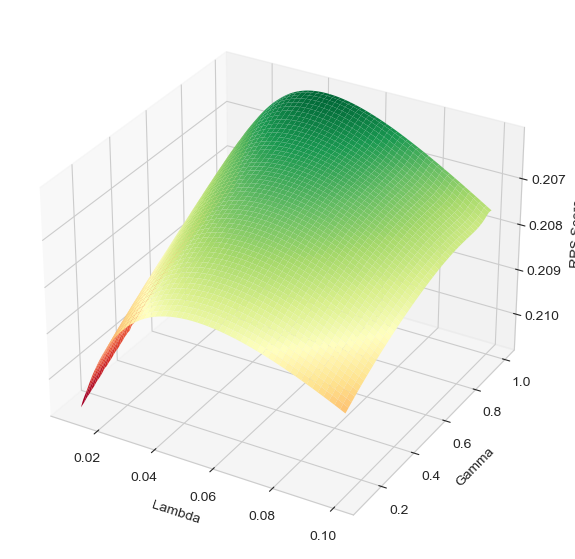

''

In [79]:
# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_new.png", dpi=300)
plt.show()

;

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_22011/4225161154.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap


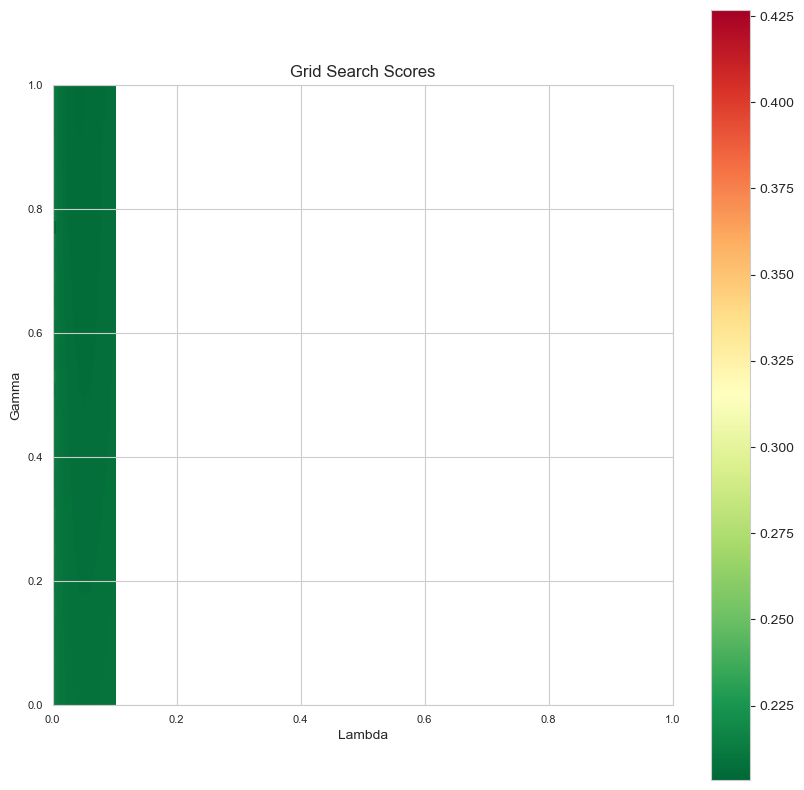

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_22011/4225161154.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df_gs_results.pivot('lambda', 'gamma', 'score')


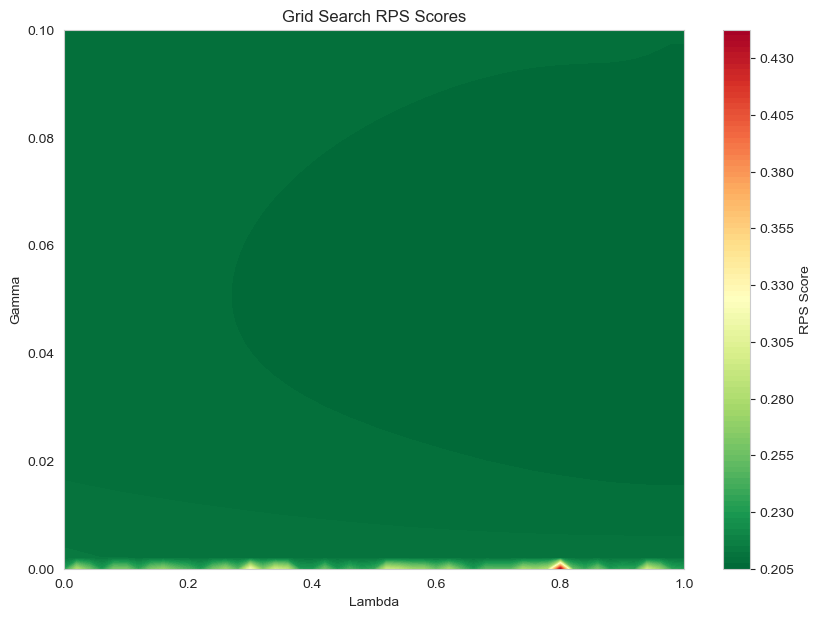

In [63]:
# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['lambda'].min(), param_grid['lambda'].max(), param_grid['gamma'].min(), param_grid['gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_new.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('lambda', 'gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()

In [ ]:

# Potential values for lambda2 and gamma2
potential_lambda2_values = np.linspace(0.1, 0.2, num=11)  
potential_gamma2_values = np.linspace(0.9, 1.0, num=11)  

# Lists to hold the parameter 'lambda2', 'gamma2' and the corresponding RPS values
parameter_values = []
rps_values = []

# Iterate over potential lambda2 and gamma2 values
for lambda2 in potential_lambda2_values:
    for gamma2 in potential_gamma2_values:
        _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
        
        # Update rates dictionary with the current lambda2 and gamma2 values
        rates['lambda2'] = lambda2
        rates['gamma2'] = gamma2

        # ... [Your existing code to update ratings and calculate RPS]
        league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
        # Calculate the mean RPS score for this combination
        mean_rps = np.mean(int_rps)
        
        # Store the lambda2, gamma2, and corresponding RPS value
        parameter_values.append((lambda2, gamma2))
        rps_values.append(mean_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (lambda2, gamma2): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
def optimize_int_threshold(df_results, df_fixtures, rates):
    # Define range for int_threshold
    thresholds = np.arange(5000, 45000, 5000)  

    # Initialize the best_score variable
    best_score = float('inf')  

    # Create an empty list to store the results
    optimization_results = []

    for threshold in tqdm.tqdm(thresholds):
        # Update rates with the current threshold
        rates['int_threshold'] = threshold

        ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
        
        # Train and evaluate your model with the current threshold
        ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
        
        df_train = pd.DataFrame(training_games)
        df_train.to_csv("../data/train232.csv", index=False)
        model = train_model(df_train)

        all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
        score = np.mean(all_rps)

        # If the current score is better than the best_score, update best_score
        if score < best_score:
            best_score = score
            best_threshold = threshold

        # Store the current score and threshold
        optimization_results.append({
            'int_threshold': threshold,
            'score': score,
        })

    # Convert the results to a DataFrame and sort by score
    df_optimization_results = pd.DataFrame(optimization_results).sort_values(by='score', ascending=True)

    # Display the top 5 combinations of the threshold and their score
    print(df_optimization_results.head())

    return best_threshold, best_score

# Call the function and get the best threshold and its score
best_threshold, best_score = optimize_int_threshold(df_results, df_fixtures, rates)
print(f"Best int_threshold: {best_threshold}")
print(f"Best score: {best_score}")


In [ ]:
rates = {
    'lambda': 0.04,
    'gamma': 0.96,
    'delta': 1,
    'phi': 1,
    'mu': 0,
    'rho': 0.93,
    'sigma': 0.6,
    'tau': 0.001,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}

# Train and predict with current_rates (and current_model if necessary)
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
# 3. Re-train model with the new parameters
ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
    
    
df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
current_model = train_model(df_train)

# 1. Define the parameter grid
param_grid = {
    'mu': np.linspace(0.0, 0.2, 3),  
    'phi': np.linspace(0, 2, 3), 
    'delta': np.linspace(1.5, 3.5, 3)  
}


# Initialize the best_score variable and best_params dictionary
best_score = float('inf')
best_params = {}

# Create an empty list to store the results
gs_results = []

# 2. Iterate over the parameter combinations
for params in tqdm.tqdm(ParameterGrid(param_grid)):
    # Extract rates from params and merge with the existing rates dictionary
    current_rates = rates.copy()
    current_rates.update(params)
    
    
    # Train and predict with current_rates (and current_model if necessary)
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # 3. Re-train model with the new parameters
    ratings, _, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, current_rates)
    
    # If your training method updates the model based on rates, you should train it here
    
    # Predict the probabilities of home win, draw and away win for the fixtures data
    all_rps = []
    for competition in df_fixtures['Div'].unique():
        competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
        competition_rps, _ = predict_outcomes(competition_fixtures, ratings, league_ratings, current_rates, model)
        all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition
    
    score = np.mean(all_rps)
    

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'mu': params['mu'],
        'phi': params['phi'],
        'delta': params['delta'],
        'score': score,
    })
    
#  Identify the best parameters based on the score
print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame
df_gs_results = pd.DataFrame(gs_results)

# Sort the results by score and get the top 5
top_5_results = df_gs_results.sort_values(by='score', ascending=True).head(5)

print("Top 5 parameter combinations:")
print(top_5_results)


In [32]:
# Gridsearch on x and y; a and b

# Initialize the rates


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'x': np.linspace(1.0, 1.4, 5),
    'y': np.linspace(1.0, 1.0, 1),
    'a': np.linspace(-1.625, -1.625, 1),
    'b': np.linspace(0.75, 0.75, 1)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # Store the current results
    gs_results.append({
        'x': rates['x'],
        'y': rates['y'],
        'a': rates['a'],
        'b': rates['b'],
        'score': score,
    })

# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda z: z['score'])[:5]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"x: {combo['x']}, y: {combo['y']}, a: {combo['a']}, b: {combo['b']}, Score: {combo['score']}")

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#to csv
df_gs_results.to_csv("../data/gs_results.csv", index=False)
top_27_results = df_gs_results.sort_values(by='score', ascending=True).head(27)

print("Top 27 parameter combinations:")
print(top_27_results)


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_gs_results is already loaded with your data

# Combine mu and phi into a single column for visualization
df_gs_results['mu_phi'] = df_gs_results['mu'].astype(str) + ", " + df_gs_results['phi'].astype(str)

# Create a numerical mapping for the mu_phi combinations
unique_mu_phi = df_gs_results['mu_phi'].unique()
mapping = {unique_mu_phi[i]: i for i in range(len(unique_mu_phi))}
df_gs_results['mu_phi_mapped'] = df_gs_results['mu_phi'].map(mapping)

# Sorting for a consistent visualization
df_gs_results = df_gs_results.sort_values(by=['mu_phi_mapped', 'delta'])

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_gs_results['mu_phi_mapped'], df_gs_results['delta'], df_gs_results['score'], c=df_gs_results['score'], cmap='RdYlGn_r')
ax.set_xlabel('Mu, Phi')
ax.set_ylabel('Delta')
ax.set_zlabel('RPS Score')
ax.invert_zaxis()  # To make lower scores appear higher

# Set x-ticks to be the string representation
ax.set_xticks(list(mapping.values()))
ax.set_xticklabels(list(mapping.keys()), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
# Lists to hold the parameter 'rho', 'sigma' and the corresponding RPS values
parameter_values = []
rps_values = []

# Grid of potential values for rho and sigma
potential_rho_values = np.linspace(0.75, 1.0, num=26)
potential_sigma_values = np.linspace(0.5, 0.7, num=21)

# Iterate over potential rho and sigma values
for rho in potential_rho_values:
    for sigma in potential_sigma_values:
        rates['rho'] = rho
        rates['sigma'] = sigma
        
        # Obtain the RPS for the current value of rho and sigma
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)

        # Compute the average RPS
        avg_rps = np.mean(int_rps)

        # Add current result to the lists
        parameter_values.append((rho, sigma))
        rps_values.append(avg_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (rho, sigma): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
# Generate meshgrid for 3D plot
a_grid, b_grid = np.meshgrid(potential_a_values, potential_b_values)

# Reshape rps_values into grid
rps_grid = np.array(rps_values).reshape(a_grid.shape)

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(a_grid, b_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
plt.savefig("../images/3d_plot_ab_rps.png", dpi=300)
plt.show()


In [ ]:
import seaborn as sns

# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Invert y-axis
ax.invert_yaxis()

plt.savefig("../images/heatmap_ab_rps.png", dpi=300)
plt.show()



In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle


# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Add a red rectangle around the cell to highlight it
for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.add_patch(Rectangle((b_values.index(highlight_b), a_values.index(highlight_a)), 1, 1, fill=False, edgecolor='red', lw=3))

ax.invert_yaxis()
plt.savefig("../images/heatmap_ab_rps1.png", dpi=300)
plt.show()


In [ ]:
from matplotlib.patches import Rectangle


# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Find indices of the desired range in a_values and b_values
start_a_index = a_values.index(0)
end_a_index = a_values.index(0.5) + 1  # plus 1 to include 0.5
start_b_index = b_values.index(0.75)
end_b_index = b_values.index(1.25) + 1  # plus 1 to include 1.25

# Select subsets
a_values_subset = a_values[start_a_index:end_a_index]
b_values_subset = b_values[start_b_index:end_b_index]
rps_grid_subset = rps_grid[start_a_index:end_a_index, start_b_index:end_b_index]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(rps_grid_subset, origin='lower', cmap='RdYlGn_r')
fig.colorbar(cax)
# Move x-axis labels to bottom
ax.xaxis.tick_bottom()
ax.set_xticks(range(len(b_values_subset)))
ax.set_yticks(range(len(a_values_subset)))
ax.set_xticklabels(np.round(b_values_subset, 2))
ax.set_yticklabels(np.round(a_values_subset, 2))

plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

plt.savefig("../images/heatmap_ab_rps2.png", dpi=300)
plt.show()


In [ ]:
"""
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def train_model2(df_train):
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # Model Selection and Parameter Tuning
    #model = LogisticRegression(solver="saga", penalty="l2", tol=1e-3, C=0.1)
    #model = RandomForestClassifier(n_estimators=100, random_state=42)
    model = GradientBoostingClassifier(n_estimators=100)
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000)
    
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'Model accuracy: {accuracy*100:.2f}%')
    print(f'Model precision: {precision*100:.2f}%')
    print(f'Model recall: {recall*100:.2f}%')
    print(f'Model F1-score: {f1*100:.2f}%')
    
    return model
"""
    
;

In [ ]:
"""
from sklearn.model_selection import cross_val_score

def train_model(df_train):
    
    # Feature Selection
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']
    
    # Model Selection and Parameter Tuning
    model = LogisticRegression(solver="saga", penalty="l2")
    
    # Cross-Validation
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()*100:.2f}%')
    print(f'Standard Deviation: {scores.std()*100:.2f}%')
    
    # Fit the model with all the data
    model.fit(X, y)
    
    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')
    
    return model
"""